In [1]:
!nvidia-smi

Wed Feb 28 00:17:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   35C    P8              22W / 215W |    515MiB /  8192MiB |     13%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [3]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [5]:
data_dir = '../data/data_preprocessed/esd/features_4balanced/'

sr = 16000

data_x = np.load(f'{data_dir}esd.audio16k.npy', 
                 allow_pickle=True)
data_y = np.load(f'{data_dir}esd.label_emotion.npy', 
                 allow_pickle=True)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 22400
Test: 5600


In [7]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [8]:
np.unique(y_test)

array(['anger', 'hapiness', 'neutral', 'sadness'], dtype='<U8')

In [9]:
labels = ['ang', 'neu', 'sad', 'hap']

In [10]:
def label_to_index(word):
    return labels.index(word[:3])

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=4, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = [waveform[offset: length-offset]]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float).flatten(), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label_to_index(label), 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [11]:
import traceback

In [12]:
from IConNet.nn.model import M13sinc as M13
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m13sinc.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M13sinc', 'description': 'SincNet with fftconv', 'fe': {'n_block': 2, 'n_channel': [128, 32], 'kernel_size': [511, 127], 'stride': [8, 2], 'window_k': [2, 9], 'residual_connection_type': 'stack', 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': True, 'learnable_windows': False, 'shared_window': True, 'window_func': 'hamming', 'mel_resolution': 1, 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [256, 256], 'norm_type': 'LayerNorm'}}


M13sinc(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (no

In [13]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [ ]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [15]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                               | 0.001142857142857143/10 [00:00<1:24:33, 507.38s/it]

Train Epoch: 1 [0/22400 (0%)]	Loss: 1.473671
Mem before-during-after: 541184 1734897664 21338624


  0%|                               | 0.023999999999999983/10 [00:09<1:02:18, 374.70s/it]

Train Epoch: 1 [640/22400 (3%)]	Loss: 1.457308
Mem before-during-after: 21338624 1746617856 21338624


  0%|▏                              | 0.046285714285714215/10 [00:17<1:05:19, 393.81s/it]

Train Epoch: 1 [1280/22400 (6%)]	Loss: 1.394835
Mem before-during-after: 21338624 1746617856 21338624


  1%|▏                               | 0.06971428571428559/10 [00:27<1:02:44, 379.08s/it]

Train Epoch: 1 [1920/22400 (9%)]	Loss: 1.897104
Mem before-during-after: 21338624 1701795328 21519360


  1%|▎                               | 0.09257142857142839/10 [00:36<1:03:30, 384.58s/it]

Train Epoch: 1 [2560/22400 (11%)]	Loss: 1.063770
Mem before-during-after: 21338624 1746650624 21338624


  1%|▎                               | 0.11542857142857119/10 [00:45<1:04:27, 391.31s/it]

Train Epoch: 1 [3200/22400 (14%)]	Loss: 1.257694
Mem before-during-after: 21338624 1746617856 21338624


  1%|▍                               | 0.13828571428571432/10 [00:53<1:03:18, 385.14s/it]

Train Epoch: 1 [3840/22400 (17%)]	Loss: 1.300905
Mem before-during-after: 21338624 1693324800 21941248


  2%|▌                               | 0.16114285714285767/10 [01:02<1:03:40, 388.35s/it]

Train Epoch: 1 [4480/22400 (20%)]	Loss: 1.119651
Mem before-during-after: 21338624 1745926656 21338624


  2%|▌                               | 0.18400000000000102/10 [01:11<1:00:07, 367.48s/it]

Train Epoch: 1 [5120/22400 (23%)]	Loss: 1.481363
Mem before-during-after: 21338624 1674655232 21650944


  2%|▋                                 | 0.20685714285714438/10 [01:19<59:33, 364.85s/it]

Train Epoch: 1 [5760/22400 (26%)]	Loss: 1.200497
Mem before-during-after: 21338624 1745585664 21387776


  2%|▋                               | 0.22971428571428773/10 [01:28<1:03:17, 388.72s/it]

Train Epoch: 1 [6400/22400 (29%)]	Loss: 1.129563
Mem before-during-after: 21338624 1745569280 21338624


  3%|▊                                 | 0.25257142857143094/10 [01:36<58:02, 357.29s/it]

Train Epoch: 1 [7040/22400 (31%)]	Loss: 1.106373
Mem before-during-after: 21338624 1745602048 21338624


  3%|▉                               | 0.27485714285714463/10 [01:44<1:04:13, 396.24s/it]

Train Epoch: 1 [7680/22400 (34%)]	Loss: 2.392321
Mem before-during-after: 21338624 1620211712 21338624


  3%|▉                               | 0.29828571428571543/10 [01:53<1:00:17, 372.85s/it]

Train Epoch: 1 [8320/22400 (37%)]	Loss: 1.504658
Mem before-during-after: 21338624 1745602048 21338624


  3%|█                                | 0.3205714285714291/10 [02:02<1:05:10, 404.05s/it]

Train Epoch: 1 [8960/22400 (40%)]	Loss: 1.283908
Mem before-during-after: 21338624 1745585664 21387776


  3%|█                               | 0.34342857142857136/10 [02:10<1:07:02, 416.54s/it]

Train Epoch: 1 [9600/22400 (43%)]	Loss: 1.117859
Mem before-during-after: 21338624 1745585664 21387776


  4%|█▏                                | 0.36685714285714216/10 [02:19<58:32, 364.62s/it]

Train Epoch: 1 [10240/22400 (46%)]	Loss: 1.034678
Mem before-during-after: 21338624 1745536512 21338624


  4%|█▎                                 | 0.3897142857142844/10 [02:28<58:17, 363.96s/it]

Train Epoch: 1 [10880/22400 (49%)]	Loss: 1.190211
Mem before-during-after: 21338624 1745602048 21338624


  4%|█▍                                | 0.41257142857142665/10 [02:36<58:27, 365.87s/it]

Train Epoch: 1 [11520/22400 (51%)]	Loss: 2.483627
Mem before-during-after: 21338624 1701614592 21338624


  4%|█▍                               | 0.4354285714285689/10 [02:45<1:04:10, 402.55s/it]

Train Epoch: 1 [12160/22400 (54%)]	Loss: 1.570487
Mem before-during-after: 21338624 1745569280 21338624


  5%|█▍                              | 0.45828571428571113/10 [02:54<1:00:10, 378.39s/it]

Train Epoch: 1 [12800/22400 (57%)]	Loss: 1.585750
Mem before-during-after: 21338624 1745602048 21338624


  5%|█▋                                 | 0.4811428571428534/10 [03:03<58:43, 370.13s/it]

Train Epoch: 1 [13440/22400 (60%)]	Loss: 1.358175
Mem before-during-after: 21338624 1745602048 21338624


  5%|█▋                               | 0.5034285714285671/10 [03:11<1:02:49, 396.92s/it]

Train Epoch: 1 [14080/22400 (63%)]	Loss: 0.957529
Mem before-during-after: 21338624 1745602048 21338624


  5%|█▊                                 | 0.5268571428571379/10 [03:20<58:12, 368.65s/it]

Train Epoch: 1 [14720/22400 (66%)]	Loss: 1.282967
Mem before-during-after: 21338624 1745602048 21338624


  5%|█▉                                 | 0.5497142857142802/10 [03:29<58:52, 373.79s/it]

Train Epoch: 1 [15360/22400 (69%)]	Loss: 1.109390
Mem before-during-after: 21338624 1745602048 21338624


  6%|█▉                               | 0.5725714285714224/10 [03:37<1:00:02, 382.15s/it]

Train Epoch: 1 [16000/22400 (71%)]	Loss: 0.889115
Mem before-during-after: 21338624 1745569280 21338624


  6%|██                                 | 0.5954285714285646/10 [03:46<57:09, 364.62s/it]

Train Epoch: 1 [16640/22400 (74%)]	Loss: 1.235973
Mem before-during-after: 21338624 1745569280 21338624


  6%|██▏                                | 0.6182857142857069/10 [03:54<58:03, 371.29s/it]

Train Epoch: 1 [17280/22400 (77%)]	Loss: 1.094245
Mem before-during-after: 21387776 1475099136 21338624


  6%|██▏                                | 0.6411428571428491/10 [04:03<58:19, 373.93s/it]

Train Epoch: 1 [17920/22400 (80%)]	Loss: 1.109684
Mem before-during-after: 21338624 1745602048 21338624


  7%|██▎                                | 0.6639999999999914/10 [04:11<57:41, 370.75s/it]

Train Epoch: 1 [18560/22400 (83%)]	Loss: 0.888832
Mem before-during-after: 21338624 1745602048 21338624


  7%|██▍                                | 0.6868571428571336/10 [04:20<58:17, 375.50s/it]

Train Epoch: 1 [19200/22400 (86%)]	Loss: 1.408989
Mem before-during-after: 21404160 1745634816 21338624


  7%|██▍                                | 0.7097142857142759/10 [04:28<55:29, 358.36s/it]

Train Epoch: 1 [19840/22400 (89%)]	Loss: 1.113243
Mem before-during-after: 21338624 1745569280 21338624


  7%|██▌                                | 0.7325714285714181/10 [04:36<54:25, 352.36s/it]

Train Epoch: 1 [20480/22400 (91%)]	Loss: 1.012083
Mem before-during-after: 21338624 1717298176 21338624


  8%|██▍                              | 0.7548571428571318/10 [04:45<1:01:22, 398.31s/it]

Train Epoch: 1 [21120/22400 (94%)]	Loss: 1.039178
Mem before-during-after: 21338624 1745552896 21355008


  8%|██▋                                | 0.7782857142857026/10 [04:54<56:31, 367.78s/it]

Train Epoch: 1 [21760/22400 (97%)]	Loss: 1.068009
Mem before-during-after: 21338624 1691395584 21338624


 10%|███▌                                | 1.000571428571411/10 [06:02<47:32, 316.93s/it]


Test Epoch: 1	Accuracy: 2339/5600 (42%)

Train Epoch: 2 [0/22400 (0%)]	Loss: 1.157553
Mem before-during-after: 21337600 1744537088 21338624


 10%|███▌                               | 1.0239999999999863/10 [06:11<57:23, 383.62s/it]

Train Epoch: 2 [640/22400 (3%)]	Loss: 0.956521
Mem before-during-after: 21338624 1745602048 21338624


 10%|███▊                                | 1.046857142857133/10 [06:20<54:23, 364.49s/it]

Train Epoch: 2 [1280/22400 (6%)]	Loss: 1.406042
Mem before-during-after: 21338624 1745569280 21338624


 11%|███▋                               | 1.0697142857142796/10 [06:28<52:59, 355.99s/it]

Train Epoch: 2 [1920/22400 (9%)]	Loss: 1.459807
Mem before-during-after: 21338624 1745536512 21338624


 11%|███▊                               | 1.0919999999999976/10 [06:36<58:32, 394.29s/it]

Train Epoch: 2 [2560/22400 (11%)]	Loss: 1.561142
Mem before-during-after: 21338624 1539338752 21338624


 11%|████                                | 1.115428571428573/10 [06:45<54:52, 370.55s/it]

Train Epoch: 2 [3200/22400 (14%)]	Loss: 1.297161
Mem before-during-after: 21338624 1582300672 21338624


 11%|███▉                               | 1.1382857142857197/10 [06:54<55:37, 376.60s/it]

Train Epoch: 2 [3840/22400 (17%)]	Loss: 0.970708
Mem before-during-after: 21338624 1745569280 21338624


 12%|████                               | 1.1611428571428664/10 [07:03<55:03, 373.76s/it]

Train Epoch: 2 [4480/22400 (20%)]	Loss: 1.287613
Mem before-during-after: 21338624 1745569280 21338624


 12%|████▎                               | 1.184000000000013/10 [07:12<53:38, 365.03s/it]

Train Epoch: 2 [5120/22400 (23%)]	Loss: 0.950752
Mem before-during-after: 21338624 1747535360 22385152


 12%|████▏                              | 1.2068571428571597/10 [07:21<54:58, 375.14s/it]

Train Epoch: 2 [5760/22400 (26%)]	Loss: 1.202829
Mem before-during-after: 21338624 1745602048 21338624


 12%|████▎                              | 1.2297142857143064/10 [07:29<52:54, 361.93s/it]

Train Epoch: 2 [6400/22400 (29%)]	Loss: 1.172026
Mem before-during-after: 21404160 1745536512 21338624


 13%|████▍                              | 1.2520000000000244/10 [07:37<58:17, 399.75s/it]

Train Epoch: 2 [7040/22400 (31%)]	Loss: 1.735097
Mem before-during-after: 21338624 1702139392 21338624


 13%|████▍                              | 1.2754285714285998/10 [07:46<56:02, 385.42s/it]

Train Epoch: 2 [7680/22400 (34%)]	Loss: 0.977754
Mem before-during-after: 21338624 1745876480 21338624


 13%|████▌                              | 1.2982857142857465/10 [07:55<56:49, 391.85s/it]

Train Epoch: 2 [8320/22400 (37%)]	Loss: 1.233391
Mem before-during-after: 21387776 1745536512 21338624


 13%|████▌                              | 1.3211428571428931/10 [08:04<59:37, 412.24s/it]

Train Epoch: 2 [8960/22400 (40%)]	Loss: 1.315531
Mem before-during-after: 21338624 1745569280 21338624


 13%|████▋                              | 1.3440000000000398/10 [08:13<53:25, 370.32s/it]

Train Epoch: 2 [9600/22400 (43%)]	Loss: 1.289915
Mem before-during-after: 21338624 1745602048 21338624


 14%|████▊                              | 1.3668571428571865/10 [08:21<52:37, 365.72s/it]

Train Epoch: 2 [10240/22400 (46%)]	Loss: 1.565205
Mem before-during-after: 21338624 1745569280 21338624


 14%|████▊                              | 1.3897142857143332/10 [08:30<54:36, 380.49s/it]

Train Epoch: 2 [10880/22400 (49%)]	Loss: 1.246495
Mem before-during-after: 21338624 1746123264 21925376


 14%|████▉                              | 1.4125714285714799/10 [08:39<53:05, 370.99s/it]

Train Epoch: 2 [11520/22400 (51%)]	Loss: 0.956024
Mem before-during-after: 21338624 1745569280 21338624


 14%|█████▏                              | 1.434857142857198/10 [08:48<56:13, 393.87s/it]

Train Epoch: 2 [12160/22400 (54%)]	Loss: 0.892901
Mem before-during-after: 21338624 1745569280 21338624


 15%|█████                              | 1.4577142857143446/10 [08:56<55:30, 389.86s/it]

Train Epoch: 2 [12800/22400 (57%)]	Loss: 1.077953
Mem before-during-after: 21338624 1745536512 21338624


 15%|█████▍                               | 1.48114285714292/10 [09:05<52:51, 372.30s/it]

Train Epoch: 2 [13440/22400 (60%)]	Loss: 1.001355
Mem before-during-after: 21338624 1745602048 21338624


 15%|█████▎                             | 1.5040000000000666/10 [09:13<51:22, 362.76s/it]

Train Epoch: 2 [14080/22400 (63%)]	Loss: 0.722533
Mem before-during-after: 21338624 1745569280 21338624


 15%|█████▎                             | 1.5268571428572133/10 [09:22<52:39, 372.89s/it]

Train Epoch: 2 [14720/22400 (66%)]	Loss: 1.107783
Mem before-during-after: 21338624 1745569280 21338624


 15%|█████▋                               | 1.54971428571436/10 [09:30<51:26, 365.24s/it]

Train Epoch: 2 [15360/22400 (69%)]	Loss: 0.746209
Mem before-during-after: 21387776 1745536512 21338624


 16%|█████▌                             | 1.5725714285715067/10 [09:38<51:16, 365.01s/it]

Train Epoch: 2 [16000/22400 (71%)]	Loss: 0.875660
Mem before-during-after: 21338624 1636380160 21338624


 16%|█████▌                             | 1.5954285714286534/10 [09:47<52:04, 371.72s/it]

Train Epoch: 2 [16640/22400 (74%)]	Loss: 0.923343
Mem before-during-after: 21338624 1745602048 21338624


 16%|██████▏                               | 1.6182857142858/10 [09:56<51:42, 370.13s/it]

Train Epoch: 2 [17280/22400 (77%)]	Loss: 0.938774
Mem before-during-after: 21338624 1745569280 21338624


 16%|█████▋                             | 1.6411428571429467/10 [10:04<51:08, 367.14s/it]

Train Epoch: 2 [17920/22400 (80%)]	Loss: 1.751481
Mem before-during-after: 21338624 1674949120 21338624


 17%|█████▊                             | 1.6640000000000934/10 [10:13<50:31, 363.66s/it]

Train Epoch: 2 [18560/22400 (83%)]	Loss: 0.886234
Mem before-during-after: 21338624 1745602048 21338624


 17%|██████▏                              | 1.68685714285724/10 [10:21<49:18, 355.82s/it]

Train Epoch: 2 [19200/22400 (86%)]	Loss: 0.995273
Mem before-during-after: 21338624 1745536512 21338624


 17%|█████▉                             | 1.7097142857143868/10 [10:29<49:34, 358.79s/it]

Train Epoch: 2 [19840/22400 (89%)]	Loss: 0.979952
Mem before-during-after: 21338624 1745602048 21338624


 17%|██████                             | 1.7325714285715335/10 [10:37<49:53, 362.10s/it]

Train Epoch: 2 [20480/22400 (91%)]	Loss: 0.937568
Mem before-during-after: 21338624 1745585664 21387776


 18%|██████▏                            | 1.7554285714286801/10 [10:46<51:19, 373.53s/it]

Train Epoch: 2 [21120/22400 (94%)]	Loss: 0.988024
Mem before-during-after: 21338624 1745569280 21338624


 18%|██████▏                            | 1.7782857142858268/10 [10:54<49:35, 361.95s/it]

Train Epoch: 2 [21760/22400 (97%)]	Loss: 1.110497
Mem before-during-after: 21338624 1745602048 21338624


 20%|███████                            | 2.0000000000001497/10 [12:03<41:46, 313.37s/it]


Test Epoch: 2	Accuracy: 2753/5600 (49%)



 20%|███████                            | 2.0011428571430065/10 [12:03<41:40, 312.58s/it]

Train Epoch: 3 [0/22400 (0%)]	Loss: 1.005532
Mem before-during-after: 21337600 1744537088 21338624


 20%|███████                            | 2.0240000000001444/10 [12:12<48:00, 361.11s/it]

Train Epoch: 3 [640/22400 (3%)]	Loss: 1.182922
Mem before-during-after: 21338624 1746650624 21338624


 20%|███████▎                            | 2.046857142857282/10 [12:20<49:58, 377.05s/it]

Train Epoch: 3 [1280/22400 (6%)]	Loss: 1.136354
Mem before-during-after: 21338624 1746617856 21338624


 21%|███████▋                             | 2.06971428571442/10 [12:29<47:07, 356.59s/it]

Train Epoch: 3 [1920/22400 (9%)]	Loss: 1.147696
Mem before-during-after: 21338624 1746617856 21338624


 21%|███████▎                           | 2.0925714285715578/10 [12:37<46:38, 353.97s/it]

Train Epoch: 3 [2560/22400 (11%)]	Loss: 1.263005
Mem before-during-after: 21387776 1745536512 21338624


 21%|███████▍                           | 2.1154285714286956/10 [12:45<47:04, 358.29s/it]

Train Epoch: 3 [3200/22400 (14%)]	Loss: 1.206600
Mem before-during-after: 21338624 1555372544 21338624


 21%|███████▍                           | 2.1382857142858334/10 [12:54<48:08, 367.36s/it]

Train Epoch: 3 [3840/22400 (17%)]	Loss: 0.937427
Mem before-during-after: 21338624 1744553472 21338624


 22%|███████▊                            | 2.161142857142971/10 [13:02<46:19, 354.59s/it]

Train Epoch: 3 [4480/22400 (20%)]	Loss: 1.459300
Mem before-during-after: 21338624 1744701440 21338624


 22%|███████▊                            | 2.184000000000109/10 [13:10<47:30, 364.65s/it]

Train Epoch: 3 [5120/22400 (23%)]	Loss: 1.063048
Mem before-during-after: 21338624 1744553472 21338624


 22%|███████▋                           | 2.2068571428572468/10 [13:18<46:22, 356.98s/it]

Train Epoch: 3 [5760/22400 (26%)]	Loss: 1.183552
Mem before-during-after: 21338624 1744520704 21338624


 22%|███████▊                           | 2.2297142857143846/10 [13:27<46:23, 358.20s/it]

Train Epoch: 3 [6400/22400 (29%)]	Loss: 1.225257
Mem before-during-after: 21338624 1744520704 21338624


 23%|███████▉                           | 2.2525714285715224/10 [13:35<45:45, 354.34s/it]

Train Epoch: 3 [7040/22400 (31%)]	Loss: 1.238114
Mem before-during-after: 21338624 1744553472 21338624


 23%|████████▍                            | 2.27542857142866/10 [13:43<46:09, 358.57s/it]

Train Epoch: 3 [7680/22400 (34%)]	Loss: 1.046566
Mem before-during-after: 21338624 1744827904 21338624


 23%|████████▎                           | 2.298285714285798/10 [13:51<45:45, 356.49s/it]

Train Epoch: 3 [8320/22400 (37%)]	Loss: 0.926227
Mem before-during-after: 21338624 1744827904 21338624


 23%|████████▎                           | 2.321142857142936/10 [13:59<46:02, 359.73s/it]

Train Epoch: 3 [8960/22400 (40%)]	Loss: 1.203125
Mem before-during-after: 21338624 1674475008 21338624


 23%|████████▏                          | 2.3440000000000736/10 [14:08<45:14, 354.54s/it]

Train Epoch: 3 [9600/22400 (43%)]	Loss: 1.399903
Mem before-during-after: 21338624 1744995840 21338624


 24%|████████▎                          | 2.3668571428572114/10 [14:16<46:06, 362.45s/it]

Train Epoch: 3 [10240/22400 (46%)]	Loss: 0.897631
Mem before-during-after: 21338624 1744553472 21338624


 24%|████████▎                          | 2.3891428571429207/10 [14:24<47:40, 375.78s/it]

Train Epoch: 3 [10880/22400 (49%)]	Loss: 1.703964
Mem before-during-after: 21338624 1636389376 21338624


 24%|████████▋                           | 2.412571428571487/10 [14:33<46:32, 368.02s/it]

Train Epoch: 3 [11520/22400 (51%)]	Loss: 0.941229
Mem before-during-after: 21338624 1744619008 21338624


 24%|████████▌                          | 2.4348571428571963/10 [14:41<49:43, 394.34s/it]

Train Epoch: 3 [12160/22400 (54%)]	Loss: 0.888070
Mem before-during-after: 21338624 1744553472 21338624


 25%|████████▌                          | 2.4582857142857626/10 [14:49<46:38, 371.12s/it]

Train Epoch: 3 [12800/22400 (57%)]	Loss: 1.192151
Mem before-during-after: 21338624 1744553472 21338624


 25%|████████▋                          | 2.4811428571429004/10 [14:58<46:01, 367.23s/it]

Train Epoch: 3 [13440/22400 (60%)]	Loss: 0.927199
Mem before-during-after: 21338624 1690468864 21338624


 25%|█████████                           | 2.504000000000038/10 [15:06<48:15, 386.24s/it]

Train Epoch: 3 [14080/22400 (63%)]	Loss: 0.934405
Mem before-during-after: 21338624 1744553472 21338624


 25%|█████████                           | 2.526857142857176/10 [15:14<45:27, 364.94s/it]

Train Epoch: 3 [14720/22400 (66%)]	Loss: 1.036766
Mem before-during-after: 21338624 1744504320 21338624


 25%|█████████▏                          | 2.549714285714314/10 [15:22<44:06, 355.20s/it]

Train Epoch: 3 [15360/22400 (69%)]	Loss: 1.245067
Mem before-during-after: 21338624 1744553472 21338624


 26%|█████████                          | 2.5725714285714516/10 [15:30<45:39, 368.87s/it]

Train Epoch: 3 [16000/22400 (71%)]	Loss: 0.709439
Mem before-during-after: 21338624 1744553472 21338624


 26%|█████████                          | 2.5954285714285894/10 [15:39<43:22, 351.44s/it]

Train Epoch: 3 [16640/22400 (74%)]	Loss: 1.021000
Mem before-during-after: 21786112 1744504320 21338624


 26%|█████████▍                          | 2.618285714285727/10 [15:47<44:26, 361.24s/it]

Train Epoch: 3 [17280/22400 (77%)]	Loss: 0.936309
Mem before-during-after: 21338624 1744553472 21338624


 26%|█████████▌                          | 2.641142857142865/10 [15:55<43:48, 357.14s/it]

Train Epoch: 3 [17920/22400 (80%)]	Loss: 0.862823
Mem before-during-after: 21338624 1744520704 21338624


 27%|█████████▌                          | 2.664000000000003/10 [16:03<45:47, 374.59s/it]

Train Epoch: 3 [18560/22400 (83%)]	Loss: 0.923848
Mem before-during-after: 21338624 1744520704 21338624


 27%|█████████▍                         | 2.6868571428571406/10 [16:12<43:52, 360.00s/it]

Train Epoch: 3 [19200/22400 (86%)]	Loss: 1.436124
Mem before-during-after: 21338624 1744553472 21338624


 27%|█████████▍                         | 2.7097142857142784/10 [16:20<43:34, 358.67s/it]

Train Epoch: 3 [19840/22400 (89%)]	Loss: 1.011020
Mem before-during-after: 21338624 1744537088 21387776


 27%|█████████▊                          | 2.732571428571416/10 [16:28<42:06, 347.69s/it]

Train Epoch: 3 [20480/22400 (91%)]	Loss: 1.121347
Mem before-during-after: 21338624 1744553472 21338624


 28%|█████████▉                          | 2.755428571428554/10 [16:36<43:53, 363.52s/it]

Train Epoch: 3 [21120/22400 (94%)]	Loss: 0.998690
Mem before-during-after: 21338624 1744520704 21338624


 28%|██████████                          | 2.778285714285692/10 [16:45<43:43, 363.26s/it]

Train Epoch: 3 [21760/22400 (97%)]	Loss: 1.003011
Mem before-during-after: 21338624 1744832000 21338624


 30%|██████████▍                        | 2.9999999999999285/10 [17:52<33:58, 291.28s/it]


Test Epoch: 3	Accuracy: 2566/5600 (46%)



 30%|██████████▌                        | 3.0011428571427854/10 [17:52<36:14, 310.62s/it]

Train Epoch: 4 [0/22400 (0%)]	Loss: 0.981416
Mem before-during-after: 21337600 1744537088 21338624


 30%|██████████▌                        | 3.0234285714284947/10 [18:00<43:32, 374.51s/it]

Train Epoch: 4 [640/22400 (3%)]	Loss: 0.917558
Mem before-during-after: 21338624 1745651712 21338624


 30%|██████████▋                        | 3.0462857142856326/10 [18:09<43:53, 378.69s/it]

Train Epoch: 4 [1280/22400 (6%)]	Loss: 1.049121
Mem before-during-after: 21338624 1746102784 21338624


 31%|███████████                         | 3.069714285714199/10 [18:17<41:45, 361.56s/it]

Train Epoch: 4 [1920/22400 (9%)]	Loss: 1.015002
Mem before-during-after: 21387776 1744487936 21338624


 31%|██████████▊                        | 3.0925714285713366/10 [18:25<41:07, 357.16s/it]

Train Epoch: 4 [2560/22400 (11%)]	Loss: 1.096623
Mem before-during-after: 21338624 1745536512 21338624


 31%|██████████▉                        | 3.1154285714284744/10 [18:33<41:13, 359.32s/it]

Train Epoch: 4 [3200/22400 (14%)]	Loss: 1.525771
Mem before-during-after: 21338624 1745602048 21338624


 31%|███████████▎                        | 3.138285714285612/10 [18:42<42:03, 367.82s/it]

Train Epoch: 4 [3840/22400 (17%)]	Loss: 1.009281
Mem before-during-after: 21338624 1744553472 21338624


 32%|███████████▋                         | 3.16114285714275/10 [18:50<40:24, 354.56s/it]

Train Epoch: 4 [4480/22400 (20%)]	Loss: 1.158780
Mem before-during-after: 21338624 1745206272 21338624


 32%|███████████▍                        | 3.183999999999888/10 [18:58<40:57, 360.54s/it]

Train Epoch: 4 [5120/22400 (23%)]	Loss: 1.252843
Mem before-during-after: 21338624 1744553472 21338624


 32%|███████████▏                       | 3.2068571428570256/10 [19:06<41:08, 363.40s/it]

Train Epoch: 4 [5760/22400 (26%)]	Loss: 0.872372
Mem before-during-after: 21338624 1744553472 21338624


 32%|███████████▎                       | 3.2297142857141634/10 [19:15<40:11, 356.22s/it]

Train Epoch: 4 [6400/22400 (29%)]	Loss: 1.088510
Mem before-during-after: 21338624 1729275392 21744640


 33%|███████████▋                        | 3.252571428571301/10 [19:23<40:19, 358.55s/it]

Train Epoch: 4 [7040/22400 (31%)]	Loss: 1.000287
Mem before-during-after: 21355008 1744537088 21338624


 33%|███████████▊                        | 3.275428571428439/10 [19:31<40:10, 358.39s/it]

Train Epoch: 4 [7680/22400 (34%)]	Loss: 1.079417
Mem before-during-after: 21338624 1744553472 21338624


 33%|███████████▊                        | 3.298285714285577/10 [19:39<39:25, 352.94s/it]

Train Epoch: 4 [8320/22400 (37%)]	Loss: 1.678052
Mem before-during-after: 21338624 1744553472 21338624


 33%|███████████▌                       | 3.3211428571427146/10 [19:47<39:23, 353.84s/it]

Train Epoch: 4 [8960/22400 (40%)]	Loss: 1.165429
Mem before-during-after: 21338624 1744619008 21338624


 33%|███████████▋                       | 3.3439999999998524/10 [19:56<39:28, 355.84s/it]

Train Epoch: 4 [9600/22400 (43%)]	Loss: 1.009474
Mem before-during-after: 21338624 1744553472 21338624


 34%|███████████▊                       | 3.3668571428569902/10 [20:04<39:12, 354.67s/it]

Train Epoch: 4 [10240/22400 (46%)]	Loss: 1.163377
Mem before-during-after: 21338624 1744504320 21355008


 34%|████████████▏                       | 3.389714285714128/10 [20:12<39:30, 358.54s/it]

Train Epoch: 4 [10880/22400 (49%)]	Loss: 1.344753
Mem before-during-after: 21338624 1609324544 21338624


 34%|████████████▎                       | 3.412571428571266/10 [20:20<39:13, 357.26s/it]

Train Epoch: 4 [11520/22400 (51%)]	Loss: 1.443396
Mem before-during-after: 21338624 1744487936 21338624


 34%|████████████▎                       | 3.434857142856975/10 [20:28<41:19, 377.66s/it]

Train Epoch: 4 [12160/22400 (54%)]	Loss: 1.070347
Mem before-during-after: 21338624 1609891840 21338624


 35%|████████████                       | 3.4582857142855414/10 [20:37<40:07, 367.99s/it]

Train Epoch: 4 [12800/22400 (57%)]	Loss: 1.056556
Mem before-during-after: 21338624 1744487936 21338624


 35%|████████████▏                      | 3.4811428571426792/10 [20:45<39:20, 362.15s/it]

Train Epoch: 4 [13440/22400 (60%)]	Loss: 1.594324
Mem before-during-after: 21338624 1744487936 21338624


 35%|████████████▌                       | 3.503999999999817/10 [20:53<41:06, 379.62s/it]

Train Epoch: 4 [14080/22400 (63%)]	Loss: 0.907752
Mem before-during-after: 21338624 1744537088 21338624


 35%|████████████▎                      | 3.5262857142855264/10 [21:01<41:46, 387.17s/it]

Train Epoch: 4 [14720/22400 (66%)]	Loss: 1.054772
Mem before-during-after: 21338624 1744487936 21338624


 35%|████████████▍                      | 3.5497142857140926/10 [21:10<38:12, 355.45s/it]

Train Epoch: 4 [15360/22400 (69%)]	Loss: 0.884207
Mem before-during-after: 21338624 1717363712 21338624


 36%|████████████▌                      | 3.5725714285712304/10 [21:18<41:00, 382.86s/it]

Train Epoch: 4 [16000/22400 (71%)]	Loss: 0.909378
Mem before-during-after: 21338624 1744487936 21338624


 36%|████████████▌                      | 3.5954285714283682/10 [21:27<44:03, 412.71s/it]

Train Epoch: 4 [16640/22400 (74%)]	Loss: 1.287936
Mem before-during-after: 21338624 1744668160 21387776


 36%|█████████████                       | 3.618285714285506/10 [21:35<39:25, 370.65s/it]

Train Epoch: 4 [17280/22400 (77%)]	Loss: 0.678025
Mem before-during-after: 21338624 1717337088 21338624


 36%|█████████████                       | 3.641142857142644/10 [21:43<37:14, 351.47s/it]

Train Epoch: 4 [17920/22400 (80%)]	Loss: 1.059440
Mem before-during-after: 21338624 1744619008 21338624


 37%|████████████▊                      | 3.6639999999997817/10 [21:51<37:46, 357.74s/it]

Train Epoch: 4 [18560/22400 (83%)]	Loss: 1.076479
Mem before-during-after: 21338624 1744684544 21338624


 37%|█████████████▎                      | 3.686285714285491/10 [22:00<39:37, 376.53s/it]

Train Epoch: 4 [19200/22400 (86%)]	Loss: 0.910515
Mem before-during-after: 21338624 1744651776 21338624


 37%|████████████▉                      | 3.7097142857140573/10 [22:08<37:18, 355.88s/it]

Train Epoch: 4 [19840/22400 (89%)]	Loss: 1.132090
Mem before-during-after: 21338624 1744651776 21338624


 37%|█████████████▍                      | 3.732571428571195/10 [22:16<38:04, 364.48s/it]

Train Epoch: 4 [20480/22400 (91%)]	Loss: 1.189876
Mem before-during-after: 21338624 1744750080 21338624


 38%|█████████████▌                      | 3.755428571428333/10 [22:24<37:08, 356.80s/it]

Train Epoch: 4 [21120/22400 (94%)]	Loss: 1.153212
Mem before-during-after: 21338624 1744684544 21338624


 38%|█████████████▌                      | 3.777714285714042/10 [22:32<39:11, 377.96s/it]

Train Epoch: 4 [21760/22400 (97%)]	Loss: 1.308424
Mem before-during-after: 21338624 1744619008 21338624


 40%|█████████████▉                     | 3.9999999999997073/10 [23:41<29:10, 291.72s/it]


Test Epoch: 4	Accuracy: 2832/5600 (51%)



 40%|██████████████▍                     | 4.001142857142565/10 [23:41<31:31, 315.39s/it]

Train Epoch: 5 [0/22400 (0%)]	Loss: 1.438938
Mem before-during-after: 21337600 1744537088 21338624


 40%|██████████████▉                      | 4.02399999999972/10 [23:49<35:49, 359.74s/it]

Train Epoch: 5 [640/22400 (3%)]	Loss: 1.032004
Mem before-during-after: 21338624 1746626048 21387776


 40%|██████████████▌                     | 4.046857142856876/10 [23:57<36:26, 367.34s/it]

Train Epoch: 5 [1280/22400 (6%)]	Loss: 1.090890
Mem before-during-after: 21338624 1746650624 21338624


 41%|██████████████▋                     | 4.069714285714031/10 [24:06<35:31, 359.44s/it]

Train Epoch: 5 [1920/22400 (9%)]	Loss: 1.385594
Mem before-during-after: 21338624 1746925056 21338624


 41%|██████████████▋                     | 4.092571428571187/10 [24:14<34:32, 350.79s/it]

Train Epoch: 5 [2560/22400 (11%)]	Loss: 0.965968
Mem before-during-after: 21338624 1746650624 21338624


 41%|██████████████▍                    | 4.1154285714283425/10 [24:22<35:06, 358.03s/it]

Train Epoch: 5 [3200/22400 (14%)]	Loss: 0.683802
Mem before-during-after: 21338624 1746585088 21338624


 41%|██████████████▉                     | 4.138285714285498/10 [24:30<34:20, 351.54s/it]

Train Epoch: 5 [3840/22400 (17%)]	Loss: 0.990023
Mem before-during-after: 21338624 1746650624 21338624


 42%|██████████████▉                     | 4.161142857142654/10 [24:38<35:14, 362.06s/it]

Train Epoch: 5 [4480/22400 (20%)]	Loss: 0.973964
Mem before-during-after: 21338624 1746617856 21338624


 42%|███████████████                     | 4.183999999999809/10 [24:47<34:59, 360.99s/it]

Train Epoch: 5 [5120/22400 (23%)]	Loss: 1.013291
Mem before-during-after: 21338624 1745569280 21338624


 42%|███████████████▏                    | 4.206857142856965/10 [24:55<34:56, 361.84s/it]

Train Epoch: 5 [5760/22400 (26%)]	Loss: 0.894005
Mem before-during-after: 21338624 1745602048 21338624


 42%|███████████████▋                     | 4.22971428571412/10 [25:03<35:04, 364.66s/it]

Train Epoch: 5 [6400/22400 (29%)]	Loss: 0.947748
Mem before-during-after: 21338624 1745876480 21338624


 43%|███████████████▎                    | 4.252571428571276/10 [25:12<34:11, 356.97s/it]

Train Epoch: 5 [7040/22400 (31%)]	Loss: 1.113143
Mem before-during-after: 21338624 1701681152 21338624


 43%|██████████████▉                    | 4.2754285714284315/10 [25:20<33:48, 354.39s/it]

Train Epoch: 5 [7680/22400 (34%)]	Loss: 1.126448
Mem before-during-after: 21387776 1745536512 21338624


 43%|███████████████▍                    | 4.298285714285587/10 [25:28<34:36, 364.12s/it]

Train Epoch: 5 [8320/22400 (37%)]	Loss: 0.803053
Mem before-during-after: 21338624 1745569280 21338624


 43%|███████████████▌                    | 4.321142857142743/10 [25:36<34:05, 360.25s/it]

Train Epoch: 5 [8960/22400 (40%)]	Loss: 1.040278
Mem before-during-after: 21338624 1745602048 21338624


 43%|███████████████▋                    | 4.343999999999898/10 [25:45<33:43, 357.75s/it]

Train Epoch: 5 [9600/22400 (43%)]	Loss: 1.199719
Mem before-during-after: 21338624 1745602048 21338624


 44%|███████████████▋                    | 4.366857142857054/10 [25:53<34:28, 367.25s/it]

Train Epoch: 5 [10240/22400 (46%)]	Loss: 1.065455
Mem before-during-after: 21338624 1745569280 21338624


 44%|████████████████▏                    | 4.38914285714278/10 [26:01<35:05, 375.23s/it]

Train Epoch: 5 [10880/22400 (49%)]	Loss: 1.125364
Mem before-during-after: 21338624 1745569280 21338624


 44%|███████████████▉                    | 4.412571428571365/10 [26:09<33:11, 356.41s/it]

Train Epoch: 5 [11520/22400 (51%)]	Loss: 1.062541
Mem before-during-after: 21387776 1756059136 21338624


 44%|████████████████▍                    | 4.43542857142852/10 [26:18<33:52, 365.22s/it]

Train Epoch: 5 [12160/22400 (54%)]	Loss: 1.127069
Mem before-during-after: 21338624 1745602048 21338624


 45%|████████████████                    | 4.458285714285676/10 [26:26<32:55, 356.49s/it]

Train Epoch: 5 [12800/22400 (57%)]	Loss: 0.579958
Mem before-during-after: 21338624 1745602048 21338624


 45%|████████████████▏                   | 4.481142857142832/10 [26:34<33:47, 367.46s/it]

Train Epoch: 5 [13440/22400 (60%)]	Loss: 0.827313
Mem before-during-after: 21338624 1745569280 21338624


 45%|████████████████▏                   | 4.503999999999987/10 [26:42<32:43, 357.35s/it]

Train Epoch: 5 [14080/22400 (63%)]	Loss: 0.859893
Mem before-during-after: 21338624 1745602048 21338624


 45%|████████████████▎                   | 4.526857142857143/10 [26:50<32:48, 359.66s/it]

Train Epoch: 5 [14720/22400 (66%)]	Loss: 1.106503
Mem before-during-after: 21338624 1745602048 21338624


 45%|████████████████▍                   | 4.549714285714298/10 [26:59<33:15, 366.09s/it]

Train Epoch: 5 [15360/22400 (69%)]	Loss: 1.063104
Mem before-during-after: 21338624 1745602048 21338624


 46%|████████████████▍                   | 4.572571428571454/10 [27:07<32:54, 363.76s/it]

Train Epoch: 5 [16000/22400 (71%)]	Loss: 1.206739
Mem before-during-after: 21338624 1745569280 21338624


 46%|████████████████▌                   | 4.595428571428609/10 [27:15<31:30, 349.87s/it]

Train Epoch: 5 [16640/22400 (74%)]	Loss: 1.064452
Mem before-during-after: 21338624 1745602048 21338624


 46%|████████████████▋                   | 4.618285714285765/10 [27:23<32:37, 363.78s/it]

Train Epoch: 5 [17280/22400 (77%)]	Loss: 1.065127
Mem before-during-after: 21338624 1745536512 21338624


 46%|████████████████▏                  | 4.6411428571429205/10 [27:32<32:30, 364.01s/it]

Train Epoch: 5 [17920/22400 (80%)]	Loss: 1.154145
Mem before-during-after: 21338624 1745569280 21338624


 47%|████████████████▊                   | 4.664000000000076/10 [27:40<32:32, 365.82s/it]

Train Epoch: 5 [18560/22400 (83%)]	Loss: 0.975020
Mem before-during-after: 21519360 1745585664 21338624


 47%|████████████████▊                   | 4.686857142857232/10 [27:48<31:18, 353.51s/it]

Train Epoch: 5 [19200/22400 (86%)]	Loss: 1.047570
Mem before-during-after: 21338624 1745569280 21338624


 47%|████████████████▉                   | 4.709714285714387/10 [27:56<31:53, 361.70s/it]

Train Epoch: 5 [19840/22400 (89%)]	Loss: 1.267861
Mem before-during-after: 21338624 1745602048 21338624


 47%|█████████████████                   | 4.732571428571543/10 [28:05<30:48, 351.01s/it]

Train Epoch: 5 [20480/22400 (91%)]	Loss: 0.877779
Mem before-during-after: 21338624 1745876480 21338624


 48%|█████████████████                   | 4.755428571428698/10 [28:13<31:59, 365.96s/it]

Train Epoch: 5 [21120/22400 (94%)]	Loss: 1.313816
Mem before-during-after: 21387776 1745536512 21338624


 48%|█████████████████▏                  | 4.778285714285854/10 [28:21<31:05, 357.27s/it]

Train Epoch: 5 [21760/22400 (97%)]	Loss: 1.066334
Mem before-during-after: 21338624 1745536512 21338624


 50%|██████████████████                  | 5.000000000000263/10 [29:29<24:50, 298.01s/it]


Test Epoch: 5	Accuracy: 2941/5600 (53%)



 50%|██████████████████                  | 5.001142857143121/10 [29:30<26:25, 317.21s/it]

Train Epoch: 6 [0/22400 (0%)]	Loss: 1.135453
Mem before-during-after: 21337600 1744537088 21338624


 50%|██████████████████                  | 5.024000000000276/10 [29:38<29:53, 360.48s/it]

Train Epoch: 6 [640/22400 (3%)]	Loss: 1.022237
Mem before-during-after: 21338624 1746626048 21387776


 50%|██████████████████▏                 | 5.046857142857432/10 [29:46<29:10, 353.38s/it]

Train Epoch: 6 [1280/22400 (6%)]	Loss: 0.978109
Mem before-during-after: 21338624 1746626048 21387776


 51%|██████████████████▎                 | 5.069714285714587/10 [29:54<29:29, 358.97s/it]

Train Epoch: 6 [1920/22400 (9%)]	Loss: 1.041506
Mem before-during-after: 21338624 1746626048 21387776


 51%|██████████████████▎                 | 5.092571428571743/10 [30:03<29:31, 360.93s/it]

Train Epoch: 6 [2560/22400 (11%)]	Loss: 0.938694
Mem before-during-after: 21338624 1745569280 21338624


 51%|█████████████████▉                 | 5.1154285714288985/10 [30:11<29:19, 360.19s/it]

Train Epoch: 6 [3200/22400 (14%)]	Loss: 0.891854
Mem before-during-after: 21338624 1744584192 21338624


 51%|██████████████████▍                 | 5.138285714286054/10 [30:19<28:48, 355.47s/it]

Train Epoch: 6 [3840/22400 (17%)]	Loss: 0.759204
Mem before-during-after: 21338624 1744553472 21338624


 52%|███████████████████                  | 5.16114285714321/10 [30:27<29:08, 361.43s/it]

Train Epoch: 6 [4480/22400 (20%)]	Loss: 1.034531
Mem before-during-after: 21338624 1744553472 21338624


 52%|██████████████████▋                 | 5.184000000000365/10 [30:36<28:39, 356.97s/it]

Train Epoch: 6 [5120/22400 (23%)]	Loss: 1.060972
Mem before-during-after: 21338624 1744520704 21338624


 52%|██████████████████▋                 | 5.206857142857521/10 [30:44<28:22, 355.30s/it]

Train Epoch: 6 [5760/22400 (26%)]	Loss: 1.099070
Mem before-during-after: 21338624 1744520704 21338624


 52%|██████████████████▊                 | 5.229714285714676/10 [30:52<29:24, 369.84s/it]

Train Epoch: 6 [6400/22400 (29%)]	Loss: 1.078152
Mem before-during-after: 21338624 1744520704 21338624


 53%|██████████████████▉                 | 5.252571428571832/10 [31:00<28:26, 359.54s/it]

Train Epoch: 6 [7040/22400 (31%)]	Loss: 1.235700
Mem before-during-after: 21338624 1744596480 21338624


 53%|██████████████████▍                | 5.2754285714289875/10 [31:09<28:25, 361.00s/it]

Train Epoch: 6 [7680/22400 (34%)]	Loss: 1.063950
Mem before-during-after: 21338624 1744553472 21338624


 53%|███████████████████                 | 5.298285714286143/10 [31:17<28:05, 358.47s/it]

Train Epoch: 6 [8320/22400 (37%)]	Loss: 0.789310
Mem before-during-after: 21338624 1744537088 21338624


 53%|███████████████████▏                | 5.321142857143299/10 [31:25<27:43, 355.52s/it]

Train Epoch: 6 [8960/22400 (40%)]	Loss: 1.206056
Mem before-during-after: 21338624 1744537088 21338624


 53%|███████████████████▏                | 5.344000000000454/10 [31:33<27:01, 348.19s/it]

Train Epoch: 6 [9600/22400 (43%)]	Loss: 1.090261
Mem before-during-after: 21371392 1744537088 21387776


 54%|███████████████████▊                 | 5.36685714285761/10 [31:42<27:03, 350.33s/it]

Train Epoch: 6 [10240/22400 (46%)]	Loss: 1.213765
Mem before-during-after: 21338624 1744553472 21338624


 54%|███████████████████▍                | 5.389714285714765/10 [31:50<27:29, 357.68s/it]

Train Epoch: 6 [10880/22400 (49%)]	Loss: 0.945278
Mem before-during-after: 21338624 1744553472 21338624


 54%|███████████████████▍                | 5.412571428571921/10 [31:58<27:21, 357.83s/it]

Train Epoch: 6 [11520/22400 (51%)]	Loss: 1.494443
Mem before-during-after: 21387776 1647318528 21338624


 54%|███████████████████▌                | 5.435428571429076/10 [32:06<26:43, 351.38s/it]

Train Epoch: 6 [12160/22400 (54%)]	Loss: 1.144126
Mem before-during-after: 21338624 1744827904 21338624


 55%|███████████████████▋                | 5.458285714286232/10 [32:14<27:27, 362.76s/it]

Train Epoch: 6 [12800/22400 (57%)]	Loss: 1.009513
Mem before-during-after: 21338624 1744487936 21338624


 55%|███████████████████▋                | 5.481142857143388/10 [32:23<27:47, 369.12s/it]

Train Epoch: 6 [13440/22400 (60%)]	Loss: 0.664161
Mem before-during-after: 21371392 1744537088 21338624


 55%|███████████████████▊                | 5.504000000000543/10 [32:31<27:37, 368.68s/it]

Train Epoch: 6 [14080/22400 (63%)]	Loss: 0.662373
Mem before-during-after: 21338624 1744553472 21338624


 55%|███████████████████▉                | 5.526857142857699/10 [32:40<26:38, 357.25s/it]

Train Epoch: 6 [14720/22400 (66%)]	Loss: 1.224679
Mem before-during-after: 21338624 1744520704 21338624


 55%|███████████████████▉                | 5.549714285714854/10 [32:48<26:06, 352.03s/it]

Train Epoch: 6 [15360/22400 (69%)]	Loss: 0.884569
Mem before-during-after: 21338624 1744520704 21338624


 56%|████████████████████▌                | 5.57257142857201/10 [32:56<26:26, 358.25s/it]

Train Epoch: 6 [16000/22400 (71%)]	Loss: 1.129687
Mem before-during-after: 21338624 1717447680 21338624


 56%|████████████████████▏               | 5.595428571429165/10 [33:05<26:41, 363.50s/it]

Train Epoch: 6 [16640/22400 (74%)]	Loss: 1.036111
Mem before-during-after: 21421568 1744537088 21338624


 56%|████████████████████▏               | 5.618285714286321/10 [33:13<26:23, 361.35s/it]

Train Epoch: 6 [17280/22400 (77%)]	Loss: 1.130265
Mem before-during-after: 21338624 1744553472 21338624


 56%|███████████████████▋               | 5.6411428571434765/10 [33:21<25:54, 356.64s/it]

Train Epoch: 6 [17920/22400 (80%)]	Loss: 0.845525
Mem before-during-after: 21338624 1744553472 21338624


 57%|████████████████████▍               | 5.664000000000632/10 [33:29<26:04, 360.77s/it]

Train Epoch: 6 [18560/22400 (83%)]	Loss: 1.252940
Mem before-during-after: 21338624 1744553472 21338624


 57%|████████████████████▍               | 5.686857142857788/10 [33:38<26:00, 361.80s/it]

Train Epoch: 6 [19200/22400 (86%)]	Loss: 1.084308
Mem before-during-after: 21338624 1744553472 21338624


 57%|████████████████████▌               | 5.709714285714943/10 [33:46<26:40, 372.98s/it]

Train Epoch: 6 [19840/22400 (89%)]	Loss: 0.786711
Mem before-during-after: 21338624 1744553472 21338624


 57%|████████████████████▋               | 5.732571428572099/10 [33:54<25:50, 363.22s/it]

Train Epoch: 6 [20480/22400 (91%)]	Loss: 0.978711
Mem before-during-after: 21338624 1744717312 21568000


 58%|████████████████████▋               | 5.755428571429254/10 [34:02<25:40, 362.90s/it]

Train Epoch: 6 [21120/22400 (94%)]	Loss: 0.882766
Mem before-during-after: 21338624 1744520704 21338624


 58%|█████████████████████▍               | 5.77828571428641/10 [34:11<26:19, 374.14s/it]

Train Epoch: 6 [21760/22400 (97%)]	Loss: 1.820926
Mem before-during-after: 21338624 1402857472 21338624


 60%|█████████████████████▌              | 6.000000000000819/10 [35:18<20:07, 301.95s/it]


Test Epoch: 6	Accuracy: 2889/5600 (52%)



 60%|█████████████████████▌              | 6.001142857143677/10 [35:19<21:28, 322.14s/it]

Train Epoch: 7 [0/22400 (0%)]	Loss: 0.947081
Mem before-during-after: 21337600 1744537088 21338624


 60%|█████████████████████▋              | 6.024000000000832/10 [35:27<24:10, 364.71s/it]

Train Epoch: 7 [640/22400 (3%)]	Loss: 0.974549
Mem before-during-after: 21387776 1745536512 21338624


 60%|█████████████████████▊              | 6.046857142857988/10 [35:35<23:43, 360.06s/it]

Train Epoch: 7 [1280/22400 (6%)]	Loss: 1.718141
Mem before-during-after: 21338624 1663824384 21461504


 61%|█████████████████████▊              | 6.069714285715143/10 [35:43<23:33, 359.60s/it]

Train Epoch: 7 [1920/22400 (9%)]	Loss: 0.982638
Mem before-during-after: 21338624 1746617856 21338624


 61%|█████████████████████▉              | 6.092571428572299/10 [35:52<23:20, 358.31s/it]

Train Epoch: 7 [2560/22400 (11%)]	Loss: 0.960755
Mem before-during-after: 21338624 1746617856 21338624


 61%|█████████████████████▍             | 6.1154285714294545/10 [36:00<23:23, 361.36s/it]

Train Epoch: 7 [3200/22400 (14%)]	Loss: 0.906871
Mem before-during-after: 21338624 1746634240 21338624


 61%|██████████████████████▋              | 6.13828571428661/10 [36:08<23:30, 365.35s/it]

Train Epoch: 7 [3840/22400 (17%)]	Loss: 1.068070
Mem before-during-after: 21338624 1746650624 21338624


 62%|██████████████████████▏             | 6.161142857143766/10 [36:17<22:50, 357.05s/it]

Train Epoch: 7 [4480/22400 (20%)]	Loss: 0.803125
Mem before-during-after: 21338624 1745585664 21387776


 62%|██████████████████████▎             | 6.183428571429492/10 [36:24<23:58, 376.94s/it]

Train Epoch: 7 [5120/22400 (23%)]	Loss: 1.364936
Mem before-during-after: 21338624 1745569280 21338624


 62%|██████████████████████▎             | 6.206857142858077/10 [36:33<22:23, 354.32s/it]

Train Epoch: 7 [5760/22400 (26%)]	Loss: 1.041552
Mem before-during-after: 21338624 1745536512 21338624


 62%|█████████████████████▊             | 6.2291428571438034/10 [36:41<24:43, 393.44s/it]

Train Epoch: 7 [6400/22400 (29%)]	Loss: 0.833658
Mem before-during-after: 21338624 1745569280 21338624


 63%|██████████████████████▌             | 6.252571428572388/10 [36:50<22:24, 358.79s/it]

Train Epoch: 7 [7040/22400 (31%)]	Loss: 1.524104
Mem before-during-after: 21338624 1745602048 21338624


 63%|██████████████████████▌             | 6.274857142858115/10 [36:58<24:04, 387.75s/it]

Train Epoch: 7 [7680/22400 (34%)]	Loss: 1.077412
Mem before-during-after: 21338624 1745602048 21338624


 63%|██████████████████████▋             | 6.298285714286699/10 [37:06<22:26, 363.88s/it]

Train Epoch: 7 [8320/22400 (37%)]	Loss: 0.605781
Mem before-during-after: 21338624 1746368000 21338624


 63%|██████████████████████▊             | 6.321142857143855/10 [37:15<22:56, 374.29s/it]

Train Epoch: 7 [8960/22400 (40%)]	Loss: 1.027058
Mem before-during-after: 21338624 1744520704 21338624


 63%|██████████████████████▊             | 6.343428571429581/10 [37:23<23:13, 380.97s/it]

Train Epoch: 7 [9600/22400 (43%)]	Loss: 0.923518
Mem before-during-after: 21338624 1744553472 21338624


 64%|██████████████████████▉             | 6.366857142858166/10 [37:31<21:17, 351.55s/it]

Train Epoch: 7 [10240/22400 (46%)]	Loss: 0.889627
Mem before-during-after: 21338624 1744520704 21338624


 64%|███████████████████████             | 6.389714285715321/10 [37:40<21:48, 362.41s/it]

Train Epoch: 7 [10880/22400 (49%)]	Loss: 0.943493
Mem before-during-after: 21338624 1744827904 21338624


 64%|███████████████████████             | 6.412571428572477/10 [37:48<21:38, 362.05s/it]

Train Epoch: 7 [11520/22400 (51%)]	Loss: 0.941050
Mem before-during-after: 21338624 1744520704 21338624


 64%|███████████████████████▏            | 6.435428571429632/10 [37:56<21:24, 360.21s/it]

Train Epoch: 7 [12160/22400 (54%)]	Loss: 0.979677
Mem before-during-after: 21338624 1744553472 21338624


 65%|███████████████████████▏            | 6.458285714286788/10 [38:04<20:58, 355.44s/it]

Train Epoch: 7 [12800/22400 (57%)]	Loss: 1.266213
Mem before-during-after: 21338624 1744520704 21338624


 65%|███████████████████████▎            | 6.481142857143944/10 [38:13<21:05, 359.60s/it]

Train Epoch: 7 [13440/22400 (60%)]	Loss: 0.901558
Mem before-during-after: 21338624 1744520704 21338624


 65%|███████████████████████▍            | 6.504000000001099/10 [38:21<21:04, 361.70s/it]

Train Epoch: 7 [14080/22400 (63%)]	Loss: 0.972837
Mem before-during-after: 21338624 1744520704 21338624


 65%|███████████████████████▍            | 6.526857142858255/10 [38:29<20:49, 359.70s/it]

Train Epoch: 7 [14720/22400 (66%)]	Loss: 0.897394
Mem before-during-after: 21338624 1744553472 21338624


 65%|████████████████████████▏            | 6.54971428571541/10 [38:38<20:27, 355.66s/it]

Train Epoch: 7 [15360/22400 (69%)]	Loss: 0.885765
Mem before-during-after: 21338624 1744537088 21387776


 66%|███████████████████████▋            | 6.572571428572566/10 [38:46<20:37, 361.15s/it]

Train Epoch: 7 [16000/22400 (71%)]	Loss: 1.136164
Mem before-during-after: 21338624 1744553472 21338624


 66%|███████████████████████▋            | 6.595428571429721/10 [38:54<20:38, 363.66s/it]

Train Epoch: 7 [16640/22400 (74%)]	Loss: 1.154692
Mem before-during-after: 21338624 1744520704 21338624


 66%|███████████████████████▊            | 6.618285714286877/10 [39:02<19:56, 353.69s/it]

Train Epoch: 7 [17280/22400 (77%)]	Loss: 1.229801
Mem before-during-after: 21338624 1744520704 21338624


 66%|███████████████████████▏           | 6.6411428571440325/10 [39:10<19:56, 356.24s/it]

Train Epoch: 7 [17920/22400 (80%)]	Loss: 1.028694
Mem before-during-after: 21338624 1744520704 21338624


 67%|███████████████████████▉            | 6.664000000001188/10 [39:19<20:15, 364.47s/it]

Train Epoch: 7 [18560/22400 (83%)]	Loss: 1.196085
Mem before-during-after: 21338624 1745536512 21338624


 67%|████████████████████████            | 6.686857142858344/10 [39:27<19:39, 356.02s/it]

Train Epoch: 7 [19200/22400 (86%)]	Loss: 1.063412
Mem before-during-after: 21338624 1744520704 21338624


 67%|████████████████████████▏           | 6.709714285715499/10 [39:35<19:32, 356.31s/it]

Train Epoch: 7 [19840/22400 (89%)]	Loss: 1.010261
Mem before-during-after: 21338624 1744487936 21338624


 67%|████████████████████████▏           | 6.732571428572655/10 [39:43<19:28, 357.49s/it]

Train Epoch: 7 [20480/22400 (91%)]	Loss: 0.830440
Mem before-during-after: 21338624 1744553472 21338624


 68%|████████████████████████▉            | 6.75542857142981/10 [39:52<19:19, 357.47s/it]

Train Epoch: 7 [21120/22400 (94%)]	Loss: 1.123418
Mem before-during-after: 21338624 1744537088 21387776


 68%|████████████████████████▍           | 6.778285714286966/10 [40:00<18:54, 352.23s/it]

Train Epoch: 7 [21760/22400 (97%)]	Loss: 1.374374
Mem before-during-after: 21355008 1457099264 21338624


 70%|█████████████████████████▏          | 7.000000000001375/10 [41:08<14:50, 296.98s/it]


Test Epoch: 7	Accuracy: 2815/5600 (50%)



 70%|█████████████████████████▏          | 7.001142857144233/10 [41:08<15:32, 311.02s/it]

Train Epoch: 8 [0/22400 (0%)]	Loss: 1.355797
Mem before-during-after: 21337600 1744537088 21338624


 70%|█████████████████████████▎          | 7.024000000001388/10 [41:17<18:00, 363.01s/it]

Train Epoch: 8 [640/22400 (3%)]	Loss: 0.886679
Mem before-during-after: 21338624 1746650624 21338624


 70%|█████████████████████████▎          | 7.046857142858544/10 [41:25<17:31, 355.91s/it]

Train Epoch: 8 [1280/22400 (6%)]	Loss: 1.168614
Mem before-during-after: 21338624 1746617856 21338624


 71%|█████████████████████████▍          | 7.069714285715699/10 [41:33<18:07, 371.10s/it]

Train Epoch: 8 [1920/22400 (9%)]	Loss: 1.118986
Mem before-during-after: 21338624 1746925056 21338624


 71%|█████████████████████████▌          | 7.092571428572855/10 [41:41<17:25, 359.43s/it]

Train Epoch: 8 [2560/22400 (11%)]	Loss: 0.925346
Mem before-during-after: 21338624 1746650624 21338624


 71%|████████████████████████▉          | 7.1154285714300105/10 [41:49<17:18, 359.87s/it]

Train Epoch: 8 [3200/22400 (14%)]	Loss: 1.848315
Mem before-during-after: 21338624 1746650624 21338624


 71%|█████████████████████████▋          | 7.138285714287166/10 [41:57<17:25, 365.35s/it]

Train Epoch: 8 [3840/22400 (17%)]	Loss: 1.150492
Mem before-during-after: 21338624 1608482816 21338624


 72%|█████████████████████████▊          | 7.161142857144322/10 [42:06<16:52, 356.74s/it]

Train Epoch: 8 [4480/22400 (20%)]	Loss: 1.240128
Mem before-during-after: 21338624 1565779456 21338624


 72%|█████████████████████████▊          | 7.184000000001477/10 [42:14<17:00, 362.46s/it]

Train Epoch: 8 [5120/22400 (23%)]	Loss: 0.814975
Mem before-during-after: 21338624 1745569280 21338624


 72%|█████████████████████████▉          | 7.206857142858633/10 [42:22<16:53, 362.99s/it]

Train Epoch: 8 [5760/22400 (26%)]	Loss: 0.917527
Mem before-during-after: 21338624 1745602048 21338624


 72%|██████████████████████████          | 7.229714285715788/10 [42:31<16:42, 361.82s/it]

Train Epoch: 8 [6400/22400 (29%)]	Loss: 1.208418
Mem before-during-after: 21338624 1745585664 21387776


 73%|██████████████████████████          | 7.252571428572944/10 [42:39<16:17, 355.81s/it]

Train Epoch: 8 [7040/22400 (31%)]	Loss: 1.036709
Mem before-during-after: 21338624 1745585664 21387776


 73%|██████████████████████████▏         | 7.274857142858671/10 [42:47<17:13, 379.25s/it]

Train Epoch: 8 [7680/22400 (34%)]	Loss: 0.907676
Mem before-during-after: 21387776 1745536512 21338624


 73%|██████████████████████████▎         | 7.298285714287255/10 [42:55<16:27, 365.47s/it]

Train Epoch: 8 [8320/22400 (37%)]	Loss: 0.930243
Mem before-during-after: 21338624 1745569280 21338624


 73%|██████████████████████████▎         | 7.321142857144411/10 [43:03<16:05, 360.23s/it]

Train Epoch: 8 [8960/22400 (40%)]	Loss: 1.159013
Mem before-during-after: 21338624 1745602048 21338624


 73%|██████████████████████████▍         | 7.344000000001566/10 [43:11<15:28, 349.42s/it]

Train Epoch: 8 [9600/22400 (43%)]	Loss: 0.831706
Mem before-during-after: 21338624 1745602048 21338624


 74%|██████████████████████████▌         | 7.366857142858722/10 [43:20<15:45, 358.92s/it]

Train Epoch: 8 [10240/22400 (46%)]	Loss: 0.813669
Mem before-during-after: 21338624 1745602048 21338624


 74%|██████████████████████████▌         | 7.389714285715877/10 [43:28<15:16, 351.30s/it]

Train Epoch: 8 [10880/22400 (49%)]	Loss: 1.251556
Mem before-during-after: 21338624 1636756992 22203904


 74%|██████████████████████████▋         | 7.412571428573033/10 [43:36<15:15, 353.86s/it]

Train Epoch: 8 [11520/22400 (51%)]	Loss: 0.998969
Mem before-during-after: 21338624 1745569280 21338624


 74%|██████████████████████████▊         | 7.435428571430188/10 [43:44<15:17, 357.91s/it]

Train Epoch: 8 [12160/22400 (54%)]	Loss: 1.192069
Mem before-during-after: 21338624 1745569280 21338624


 75%|██████████████████████████▊         | 7.457714285715915/10 [43:53<17:29, 412.96s/it]

Train Epoch: 8 [12800/22400 (57%)]	Loss: 0.861306
Mem before-during-after: 21338624 1745569280 21338624


 75%|████████████████████████████▍         | 7.4811428571445/10 [44:01<14:40, 349.37s/it]

Train Epoch: 8 [13440/22400 (60%)]	Loss: 0.912697
Mem before-during-after: 21338624 1745585664 21387776


 75%|███████████████████████████         | 7.504000000001655/10 [44:09<15:12, 365.45s/it]

Train Epoch: 8 [14080/22400 (63%)]	Loss: 1.238270
Mem before-during-after: 21338624 1745602048 21338624


 75%|███████████████████████████         | 7.526857142858811/10 [44:18<14:25, 349.85s/it]

Train Epoch: 8 [14720/22400 (66%)]	Loss: 0.898475
Mem before-during-after: 21338624 1745585664 21338624


 75%|███████████████████████████▏        | 7.549714285715966/10 [44:26<14:36, 357.52s/it]

Train Epoch: 8 [15360/22400 (69%)]	Loss: 1.125920
Mem before-during-after: 21338624 1745585664 21387776


 76%|███████████████████████████▎        | 7.572571428573122/10 [44:34<14:38, 362.10s/it]

Train Epoch: 8 [16000/22400 (71%)]	Loss: 0.852513
Mem before-during-after: 21338624 1745536512 21338624


 76%|███████████████████████████▎        | 7.595428571430277/10 [44:42<14:22, 358.65s/it]

Train Epoch: 8 [16640/22400 (74%)]	Loss: 1.137216
Mem before-during-after: 21338624 1747535360 22385152


 76%|███████████████████████████▍        | 7.618285714287433/10 [44:51<14:25, 363.60s/it]

Train Epoch: 8 [17280/22400 (77%)]	Loss: 1.312413
Mem before-during-after: 21338624 1745569280 21338624


 76%|██████████████████████████▋        | 7.6411428571445885/10 [44:59<13:44, 349.40s/it]

Train Epoch: 8 [17920/22400 (80%)]	Loss: 1.014589
Mem before-during-after: 21338624 1717371904 21338624


 77%|███████████████████████████▌        | 7.663428571430315/10 [45:07<14:43, 378.10s/it]

Train Epoch: 8 [18560/22400 (83%)]	Loss: 1.231075
Mem before-during-after: 21338624 1745569280 21338624


 77%|█████████████████████████████▏        | 7.6868571428589/10 [45:15<13:38, 353.91s/it]

Train Epoch: 8 [19200/22400 (86%)]	Loss: 1.386722
Mem before-during-after: 21338624 1457252864 21338624


 77%|███████████████████████████▊        | 7.709714285716055/10 [45:23<13:44, 359.97s/it]

Train Epoch: 8 [19840/22400 (89%)]	Loss: 0.726683
Mem before-during-after: 21338624 1745602048 21338624


 77%|███████████████████████████▊        | 7.732571428573211/10 [45:32<13:36, 359.94s/it]

Train Epoch: 8 [20480/22400 (91%)]	Loss: 0.760216
Mem before-during-after: 21338624 1745536512 21338624


 78%|███████████████████████████▉        | 7.755428571430366/10 [45:40<13:28, 360.27s/it]

Train Epoch: 8 [21120/22400 (94%)]	Loss: 0.926757
Mem before-during-after: 21338624 1745536512 21338624


 78%|████████████████████████████        | 7.778285714287522/10 [45:48<13:18, 359.41s/it]

Train Epoch: 8 [21760/22400 (97%)]	Loss: 0.794509
Mem before-during-after: 21338624 1745602048 21338624


 80%|████████████████████████████▊       | 8.000000000001931/10 [46:56<09:50, 295.10s/it]


Test Epoch: 8	Accuracy: 2919/5600 (52%)



 80%|████████████████████████████▊       | 8.001142857144787/10 [46:57<10:29, 315.14s/it]

Train Epoch: 9 [0/22400 (0%)]	Loss: 0.878392
Mem before-during-after: 21337600 1744537088 21338624


 80%|████████████████████████████▉       | 8.024000000001907/10 [47:05<12:02, 365.74s/it]

Train Epoch: 9 [640/22400 (3%)]	Loss: 0.955436
Mem before-during-after: 21338624 1746093568 21371392


 80%|████████████████████████████▉       | 8.046857142859027/10 [47:13<11:28, 352.34s/it]

Train Epoch: 9 [1280/22400 (6%)]	Loss: 1.275681
Mem before-during-after: 21338624 1728852992 21338624


 81%|█████████████████████████████       | 8.069714285716147/10 [47:22<11:46, 365.97s/it]

Train Epoch: 9 [1920/22400 (9%)]	Loss: 0.965577
Mem before-during-after: 21338624 1744553472 21338624


 81%|█████████████████████████████▏      | 8.092571428573267/10 [47:30<11:21, 357.42s/it]

Train Epoch: 9 [2560/22400 (11%)]	Loss: 1.379783
Mem before-during-after: 21338624 1744537088 21387776


 81%|█████████████████████████████▏      | 8.115428571430387/10 [47:38<11:12, 356.64s/it]

Train Epoch: 9 [3200/22400 (14%)]	Loss: 0.789801
Mem before-during-after: 21338624 1744520704 21338624


 81%|██████████████████████████████       | 8.13771428571608/10 [47:46<11:51, 382.20s/it]

Train Epoch: 9 [3840/22400 (17%)]	Loss: 1.413528
Mem before-during-after: 21338624 1744520704 21338624


 82%|█████████████████████████████▍      | 8.161142857144627/10 [47:55<10:52, 354.68s/it]

Train Epoch: 9 [4480/22400 (20%)]	Loss: 1.401246
Mem before-during-after: 21338624 1744619008 21338624


 82%|█████████████████████████████▍      | 8.184000000001747/10 [48:03<11:08, 367.88s/it]

Train Epoch: 9 [5120/22400 (23%)]	Loss: 1.271890
Mem before-during-after: 21338624 1744553472 21338624


 82%|█████████████████████████████▌      | 8.206857142858867/10 [48:11<10:52, 364.06s/it]

Train Epoch: 9 [5760/22400 (26%)]	Loss: 1.134314
Mem before-during-after: 21404160 1744537088 21387776


 82%|█████████████████████████████▋      | 8.229714285715987/10 [48:19<10:38, 360.78s/it]

Train Epoch: 9 [6400/22400 (29%)]	Loss: 1.239032
Mem before-during-after: 21338624 1744487936 21338624


 83%|█████████████████████████████▋      | 8.252571428573107/10 [48:28<10:36, 363.97s/it]

Train Epoch: 9 [7040/22400 (31%)]	Loss: 0.888606
Mem before-during-after: 21338624 1744553472 21338624


 83%|█████████████████████████████▊      | 8.275428571430227/10 [48:36<10:13, 355.78s/it]

Train Epoch: 9 [7680/22400 (34%)]	Loss: 0.914062
Mem before-during-after: 21338624 1744520704 21338624


 83%|█████████████████████████████▊      | 8.298285714287347/10 [48:44<10:15, 361.63s/it]

Train Epoch: 9 [8320/22400 (37%)]	Loss: 0.898602
Mem before-during-after: 21338624 1744504320 21355008


 83%|█████████████████████████████▉      | 8.321142857144467/10 [48:52<10:11, 364.07s/it]

Train Epoch: 9 [8960/22400 (40%)]	Loss: 1.222710
Mem before-during-after: 21338624 1744520704 21338624


 83%|██████████████████████████████      | 8.344000000001587/10 [49:00<10:09, 368.33s/it]

Train Epoch: 9 [9600/22400 (43%)]	Loss: 0.927094
Mem before-during-after: 21338624 1744553472 21338624


 84%|██████████████████████████████      | 8.366857142858708/10 [49:09<09:54, 364.09s/it]

Train Epoch: 9 [10240/22400 (46%)]	Loss: 0.844108
Mem before-during-after: 21338624 1744537088 21387776


 84%|██████████████████████████████▏     | 8.389714285715828/10 [49:17<09:43, 362.09s/it]

Train Epoch: 9 [10880/22400 (49%)]	Loss: 1.151078
Mem before-during-after: 21338624 1744553472 21338624


 84%|██████████████████████████████▎     | 8.412571428572948/10 [49:26<09:32, 360.61s/it]

Train Epoch: 9 [11520/22400 (51%)]	Loss: 1.574080
Mem before-during-after: 21338624 1744553472 21338624


 84%|██████████████████████████████▎     | 8.435428571430068/10 [49:34<09:15, 355.33s/it]

Train Epoch: 9 [12160/22400 (54%)]	Loss: 0.951622
Mem before-during-after: 21338624 1744537088 21387776


 85%|██████████████████████████████▍     | 8.458285714287188/10 [49:42<09:12, 358.29s/it]

Train Epoch: 9 [12800/22400 (57%)]	Loss: 1.242905
Mem before-during-after: 21338624 1744520704 21338624


 85%|██████████████████████████████▌     | 8.481142857144308/10 [49:50<08:54, 351.67s/it]

Train Epoch: 9 [13440/22400 (60%)]	Loss: 1.045227
Mem before-during-after: 21404160 1744537088 21387776


 85%|██████████████████████████████▌     | 8.504000000001428/10 [49:58<08:45, 351.55s/it]

Train Epoch: 9 [14080/22400 (63%)]	Loss: 0.933059
Mem before-during-after: 21338624 1744520704 21338624


 85%|██████████████████████████████▋     | 8.526857142858548/10 [50:07<08:41, 354.03s/it]

Train Epoch: 9 [14720/22400 (66%)]	Loss: 1.001813
Mem before-during-after: 21338624 1744520704 21338624


 85%|██████████████████████████████▊     | 8.549714285715668/10 [50:15<08:43, 361.29s/it]

Train Epoch: 9 [15360/22400 (69%)]	Loss: 1.227918
Mem before-during-after: 21338624 1744520704 21338624


 86%|██████████████████████████████▊     | 8.572571428572788/10 [50:23<08:28, 356.35s/it]

Train Epoch: 9 [16000/22400 (71%)]	Loss: 1.096061
Mem before-during-after: 21338624 1744553472 21338624


 86%|██████████████████████████████▉     | 8.595428571429908/10 [50:31<08:23, 358.17s/it]

Train Epoch: 9 [16640/22400 (74%)]	Loss: 1.020794
Mem before-during-after: 21338624 1745243136 21338624


 86%|███████████████████████████████     | 8.618285714287028/10 [50:40<08:14, 357.63s/it]

Train Epoch: 9 [17280/22400 (77%)]	Loss: 1.152746
Mem before-during-after: 21338624 1744553472 21338624


 86%|███████████████████████████████     | 8.641142857144148/10 [50:48<08:07, 358.86s/it]

Train Epoch: 9 [17920/22400 (80%)]	Loss: 1.033626
Mem before-during-after: 21338624 1744520704 21338624


 87%|███████████████████████████████▏    | 8.664000000001268/10 [50:56<08:02, 361.29s/it]

Train Epoch: 9 [18560/22400 (83%)]	Loss: 1.233250
Mem before-during-after: 21338624 1635985920 21338624


 87%|███████████████████████████████▎    | 8.686857142858388/10 [51:04<07:58, 364.31s/it]

Train Epoch: 9 [19200/22400 (86%)]	Loss: 1.083770
Mem before-during-after: 21338624 1744553472 21338624


 87%|████████████████████████████████▏    | 8.70914285714408/10 [51:13<08:09, 378.82s/it]

Train Epoch: 9 [19840/22400 (89%)]	Loss: 1.262302
Mem before-during-after: 21338624 1744553472 21338624


 87%|███████████████████████████████▍    | 8.732571428572628/10 [51:21<07:43, 365.57s/it]

Train Epoch: 9 [20480/22400 (91%)]	Loss: 1.255572
Mem before-during-after: 21338624 1744520704 21338624


 88%|███████████████████████████████▌    | 8.755428571429748/10 [51:29<07:32, 363.74s/it]

Train Epoch: 9 [21120/22400 (94%)]	Loss: 1.183393
Mem before-during-after: 21338624 1744553472 21338624


 88%|███████████████████████████████▌    | 8.778285714286868/10 [51:38<07:22, 362.08s/it]

Train Epoch: 9 [21760/22400 (97%)]	Loss: 0.928606
Mem before-during-after: 21338624 1718543360 21338624


 90%|████████████████████████████████▍   | 9.000000000000933/10 [52:46<04:51, 291.95s/it]


Test Epoch: 9	Accuracy: 2888/5600 (52%)



 90%|████████████████████████████████▍   | 9.001142857143789/10 [52:46<05:09, 310.20s/it]

Train Epoch: 10 [0/22400 (0%)]	Loss: 1.164998
Mem before-during-after: 21337600 1744537088 21338624


 90%|████████████████████████████████▍   | 9.024000000000909/10 [52:54<06:01, 370.03s/it]

Train Epoch: 10 [640/22400 (3%)]	Loss: 0.894684
Mem before-during-after: 21387776 1745536512 21338624


 90%|██████████████████████████████████▍   | 9.0462857142866/10 [53:02<06:07, 385.40s/it]

Train Epoch: 10 [1280/22400 (6%)]	Loss: 0.906572
Mem before-during-after: 21338624 1746617856 21338624


 91%|████████████████████████████████▋   | 9.069714285715149/10 [53:11<05:38, 364.37s/it]

Train Epoch: 10 [1920/22400 (9%)]	Loss: 1.392515
Mem before-during-after: 21338624 1746585088 21338624


 91%|████████████████████████████████▋   | 9.092571428572269/10 [53:19<05:23, 356.18s/it]

Train Epoch: 10 [2560/22400 (11%)]	Loss: 1.285357
Mem before-during-after: 21338624 1718404096 21338624


 91%|█████████████████████████████████▋   | 9.11485714285796/10 [53:27<05:46, 391.82s/it]

Train Epoch: 10 [3200/22400 (14%)]	Loss: 1.099894
Mem before-during-after: 21338624 1745968640 21678592


 91%|█████████████████████████████████▊   | 9.13771428571508/10 [53:36<05:30, 382.88s/it]

Train Epoch: 10 [3840/22400 (17%)]	Loss: 1.175269
Mem before-during-after: 21338624 1745569280 21338624


 92%|████████████████████████████████▉   | 9.161142857143629/10 [53:44<05:11, 371.02s/it]

Train Epoch: 10 [4480/22400 (20%)]	Loss: 0.775554
Mem before-during-after: 21338624 1745569280 21338624


 92%|█████████████████████████████████   | 9.184000000000749/10 [53:52<04:58, 365.90s/it]

Train Epoch: 10 [5120/22400 (23%)]	Loss: 0.961763
Mem before-during-after: 21338624 1745602048 21338624


 92%|█████████████████████████████████▏  | 9.206857142857869/10 [54:01<04:40, 353.72s/it]

Train Epoch: 10 [5760/22400 (26%)]	Loss: 1.048519
Mem before-during-after: 21338624 1745569280 21338624


 92%|█████████████████████████████████▏  | 9.229714285714989/10 [54:09<04:34, 355.74s/it]

Train Epoch: 10 [6400/22400 (29%)]	Loss: 1.066478
Mem before-during-after: 21338624 1663176192 21461504


 93%|█████████████████████████████████▎  | 9.252571428572109/10 [54:17<04:31, 363.46s/it]

Train Epoch: 10 [7040/22400 (31%)]	Loss: 1.179169
Mem before-during-after: 21338624 1745569280 21338624


 93%|█████████████████████████████████▍  | 9.275428571429229/10 [54:26<04:25, 366.16s/it]

Train Epoch: 10 [7680/22400 (34%)]	Loss: 1.121122
Mem before-during-after: 21338624 1528284672 21338624


 93%|█████████████████████████████████▍  | 9.298285714286349/10 [54:34<04:11, 358.57s/it]

Train Epoch: 10 [8320/22400 (37%)]	Loss: 0.985425
Mem before-during-after: 21387776 1745536512 21338624


 93%|██████████████████████████████████▍  | 9.32114285714347/10 [54:42<04:44, 418.44s/it]

Train Epoch: 10 [8960/22400 (40%)]	Loss: 1.267987
Mem before-during-after: 21387776 1745585664 21338624


 93%|██████████████████████████████████▌  | 9.34400000000059/10 [54:51<03:53, 355.38s/it]

Train Epoch: 10 [9600/22400 (43%)]	Loss: 2.875106
Mem before-during-after: 21338624 1402695680 21338624


 94%|██████████████████████████████████▋  | 9.36685714285771/10 [54:59<03:46, 357.98s/it]

Train Epoch: 10 [10240/22400 (46%)]	Loss: 0.921540
Mem before-during-after: 21338624 1745602048 21338624


 94%|██████████████████████████████████▋  | 9.38971428571483/10 [55:07<03:46, 370.33s/it]

Train Epoch: 10 [10880/22400 (49%)]	Loss: 1.005680
Mem before-during-after: 21338624 1745569280 21338624


 94%|██████████████████████████████████▊  | 9.41257142857195/10 [55:15<03:30, 357.92s/it]

Train Epoch: 10 [11520/22400 (51%)]	Loss: 1.233736
Mem before-during-after: 21338624 1472829440 21338624


 94%|██████████████████████████████████▉  | 9.43542857142907/10 [55:24<03:36, 383.93s/it]

Train Epoch: 10 [12160/22400 (54%)]	Loss: 0.986474
Mem before-during-after: 21338624 1745569280 21338624


 95%|██████████████████████████████████▉  | 9.45828571428619/10 [55:32<03:15, 361.75s/it]

Train Epoch: 10 [12800/22400 (57%)]	Loss: 1.152805
Mem before-during-after: 21338624 1745602048 21338624


 95%|██████████████████████████████████▏ | 9.480571428571881/10 [55:40<03:19, 383.64s/it]

Train Epoch: 10 [13440/22400 (60%)]	Loss: 0.911684
Mem before-during-after: 21338624 1745569280 21338624


 95%|██████████████████████████████████▏ | 9.503428571429001/10 [55:48<03:10, 383.78s/it]

Train Epoch: 10 [14080/22400 (63%)]	Loss: 1.671663
Mem before-during-after: 21338624 1745602048 21338624


 95%|███████████████████████████████████▏ | 9.52685714285755/10 [55:57<02:47, 354.19s/it]

Train Epoch: 10 [14720/22400 (66%)]	Loss: 0.848716
Mem before-during-after: 21387776 1728852992 21338624


 95%|███████████████████████████████████▎ | 9.54971428571467/10 [56:05<02:43, 363.95s/it]

Train Epoch: 10 [15360/22400 (69%)]	Loss: 1.032878
Mem before-during-after: 21338624 1745569280 21338624


 96%|███████████████████████████████████▍ | 9.57257142857179/10 [56:13<02:38, 369.72s/it]

Train Epoch: 10 [16000/22400 (71%)]	Loss: 1.118297
Mem before-during-after: 21338624 1745602048 21338624


 96%|███████████████████████████████████▌ | 9.59542857142891/10 [56:22<02:27, 363.87s/it]

Train Epoch: 10 [16640/22400 (74%)]	Loss: 1.290965
Mem before-during-after: 21338624 1745569280 21338624


 96%|███████████████████████████████████▌ | 9.61828571428603/10 [56:30<02:14, 353.00s/it]

Train Epoch: 10 [17280/22400 (77%)]	Loss: 1.925848
Mem before-during-after: 21338624 1647397376 21338624


 96%|███████████████████████████████████▋ | 9.64114285714315/10 [56:38<02:08, 357.33s/it]

Train Epoch: 10 [17920/22400 (80%)]	Loss: 0.848410
Mem before-during-after: 21338624 1745569280 21338624


 97%|███████████████████████████████████▊ | 9.66400000000027/10 [56:46<01:59, 356.86s/it]

Train Epoch: 10 [18560/22400 (83%)]	Loss: 1.126816
Mem before-during-after: 21338624 1717702144 21338624


 97%|███████████████████████████████████▊ | 9.68685714285739/10 [56:55<01:53, 362.19s/it]

Train Epoch: 10 [19200/22400 (86%)]	Loss: 1.027654
Mem before-during-after: 21338624 1745569280 21338624


 97%|███████████████████████████████████▉ | 9.70971428571451/10 [57:03<01:44, 361.52s/it]

Train Epoch: 10 [19840/22400 (89%)]	Loss: 1.155239
Mem before-during-after: 21338624 1745569280 21338624


 97%|████████████████████████████████████ | 9.73257142857163/10 [57:11<01:34, 352.57s/it]

Train Epoch: 10 [20480/22400 (91%)]	Loss: 1.176340
Mem before-during-after: 21338624 1745569280 21338624


 98%|███████████████████████████████████ | 9.754857142857322/10 [57:19<01:31, 373.57s/it]

Train Epoch: 10 [21120/22400 (94%)]	Loss: 0.844354
Mem before-during-after: 21338624 1581674496 21338624


 98%|████████████████████████████████████▏| 9.77828571428587/10 [57:28<01:20, 361.87s/it]

Train Epoch: 10 [21760/22400 (97%)]	Loss: 0.788355
Mem before-during-after: 21338624 1745536512 21338624


100%|███████████████████████████████████▉| 9.999999999999934/10 [58:36<00:00, 351.62s/it]


Test Epoch: 10	Accuracy: 2985/5600 (53%)



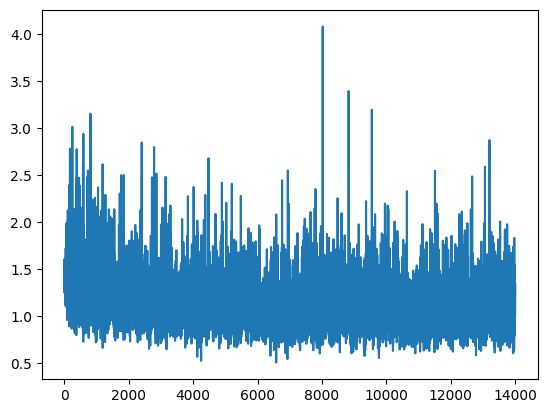

In [16]:
plt.plot(train_losses)

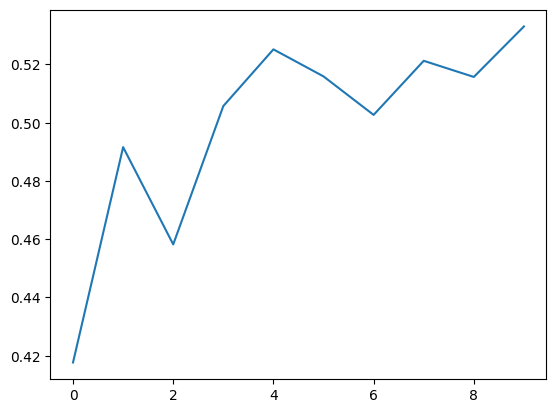

In [17]:
plt.plot(test_accuracy)

In [20]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [19]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 2985/5600 (0.5330)
{'acc_detail': tensor([0.6943, 0.3421, 0.6893, 0.4064], device='cuda:0'),
 'acc_unweighted': tensor(0.5330, device='cuda:0'),
 'acc_weighted': tensor(0.5330, device='cuda:0'),
 'f1s_detail': tensor([0.6597, 0.4191, 0.6178, 0.4003], device='cuda:0'),
 'f1s_unweighted': tensor(0.5242, device='cuda:0'),
 'f1s_weighted': tensor(0.5242, device='cuda:0'),
 'precision_detail': tensor([0.6283, 0.5406, 0.5597, 0.3943], device='cuda:0'),
 'recall_detail': tensor([0.6943, 0.3421, 0.6893, 0.4064], device='cuda:0'),
 'rocauc': tensor(0.8057, device='cuda:0'),
 'rocauc_detail': tensor([0.8732, 0.7980, 0.8432, 0.7083], device='cuda:0'),
 'uar': tensor(0.5330, device='cuda:0'),
 'wap': tensor(0.5308, device='cuda:0')}


tensor([[972,  68,  48, 312],
        [ 39, 479, 503, 379],
        [ 54, 198, 965, 183],
        [482, 141, 208, 569]], device='cuda:0')

In [21]:
model_path = '../models_esd4/esd4_m13sinc_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [22]:
n_epoch = 10
n_epoch2 = 50
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_esd4/esd4_m13sinc_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                               | 0.001142857142857143/50 [00:00<4:59:44, 359.70s/it]

Train Epoch: 11 [0/22400 (0%)]	Loss: 1.111890
Mem before-during-after: 20777472 1701718016 21721600


  0%|                               | 0.023428571428571413/50 [00:09<5:45:10, 414.40s/it]

Train Epoch: 11 [640/22400 (3%)]	Loss: 0.983761
Mem before-during-after: 21770752 1608949760 21721600


  0%|                               | 0.046857142857142785/50 [00:18<5:29:47, 396.13s/it]

Train Epoch: 11 [1280/22400 (6%)]	Loss: 1.078851
Mem before-during-after: 21721600 1747099136 21721600


  0%|                                | 0.06971428571428559/50 [00:27<5:27:46, 393.87s/it]

Train Epoch: 11 [1920/22400 (9%)]	Loss: 1.177669
Mem before-during-after: 21721600 1647569408 21721600


  0%|                                | 0.09199999999999982/50 [00:36<5:46:49, 416.95s/it]

Train Epoch: 11 [2560/22400 (11%)]	Loss: 1.011795
Mem before-during-after: 21721600 1747033600 21721600


  0%|                                | 0.11485714285714262/50 [00:45<5:40:30, 409.56s/it]

Train Epoch: 11 [3200/22400 (14%)]	Loss: 0.998113
Mem before-during-after: 21902336 1747017216 21721600


  0%|                                | 0.13771428571428573/50 [00:54<5:40:41, 409.97s/it]

Train Epoch: 11 [3840/22400 (17%)]	Loss: 1.166737
Mem before-during-after: 21721600 1702057984 21721600


  0%|                                | 0.16114285714285767/50 [01:03<5:21:31, 387.07s/it]

Train Epoch: 11 [4480/22400 (20%)]	Loss: 0.892239
Mem before-during-after: 21721600 1745985024 21721600


  0%|                                | 0.18342857142857244/50 [01:12<5:41:47, 411.67s/it]

Train Epoch: 11 [5120/22400 (23%)]	Loss: 1.024991
Mem before-during-after: 21721600 1745985024 21721600


  0%|▏                               | 0.20685714285714438/50 [01:21<5:18:27, 383.74s/it]

Train Epoch: 11 [5760/22400 (26%)]	Loss: 0.932304
Mem before-during-after: 21721600 1746050560 21721600


  0%|▏                               | 0.22914285714285915/50 [01:30<5:38:32, 408.13s/it]

Train Epoch: 11 [6400/22400 (29%)]	Loss: 1.353692
Mem before-during-after: 21721600 1621193216 21721600


  1%|▏                                | 0.2520000000000024/50 [01:39<5:45:50, 417.11s/it]

Train Epoch: 11 [7040/22400 (31%)]	Loss: 0.822183
Mem before-during-after: 21721600 1745985024 21721600


  1%|▏                                | 0.2754285714285732/50 [01:48<5:25:58, 393.34s/it]

Train Epoch: 11 [7680/22400 (34%)]	Loss: 1.001525
Mem before-during-after: 21721600 1691778560 21721600


  1%|▏                                | 0.2977142857142869/50 [01:57<5:42:47, 413.82s/it]

Train Epoch: 11 [8320/22400 (37%)]	Loss: 0.908309
Mem before-during-after: 21721600 1745952256 21721600


  1%|▏                                | 0.3211428571428577/50 [02:06<5:21:52, 388.74s/it]

Train Epoch: 11 [8960/22400 (40%)]	Loss: 1.445397
Mem before-during-after: 21721600 1746812416 21721600


  1%|▏                               | 0.34342857142857136/50 [02:15<5:40:20, 411.23s/it]

Train Epoch: 11 [9600/22400 (43%)]	Loss: 0.795181
Mem before-during-after: 21721600 1746812416 21721600


  1%|▏                                | 0.3662857142857136/50 [02:24<5:47:05, 419.58s/it]

Train Epoch: 11 [10240/22400 (46%)]	Loss: 0.690985
Mem before-during-after: 21721600 1746812416 21721600


  1%|▏                               | 0.38914285714285585/50 [02:33<5:36:42, 407.21s/it]

Train Epoch: 11 [10880/22400 (49%)]	Loss: 0.802509
Mem before-during-after: 21770752 1746746880 21721600


  1%|▎                               | 0.41257142857142665/50 [02:42<5:25:11, 393.47s/it]

Train Epoch: 11 [11520/22400 (51%)]	Loss: 0.991883
Mem before-during-after: 21770752 1746746880 21721600


  1%|▎                               | 0.43485714285714033/50 [02:51<5:41:22, 413.24s/it]

Train Epoch: 11 [12160/22400 (54%)]	Loss: 0.693023
Mem before-during-after: 21721600 1746812416 21721600


  1%|▎                               | 0.45828571428571113/50 [03:00<5:17:04, 384.01s/it]

Train Epoch: 11 [12800/22400 (57%)]	Loss: 0.813663
Mem before-during-after: 21721600 1581788160 21721600


  1%|▎                                | 0.4811428571428534/50 [03:09<5:24:57, 393.74s/it]

Train Epoch: 11 [13440/22400 (60%)]	Loss: 1.522252
Mem before-during-after: 21721600 1593683456 21721600


  1%|▎                                | 0.5034285714285671/50 [03:18<5:37:07, 408.67s/it]

Train Epoch: 11 [14080/22400 (63%)]	Loss: 1.000803
Mem before-during-after: 21721600 1636421120 21721600


  1%|▎                                | 0.5262857142857094/50 [03:27<5:39:44, 412.03s/it]

Train Epoch: 11 [14720/22400 (66%)]	Loss: 0.543658
Mem before-during-after: 21721600 1745985024 21721600


  1%|▎                                | 0.5497142857142802/50 [03:36<5:18:40, 386.66s/it]

Train Epoch: 11 [15360/22400 (69%)]	Loss: 0.813072
Mem before-during-after: 21721600 1745985024 21721600


  1%|▍                                | 0.5719999999999938/50 [03:45<5:38:06, 410.43s/it]

Train Epoch: 11 [16000/22400 (71%)]	Loss: 0.864955
Mem before-during-after: 21721600 1745919488 21721600


  1%|▍                                | 0.5954285714285646/50 [03:54<5:31:37, 402.74s/it]

Train Epoch: 11 [16640/22400 (74%)]	Loss: 0.704375
Mem before-during-after: 21721600 1745985024 21721600


  1%|▍                                | 0.6177142857142783/50 [04:03<5:43:42, 417.60s/it]

Train Epoch: 11 [17280/22400 (77%)]	Loss: 1.336051
Mem before-during-after: 21721600 1674919424 21721600


  1%|▍                                | 0.6405714285714206/50 [04:12<5:43:38, 417.72s/it]

Train Epoch: 11 [17920/22400 (80%)]	Loss: 1.032271
Mem before-during-after: 21721600 1746259456 21721600


  1%|▍                                | 0.6634285714285628/50 [04:21<5:41:35, 415.43s/it]

Train Epoch: 11 [18560/22400 (83%)]	Loss: 0.816664
Mem before-during-after: 21721600 1745952256 21721600


  1%|▍                                | 0.6868571428571336/50 [04:30<5:19:14, 388.42s/it]

Train Epoch: 11 [19200/22400 (86%)]	Loss: 1.176900
Mem before-during-after: 21721600 1745952256 21721600


  1%|▍                                | 0.7091428571428473/50 [04:39<5:42:28, 416.89s/it]

Train Epoch: 11 [19840/22400 (89%)]	Loss: 0.766945
Mem before-during-after: 21721600 1745985024 21721600


  1%|▍                                | 0.7325714285714181/50 [04:48<5:19:01, 388.53s/it]

Train Epoch: 11 [20480/22400 (91%)]	Loss: 1.255921
Mem before-during-after: 21721600 1746259456 21721600


  2%|▍                                | 0.7554285714285603/50 [04:57<5:22:04, 392.41s/it]

Train Epoch: 11 [21120/22400 (94%)]	Loss: 0.851216
Mem before-during-after: 21721600 1745985024 21721600


  2%|▌                                | 0.7782857142857026/50 [05:06<5:25:10, 396.38s/it]

Train Epoch: 11 [21760/22400 (97%)]	Loss: 0.958900
Mem before-during-after: 21721600 1745952256 21721600


  2%|▋                                | 0.9999999999999823/50 [06:20<4:28:06, 328.30s/it]


Test Epoch: 11	Accuracy: 3132/5600 (56%)

saved model: ../models_esd4/esd4_m13sinc_best_11epoch.pt


  2%|▋                                | 1.0011428571428396/50 [06:21<4:32:20, 333.50s/it]

Train Epoch: 12 [0/22400 (0%)]	Loss: 1.103162
Mem before-during-after: 21720576 1744920064 21721600


  2%|▋                                | 1.0239999999999863/50 [06:30<5:16:14, 387.42s/it]

Train Epoch: 12 [640/22400 (3%)]	Loss: 1.070715
Mem before-during-after: 21721600 1745919488 21721600


  2%|▋                                 | 1.046857142857133/50 [06:39<5:20:08, 392.38s/it]

Train Epoch: 12 [1280/22400 (6%)]	Loss: 0.918260
Mem before-during-after: 21721600 1747009024 21770752


  2%|▋                                | 1.0697142857142796/50 [06:48<5:11:57, 382.53s/it]

Train Epoch: 12 [1920/22400 (9%)]	Loss: 0.909430
Mem before-during-after: 21721600 1593092096 21803520


  2%|▋                                | 1.0925714285714263/50 [06:57<5:21:00, 393.81s/it]

Train Epoch: 12 [2560/22400 (11%)]	Loss: 1.251609
Mem before-during-after: 21721600 1718787072 21721600


  2%|▋                                | 1.1148571428571443/50 [07:06<5:37:44, 414.54s/it]

Train Epoch: 12 [3200/22400 (14%)]	Loss: 0.717710
Mem before-during-after: 21721600 1745985024 21721600


  2%|▊                                 | 1.137714285714291/50 [07:15<5:38:21, 415.49s/it]

Train Epoch: 12 [3840/22400 (17%)]	Loss: 0.950288
Mem before-during-after: 21721600 1690697216 21967872


  2%|▊                                | 1.1611428571428664/50 [07:24<5:14:23, 386.24s/it]

Train Epoch: 12 [4480/22400 (20%)]	Loss: 0.592151
Mem before-during-after: 21770752 1745919488 21721600


  2%|▊                                 | 1.184000000000013/50 [07:33<5:19:47, 393.06s/it]

Train Epoch: 12 [5120/22400 (23%)]	Loss: 1.079169
Mem before-during-after: 22324224 1744920064 21721600


  2%|▊                                 | 1.206285714285731/50 [07:42<5:43:57, 422.95s/it]

Train Epoch: 12 [5760/22400 (26%)]	Loss: 0.842859
Mem before-during-after: 21721600 1744920064 21721600


  2%|▊                                | 1.2291428571428777/50 [07:50<5:31:56, 408.38s/it]

Train Epoch: 12 [6400/22400 (29%)]	Loss: 0.647362
Mem before-during-after: 21721600 1744870912 21721600


  3%|▊                                 | 1.252571428571453/50 [08:00<5:17:35, 390.90s/it]

Train Epoch: 12 [7040/22400 (31%)]	Loss: 0.996964
Mem before-during-after: 21721600 1744936448 21721600


  3%|▊                                | 1.2754285714285998/50 [08:09<5:15:58, 389.09s/it]

Train Epoch: 12 [7680/22400 (34%)]	Loss: 0.880627
Mem before-during-after: 21721600 1744903680 21721600


  3%|▊                                | 1.2982857142857465/50 [08:17<5:10:06, 382.05s/it]

Train Epoch: 12 [8320/22400 (37%)]	Loss: 1.017809
Mem before-during-after: 21721600 1744936448 21721600


  3%|▊                                | 1.3211428571428931/50 [08:26<5:11:44, 384.24s/it]

Train Epoch: 12 [8960/22400 (40%)]	Loss: 0.863134
Mem before-during-after: 21721600 1744920064 21721600


  3%|▉                                | 1.3440000000000398/50 [08:36<5:16:06, 389.80s/it]

Train Epoch: 12 [9600/22400 (43%)]	Loss: 1.034703
Mem before-during-after: 21721600 1744936448 21721600


  3%|▉                                | 1.3668571428571865/50 [08:45<5:21:13, 396.30s/it]

Train Epoch: 12 [10240/22400 (46%)]	Loss: 0.833175
Mem before-during-after: 21721600 1744920064 21770752


  3%|▉                                | 1.3897142857143332/50 [08:54<5:12:47, 386.07s/it]

Train Epoch: 12 [10880/22400 (49%)]	Loss: 0.742650
Mem before-during-after: 21721600 1744870912 21721600


  3%|▉                                | 1.4120000000000512/50 [09:02<5:32:28, 410.56s/it]

Train Epoch: 12 [11520/22400 (51%)]	Loss: 0.764504
Mem before-during-after: 21721600 1744870912 21721600


  3%|▉                                 | 1.434857142857198/50 [09:11<5:33:46, 412.36s/it]

Train Epoch: 12 [12160/22400 (54%)]	Loss: 1.093061
Mem before-during-after: 22213120 1744870912 21721600


  3%|▉                                | 1.4577142857143446/50 [09:21<5:44:24, 425.69s/it]

Train Epoch: 12 [12800/22400 (57%)]	Loss: 0.868180
Mem before-during-after: 21721600 1744903680 21721600


  3%|▉                                | 1.4805714285714913/50 [09:30<5:41:09, 421.88s/it]

Train Epoch: 12 [13440/22400 (60%)]	Loss: 0.801544
Mem before-during-after: 21721600 1744903680 21721600


  3%|▉                                | 1.5040000000000666/50 [09:39<5:17:11, 392.44s/it]

Train Epoch: 12 [14080/22400 (63%)]	Loss: 0.823759
Mem before-during-after: 21721600 1744936448 21721600


  3%|█                                | 1.5268571428572133/50 [09:48<5:09:36, 383.24s/it]

Train Epoch: 12 [14720/22400 (66%)]	Loss: 1.330516
Mem before-during-after: 21721600 1744870912 21721600


  3%|█                                  | 1.54971428571436/50 [09:57<5:25:14, 402.78s/it]

Train Epoch: 12 [15360/22400 (69%)]	Loss: 0.457992
Mem before-during-after: 21721600 1744936448 21721600


  3%|█                                | 1.5725714285715067/50 [10:06<5:20:25, 397.00s/it]

Train Epoch: 12 [16000/22400 (71%)]	Loss: 0.900200
Mem before-during-after: 21721600 1744870912 21721600


  3%|█                                | 1.5948571428572247/50 [10:15<5:32:43, 412.42s/it]

Train Epoch: 12 [16640/22400 (74%)]	Loss: 0.710976
Mem before-during-after: 21721600 1744903680 21721600


  3%|█▏                                  | 1.6182857142858/50 [10:24<5:19:47, 396.58s/it]

Train Epoch: 12 [17280/22400 (77%)]	Loss: 0.764044
Mem before-during-after: 21721600 1744936448 21721600


  3%|█                                 | 1.640571428571518/50 [10:33<5:32:29, 412.52s/it]

Train Epoch: 12 [17920/22400 (80%)]	Loss: 0.998012
Mem before-during-after: 21721600 1744870912 21721600


  3%|█                                | 1.6640000000000934/50 [10:42<5:08:36, 383.08s/it]

Train Epoch: 12 [18560/22400 (83%)]	Loss: 0.606128
Mem before-during-after: 21721600 1744903680 21721600


  3%|█▏                                 | 1.68685714285724/50 [10:51<5:15:23, 391.68s/it]

Train Epoch: 12 [19200/22400 (86%)]	Loss: 0.949686
Mem before-during-after: 21721600 1718092288 21721600


  3%|█▏                               | 1.7097142857143868/50 [11:00<5:07:20, 381.86s/it]

Train Epoch: 12 [19840/22400 (89%)]	Loss: 1.312252
Mem before-during-after: 21721600 1583207424 21721600


  3%|█▏                               | 1.7320000000001048/50 [11:09<5:33:37, 414.71s/it]

Train Epoch: 12 [20480/22400 (91%)]	Loss: 0.951234
Mem before-during-after: 21721600 1744936448 21721600


  4%|█▏                               | 1.7554285714286801/50 [11:18<5:15:55, 392.91s/it]

Train Epoch: 12 [21120/22400 (94%)]	Loss: 1.134268
Mem before-during-after: 21721600 1744936448 21721600


  4%|█▏                               | 1.7782857142858268/50 [11:27<5:07:29, 382.60s/it]

Train Epoch: 12 [21760/22400 (97%)]	Loss: 0.626339
Mem before-during-after: 21721600 1745157632 21721600


  4%|█▎                               | 2.0000000000001497/50 [12:41<4:21:03, 326.32s/it]


Test Epoch: 12	Accuracy: 3260/5600 (58%)

saved model: ../models_esd4/esd4_m13sinc_best_12epoch.pt


  4%|█▎                               | 2.0011428571430065/50 [12:41<4:27:10, 333.99s/it]

Train Epoch: 13 [0/22400 (0%)]	Loss: 1.106633
Mem before-during-after: 21720576 1744920064 21721600


  4%|█▎                               | 2.0240000000001444/50 [12:50<5:11:04, 389.04s/it]

Train Epoch: 13 [640/22400 (3%)]	Loss: 1.008208
Mem before-during-after: 21721600 1747000832 21721600


  4%|█▍                                | 2.046857142857282/50 [12:59<5:15:29, 394.74s/it]

Train Epoch: 13 [1280/22400 (6%)]	Loss: 1.101448
Mem before-during-after: 21721600 1747000832 21721600


  4%|█▍                                 | 2.06971428571442/50 [13:08<5:13:29, 392.43s/it]

Train Epoch: 13 [1920/22400 (9%)]	Loss: 0.811587
Mem before-during-after: 21721600 1747000832 21721600


  4%|█▍                               | 2.0925714285715578/50 [13:17<5:10:06, 388.38s/it]

Train Epoch: 13 [2560/22400 (11%)]	Loss: 0.778529
Mem before-during-after: 21721600 1747000832 21721600


  4%|█▍                               | 2.1154285714286956/50 [13:26<5:06:11, 383.66s/it]

Train Epoch: 13 [3200/22400 (14%)]	Loss: 0.772153
Mem before-during-after: 21721600 1745968640 21770752


  4%|█▍                                | 2.137714285714405/50 [13:35<5:23:41, 405.77s/it]

Train Epoch: 13 [3840/22400 (17%)]	Loss: 1.308146
Mem before-during-after: 21721600 1555918336 22364672


  4%|█▍                               | 2.1605714285715427/50 [13:44<5:25:47, 408.61s/it]

Train Epoch: 13 [4480/22400 (20%)]	Loss: 0.775840
Mem before-during-after: 21721600 1745985024 21721600


  4%|█▍                                | 2.184000000000109/50 [13:53<5:19:14, 400.59s/it]

Train Epoch: 13 [5120/22400 (23%)]	Loss: 0.876089
Mem before-during-after: 21721600 1745985024 21721600


  4%|█▍                               | 2.2068571428572468/50 [14:02<5:09:52, 389.02s/it]

Train Epoch: 13 [5760/22400 (26%)]	Loss: 0.793248
Mem before-during-after: 21721600 1745985024 21721600


  4%|█▍                               | 2.2297142857143846/50 [14:11<5:11:38, 391.44s/it]

Train Epoch: 13 [6400/22400 (29%)]	Loss: 1.233157
Mem before-during-after: 21721600 1729269248 21754368


  5%|█▌                                | 2.252000000000094/50 [14:20<5:27:36, 411.67s/it]

Train Epoch: 13 [7040/22400 (31%)]	Loss: 0.920766
Mem before-during-after: 21721600 1745952256 21721600


  5%|█▌                                 | 2.27542857142866/50 [14:29<5:08:59, 388.47s/it]

Train Epoch: 13 [7680/22400 (34%)]	Loss: 0.797541
Mem before-during-after: 21754368 1745968640 21770752


  5%|█▌                                | 2.298285714285798/50 [14:38<5:11:20, 391.61s/it]

Train Epoch: 13 [8320/22400 (37%)]	Loss: 0.913807
Mem before-during-after: 21770752 1638860288 21949952


  5%|█▌                                | 2.321142857142936/50 [14:47<5:16:20, 398.09s/it]

Train Epoch: 13 [8960/22400 (40%)]	Loss: 0.684750
Mem before-during-after: 21721600 1555432960 21721600


  5%|█▌                               | 2.3440000000000736/50 [14:56<5:16:36, 398.62s/it]

Train Epoch: 13 [9600/22400 (43%)]	Loss: 0.916069
Mem before-during-after: 21721600 1745952256 21721600


  5%|█▌                                | 2.366285714285783/50 [15:05<5:42:44, 431.73s/it]

Train Epoch: 13 [10240/22400 (46%)]	Loss: 0.865103
Mem before-during-after: 21721600 1745985024 21721600


  5%|█▋                                | 2.389714285714349/50 [15:14<5:13:46, 395.42s/it]

Train Epoch: 13 [10880/22400 (49%)]	Loss: 1.310756
Mem before-during-after: 21721600 1745985024 21721600


  5%|█▌                               | 2.4120000000000585/50 [15:23<5:26:00, 411.04s/it]

Train Epoch: 13 [11520/22400 (51%)]	Loss: 0.627376
Mem before-during-after: 21721600 1745985024 21721600


  5%|█▋                                | 2.435428571428625/50 [15:32<5:10:14, 391.36s/it]

Train Epoch: 13 [12160/22400 (54%)]	Loss: 1.039670
Mem before-during-after: 21770752 1702053888 21721600


  5%|█▌                               | 2.4582857142857626/50 [15:41<5:11:59, 393.75s/it]

Train Epoch: 13 [12800/22400 (57%)]	Loss: 1.049724
Mem before-during-after: 21721600 1745985024 21721600


  5%|█▋                               | 2.4811428571429004/50 [15:50<5:07:58, 388.87s/it]

Train Epoch: 13 [13440/22400 (60%)]	Loss: 0.892270
Mem before-during-after: 21721600 1555893760 22364672


  5%|█▋                               | 2.5034285714286098/50 [15:59<5:30:43, 417.78s/it]

Train Epoch: 13 [14080/22400 (63%)]	Loss: 1.032955
Mem before-during-after: 21721600 1745952256 21721600


  5%|█▋                                | 2.526857142857176/50 [16:08<5:11:05, 393.18s/it]

Train Epoch: 13 [14720/22400 (66%)]	Loss: 0.842284
Mem before-during-after: 21721600 1745985024 21721600


  5%|█▋                               | 2.5491428571428854/50 [16:17<5:17:40, 401.69s/it]

Train Epoch: 13 [15360/22400 (69%)]	Loss: 0.843673
Mem before-during-after: 21770752 1555875328 21721600


  5%|█▋                                | 2.572000000000023/50 [16:26<5:25:21, 411.61s/it]

Train Epoch: 13 [16000/22400 (71%)]	Loss: 0.877402
Mem before-during-after: 21721600 1745985024 21721600


  5%|█▊                                | 2.594857142857161/50 [16:35<5:23:09, 409.02s/it]

Train Epoch: 13 [16640/22400 (74%)]	Loss: 1.062143
Mem before-during-after: 21721600 1746259456 21721600


  5%|█▋                               | 2.6177142857142988/50 [16:44<5:25:33, 412.26s/it]

Train Epoch: 13 [17280/22400 (77%)]	Loss: 0.939445
Mem before-during-after: 21721600 1745985024 21721600


  5%|█▊                                | 2.641142857142865/50 [16:53<5:09:01, 391.52s/it]

Train Epoch: 13 [17920/22400 (80%)]	Loss: 0.897615
Mem before-during-after: 21770752 1745919488 21721600


  5%|█▊                               | 2.6634285714285744/50 [17:02<5:26:47, 414.21s/it]

Train Epoch: 13 [18560/22400 (83%)]	Loss: 0.835371
Mem before-during-after: 21721600 1745985024 21721600


  5%|█▊                               | 2.6868571428571406/50 [17:11<5:07:10, 389.53s/it]

Train Epoch: 13 [19200/22400 (86%)]	Loss: 0.911812
Mem before-during-after: 21721600 1745952256 21721600


  5%|█▊                               | 2.7097142857142784/50 [17:20<5:08:31, 391.44s/it]

Train Epoch: 13 [19840/22400 (89%)]	Loss: 1.015862
Mem before-during-after: 21754368 1718107648 21754368


  5%|█▊                                | 2.732571428571416/50 [17:29<5:06:57, 389.64s/it]

Train Epoch: 13 [20480/22400 (91%)]	Loss: 0.924280
Mem before-during-after: 21721600 1745985024 21721600


  6%|█▊                               | 2.7548571428571256/50 [17:38<5:25:34, 413.47s/it]

Train Epoch: 13 [21120/22400 (94%)]	Loss: 1.102572
Mem before-during-after: 21721600 1745952256 21721600


  6%|█▉                                | 2.778285714285692/50 [17:47<5:11:09, 395.37s/it]

Train Epoch: 13 [21760/22400 (97%)]	Loss: 0.992973
Mem before-during-after: 21721600 1745985024 21721600


  6%|█▉                               | 2.9999999999999285/50 [19:02<4:13:20, 323.41s/it]


Test Epoch: 13	Accuracy: 3286/5600 (59%)

saved model: ../models_esd4/esd4_m13sinc_best_13epoch.pt


  6%|█▉                               | 3.0011428571427854/50 [19:02<4:20:48, 332.96s/it]

Train Epoch: 14 [0/22400 (0%)]	Loss: 0.934458
Mem before-during-after: 21720576 1744920064 21721600


  6%|█▉                               | 3.0234285714284947/50 [19:11<5:26:24, 416.91s/it]

Train Epoch: 14 [640/22400 (3%)]	Loss: 1.247714
Mem before-during-after: 21770752 1745919488 21721600


  6%|██                                | 3.046857142857061/50 [19:20<5:14:26, 401.82s/it]

Train Epoch: 14 [1280/22400 (6%)]	Loss: 0.674964
Mem before-during-after: 21721600 1746542080 21721600


  6%|██                                | 3.069714285714199/50 [19:29<5:13:20, 400.61s/it]

Train Epoch: 14 [1920/22400 (9%)]	Loss: 0.968444
Mem before-during-after: 21721600 1744903680 21721600


  6%|██                               | 3.0925714285713366/50 [19:38<5:06:22, 391.90s/it]

Train Epoch: 14 [2560/22400 (11%)]	Loss: 1.288674
Mem before-during-after: 21721600 1648247296 21721600


  6%|██                               | 3.1154285714284744/50 [19:47<5:05:53, 391.46s/it]

Train Epoch: 14 [3200/22400 (14%)]	Loss: 1.510719
Mem before-during-after: 21770752 1744870912 21721600


  6%|██▏                               | 3.138285714285612/50 [19:56<5:44:17, 440.82s/it]

Train Epoch: 14 [3840/22400 (17%)]	Loss: 0.775719
Mem before-during-after: 21721600 1744936448 21721600


  6%|██                               | 3.1605714285713216/50 [20:05<5:24:20, 415.48s/it]

Train Epoch: 14 [4480/22400 (20%)]	Loss: 0.722523
Mem before-during-after: 21721600 1744936448 21721600


  6%|██▏                               | 3.183999999999888/50 [20:14<5:06:44, 393.13s/it]

Train Epoch: 14 [5120/22400 (23%)]	Loss: 0.873097
Mem before-during-after: 21721600 1745210880 21721600


  6%|██                               | 3.2068571428570256/50 [20:23<5:08:35, 395.69s/it]

Train Epoch: 14 [5760/22400 (26%)]	Loss: 1.062724
Mem before-during-after: 21721600 1744936448 21721600


  6%|██▏                              | 3.2297142857141634/50 [20:32<5:03:30, 389.35s/it]

Train Epoch: 14 [6400/22400 (29%)]	Loss: 0.851633
Mem before-during-after: 21721600 1608677376 21721600


  7%|██▏                               | 3.252571428571301/50 [20:41<5:07:14, 394.34s/it]

Train Epoch: 14 [7040/22400 (31%)]	Loss: 0.776361
Mem before-during-after: 21721600 1744903680 21721600


  7%|██▏                               | 3.275428571428439/50 [20:50<5:07:54, 395.40s/it]

Train Epoch: 14 [7680/22400 (34%)]	Loss: 0.969352
Mem before-during-after: 21721600 1744903680 21721600


  7%|██▏                               | 3.298285714285577/50 [20:59<5:07:45, 395.38s/it]

Train Epoch: 14 [8320/22400 (37%)]	Loss: 1.179158
Mem before-during-after: 21721600 1744936448 21721600


  7%|██▎                               | 3.320571428571286/50 [21:08<5:20:25, 411.86s/it]

Train Epoch: 14 [8960/22400 (40%)]	Loss: 0.890549
Mem before-during-after: 21721600 1744903680 21721600


  7%|██▏                              | 3.3439999999998524/50 [21:17<5:05:41, 393.11s/it]

Train Epoch: 14 [9600/22400 (43%)]	Loss: 0.999292
Mem before-during-after: 21721600 1744920064 21721600


  7%|██▏                              | 3.3668571428569902/50 [21:26<5:05:45, 393.40s/it]

Train Epoch: 14 [10240/22400 (46%)]	Loss: 0.997452
Mem before-during-after: 21770752 1744870912 21721600


  7%|██▎                               | 3.389714285714128/50 [21:35<4:57:41, 383.21s/it]

Train Epoch: 14 [10880/22400 (49%)]	Loss: 1.062378
Mem before-during-after: 21721600 1528184320 21721600


  7%|██▎                               | 3.412571428571266/50 [21:44<5:04:15, 391.86s/it]

Train Epoch: 14 [11520/22400 (51%)]	Loss: 0.813820
Mem before-during-after: 21721600 1744903680 21721600


  7%|██▎                              | 3.4354285714284036/50 [21:53<5:01:29, 388.49s/it]

Train Epoch: 14 [12160/22400 (54%)]	Loss: 0.922785
Mem before-during-after: 21721600 1744870912 21721600


  7%|██▎                              | 3.4582857142855414/50 [22:02<5:02:50, 390.42s/it]

Train Epoch: 14 [12800/22400 (57%)]	Loss: 0.945508
Mem before-during-after: 21721600 1744870912 21721600


  7%|██▎                              | 3.4811428571426792/50 [22:11<5:10:32, 400.55s/it]

Train Epoch: 14 [13440/22400 (60%)]	Loss: 0.831441
Mem before-during-after: 21721600 1744903680 21721600


  7%|██▍                               | 3.503999999999817/50 [22:20<5:00:46, 388.14s/it]

Train Epoch: 14 [14080/22400 (63%)]	Loss: 0.637843
Mem before-during-after: 21721600 1744936448 21721600


  7%|██▎                              | 3.5262857142855264/50 [22:29<5:18:54, 411.73s/it]

Train Epoch: 14 [14720/22400 (66%)]	Loss: 0.963704
Mem before-during-after: 21721600 1744936448 21721600


  7%|██▎                              | 3.5497142857140926/50 [22:38<5:03:19, 391.81s/it]

Train Epoch: 14 [15360/22400 (69%)]	Loss: 0.966491
Mem before-during-after: 21721600 1539450368 21721600


  7%|██▎                              | 3.5725714285712304/50 [22:47<5:01:39, 389.84s/it]

Train Epoch: 14 [16000/22400 (71%)]	Loss: 1.052185
Mem before-during-after: 21721600 1744903680 21721600


  7%|██▎                              | 3.5954285714283682/50 [22:56<5:00:17, 388.27s/it]

Train Epoch: 14 [16640/22400 (74%)]	Loss: 0.947022
Mem before-during-after: 21737984 1744920064 21721600


  7%|██▍                               | 3.618285714285506/50 [23:05<4:57:47, 385.22s/it]

Train Epoch: 14 [17280/22400 (77%)]	Loss: 0.868871
Mem before-during-after: 21721600 1745371648 22222336


  7%|██▍                               | 3.641142857142644/50 [23:14<4:59:32, 387.68s/it]

Train Epoch: 14 [17920/22400 (80%)]	Loss: 1.131337
Mem before-during-after: 21770752 1663311360 21878272


  7%|██▍                              | 3.6639999999997817/50 [23:23<5:03:05, 392.47s/it]

Train Epoch: 14 [18560/22400 (83%)]	Loss: 0.978540
Mem before-during-after: 21721600 1744920064 21721600


  7%|██▍                              | 3.6868571428569195/50 [23:32<4:54:06, 381.02s/it]

Train Epoch: 14 [19200/22400 (86%)]	Loss: 0.561389
Mem before-during-after: 21721600 1745703936 21721600


  7%|██▍                              | 3.7097142857140573/50 [23:41<5:03:07, 392.91s/it]

Train Epoch: 14 [19840/22400 (89%)]	Loss: 1.300874
Mem before-during-after: 21721600 1744936448 21721600


  7%|██▌                               | 3.732571428571195/50 [23:50<5:02:46, 392.65s/it]

Train Epoch: 14 [20480/22400 (91%)]	Loss: 0.808247
Mem before-during-after: 21721600 1744903680 21721600


  8%|██▍                              | 3.7548571428569044/50 [23:59<5:22:58, 419.04s/it]

Train Epoch: 14 [21120/22400 (94%)]	Loss: 0.684858
Mem before-during-after: 21721600 1744936448 21721600


  8%|██▍                              | 3.7782857142854707/50 [24:08<5:02:45, 393.01s/it]

Train Epoch: 14 [21760/22400 (97%)]	Loss: 0.926053
Mem before-during-after: 21721600 1745210880 21721600


  8%|██▋                              | 3.9999999999997073/50 [25:22<4:10:12, 326.37s/it]


Test Epoch: 14	Accuracy: 3333/5600 (60%)

saved model: ../models_esd4/esd4_m13sinc_best_14epoch.pt


  8%|██▋                               | 4.001142857142565/50 [25:23<4:18:44, 337.50s/it]

Train Epoch: 15 [0/22400 (0%)]	Loss: 0.915524
Mem before-during-after: 21720576 1744920064 21721600


  8%|██▊                                | 4.02399999999972/50 [25:32<4:58:15, 389.24s/it]

Train Epoch: 15 [640/22400 (3%)]	Loss: 0.741719
Mem before-during-after: 21770752 1745919488 21721600


  8%|██▊                               | 4.046857142856876/50 [25:41<4:57:48, 388.84s/it]

Train Epoch: 15 [1280/22400 (6%)]	Loss: 0.663202
Mem before-during-after: 21721600 1746968064 21721600


  8%|██▊                               | 4.069714285714031/50 [25:49<5:02:05, 394.63s/it]

Train Epoch: 15 [1920/22400 (9%)]	Loss: 0.716889
Mem before-during-after: 21721600 1747000832 21721600


  8%|██▊                               | 4.092571428571187/50 [25:58<4:57:04, 388.28s/it]

Train Epoch: 15 [2560/22400 (11%)]	Loss: 0.702145
Mem before-during-after: 21721600 1746968064 21721600


  8%|██▋                              | 4.1154285714283425/50 [26:07<4:57:11, 388.63s/it]

Train Epoch: 15 [3200/22400 (14%)]	Loss: 0.760550
Mem before-during-after: 21721600 1747000832 21721600


  8%|██▊                               | 4.138285714285498/50 [26:16<4:56:10, 387.47s/it]

Train Epoch: 15 [3840/22400 (17%)]	Loss: 0.646845
Mem before-during-after: 21721600 1745985024 21721600


  8%|██▊                               | 4.161142857142654/50 [26:25<4:55:40, 387.02s/it]

Train Epoch: 15 [4480/22400 (20%)]	Loss: 1.570806
Mem before-during-after: 21721600 1756458496 21721600


  8%|██▊                               | 4.183999999999809/50 [26:34<5:02:16, 395.85s/it]

Train Epoch: 15 [5120/22400 (23%)]	Loss: 0.770168
Mem before-during-after: 21721600 1745985024 21721600


  8%|██▊                               | 4.206857142856965/50 [26:43<5:00:16, 393.43s/it]

Train Epoch: 15 [5760/22400 (26%)]	Loss: 1.305531
Mem before-during-after: 21721600 1745952256 21721600


  8%|██▊                              | 4.2291428571426914/50 [26:52<5:17:39, 416.41s/it]

Train Epoch: 15 [6400/22400 (29%)]	Loss: 1.043166
Mem before-during-after: 21721600 1745985024 21721600


  9%|██▉                               | 4.252571428571276/50 [27:01<4:58:20, 391.30s/it]

Train Epoch: 15 [7040/22400 (31%)]	Loss: 1.224674
Mem before-during-after: 21721600 1745985024 21721600


  9%|██▊                              | 4.2754285714284315/50 [27:10<4:56:51, 389.54s/it]

Train Epoch: 15 [7680/22400 (34%)]	Loss: 1.150426
Mem before-during-after: 21721600 1745968640 21770752


  9%|██▉                               | 4.297714285714158/50 [27:19<5:15:56, 414.78s/it]

Train Epoch: 15 [8320/22400 (37%)]	Loss: 0.998075
Mem before-during-after: 21721600 1745952256 21721600


  9%|██▉                               | 4.321142857142743/50 [27:28<4:55:44, 388.46s/it]

Train Epoch: 15 [8960/22400 (40%)]	Loss: 0.847389
Mem before-during-after: 21721600 1745985024 21721600


  9%|██▉                               | 4.343999999999898/50 [27:37<4:57:02, 390.37s/it]

Train Epoch: 15 [9600/22400 (43%)]	Loss: 0.807135
Mem before-during-after: 21721600 1745985024 21721600


  9%|██▉                               | 4.366857142857054/50 [27:46<4:56:56, 390.43s/it]

Train Epoch: 15 [10240/22400 (46%)]	Loss: 0.885966
Mem before-during-after: 21721600 1745985024 21721600


  9%|██▉                               | 4.389714285714209/50 [27:55<4:57:55, 391.91s/it]

Train Epoch: 15 [10880/22400 (49%)]	Loss: 0.744200
Mem before-during-after: 21721600 1745968640 21770752


  9%|███                               | 4.412571428571365/50 [28:04<4:58:35, 393.00s/it]

Train Epoch: 15 [11520/22400 (51%)]	Loss: 0.730116
Mem before-during-after: 21721600 1745952256 21721600


  9%|███                                | 4.43542857142852/50 [28:13<4:54:10, 387.38s/it]

Train Epoch: 15 [12160/22400 (54%)]	Loss: 0.849427
Mem before-during-after: 21721600 1745919488 21721600


  9%|███                               | 4.458285714285676/50 [28:22<4:59:20, 394.37s/it]

Train Epoch: 15 [12800/22400 (57%)]	Loss: 0.639598
Mem before-during-after: 21721600 1745952256 21721600


  9%|███                               | 4.480571428571403/50 [28:31<5:24:41, 427.99s/it]

Train Epoch: 15 [13440/22400 (60%)]	Loss: 1.026951
Mem before-during-after: 21770752 1745919488 21721600


  9%|███                               | 4.503999999999987/50 [28:41<4:55:02, 389.11s/it]

Train Epoch: 15 [14080/22400 (63%)]	Loss: 0.809288
Mem before-during-after: 21721600 1745985024 21721600


  9%|███                               | 4.526857142857143/50 [28:50<4:50:26, 383.22s/it]

Train Epoch: 15 [14720/22400 (66%)]	Loss: 0.894500
Mem before-during-after: 21721600 1500644352 21721600


  9%|███                               | 4.549714285714298/50 [28:59<4:50:48, 383.91s/it]

Train Epoch: 15 [15360/22400 (69%)]	Loss: 0.950144
Mem before-during-after: 21721600 1745919488 21721600


  9%|███                               | 4.572000000000025/50 [29:08<5:15:12, 416.32s/it]

Train Epoch: 15 [16000/22400 (71%)]	Loss: 1.054379
Mem before-during-after: 21721600 1745985024 21721600


  9%|███                               | 4.595428571428609/50 [29:17<4:56:40, 392.03s/it]

Train Epoch: 15 [16640/22400 (74%)]	Loss: 1.150653
Mem before-during-after: 21721600 1745952256 21721600


  9%|███▏                              | 4.618285714285765/50 [29:26<4:55:38, 390.86s/it]

Train Epoch: 15 [17280/22400 (77%)]	Loss: 0.651381
Mem before-during-after: 21721600 1745952256 21721600


  9%|███▏                              | 4.640571428571492/50 [29:35<5:16:55, 419.22s/it]

Train Epoch: 15 [17920/22400 (80%)]	Loss: 1.003881
Mem before-during-after: 21721600 1745952256 21721600


  9%|███▏                              | 4.664000000000076/50 [29:44<5:03:53, 402.20s/it]

Train Epoch: 15 [18560/22400 (83%)]	Loss: 1.574151
Mem before-during-after: 21721600 1538631168 21721600


  9%|███▏                              | 4.686857142857232/50 [29:53<4:56:21, 392.42s/it]

Train Epoch: 15 [19200/22400 (86%)]	Loss: 1.122194
Mem before-during-after: 21721600 1745952256 21721600


  9%|███▏                              | 4.709142857142958/50 [30:02<5:05:54, 405.25s/it]

Train Epoch: 15 [19840/22400 (89%)]	Loss: 0.874251
Mem before-during-after: 21721600 1745985024 21721600


  9%|███▏                              | 4.732571428571543/50 [30:11<4:59:33, 397.05s/it]

Train Epoch: 15 [20480/22400 (91%)]	Loss: 0.761003
Mem before-during-after: 21721600 1745952256 21721600


 10%|███▏                             | 4.7548571428572695/50 [30:20<5:10:05, 411.21s/it]

Train Epoch: 15 [21120/22400 (94%)]	Loss: 0.750363
Mem before-during-after: 21770752 1745919488 21721600


 10%|███▏                              | 4.778285714285854/50 [30:29<4:49:59, 384.75s/it]

Train Epoch: 15 [21760/22400 (97%)]	Loss: 0.937392
Mem before-during-after: 21770752 1718762496 21721600


 10%|███▍                              | 5.000000000000263/50 [31:43<4:37:25, 369.89s/it]


Test Epoch: 15	Accuracy: 3335/5600 (60%)

saved model: ../models_esd4/esd4_m13sinc_best_15epoch.pt


 10%|███▍                              | 5.001142857143121/50 [31:44<4:29:12, 358.96s/it]

Train Epoch: 16 [0/22400 (0%)]	Loss: 1.046107
Mem before-during-after: 21720576 1744920064 21721600


 10%|███▍                              | 5.024000000000276/50 [31:53<4:56:19, 395.31s/it]

Train Epoch: 16 [640/22400 (3%)]	Loss: 0.831831
Mem before-during-after: 21770752 1745919488 21721600


 10%|███▍                              | 5.046857142857432/50 [32:02<4:52:36, 390.55s/it]

Train Epoch: 16 [1280/22400 (6%)]	Loss: 0.907495
Mem before-during-after: 21721600 1746607616 21721600


 10%|███▎                             | 5.0691428571431585/50 [32:10<5:13:34, 418.73s/it]

Train Epoch: 16 [1920/22400 (9%)]	Loss: 0.550899
Mem before-during-after: 21721600 1747017216 21770752


 10%|███▍                              | 5.092000000000314/50 [32:19<5:07:48, 411.26s/it]

Train Epoch: 16 [2560/22400 (11%)]	Loss: 0.630061
Mem before-during-after: 21721600 1746087424 21721600


 10%|███▌                               | 5.11485714285747/50 [32:28<5:14:25, 420.31s/it]

Train Epoch: 16 [3200/22400 (14%)]	Loss: 0.769047
Mem before-during-after: 21721600 1746120192 21787136


 10%|███▍                              | 5.138285714286054/50 [32:38<4:51:09, 389.42s/it]

Train Epoch: 16 [3840/22400 (17%)]	Loss: 0.561815
Mem before-during-after: 21721600 1744870912 21721600


 10%|███▌                               | 5.16114285714321/50 [32:47<4:51:09, 389.61s/it]

Train Epoch: 16 [4480/22400 (20%)]	Loss: 1.014209
Mem before-during-after: 21721600 1745035264 21721600


 10%|███▌                              | 5.183428571428936/50 [32:55<5:08:22, 412.84s/it]

Train Epoch: 16 [5120/22400 (23%)]	Loss: 0.905941
Mem before-during-after: 21721600 1745010176 21721600


 10%|███▌                              | 5.206857142857521/50 [33:05<4:45:52, 382.92s/it]

Train Epoch: 16 [5760/22400 (26%)]	Loss: 1.098474
Mem before-during-after: 21950976 1745010176 21721600


 10%|███▌                              | 5.229714285714676/50 [33:14<4:50:56, 389.91s/it]

Train Epoch: 16 [6400/22400 (29%)]	Loss: 1.123345
Mem before-during-after: 21721600 1745010176 21721600


 11%|███▌                              | 5.252571428571832/50 [33:23<4:51:52, 391.36s/it]

Train Epoch: 16 [7040/22400 (31%)]	Loss: 0.956812
Mem before-during-after: 21721600 1745026560 21721600


 11%|███▍                             | 5.2754285714289875/50 [33:32<4:50:57, 390.33s/it]

Train Epoch: 16 [7680/22400 (34%)]	Loss: 0.995683
Mem before-during-after: 21721600 1745281536 21721600


 11%|███▌                              | 5.298285714286143/50 [33:41<4:53:04, 393.38s/it]

Train Epoch: 16 [8320/22400 (37%)]	Loss: 0.891485
Mem before-during-after: 21721600 1745522176 21721600


 11%|███▌                              | 5.321142857143299/50 [33:50<4:45:11, 382.99s/it]

Train Epoch: 16 [8960/22400 (40%)]	Loss: 0.670570
Mem before-during-after: 21721600 1745702400 22323712


 11%|███▋                              | 5.344000000000454/50 [33:59<4:46:26, 384.86s/it]

Train Epoch: 16 [9600/22400 (43%)]	Loss: 0.723880
Mem before-during-after: 21721600 1745522176 21721600


 11%|███▊                               | 5.36685714285761/50 [34:07<4:46:30, 385.15s/it]

Train Epoch: 16 [10240/22400 (46%)]	Loss: 0.995271
Mem before-during-after: 21721600 1745636864 22323712


 11%|███▋                              | 5.389714285714765/50 [34:16<4:50:16, 390.42s/it]

Train Epoch: 16 [10880/22400 (49%)]	Loss: 0.824591
Mem before-during-after: 21721600 1745522176 21721600


 11%|███▋                              | 5.412571428571921/50 [34:25<4:52:11, 393.20s/it]

Train Epoch: 16 [11520/22400 (51%)]	Loss: 1.084436
Mem before-during-after: 21721600 1745522176 21721600


 11%|███▋                              | 5.435428571429076/50 [34:34<4:44:29, 383.03s/it]

Train Epoch: 16 [12160/22400 (54%)]	Loss: 1.038881
Mem before-during-after: 21721600 1702585856 21721600


 11%|███▋                              | 5.458285714286232/50 [34:43<4:56:56, 400.01s/it]

Train Epoch: 16 [12800/22400 (57%)]	Loss: 0.698442
Mem before-during-after: 21721600 1745522176 21721600


 11%|███▋                              | 5.481142857143388/50 [34:53<4:58:38, 402.50s/it]

Train Epoch: 16 [13440/22400 (60%)]	Loss: 1.082318
Mem before-during-after: 21721600 1745776128 21778944


 11%|███▋                              | 5.504000000000543/50 [35:02<4:44:04, 383.05s/it]

Train Epoch: 16 [14080/22400 (63%)]	Loss: 0.848095
Mem before-during-after: 21721600 1744920064 21770752


 11%|███▊                               | 5.52628571428627/50 [35:10<5:14:13, 423.93s/it]

Train Epoch: 16 [14720/22400 (66%)]	Loss: 1.138884
Mem before-during-after: 21721600 1744936448 21721600


 11%|███▊                              | 5.549714285714854/50 [35:19<4:49:24, 390.65s/it]

Train Epoch: 16 [15360/22400 (69%)]	Loss: 0.929123
Mem before-during-after: 21721600 1744936448 21721600


 11%|███▉                               | 5.57257142857201/50 [35:28<4:45:54, 386.12s/it]

Train Epoch: 16 [16000/22400 (71%)]	Loss: 0.868545
Mem before-during-after: 21721600 1744903680 21721600


 11%|███▊                              | 5.595428571429165/50 [35:37<4:52:05, 394.67s/it]

Train Epoch: 16 [16640/22400 (74%)]	Loss: 0.917728
Mem before-during-after: 21721600 1744903680 21721600


 11%|███▊                              | 5.618285714286321/50 [35:46<4:48:41, 390.28s/it]

Train Epoch: 16 [17280/22400 (77%)]	Loss: 0.760364
Mem before-during-after: 21721600 1744903680 21721600


 11%|███▋                             | 5.6411428571434765/50 [35:55<4:55:22, 399.53s/it]

Train Epoch: 16 [17920/22400 (80%)]	Loss: 1.285149
Mem before-during-after: 21721600 1744936448 21721600


 11%|███▊                              | 5.664000000000632/50 [36:04<4:50:40, 393.37s/it]

Train Epoch: 16 [18560/22400 (83%)]	Loss: 0.854148
Mem before-during-after: 21770752 1744870912 21721600


 11%|███▊                              | 5.686857142857788/50 [36:13<4:50:48, 393.77s/it]

Train Epoch: 16 [19200/22400 (86%)]	Loss: 1.352527
Mem before-during-after: 21721600 1594543616 21721600


 11%|███▉                              | 5.709142857143514/50 [36:22<5:06:39, 415.42s/it]

Train Epoch: 16 [19840/22400 (89%)]	Loss: 1.079386
Mem before-during-after: 21721600 1744903680 21721600


 11%|███▉                              | 5.732571428572099/50 [36:32<4:51:29, 395.08s/it]

Train Epoch: 16 [20480/22400 (91%)]	Loss: 1.001848
Mem before-during-after: 21721600 1744903680 21721600


 12%|███▉                              | 5.755428571429254/50 [36:40<4:44:43, 386.11s/it]

Train Epoch: 16 [21120/22400 (94%)]	Loss: 1.481317
Mem before-during-after: 21721600 1647694336 21721600


 12%|███▉                              | 5.777714285714981/50 [36:49<5:10:52, 421.78s/it]

Train Epoch: 16 [21760/22400 (97%)]	Loss: 0.741444
Mem before-during-after: 21721600 1744903680 21721600


 12%|████                              | 6.000000000000819/50 [38:04<3:57:01, 323.22s/it]


Test Epoch: 16	Accuracy: 3244/5600 (58%)



 12%|████                              | 6.001142857143677/50 [38:04<4:06:33, 336.23s/it]

Train Epoch: 17 [0/22400 (0%)]	Loss: 1.130505
Mem before-during-after: 21720576 1744920064 21721600


 12%|████                              | 6.023428571429403/50 [38:13<5:01:07, 410.85s/it]

Train Epoch: 17 [640/22400 (3%)]	Loss: 0.744995
Mem before-during-after: 21721600 1718746112 21721600


 12%|████                              | 6.046285714286559/50 [38:22<5:03:19, 414.06s/it]

Train Epoch: 17 [1280/22400 (6%)]	Loss: 0.641523
Mem before-during-after: 21721600 1747033600 21721600


 12%|████                             | 6.0691428571437145/50 [38:31<5:01:10, 411.34s/it]

Train Epoch: 17 [1920/22400 (9%)]	Loss: 0.954311
Mem before-during-after: 21721600 1747308032 21721600


 12%|████▎                              | 6.09200000000087/50 [38:40<5:08:01, 420.90s/it]

Train Epoch: 17 [2560/22400 (11%)]	Loss: 0.878077
Mem before-during-after: 21721600 1747033600 21721600


 12%|████                             | 6.1154285714294545/50 [38:50<4:42:38, 386.43s/it]

Train Epoch: 17 [3200/22400 (14%)]	Loss: 0.810242
Mem before-during-after: 22027776 1747017216 21721600


 12%|████▎                              | 6.13828571428661/50 [38:59<4:55:55, 404.80s/it]

Train Epoch: 17 [3840/22400 (17%)]	Loss: 0.765196
Mem before-during-after: 21721600 1747033600 21721600


 12%|████▏                             | 6.161142857143766/50 [39:08<4:44:35, 389.51s/it]

Train Epoch: 17 [4480/22400 (20%)]	Loss: 0.724236
Mem before-during-after: 21721600 1746968064 21721600


 12%|████▏                             | 6.184000000000921/50 [39:17<4:48:27, 395.00s/it]

Train Epoch: 17 [5120/22400 (23%)]	Loss: 0.884041
Mem before-during-after: 21721600 1747000832 21721600


 12%|████▏                             | 6.206857142858077/50 [39:26<4:43:44, 388.75s/it]

Train Epoch: 17 [5760/22400 (26%)]	Loss: 0.975851
Mem before-during-after: 21721600 1747000832 21721600


 12%|████▏                             | 6.229714285715232/50 [39:35<4:45:02, 390.74s/it]

Train Epoch: 17 [6400/22400 (29%)]	Loss: 0.513436
Mem before-during-after: 21754368 1747017216 21721600


 13%|████▎                             | 6.252571428572388/50 [39:44<4:46:22, 392.77s/it]

Train Epoch: 17 [7040/22400 (31%)]	Loss: 0.627163
Mem before-during-after: 21721600 1745985024 21721600


 13%|████▏                            | 6.2754285714295435/50 [39:53<4:41:14, 385.94s/it]

Train Epoch: 17 [7680/22400 (34%)]	Loss: 0.904681
Mem before-during-after: 21721600 1745952256 21721600


 13%|████▍                              | 6.29771428571527/50 [40:01<4:58:28, 409.78s/it]

Train Epoch: 17 [8320/22400 (37%)]	Loss: 1.647831
Mem before-during-after: 21721600 1702014464 21738496


 13%|████▎                             | 6.321142857143855/50 [40:11<4:45:35, 392.31s/it]

Train Epoch: 17 [8960/22400 (40%)]	Loss: 0.861907
Mem before-during-after: 21721600 1745952256 21721600


 13%|████▍                              | 6.34400000000101/50 [40:20<4:42:58, 388.92s/it]

Train Epoch: 17 [9600/22400 (43%)]	Loss: 0.611055
Mem before-during-after: 21721600 1745935872 21737984


 13%|████▎                             | 6.366857142858166/50 [40:29<4:50:13, 399.09s/it]

Train Epoch: 17 [10240/22400 (46%)]	Loss: 1.155984
Mem before-during-after: 21721600 1745985024 21721600


 13%|████▎                             | 6.389714285715321/50 [40:38<4:39:15, 384.21s/it]

Train Epoch: 17 [10880/22400 (49%)]	Loss: 0.721976
Mem before-during-after: 21721600 1745952256 21721600


 13%|████▎                             | 6.412571428572477/50 [40:47<4:42:47, 389.27s/it]

Train Epoch: 17 [11520/22400 (51%)]	Loss: 0.629637
Mem before-during-after: 21721600 1745985024 21721600


 13%|████▍                             | 6.435428571429632/50 [40:56<4:40:34, 386.42s/it]

Train Epoch: 17 [12160/22400 (54%)]	Loss: 0.996725
Mem before-during-after: 21721600 1745952256 21721600


 13%|████▍                             | 6.457714285715359/50 [41:05<4:59:19, 412.45s/it]

Train Epoch: 17 [12800/22400 (57%)]	Loss: 0.983552
Mem before-during-after: 21721600 1745985024 21721600


 13%|████▍                             | 6.481142857143944/50 [41:14<4:44:21, 392.05s/it]

Train Epoch: 17 [13440/22400 (60%)]	Loss: 0.634985
Mem before-during-after: 21721600 1746259456 21721600


 13%|████▍                             | 6.504000000001099/50 [41:23<4:46:42, 395.50s/it]

Train Epoch: 17 [14080/22400 (63%)]	Loss: 0.705262
Mem before-during-after: 21721600 1745952256 21721600


 13%|████▍                             | 6.526285714286826/50 [41:32<5:04:17, 419.97s/it]

Train Epoch: 17 [14720/22400 (66%)]	Loss: 1.002541
Mem before-during-after: 21770752 1745919488 21721600


 13%|████▍                             | 6.549142857143981/50 [41:41<5:00:22, 414.78s/it]

Train Epoch: 17 [15360/22400 (69%)]	Loss: 0.755208
Mem before-during-after: 21721600 1745989120 21721600


 13%|████▍                             | 6.572000000001137/50 [41:50<5:02:59, 418.61s/it]

Train Epoch: 17 [16000/22400 (71%)]	Loss: 0.939553
Mem before-during-after: 21721600 1663549440 21721600


 13%|████▍                             | 6.595428571429721/50 [41:59<4:43:37, 392.07s/it]

Train Epoch: 17 [16640/22400 (74%)]	Loss: 0.820230
Mem before-during-after: 21721600 1745952256 21721600


 13%|████▌                             | 6.617714285715448/50 [42:08<5:02:06, 417.84s/it]

Train Epoch: 17 [17280/22400 (77%)]	Loss: 0.868554
Mem before-during-after: 21721600 1745985024 21721600


 13%|████▍                            | 6.6411428571440325/50 [42:17<4:43:26, 392.23s/it]

Train Epoch: 17 [17920/22400 (80%)]	Loss: 0.505892
Mem before-during-after: 21721600 1745952256 21721600


 13%|████▌                             | 6.663428571429759/50 [42:25<5:07:18, 425.47s/it]

Train Epoch: 17 [18560/22400 (83%)]	Loss: 0.525035
Mem before-during-after: 21721600 1746750976 21721600


 13%|████▌                             | 6.686857142858344/50 [42:35<4:42:34, 391.43s/it]

Train Epoch: 17 [19200/22400 (86%)]	Loss: 0.775932
Mem before-during-after: 21721600 1746750976 21721600


 13%|████▋                              | 6.70914285714407/50 [42:43<4:58:34, 413.83s/it]

Train Epoch: 17 [19840/22400 (89%)]	Loss: 1.297342
Mem before-during-after: 21770752 1744870912 21721600


 13%|████▌                             | 6.732571428572655/50 [42:53<4:39:02, 386.96s/it]

Train Epoch: 17 [20480/22400 (91%)]	Loss: 0.980235
Mem before-during-after: 21721600 1744920064 21770752


 14%|████▍                            | 6.7548571428583815/50 [43:02<4:58:13, 413.77s/it]

Train Epoch: 17 [21120/22400 (94%)]	Loss: 1.376963
Mem before-during-after: 21721600 1621213696 21721600


 14%|████▌                             | 6.778285714286966/50 [43:11<4:38:24, 386.47s/it]

Train Epoch: 17 [21760/22400 (97%)]	Loss: 0.736456
Mem before-during-after: 21721600 1744903680 21721600


 14%|████▊                             | 7.000000000001375/50 [44:25<3:54:53, 327.76s/it]


Test Epoch: 17	Accuracy: 3409/5600 (61%)

saved model: ../models_esd4/esd4_m13sinc_best_17epoch.pt


 14%|████▊                             | 7.001142857144233/50 [44:26<4:02:48, 338.82s/it]

Train Epoch: 18 [0/22400 (0%)]	Loss: 0.890003
Mem before-during-after: 21720576 1744920064 21721600


 14%|████▊                             | 7.024000000001388/50 [44:35<4:34:13, 382.85s/it]

Train Epoch: 18 [640/22400 (3%)]	Loss: 0.766580
Mem before-during-after: 21721600 1648592384 21721600


 14%|████▊                             | 7.046857142858544/50 [44:44<4:39:20, 390.20s/it]

Train Epoch: 18 [1280/22400 (6%)]	Loss: 0.763187
Mem before-during-after: 21721600 1745957376 21721600


 14%|████▊                             | 7.069714285715699/50 [44:53<4:38:25, 389.14s/it]

Train Epoch: 18 [1920/22400 (9%)]	Loss: 0.824051
Mem before-during-after: 21721600 1746542080 21721600


 14%|████▊                             | 7.092571428572855/50 [45:02<4:41:21, 393.45s/it]

Train Epoch: 18 [2560/22400 (11%)]	Loss: 0.874864
Mem before-during-after: 21721600 1746542080 21721600


 14%|████▊                             | 7.114857142858582/50 [45:11<4:54:44, 412.37s/it]

Train Epoch: 18 [3200/22400 (14%)]	Loss: 1.103485
Mem before-during-after: 21721600 1745985024 21721600


 14%|████▊                             | 7.138285714287166/50 [45:20<4:39:03, 390.65s/it]

Train Epoch: 18 [3840/22400 (17%)]	Loss: 0.938688
Mem before-during-after: 21721600 1744936448 21721600


 14%|████▊                             | 7.161142857144322/50 [45:29<4:37:14, 388.29s/it]

Train Epoch: 18 [4480/22400 (20%)]	Loss: 0.727618
Mem before-during-after: 21721600 1744920064 21721600


 14%|████▉                             | 7.183428571430048/50 [45:37<4:58:41, 418.56s/it]

Train Epoch: 18 [5120/22400 (23%)]	Loss: 1.053793
Mem before-during-after: 21721600 1744903680 21721600


 14%|████▉                             | 7.206285714287204/50 [45:46<4:53:49, 411.96s/it]

Train Epoch: 18 [5760/22400 (26%)]	Loss: 0.968957
Mem before-during-after: 21721600 1744903680 21721600


 14%|████▉                             | 7.229714285715788/50 [45:56<4:36:14, 387.53s/it]

Train Epoch: 18 [6400/22400 (29%)]	Loss: 0.683681
Mem before-during-after: 21721600 1744903680 21721600


 15%|████▉                             | 7.252571428572944/50 [46:05<4:37:07, 388.97s/it]

Train Epoch: 18 [7040/22400 (31%)]	Loss: 0.984477
Mem before-during-after: 21721600 1744903680 21721600


 15%|████▉                             | 7.274857142858671/50 [46:13<4:52:02, 410.12s/it]

Train Epoch: 18 [7680/22400 (34%)]	Loss: 1.570286
Mem before-during-after: 21721600 1593449472 21754368


 15%|████▉                             | 7.297714285715826/50 [46:22<4:53:24, 412.26s/it]

Train Epoch: 18 [8320/22400 (37%)]	Loss: 0.889716
Mem before-during-after: 21721600 1745985024 21721600


 15%|████▉                             | 7.320571428572982/50 [46:31<4:53:20, 412.39s/it]

Train Epoch: 18 [8960/22400 (40%)]	Loss: 0.943539
Mem before-during-after: 21721600 1745985024 21721600


 15%|████▉                             | 7.344000000001566/50 [46:41<4:39:36, 393.30s/it]

Train Epoch: 18 [9600/22400 (43%)]	Loss: 0.835321
Mem before-during-after: 21721600 1745985024 21721600


 15%|█████                             | 7.366285714287293/50 [46:50<4:59:56, 422.12s/it]

Train Epoch: 18 [10240/22400 (46%)]	Loss: 0.695661
Mem before-during-after: 21721600 1745985024 21721600


 15%|█████                             | 7.389714285715877/50 [46:59<4:40:52, 395.50s/it]

Train Epoch: 18 [10880/22400 (49%)]	Loss: 0.702672
Mem before-during-after: 21721600 1745952256 21721600


 15%|█████                             | 7.412000000001604/50 [47:08<4:55:56, 416.93s/it]

Train Epoch: 18 [11520/22400 (51%)]	Loss: 0.657784
Mem before-during-after: 21721600 1745985024 21721600


 15%|█████                             | 7.435428571430188/50 [47:17<4:38:41, 392.86s/it]

Train Epoch: 18 [12160/22400 (54%)]	Loss: 1.083012
Mem before-during-after: 21721600 1744870912 21721600


 15%|█████                             | 7.458285714287344/50 [47:26<4:36:24, 389.85s/it]

Train Epoch: 18 [12800/22400 (57%)]	Loss: 0.859151
Mem before-during-after: 21721600 1744903680 21721600


 15%|█████▍                              | 7.4811428571445/50 [47:35<4:35:11, 388.34s/it]

Train Epoch: 18 [13440/22400 (60%)]	Loss: 0.944916
Mem before-during-after: 21721600 1744936448 21721600


 15%|█████                             | 7.503428571430226/50 [47:44<4:53:32, 414.44s/it]

Train Epoch: 18 [14080/22400 (63%)]	Loss: 0.678701
Mem before-during-after: 21721600 1744936448 21721600


 15%|█████                             | 7.526857142858811/50 [47:53<4:36:58, 391.26s/it]

Train Epoch: 18 [14720/22400 (66%)]	Loss: 0.823037
Mem before-during-after: 21721600 1744903680 21721600


 15%|█████▏                            | 7.549142857144537/50 [48:02<4:47:37, 406.54s/it]

Train Epoch: 18 [15360/22400 (69%)]	Loss: 0.930683
Mem before-during-after: 21721600 1729658368 22127616


 15%|█████▏                            | 7.572571428573122/50 [48:11<4:38:57, 394.51s/it]

Train Epoch: 18 [16000/22400 (71%)]	Loss: 0.631654
Mem before-during-after: 21721600 1744920064 21770752


 15%|█████▏                            | 7.595428571430277/50 [48:20<4:36:09, 390.76s/it]

Train Epoch: 18 [16640/22400 (74%)]	Loss: 0.729154
Mem before-during-after: 21721600 1744903680 21721600


 15%|█████▏                            | 7.618285714287433/50 [48:29<4:32:06, 385.23s/it]

Train Epoch: 18 [17280/22400 (77%)]	Loss: 0.773938
Mem before-during-after: 21721600 1744903680 21721600


 15%|█████                            | 7.6411428571445885/50 [48:38<4:36:27, 391.59s/it]

Train Epoch: 18 [17920/22400 (80%)]	Loss: 0.833604
Mem before-during-after: 21721600 1744920064 21770752


 15%|█████▏                            | 7.663428571430315/50 [48:47<4:53:33, 416.03s/it]

Train Epoch: 18 [18560/22400 (83%)]	Loss: 0.879533
Mem before-during-after: 21721600 1663796736 21721600


 15%|█████▌                              | 7.6868571428589/50 [48:56<4:35:13, 390.27s/it]

Train Epoch: 18 [19200/22400 (86%)]	Loss: 0.783955
Mem before-during-after: 21721600 1744936448 21721600


 15%|█████▏                            | 7.709142857144626/50 [49:05<4:51:03, 412.95s/it]

Train Epoch: 18 [19840/22400 (89%)]	Loss: 0.665280
Mem before-during-after: 21721600 1744936448 21721600


 15%|█████▎                            | 7.732571428573211/50 [49:14<4:33:33, 388.32s/it]

Train Epoch: 18 [20480/22400 (91%)]	Loss: 0.578102
Mem before-during-after: 21721600 1745001984 21721600


 16%|█████▎                            | 7.755428571430366/50 [49:23<4:35:02, 390.65s/it]

Train Epoch: 18 [21120/22400 (94%)]	Loss: 0.654970
Mem before-during-after: 21721600 1744936448 21721600


 16%|█████▎                            | 7.778285714287522/50 [49:32<4:41:47, 400.45s/it]

Train Epoch: 18 [21760/22400 (97%)]	Loss: 0.986161
Mem before-during-after: 21721600 1744920064 21770752


 16%|█████▍                            | 8.000000000001931/50 [50:46<3:45:32, 322.20s/it]


Test Epoch: 18	Accuracy: 3411/5600 (61%)

saved model: ../models_esd4/esd4_m13sinc_best_18epoch.pt


 16%|█████▍                            | 8.001142857144787/50 [50:47<3:55:30, 336.46s/it]

Train Epoch: 19 [0/22400 (0%)]	Loss: 0.591909
Mem before-during-after: 21720576 1744920064 21721600


 16%|█████▍                            | 8.023428571430479/50 [50:56<4:53:04, 418.92s/it]

Train Epoch: 19 [640/22400 (3%)]	Loss: 0.759222
Mem before-during-after: 21721600 1745968640 21721600


 16%|█████▍                            | 8.046857142859027/50 [51:05<4:28:03, 383.36s/it]

Train Epoch: 19 [1280/22400 (6%)]	Loss: 0.965600
Mem before-during-after: 21721600 1717962752 21721600


 16%|█████▍                            | 8.069142857144719/50 [51:14<4:54:05, 420.82s/it]

Train Epoch: 19 [1920/22400 (9%)]	Loss: 0.800779
Mem before-during-after: 21721600 1745985024 21721600


 16%|█████▌                            | 8.092000000001839/50 [51:23<4:48:06, 412.49s/it]

Train Epoch: 19 [2560/22400 (11%)]	Loss: 1.170230
Mem before-during-after: 21721600 1566658048 21754368


 16%|█████▌                            | 8.115428571430387/50 [51:32<4:31:00, 388.23s/it]

Train Epoch: 19 [3200/22400 (14%)]	Loss: 0.880527
Mem before-during-after: 21721600 1744936448 21721600


 16%|█████▌                            | 8.138285714287507/50 [51:41<4:43:07, 405.80s/it]

Train Epoch: 19 [3840/22400 (17%)]	Loss: 0.699215
Mem before-during-after: 21721600 1744920064 21721600


 16%|█████▉                              | 8.1605714285732/50 [51:50<4:49:21, 414.96s/it]

Train Epoch: 19 [4480/22400 (20%)]	Loss: 0.972954
Mem before-during-after: 21721600 1744936448 21721600


 16%|█████▋                             | 8.18342857143032/50 [51:59<4:58:20, 428.06s/it]

Train Epoch: 19 [5120/22400 (23%)]	Loss: 0.555904
Mem before-during-after: 21721600 1744936448 21721600


 16%|█████▌                            | 8.206857142858867/50 [52:08<4:34:20, 393.86s/it]

Train Epoch: 19 [5760/22400 (26%)]	Loss: 0.607693
Mem before-during-after: 21721600 1744936448 21721600


 16%|█████▌                            | 8.229714285715987/50 [52:17<4:31:58, 390.67s/it]

Train Epoch: 19 [6400/22400 (29%)]	Loss: 0.869147
Mem before-during-after: 21721600 1745235456 22086144


 17%|█████▌                            | 8.252571428573107/50 [52:26<4:30:12, 388.35s/it]

Train Epoch: 19 [7040/22400 (31%)]	Loss: 0.525743
Mem before-during-after: 21721600 1744903680 21721600


 17%|█████▋                            | 8.275428571430227/50 [52:35<4:23:59, 379.62s/it]

Train Epoch: 19 [7680/22400 (34%)]	Loss: 0.619278
Mem before-during-after: 21721600 1717743616 21721600


 17%|█████▋                            | 8.298285714287347/50 [52:44<4:29:34, 387.87s/it]

Train Epoch: 19 [8320/22400 (37%)]	Loss: 0.730311
Mem before-during-after: 21721600 1744920064 21770752


 17%|█████▋                            | 8.321142857144467/50 [52:53<4:33:37, 393.90s/it]

Train Epoch: 19 [8960/22400 (40%)]	Loss: 0.517891
Mem before-during-after: 21721600 1744936448 21721600


 17%|█████▋                            | 8.344000000001587/50 [53:02<4:28:58, 387.42s/it]

Train Epoch: 19 [9600/22400 (43%)]	Loss: 0.717670
Mem before-during-after: 21721600 1663320576 21721600


 17%|█████▋                            | 8.366857142858708/50 [53:11<4:32:56, 393.34s/it]

Train Epoch: 19 [10240/22400 (46%)]	Loss: 0.786610
Mem before-during-after: 21721600 1745051136 21721600


 17%|█████▋                            | 8.389714285715828/50 [53:20<4:26:07, 383.74s/it]

Train Epoch: 19 [10880/22400 (49%)]	Loss: 1.209756
Mem before-during-after: 21721600 1472754688 21991936


 17%|█████▋                            | 8.412571428572948/50 [53:29<4:20:53, 376.40s/it]

Train Epoch: 19 [11520/22400 (51%)]	Loss: 0.728872
Mem before-during-after: 21754368 1744920064 21770752


 17%|█████▋                            | 8.435428571430068/50 [53:38<4:32:20, 393.13s/it]

Train Epoch: 19 [12160/22400 (54%)]	Loss: 0.672724
Mem before-during-after: 21721600 1690852864 21721600


 17%|█████▉                             | 8.45771428571576/50 [53:47<4:45:54, 412.93s/it]

Train Epoch: 19 [12800/22400 (57%)]	Loss: 0.735791
Mem before-during-after: 21721600 1744903680 21721600


 17%|█████▉                             | 8.48057142857288/50 [53:56<4:47:40, 415.71s/it]

Train Epoch: 19 [13440/22400 (60%)]	Loss: 0.533877
Mem before-during-after: 21721600 1744903680 21721600


 17%|█████▊                            | 8.504000000001428/50 [54:05<4:26:47, 385.77s/it]

Train Epoch: 19 [14080/22400 (63%)]	Loss: 0.776025
Mem before-during-after: 21721600 1744936448 21721600


 17%|█████▊                            | 8.526857142858548/50 [54:14<4:31:10, 392.32s/it]

Train Epoch: 19 [14720/22400 (66%)]	Loss: 0.687343
Mem before-during-after: 21721600 1744936448 21721600


 17%|█████▉                             | 8.54914285714424/50 [54:23<4:50:44, 420.85s/it]

Train Epoch: 19 [15360/22400 (69%)]	Loss: 1.178090
Mem before-during-after: 21721600 1745001984 21721600


 17%|█████▊                            | 8.572571428572788/50 [54:32<4:37:46, 402.30s/it]

Train Epoch: 19 [16000/22400 (71%)]	Loss: 1.307130
Mem before-during-after: 21721600 1675295232 21721600


 17%|█████▊                            | 8.595428571429908/50 [54:41<4:28:14, 388.71s/it]

Train Epoch: 19 [16640/22400 (74%)]	Loss: 0.980112
Mem before-during-after: 21721600 1745001984 21721600


 17%|█████▊                            | 8.618285714287028/50 [54:50<4:46:30, 415.41s/it]

Train Epoch: 19 [17280/22400 (77%)]	Loss: 0.753744
Mem before-during-after: 21721600 1744936448 21721600


 17%|█████▉                            | 8.641142857144148/50 [54:59<4:30:05, 391.83s/it]

Train Epoch: 19 [17920/22400 (80%)]	Loss: 0.986059
Mem before-during-after: 21721600 1744936448 21721600


 17%|█████▉                            | 8.664000000001268/50 [55:08<4:26:54, 387.41s/it]

Train Epoch: 19 [18560/22400 (83%)]	Loss: 1.060610
Mem before-during-after: 21721600 1581981696 21721600


 17%|█████▉                            | 8.686857142858388/50 [55:17<4:31:30, 394.32s/it]

Train Epoch: 19 [19200/22400 (86%)]	Loss: 0.907607
Mem before-during-after: 21721600 1744903680 21721600


 17%|█████▉                            | 8.709714285715508/50 [55:26<4:30:38, 393.28s/it]

Train Epoch: 19 [19840/22400 (89%)]	Loss: 0.692046
Mem before-during-after: 21721600 1744920064 21770752


 17%|█████▉                            | 8.732571428572628/50 [55:35<4:24:40, 384.82s/it]

Train Epoch: 19 [20480/22400 (91%)]	Loss: 0.931634
Mem before-during-after: 21721600 1744903680 21721600


 18%|█████▉                            | 8.755428571429748/50 [55:44<4:29:32, 392.11s/it]

Train Epoch: 19 [21120/22400 (94%)]	Loss: 0.694434
Mem before-during-after: 21721600 1744903680 21721600


 18%|█████▉                            | 8.778285714286868/50 [55:53<4:27:09, 388.87s/it]

Train Epoch: 19 [21760/22400 (97%)]	Loss: 0.745705
Mem before-during-after: 21721600 1744936448 21721600


 18%|██████                            | 9.000000000000933/50 [57:08<3:46:07, 330.91s/it]


Test Epoch: 19	Accuracy: 3316/5600 (59%)



 18%|██████                            | 9.001142857143789/50 [57:08<3:53:13, 341.31s/it]

Train Epoch: 20 [0/22400 (0%)]	Loss: 1.138094
Mem before-during-after: 21720576 1744920064 21721600


 18%|██████▎                            | 9.02342857142948/50 [57:17<4:36:08, 404.33s/it]

Train Epoch: 20 [640/22400 (3%)]	Loss: 0.686440
Mem before-during-after: 21721600 1746546176 21721600


 18%|██████▏                           | 9.046857142858029/50 [57:26<4:28:19, 393.12s/it]

Train Epoch: 20 [1280/22400 (6%)]	Loss: 0.898854
Mem before-during-after: 21721600 1747308032 21721600


 18%|██████▏                           | 9.069714285715149/50 [57:35<4:23:37, 386.45s/it]

Train Epoch: 20 [1920/22400 (9%)]	Loss: 0.676202
Mem before-during-after: 21721600 1746259456 21721600


 18%|██████▏                           | 9.092571428572269/50 [57:44<4:25:04, 388.78s/it]

Train Epoch: 20 [2560/22400 (11%)]	Loss: 0.650536
Mem before-during-after: 21721600 1745952256 21721600


 18%|██████▏                           | 9.115428571429389/50 [57:53<4:28:45, 394.41s/it]

Train Epoch: 20 [3200/22400 (14%)]	Loss: 0.780792
Mem before-during-after: 21721600 1745952256 21721600


 18%|██████▏                           | 9.138285714286509/50 [58:02<4:25:51, 390.38s/it]

Train Epoch: 20 [3840/22400 (17%)]	Loss: 1.412639
Mem before-during-after: 21721600 1745985024 21721600


 18%|██████▌                             | 9.1605714285722/50 [58:11<4:38:09, 408.66s/it]

Train Epoch: 20 [4480/22400 (20%)]	Loss: 0.685431
Mem before-during-after: 21721600 1746099712 21721600


 18%|██████▏                           | 9.184000000000749/50 [58:20<4:25:37, 390.46s/it]

Train Epoch: 20 [5120/22400 (23%)]	Loss: 0.531795
Mem before-during-after: 21721600 1745952256 21721600


 18%|██████▎                           | 9.206857142857869/50 [58:29<4:25:32, 390.57s/it]

Train Epoch: 20 [5760/22400 (26%)]	Loss: 0.891876
Mem before-during-after: 21770752 1745919488 21721600


 18%|██████▎                           | 9.229142857143561/50 [58:38<4:38:02, 409.18s/it]

Train Epoch: 20 [6400/22400 (29%)]	Loss: 1.894988
Mem before-during-after: 21721600 1647689216 21721600


 19%|██████▎                           | 9.252571428572109/50 [58:47<4:20:29, 383.57s/it]

Train Epoch: 20 [7040/22400 (31%)]	Loss: 0.843375
Mem before-during-after: 21721600 1691653632 21721600


 19%|██████▎                           | 9.274857142857801/50 [58:56<4:44:50, 419.64s/it]

Train Epoch: 20 [7680/22400 (34%)]	Loss: 1.687171
Mem before-during-after: 21721600 1539719680 21721600


 19%|██████▎                           | 9.297714285714921/50 [59:05<4:40:56, 414.14s/it]

Train Epoch: 20 [8320/22400 (37%)]	Loss: 0.841323
Mem before-during-after: 21721600 1745985024 21721600


 19%|██████▎                           | 9.320571428572041/50 [59:14<4:42:36, 416.83s/it]

Train Epoch: 20 [8960/22400 (40%)]	Loss: 0.510807
Mem before-during-after: 21721600 1745952256 21721600


 19%|██████▌                            | 9.34400000000059/50 [59:23<4:27:18, 394.50s/it]

Train Epoch: 20 [9600/22400 (43%)]	Loss: 0.918867
Mem before-during-after: 21721600 1745968640 21770752


 19%|██████▌                            | 9.36685714285771/50 [59:32<4:23:18, 388.80s/it]

Train Epoch: 20 [10240/22400 (46%)]	Loss: 1.666722
Mem before-during-after: 21721600 1566325248 21770752


 19%|██████▍                           | 9.389142857143401/50 [59:41<4:42:42, 417.69s/it]

Train Epoch: 20 [10880/22400 (49%)]	Loss: 0.718270
Mem before-during-after: 21721600 1745985024 21721600


 19%|██████▌                            | 9.41257142857195/50 [59:50<4:22:25, 387.93s/it]

Train Epoch: 20 [11520/22400 (51%)]	Loss: 1.157182
Mem before-during-after: 21770752 1745919488 21721600


 19%|██████▌                            | 9.43542857142907/50 [59:59<4:24:46, 391.64s/it]

Train Epoch: 20 [12160/22400 (54%)]	Loss: 0.467749
Mem before-during-after: 21721600 1745952256 21721600


 19%|██████▏                          | 9.45828571428619/50 [1:00:08<4:26:13, 394.01s/it]

Train Epoch: 20 [12800/22400 (57%)]	Loss: 0.792998
Mem before-during-after: 21721600 1746050560 21721600


 19%|██████▎                          | 9.48114285714331/50 [1:00:17<4:19:49, 384.74s/it]

Train Epoch: 20 [13440/22400 (60%)]	Loss: 1.136423
Mem before-during-after: 21721600 1745985024 21721600


 19%|██████                          | 9.503428571429001/50 [1:00:26<4:39:54, 414.72s/it]

Train Epoch: 20 [14080/22400 (63%)]	Loss: 0.674912
Mem before-during-after: 21721600 1745952256 21721600


 19%|██████▎                          | 9.52685714285755/50 [1:00:35<4:23:01, 389.92s/it]

Train Epoch: 20 [14720/22400 (66%)]	Loss: 1.020782
Mem before-during-after: 21721600 1745985024 21721600


 19%|██████▎                          | 9.54971428571467/50 [1:00:44<4:23:27, 390.80s/it]

Train Epoch: 20 [15360/22400 (69%)]	Loss: 0.770351
Mem before-during-after: 21721600 1746120192 21721600


 19%|██████▎                          | 9.57257142857179/50 [1:00:53<4:24:48, 393.01s/it]

Train Epoch: 20 [16000/22400 (71%)]	Loss: 0.846613
Mem before-during-after: 21721600 1746120192 21721600


 19%|██████▏                         | 9.594857142857482/50 [1:01:02<4:34:17, 407.30s/it]

Train Epoch: 20 [16640/22400 (74%)]	Loss: 0.726079
Mem before-during-after: 21721600 1746185728 21721600


 19%|██████▎                          | 9.61828571428603/50 [1:01:11<4:24:39, 393.25s/it]

Train Epoch: 20 [17280/22400 (77%)]	Loss: 0.581224
Mem before-during-after: 21721600 1746120192 21721600


 19%|██████▎                          | 9.64114285714315/50 [1:01:20<4:23:16, 391.40s/it]

Train Epoch: 20 [17920/22400 (80%)]	Loss: 0.729022
Mem before-during-after: 21721600 1746087424 21721600


 19%|██████▍                          | 9.66400000000027/50 [1:01:29<4:28:20, 399.17s/it]

Train Epoch: 20 [18560/22400 (83%)]	Loss: 0.874189
Mem before-during-after: 21721600 1746087424 21721600


 19%|██████▍                          | 9.68685714285739/50 [1:01:38<4:22:03, 390.02s/it]

Train Epoch: 20 [19200/22400 (86%)]	Loss: 0.743311
Mem before-during-after: 21770752 1746054656 21721600


 19%|██████▍                          | 9.70971428571451/50 [1:01:47<4:26:56, 397.53s/it]

Train Epoch: 20 [19840/22400 (89%)]	Loss: 0.965497
Mem before-during-after: 21721600 1746120192 21721600


 19%|██████▍                          | 9.73257142857163/50 [1:01:56<4:20:18, 387.88s/it]

Train Epoch: 20 [20480/22400 (91%)]	Loss: 0.652152
Mem before-during-after: 21721600 1746120192 21721600


 20%|██████▍                          | 9.75542857142875/50 [1:02:05<4:20:20, 388.13s/it]

Train Epoch: 20 [21120/22400 (94%)]	Loss: 0.863653
Mem before-during-after: 21770752 1637178880 21935616


 20%|██████▍                          | 9.77828571428587/50 [1:02:14<4:19:51, 387.64s/it]

Train Epoch: 20 [21760/22400 (97%)]	Loss: 1.846806
Mem before-during-after: 21721600 1620823552 21721600


 20%|██████▍                         | 9.999999999999934/50 [1:03:29<3:31:46, 317.67s/it]


Test Epoch: 20	Accuracy: 3436/5600 (61%)

saved model: ../models_esd4/esd4_m13sinc_best_20epoch.pt


 20%|██████▍                         | 10.00114285714279/50 [1:03:29<3:48:42, 343.07s/it]

Train Epoch: 21 [0/22400 (0%)]	Loss: 0.613010
Mem before-during-after: 21720576 1744920064 21721600


 20%|██████▍                         | 10.02399999999991/50 [1:03:38<4:20:41, 391.28s/it]

Train Epoch: 21 [640/22400 (3%)]	Loss: 1.006340
Mem before-during-after: 21770752 1745919488 21721600


 20%|██████▏                        | 10.046285714285602/50 [1:03:47<4:36:47, 415.68s/it]

Train Epoch: 21 [1280/22400 (6%)]	Loss: 0.781679
Mem before-during-after: 21721600 1747009024 21770752


 20%|██████▏                        | 10.069142857142722/50 [1:03:56<4:41:15, 422.62s/it]

Train Epoch: 21 [1920/22400 (9%)]	Loss: 0.822351
Mem before-during-after: 21770752 1746968064 21721600


 20%|██████▍                         | 10.09257142857127/50 [1:04:05<4:19:34, 390.27s/it]

Train Epoch: 21 [2560/22400 (11%)]	Loss: 1.280325
Mem before-during-after: 21721600 1747033600 21721600


 20%|██████▍                         | 10.11542857142839/50 [1:04:14<4:20:36, 392.04s/it]

Train Epoch: 21 [3200/22400 (14%)]	Loss: 0.841841
Mem before-during-after: 21721600 1746968064 21721600


 20%|██████▍                         | 10.13828571428551/50 [1:04:23<4:19:00, 389.86s/it]

Train Epoch: 21 [3840/22400 (17%)]	Loss: 0.705182
Mem before-during-after: 21721600 1747033600 21721600


 20%|██████▌                         | 10.16114285714263/50 [1:04:33<4:27:56, 403.53s/it]

Train Epoch: 21 [4480/22400 (20%)]	Loss: 0.757966
Mem before-during-after: 21721600 1729235968 21721600


 20%|██████▌                         | 10.18399999999975/50 [1:04:42<4:27:10, 402.61s/it]

Train Epoch: 21 [5120/22400 (23%)]	Loss: 1.006855
Mem before-during-after: 21770752 1745919488 21721600


 20%|██████▌                         | 10.20685714285687/50 [1:04:51<4:15:22, 385.06s/it]

Train Epoch: 21 [5760/22400 (26%)]	Loss: 0.834766
Mem before-during-after: 21721600 1745001984 21721600


 20%|██████▌                         | 10.22971428571399/50 [1:05:00<4:20:45, 393.40s/it]

Train Epoch: 21 [6400/22400 (29%)]	Loss: 0.622046
Mem before-during-after: 21721600 1744920064 21770752


 21%|██████▌                         | 10.25257142857111/50 [1:05:09<4:19:34, 391.84s/it]

Train Epoch: 21 [7040/22400 (31%)]	Loss: 0.687855
Mem before-during-after: 21721600 1744936448 21721600


 21%|██████▎                        | 10.274857142856803/50 [1:05:17<4:33:43, 413.43s/it]

Train Epoch: 21 [7680/22400 (34%)]	Loss: 1.044317
Mem before-during-after: 21770752 1744870912 21721600


 21%|██████▌                         | 10.29828571428535/50 [1:05:27<4:15:00, 385.40s/it]

Train Epoch: 21 [8320/22400 (37%)]	Loss: 0.579495
Mem before-during-after: 21721600 1744936448 21721600


 21%|██████▌                         | 10.32114285714247/50 [1:05:36<4:16:23, 387.70s/it]

Train Epoch: 21 [8960/22400 (40%)]	Loss: 0.760389
Mem before-during-after: 21721600 1745001984 21721600


 21%|██████▌                         | 10.34399999999959/50 [1:05:45<4:19:31, 392.68s/it]

Train Epoch: 21 [9600/22400 (43%)]	Loss: 0.650435
Mem before-during-after: 21721600 1744903680 21721600


 21%|██████▍                        | 10.366285714285283/50 [1:05:53<4:33:40, 414.32s/it]

Train Epoch: 21 [10240/22400 (46%)]	Loss: 0.536375
Mem before-during-after: 21721600 1744903680 21721600


 21%|██████▍                        | 10.389714285713831/50 [1:06:03<4:23:46, 399.55s/it]

Train Epoch: 21 [10880/22400 (49%)]	Loss: 0.670172
Mem before-during-after: 21721600 1744903680 21721600


 21%|██████▍                        | 10.412571428570951/50 [1:06:12<4:23:18, 399.08s/it]

Train Epoch: 21 [11520/22400 (51%)]	Loss: 0.591209
Mem before-during-after: 21721600 1744903680 21721600


 21%|██████▍                        | 10.435428571428071/50 [1:06:21<4:20:39, 395.29s/it]

Train Epoch: 21 [12160/22400 (54%)]	Loss: 0.587617
Mem before-during-after: 21721600 1744903680 21721600


 21%|██████▍                        | 10.458285714285191/50 [1:06:30<4:15:07, 387.13s/it]

Train Epoch: 21 [12800/22400 (57%)]	Loss: 0.862139
Mem before-during-after: 21721600 1744936448 21721600


 21%|██████▍                        | 10.481142857142311/50 [1:06:39<4:18:33, 392.56s/it]

Train Epoch: 21 [13440/22400 (60%)]	Loss: 0.778255
Mem before-during-after: 21721600 1744936448 21721600


 21%|██████▌                        | 10.503428571428003/50 [1:06:47<4:32:06, 413.37s/it]

Train Epoch: 21 [14080/22400 (63%)]	Loss: 0.928379
Mem before-during-after: 21721600 1648229888 21721600


 21%|██████▌                        | 10.526285714285123/50 [1:06:56<4:35:16, 418.42s/it]

Train Epoch: 21 [14720/22400 (66%)]	Loss: 0.881254
Mem before-during-after: 21770752 1744870912 21721600


 21%|██████▌                        | 10.549142857142243/50 [1:07:05<4:35:25, 418.90s/it]

Train Epoch: 21 [15360/22400 (69%)]	Loss: 0.772237
Mem before-during-after: 21721600 1745038848 21721600


 21%|██████▌                        | 10.572571428570791/50 [1:07:15<4:14:21, 387.08s/it]

Train Epoch: 21 [16000/22400 (71%)]	Loss: 0.909541
Mem before-during-after: 21721600 1745055232 21770752


 21%|██████▌                        | 10.595428571427911/50 [1:07:24<4:16:06, 389.96s/it]

Train Epoch: 21 [16640/22400 (74%)]	Loss: 0.674566
Mem before-during-after: 21721600 1745235968 21721600


 21%|██████▌                        | 10.617714285713603/50 [1:07:32<4:34:30, 418.22s/it]

Train Epoch: 21 [17280/22400 (77%)]	Loss: 0.755160
Mem before-during-after: 21721600 1745038848 21721600


 21%|██████▌                        | 10.640571428570723/50 [1:07:41<4:24:38, 403.43s/it]

Train Epoch: 21 [17920/22400 (80%)]	Loss: 0.693878
Mem before-during-after: 21721600 1718380544 21721600


 21%|██████▌                        | 10.663999999999271/50 [1:07:51<4:17:29, 392.75s/it]

Train Epoch: 21 [18560/22400 (83%)]	Loss: 0.956363
Mem before-during-after: 21721600 1745038848 21721600


 21%|██████▋                        | 10.686857142856391/50 [1:08:00<4:16:55, 392.11s/it]

Train Epoch: 21 [19200/22400 (86%)]	Loss: 0.800597
Mem before-during-after: 21721600 1745038848 21721600


 21%|██████▋                        | 10.709714285713511/50 [1:08:09<4:14:11, 388.18s/it]

Train Epoch: 21 [19840/22400 (89%)]	Loss: 0.732652
Mem before-during-after: 21721600 1745038848 21721600


 21%|██████▋                        | 10.731999999999204/50 [1:08:17<4:30:53, 413.92s/it]

Train Epoch: 21 [20480/22400 (91%)]	Loss: 0.571319
Mem before-during-after: 21721600 1744936448 21721600


 22%|██████▋                        | 10.755428571427752/50 [1:08:27<4:23:39, 403.10s/it]

Train Epoch: 21 [21120/22400 (94%)]	Loss: 0.599988
Mem before-during-after: 21721600 1744903680 21721600


 22%|██████▋                        | 10.777714285713444/50 [1:08:36<4:32:16, 416.50s/it]

Train Epoch: 21 [21760/22400 (97%)]	Loss: 0.535248
Mem before-during-after: 21721600 1744870912 21721600


 22%|██████▊                        | 10.999999999998936/50 [1:09:50<3:32:29, 326.90s/it]


Test Epoch: 21	Accuracy: 3502/5600 (63%)

saved model: ../models_esd4/esd4_m13sinc_best_21epoch.pt


 22%|██████▊                        | 11.001142857141792/50 [1:09:51<3:36:21, 332.87s/it]

Train Epoch: 22 [0/22400 (0%)]	Loss: 0.680609
Mem before-during-after: 21720576 1744920064 21721600


 22%|██████▊                        | 11.023999999998912/50 [1:10:00<4:17:33, 396.48s/it]

Train Epoch: 22 [640/22400 (3%)]	Loss: 0.575064
Mem before-during-after: 21721600 1747009024 21770752


 22%|██████▊                        | 11.046857142856032/50 [1:10:09<4:16:37, 395.28s/it]

Train Epoch: 22 [1280/22400 (6%)]	Loss: 1.124971
Mem before-during-after: 21770752 1745919488 21721600


 22%|██████▊                        | 11.069142857141724/50 [1:10:18<4:28:32, 413.87s/it]

Train Epoch: 22 [1920/22400 (9%)]	Loss: 0.942510
Mem before-during-after: 21770752 1745919488 21721600


 22%|██████▉                        | 11.092571428570272/50 [1:10:27<4:17:23, 396.92s/it]

Train Epoch: 22 [2560/22400 (11%)]	Loss: 1.070065
Mem before-during-after: 21721600 1745968640 21721600


 22%|██████▉                        | 11.114857142855964/50 [1:10:36<4:31:20, 418.67s/it]

Train Epoch: 22 [3200/22400 (14%)]	Loss: 1.000716
Mem before-during-after: 21770752 1745919488 21721600


 22%|██████▉                        | 11.138285714284512/50 [1:10:45<4:18:16, 398.76s/it]

Train Epoch: 22 [3840/22400 (17%)]	Loss: 1.322311
Mem before-during-after: 21721600 1746816512 21721600


 22%|██████▉                        | 11.161142857141632/50 [1:10:54<4:11:34, 388.64s/it]

Train Epoch: 22 [4480/22400 (20%)]	Loss: 0.820495
Mem before-during-after: 21721600 1747000832 21721600


 22%|██████▉                        | 11.183428571427324/50 [1:11:03<4:32:40, 421.49s/it]

Train Epoch: 22 [5120/22400 (23%)]	Loss: 0.656109
Mem before-during-after: 21721600 1747000832 21721600


 22%|██████▉                        | 11.206285714284444/50 [1:11:12<4:30:38, 418.58s/it]

Train Epoch: 22 [5760/22400 (26%)]	Loss: 0.869269
Mem before-during-after: 21721600 1747033600 21721600


 22%|██████▉                        | 11.229714285712992/50 [1:11:22<4:10:54, 388.29s/it]

Train Epoch: 22 [6400/22400 (29%)]	Loss: 0.941214
Mem before-during-after: 21721600 1746968064 21721600


 23%|██████▉                        | 11.252571428570112/50 [1:11:31<4:09:49, 386.85s/it]

Train Epoch: 22 [7040/22400 (31%)]	Loss: 0.883960
Mem before-during-after: 21721600 1747033600 21721600


 23%|██████▉                        | 11.275428571427232/50 [1:11:40<4:12:04, 390.57s/it]

Train Epoch: 22 [7680/22400 (34%)]	Loss: 0.558156
Mem before-during-after: 21796352 1745968640 21721600


 23%|███████                        | 11.298285714284352/50 [1:11:49<4:11:37, 390.10s/it]

Train Epoch: 22 [8320/22400 (37%)]	Loss: 1.174109
Mem before-during-after: 21721600 1745954304 21721600


 23%|███████                        | 11.321142857141473/50 [1:11:58<4:07:11, 383.44s/it]

Train Epoch: 22 [8960/22400 (40%)]	Loss: 0.841799
Mem before-during-after: 21721600 1745985024 21721600


 23%|███████                        | 11.343999999998593/50 [1:12:07<4:13:02, 392.76s/it]

Train Epoch: 22 [9600/22400 (43%)]	Loss: 0.821129
Mem before-during-after: 21721600 1745985024 21721600


 23%|███████                        | 11.366857142855713/50 [1:12:16<4:10:57, 389.76s/it]

Train Epoch: 22 [10240/22400 (46%)]	Loss: 0.758808
Mem before-during-after: 21721600 1745952256 21721600


 23%|███████                        | 11.389142857141405/50 [1:12:24<4:25:40, 412.86s/it]

Train Epoch: 22 [10880/22400 (49%)]	Loss: 0.790465
Mem before-during-after: 21721600 1745985024 21721600


 23%|███████                        | 11.412571428569953/50 [1:12:34<4:10:53, 390.12s/it]

Train Epoch: 22 [11520/22400 (51%)]	Loss: 0.628125
Mem before-during-after: 21721600 1745952256 21721600


 23%|███████                        | 11.435428571427073/50 [1:12:43<4:10:47, 390.20s/it]

Train Epoch: 22 [12160/22400 (54%)]	Loss: 1.709950
Mem before-during-after: 21721600 1594248704 21721600


 23%|███████                        | 11.458285714284193/50 [1:12:52<4:09:42, 388.73s/it]

Train Epoch: 22 [12800/22400 (57%)]	Loss: 0.648787
Mem before-during-after: 21721600 1665219584 21844480


 23%|███████                        | 11.481142857141313/50 [1:13:01<4:09:04, 387.99s/it]

Train Epoch: 22 [13440/22400 (60%)]	Loss: 0.948975
Mem before-during-after: 21721600 1702145536 21721600


 23%|███████▏                       | 11.503999999998433/50 [1:13:10<4:06:56, 384.89s/it]

Train Epoch: 22 [14080/22400 (63%)]	Loss: 1.062980
Mem before-during-after: 21721600 1608962048 21721600


 23%|███████▏                       | 11.526857142855553/50 [1:13:19<4:12:30, 393.79s/it]

Train Epoch: 22 [14720/22400 (66%)]	Loss: 0.907490
Mem before-during-after: 21721600 1745968640 21721600


 23%|███████▏                       | 11.549142857141245/50 [1:13:28<4:27:59, 418.18s/it]

Train Epoch: 22 [15360/22400 (69%)]	Loss: 1.204349
Mem before-during-after: 21737984 1745968640 21721600


 23%|███████▏                       | 11.572571428569793/50 [1:13:37<4:07:17, 386.12s/it]

Train Epoch: 22 [16000/22400 (71%)]	Loss: 0.962861
Mem before-during-after: 21721600 1745985024 21721600


 23%|███████▏                       | 11.594857142855485/50 [1:13:45<4:23:46, 412.10s/it]

Train Epoch: 22 [16640/22400 (74%)]	Loss: 0.708842
Mem before-during-after: 21721600 1745985024 21721600


 23%|███████▏                       | 11.617714285712605/50 [1:13:54<4:29:44, 421.67s/it]

Train Epoch: 22 [17280/22400 (77%)]	Loss: 0.639493
Mem before-during-after: 21721600 1745952256 21721600


 23%|███████▏                       | 11.641142857141153/50 [1:14:04<4:10:53, 392.44s/it]

Train Epoch: 22 [17920/22400 (80%)]	Loss: 1.142732
Mem before-during-after: 21721600 1745968640 21770752


 23%|███████▏                       | 11.663999999998273/50 [1:14:13<4:12:14, 394.79s/it]

Train Epoch: 22 [18560/22400 (83%)]	Loss: 1.235700
Mem before-during-after: 21721600 1745985024 21721600


 23%|███████▏                       | 11.686857142855393/50 [1:14:22<4:09:33, 390.81s/it]

Train Epoch: 22 [19200/22400 (86%)]	Loss: 0.589278
Mem before-during-after: 21721600 1745952256 21721600


 23%|███████▎                       | 11.709714285712513/50 [1:14:31<4:11:51, 394.66s/it]

Train Epoch: 22 [19840/22400 (89%)]	Loss: 0.721378
Mem before-during-after: 21721600 1745952256 21721600


 23%|███████▎                       | 11.731999999998205/50 [1:14:39<4:24:25, 414.59s/it]

Train Epoch: 22 [20480/22400 (91%)]	Loss: 0.946374
Mem before-during-after: 21721600 1745952256 21721600


 24%|███████▎                       | 11.755428571426753/50 [1:14:49<4:05:51, 385.72s/it]

Train Epoch: 22 [21120/22400 (94%)]	Loss: 0.656701
Mem before-during-after: 21721600 1745985024 21721600


 24%|███████▎                       | 11.778285714283873/50 [1:14:58<4:07:17, 388.20s/it]

Train Epoch: 22 [21760/22400 (97%)]	Loss: 0.721550
Mem before-during-after: 21721600 1718787072 21721600


 24%|███████▍                       | 11.999999999997938/50 [1:16:12<3:23:15, 320.93s/it]


Test Epoch: 22	Accuracy: 3468/5600 (62%)



 24%|███████▍                       | 12.000571428569366/50 [1:16:12<3:37:59, 344.21s/it]

Train Epoch: 23 [0/22400 (0%)]	Loss: 0.710628
Mem before-during-after: 21720576 1744920064 21721600


 24%|███████▍                       | 12.023999999997914/50 [1:16:21<4:07:30, 391.06s/it]

Train Epoch: 23 [640/22400 (3%)]	Loss: 0.757990
Mem before-during-after: 21721600 1747033600 21721600


 24%|███████▍                       | 12.046857142855034/50 [1:16:30<4:10:07, 395.42s/it]

Train Epoch: 23 [1280/22400 (6%)]	Loss: 0.820948
Mem before-during-after: 21721600 1747033600 21721600


 24%|███████▍                       | 12.069714285712154/50 [1:16:39<4:09:04, 394.00s/it]

Train Epoch: 23 [1920/22400 (9%)]	Loss: 0.745409
Mem before-during-after: 21721600 1747308032 21721600


 24%|███████▍                       | 12.092571428569274/50 [1:16:48<4:05:03, 387.89s/it]

Train Epoch: 23 [2560/22400 (11%)]	Loss: 1.080258
Mem before-during-after: 21721600 1648526848 21721600


 24%|███████▌                       | 12.114857142854966/50 [1:16:57<4:24:06, 418.27s/it]

Train Epoch: 23 [3200/22400 (14%)]	Loss: 0.787509
Mem before-during-after: 21721600 1747033600 21721600


 24%|███████▌                       | 12.138285714283514/50 [1:17:06<4:05:58, 389.81s/it]

Train Epoch: 23 [3840/22400 (17%)]	Loss: 1.160163
Mem before-during-after: 21721600 1702194688 21754368


 24%|███████▌                       | 12.161142857140634/50 [1:17:16<4:02:48, 385.01s/it]

Train Epoch: 23 [4480/22400 (20%)]	Loss: 0.897928
Mem before-during-after: 21770752 1746968064 21721600


 24%|███████▌                       | 12.183999999997754/50 [1:17:25<4:06:41, 391.40s/it]

Train Epoch: 23 [5120/22400 (23%)]	Loss: 0.946197
Mem before-during-after: 21721600 1746259456 21721600


 24%|███████▌                       | 12.206857142854874/50 [1:17:34<4:07:16, 392.56s/it]

Train Epoch: 23 [5760/22400 (26%)]	Loss: 0.573808
Mem before-during-after: 21721600 1745952256 21721600


 24%|███████▌                       | 12.229714285711994/50 [1:17:43<4:08:07, 394.15s/it]

Train Epoch: 23 [6400/22400 (29%)]	Loss: 1.186086
Mem before-during-after: 21721600 1692457984 21721600


 25%|███████▌                       | 12.252571428569114/50 [1:17:52<4:09:17, 396.24s/it]

Train Epoch: 23 [7040/22400 (31%)]	Loss: 0.687900
Mem before-during-after: 21721600 1745985024 21721600


 25%|███████▌                       | 12.275428571426234/50 [1:18:01<4:17:54, 410.21s/it]

Train Epoch: 23 [7680/22400 (34%)]	Loss: 0.716868
Mem before-during-after: 21721600 1745985024 21721600


 25%|███████▌                       | 12.298285714283354/50 [1:18:10<4:06:42, 392.63s/it]

Train Epoch: 23 [8320/22400 (37%)]	Loss: 1.037238
Mem before-during-after: 21721600 1745952256 21721600


 25%|███████▋                       | 12.320571428569046/50 [1:18:19<4:19:55, 413.90s/it]

Train Epoch: 23 [8960/22400 (40%)]	Loss: 1.288871
Mem before-during-after: 21721600 1745985024 21721600


 25%|███████▋                       | 12.343428571426166/50 [1:18:28<4:20:51, 415.63s/it]

Train Epoch: 23 [9600/22400 (43%)]	Loss: 0.831402
Mem before-during-after: 21721600 1674970624 21721600


 25%|███████▋                       | 12.366857142854714/50 [1:18:37<4:03:30, 388.23s/it]

Train Epoch: 23 [10240/22400 (46%)]	Loss: 0.762503
Mem before-during-after: 21721600 1745919488 21721600


 25%|███████▋                       | 12.389714285711834/50 [1:18:46<4:04:58, 390.81s/it]

Train Epoch: 23 [10880/22400 (49%)]	Loss: 0.706545
Mem before-during-after: 21721600 1745919488 21721600


 25%|███████▋                       | 12.411999999997526/50 [1:18:55<4:19:12, 413.76s/it]

Train Epoch: 23 [11520/22400 (51%)]	Loss: 0.883977
Mem before-during-after: 21721600 1745919488 21721600


 25%|███████▋                       | 12.435428571426074/50 [1:19:04<4:01:04, 385.05s/it]

Train Epoch: 23 [12160/22400 (54%)]	Loss: 0.794423
Mem before-during-after: 21721600 1745968640 21721600


 25%|███████▋                       | 12.458285714283194/50 [1:19:13<3:59:49, 383.30s/it]

Train Epoch: 23 [12800/22400 (57%)]	Loss: 0.766688
Mem before-during-after: 21721600 1446334976 22024704


 25%|███████▋                       | 12.481142857140314/50 [1:19:22<4:11:24, 402.05s/it]

Train Epoch: 23 [13440/22400 (60%)]	Loss: 1.203752
Mem before-during-after: 21721600 1745985024 21721600


 25%|███████▊                       | 12.503999999997435/50 [1:19:31<4:07:14, 395.64s/it]

Train Epoch: 23 [14080/22400 (63%)]	Loss: 0.618128
Mem before-during-after: 21721600 1745952256 21721600


 25%|███████▊                       | 12.526857142854555/50 [1:19:40<4:06:53, 395.31s/it]

Train Epoch: 23 [14720/22400 (66%)]	Loss: 0.463039
Mem before-during-after: 21721600 1745952256 21721600


 25%|███████▊                       | 12.549142857140247/50 [1:19:49<4:23:31, 422.21s/it]

Train Epoch: 23 [15360/22400 (69%)]	Loss: 0.912254
Mem before-during-after: 21721600 1745952256 21721600


 25%|███████▊                       | 12.571999999997367/50 [1:19:58<4:17:16, 412.42s/it]

Train Epoch: 23 [16000/22400 (71%)]	Loss: 0.819071
Mem before-during-after: 21770752 1745968640 21721600


 25%|███████▊                       | 12.595428571425915/50 [1:20:07<4:03:43, 390.94s/it]

Train Epoch: 23 [16640/22400 (74%)]	Loss: 0.754396
Mem before-during-after: 21737984 1745968640 21721600


 25%|███████▊                       | 12.618285714283035/50 [1:20:16<4:03:35, 390.98s/it]

Train Epoch: 23 [17280/22400 (77%)]	Loss: 0.821924
Mem before-during-after: 21721600 1745985024 21721600


 25%|███████▊                       | 12.641142857140155/50 [1:20:25<4:03:49, 391.60s/it]

Train Epoch: 23 [17920/22400 (80%)]	Loss: 0.554651
Mem before-during-after: 21721600 1745952256 21721600


 25%|███████▊                       | 12.663428571425847/50 [1:20:34<4:15:53, 411.22s/it]

Train Epoch: 23 [18560/22400 (83%)]	Loss: 0.734972
Mem before-during-after: 21721600 1746050560 21721600


 25%|███████▊                       | 12.686285714282967/50 [1:20:43<4:20:25, 418.75s/it]

Train Epoch: 23 [19200/22400 (86%)]	Loss: 0.653096
Mem before-during-after: 21721600 1745952256 21721600


 25%|███████▉                       | 12.709714285711515/50 [1:20:53<3:59:37, 385.56s/it]

Train Epoch: 23 [19840/22400 (89%)]	Loss: 0.967368
Mem before-during-after: 21721600 1745985024 21721600


 25%|███████▉                       | 12.732571428568635/50 [1:21:01<4:03:48, 392.52s/it]

Train Epoch: 23 [20480/22400 (91%)]	Loss: 0.818406
Mem before-during-after: 21721600 1745919488 21721600


 26%|███████▉                       | 12.755428571425755/50 [1:21:11<4:13:18, 408.07s/it]

Train Epoch: 23 [21120/22400 (94%)]	Loss: 0.777222
Mem before-during-after: 21721600 1745985024 21721600


 26%|███████▉                       | 12.778285714282875/50 [1:21:20<4:05:15, 395.35s/it]

Train Epoch: 23 [21760/22400 (97%)]	Loss: 0.795487
Mem before-during-after: 21721600 1745985024 21721600


 26%|████████▎                       | 12.99999999999694/50 [1:22:34<3:28:24, 337.96s/it]


Test Epoch: 23	Accuracy: 3495/5600 (62%)



 26%|████████                       | 13.001142857139795/50 [1:22:35<3:33:36, 346.39s/it]

Train Epoch: 24 [0/22400 (0%)]	Loss: 0.656683
Mem before-during-after: 21720576 1744920064 21721600


 26%|████████                       | 13.023999999996915/50 [1:22:44<4:05:46, 398.80s/it]

Train Epoch: 24 [640/22400 (3%)]	Loss: 0.689820
Mem before-during-after: 21721600 1746542080 21721600


 26%|████████                       | 13.046857142854035/50 [1:22:53<4:00:29, 390.49s/it]

Train Epoch: 24 [1280/22400 (6%)]	Loss: 0.826182
Mem before-during-after: 21721600 1747017216 21770752


 26%|████████                       | 13.069714285711155/50 [1:23:02<3:59:51, 389.70s/it]

Train Epoch: 24 [1920/22400 (9%)]	Loss: 0.894629
Mem before-during-after: 21721600 1747000832 21721600


 26%|████████                       | 13.092571428568275/50 [1:23:11<4:15:29, 415.36s/it]

Train Epoch: 24 [2560/22400 (11%)]	Loss: 0.466539
Mem before-during-after: 21844480 1747017216 21721600


 26%|████████▏                      | 13.115428571425396/50 [1:23:20<3:59:08, 389.02s/it]

Train Epoch: 24 [3200/22400 (14%)]	Loss: 0.763361
Mem before-during-after: 21721600 1747033600 21721600


 26%|████████▏                      | 13.138285714282516/50 [1:23:29<4:00:10, 390.92s/it]

Train Epoch: 24 [3840/22400 (17%)]	Loss: 1.055606
Mem before-during-after: 21721600 1663563264 21844480


 26%|████████▏                      | 13.161142857139636/50 [1:23:38<4:02:19, 394.67s/it]

Train Epoch: 24 [4480/22400 (20%)]	Loss: 0.731564
Mem before-during-after: 21721600 1747033600 21721600


 26%|████████▏                      | 13.183999999996756/50 [1:23:47<3:59:08, 389.73s/it]

Train Epoch: 24 [5120/22400 (23%)]	Loss: 0.859708
Mem before-during-after: 21721600 1729356800 21754368


 26%|████████▏                      | 13.206857142853876/50 [1:23:56<4:00:00, 391.39s/it]

Train Epoch: 24 [5760/22400 (26%)]	Loss: 1.371832
Mem before-during-after: 21721600 1593456640 21721600


 26%|████████▏                      | 13.229714285710996/50 [1:24:05<4:01:29, 394.06s/it]

Train Epoch: 24 [6400/22400 (29%)]	Loss: 0.815446
Mem before-during-after: 21721600 1745985024 21721600


 27%|████████▏                      | 13.252571428568116/50 [1:24:14<4:01:01, 393.55s/it]

Train Epoch: 24 [7040/22400 (31%)]	Loss: 0.713999
Mem before-during-after: 21721600 1663764992 21721600


 27%|████████▏                      | 13.275428571425236/50 [1:24:23<4:02:40, 396.47s/it]

Train Epoch: 24 [7680/22400 (34%)]	Loss: 1.238258
Mem before-during-after: 21721600 1674807808 21721600


 27%|████████▏                      | 13.298285714282356/50 [1:24:33<4:15:11, 417.20s/it]

Train Epoch: 24 [8320/22400 (37%)]	Loss: 0.648584
Mem before-during-after: 21721600 1745952256 21721600


 27%|████████▎                      | 13.320571428568048/50 [1:24:41<4:15:45, 418.37s/it]

Train Epoch: 24 [8960/22400 (40%)]	Loss: 0.585833
Mem before-during-after: 21721600 1745985024 21721600


 27%|████████▎                      | 13.343428571425168/50 [1:24:50<4:17:21, 421.25s/it]

Train Epoch: 24 [9600/22400 (43%)]	Loss: 0.798934
Mem before-during-after: 21721600 1745985024 21721600


 27%|████████▎                      | 13.366857142853716/50 [1:25:00<3:59:05, 391.61s/it]

Train Epoch: 24 [10240/22400 (46%)]	Loss: 0.659472
Mem before-during-after: 21721600 1745952256 21721600


 27%|████████▎                      | 13.389714285710836/50 [1:25:09<4:02:00, 396.63s/it]

Train Epoch: 24 [10880/22400 (49%)]	Loss: 0.708829
Mem before-during-after: 21721600 1745952256 21721600


 27%|████████▎                      | 13.412571428567956/50 [1:25:18<4:00:52, 395.01s/it]

Train Epoch: 24 [11520/22400 (51%)]	Loss: 0.576358
Mem before-during-after: 21721600 1745952256 21721600


 27%|████████▎                      | 13.434857142853648/50 [1:25:26<4:10:15, 410.65s/it]

Train Epoch: 24 [12160/22400 (54%)]	Loss: 0.850431
Mem before-during-after: 21721600 1745952256 21721600


 27%|████████▎                      | 13.458285714282196/50 [1:25:36<3:57:02, 389.22s/it]

Train Epoch: 24 [12800/22400 (57%)]	Loss: 1.495311
Mem before-during-after: 21770752 1593075712 21721600


 27%|████████▎                      | 13.481142857139316/50 [1:25:45<3:58:56, 392.59s/it]

Train Epoch: 24 [13440/22400 (60%)]	Loss: 0.793199
Mem before-during-after: 21721600 1745952256 21721600


 27%|████████▎                      | 13.503428571425008/50 [1:25:53<4:12:08, 414.51s/it]

Train Epoch: 24 [14080/22400 (63%)]	Loss: 0.741662
Mem before-during-after: 21721600 1745985024 21721600


 27%|████████▍                      | 13.526857142853556/50 [1:26:03<3:56:39, 389.32s/it]

Train Epoch: 24 [14720/22400 (66%)]	Loss: 1.300913
Mem before-during-after: 21721600 1594156544 21721600


 27%|████████▍                      | 13.549714285710676/50 [1:26:12<3:55:27, 387.57s/it]

Train Epoch: 24 [15360/22400 (69%)]	Loss: 1.144102
Mem before-during-after: 21721600 1745968640 21770752


 27%|████████▍                      | 13.571999999996368/50 [1:26:20<4:10:58, 413.38s/it]

Train Epoch: 24 [16000/22400 (71%)]	Loss: 0.742918
Mem before-during-after: 21770752 1745919488 21721600


 27%|████████▍                      | 13.595428571424916/50 [1:26:30<3:58:47, 393.58s/it]

Train Epoch: 24 [16640/22400 (74%)]	Loss: 0.683777
Mem before-during-after: 21721600 1745985024 21721600


 27%|████████▍                      | 13.618285714282036/50 [1:26:39<4:00:54, 397.30s/it]

Train Epoch: 24 [17280/22400 (77%)]	Loss: 1.309687
Mem before-during-after: 21770752 1745919488 21721600


 27%|████████▍                      | 13.641142857139156/50 [1:26:48<3:55:18, 388.32s/it]

Train Epoch: 24 [17920/22400 (80%)]	Loss: 1.016463
Mem before-during-after: 21721600 1746259456 21721600


 27%|████████▍                      | 13.663428571424848/50 [1:26:57<4:09:52, 412.59s/it]

Train Epoch: 24 [18560/22400 (83%)]	Loss: 0.779770
Mem before-during-after: 21721600 1744936448 21721600


 27%|████████▍                      | 13.686857142853396/50 [1:27:06<3:58:59, 394.89s/it]

Train Epoch: 24 [19200/22400 (86%)]	Loss: 0.666519
Mem before-during-after: 21721600 1744936448 21721600


 27%|████████▌                      | 13.709714285710517/50 [1:27:15<3:57:07, 392.03s/it]

Train Epoch: 24 [19840/22400 (89%)]	Loss: 1.171689
Mem before-during-after: 21721600 1744870912 21721600


 27%|████████▌                      | 13.732571428567637/50 [1:27:24<3:59:36, 396.41s/it]

Train Epoch: 24 [20480/22400 (91%)]	Loss: 1.151693
Mem before-during-after: 21721600 1744903680 21721600


 28%|████████▌                      | 13.755428571424757/50 [1:27:33<3:57:27, 393.10s/it]

Train Epoch: 24 [21120/22400 (94%)]	Loss: 1.084296
Mem before-during-after: 21721600 1744870912 21721600


 28%|████████▌                      | 13.778285714281877/50 [1:27:42<4:01:06, 399.39s/it]

Train Epoch: 24 [21760/22400 (97%)]	Loss: 0.616284
Mem before-during-after: 21721600 1744920064 21721600


 28%|████████▋                      | 13.999999999995941/50 [1:28:57<3:22:20, 337.24s/it]


Test Epoch: 24	Accuracy: 3319/5600 (59%)



 28%|████████▋                      | 14.001142857138797/50 [1:28:58<3:28:20, 347.26s/it]

Train Epoch: 25 [0/22400 (0%)]	Loss: 0.582331
Mem before-during-after: 21720576 1744920064 21721600


 28%|████████▋                      | 14.023999999995917/50 [1:29:07<3:54:48, 391.61s/it]

Train Epoch: 25 [640/22400 (3%)]	Loss: 0.882384
Mem before-during-after: 21721600 1747000832 21721600


 28%|████████▋                      | 14.046857142853037/50 [1:29:16<3:55:01, 392.22s/it]

Train Epoch: 25 [1280/22400 (6%)]	Loss: 0.689657
Mem before-during-after: 21721600 1747000832 21721600


 28%|████████▋                      | 14.069714285710157/50 [1:29:25<3:55:58, 394.05s/it]

Train Epoch: 25 [1920/22400 (9%)]	Loss: 1.096454
Mem before-during-after: 21721600 1745985024 21721600


 28%|████████▋                      | 14.092571428567277/50 [1:29:34<3:49:44, 383.89s/it]

Train Epoch: 25 [2560/22400 (11%)]	Loss: 1.112728
Mem before-during-after: 21721600 1555908096 21824000


 28%|████████▊                      | 14.115428571424397/50 [1:29:43<3:55:39, 394.04s/it]

Train Epoch: 25 [3200/22400 (14%)]	Loss: 0.971744
Mem before-during-after: 21721600 1745985024 21721600


 28%|████████▊                      | 14.138285714281517/50 [1:29:52<3:53:46, 391.12s/it]

Train Epoch: 25 [3840/22400 (17%)]	Loss: 0.560675
Mem before-during-after: 21721600 1746050560 21721600


 28%|████████▊                      | 14.161142857138637/50 [1:30:01<3:52:40, 389.52s/it]

Train Epoch: 25 [4480/22400 (20%)]	Loss: 0.709652
Mem before-during-after: 21721600 1745985024 21721600


 28%|████████▊                      | 14.183999999995757/50 [1:30:10<3:56:13, 395.73s/it]

Train Epoch: 25 [5120/22400 (23%)]	Loss: 0.830787
Mem before-during-after: 21721600 1745952256 21721600


 28%|█████████                       | 14.20628571428145/50 [1:30:19<4:09:57, 418.99s/it]

Train Epoch: 25 [5760/22400 (26%)]	Loss: 0.688525
Mem before-during-after: 21721600 1745952256 21721600


 28%|████████▊                      | 14.229714285709997/50 [1:30:28<3:54:33, 393.45s/it]

Train Epoch: 25 [6400/22400 (29%)]	Loss: 0.794302
Mem before-during-after: 21721600 1745985024 21721600


 29%|████████▊                      | 14.252571428567117/50 [1:30:37<3:52:52, 390.86s/it]

Train Epoch: 25 [7040/22400 (31%)]	Loss: 0.530128
Mem before-during-after: 21721600 1745985024 21721600


 29%|█████████▏                      | 14.27485714285281/50 [1:30:46<4:09:24, 418.87s/it]

Train Epoch: 25 [7680/22400 (34%)]	Loss: 0.725580
Mem before-during-after: 21721600 1745985024 21721600


 29%|████████▊                      | 14.298285714281358/50 [1:30:55<3:48:17, 383.68s/it]

Train Epoch: 25 [8320/22400 (37%)]	Loss: 0.968955
Mem before-during-after: 21721600 1674968576 21721600


 29%|████████▉                      | 14.321142857138478/50 [1:31:04<3:52:57, 391.76s/it]

Train Epoch: 25 [8960/22400 (40%)]	Loss: 1.180003
Mem before-during-after: 21721600 1745919488 21721600


 29%|████████▉                      | 14.343999999995598/50 [1:31:13<3:53:38, 393.15s/it]

Train Epoch: 25 [9600/22400 (43%)]	Loss: 0.641254
Mem before-during-after: 21721600 1745985024 21721600


 29%|████████▉                      | 14.366857142852718/50 [1:31:22<3:51:40, 390.10s/it]

Train Epoch: 25 [10240/22400 (46%)]	Loss: 1.287177
Mem before-during-after: 21721600 1746115072 21721600


 29%|████████▉                      | 14.389714285709838/50 [1:31:31<3:51:49, 390.60s/it]

Train Epoch: 25 [10880/22400 (49%)]	Loss: 1.261508
Mem before-during-after: 21721600 1429578240 21721600


 29%|████████▉                      | 14.412571428566958/50 [1:31:40<3:54:37, 395.58s/it]

Train Epoch: 25 [11520/22400 (51%)]	Loss: 1.053819
Mem before-during-after: 21721600 1745952256 21721600


 29%|████████▉                      | 14.435428571424078/50 [1:31:49<3:56:58, 399.80s/it]

Train Epoch: 25 [12160/22400 (54%)]	Loss: 1.113345
Mem before-during-after: 21721600 1745985024 21721600


 29%|████████▉                      | 14.458285714281198/50 [1:31:58<3:50:32, 389.19s/it]

Train Epoch: 25 [12800/22400 (57%)]	Loss: 0.775884
Mem before-during-after: 21721600 1745985024 21721600


 29%|████████▉                      | 14.481142857138318/50 [1:32:07<3:50:52, 389.99s/it]

Train Epoch: 25 [13440/22400 (60%)]	Loss: 0.820617
Mem before-during-after: 21721600 1745952256 21721600


 29%|████████▉                      | 14.503999999995438/50 [1:32:16<3:51:18, 390.99s/it]

Train Epoch: 25 [14080/22400 (63%)]	Loss: 0.364775
Mem before-during-after: 21721600 1745968640 21770752


 29%|█████████▎                      | 14.52628571428113/50 [1:32:25<4:04:37, 413.77s/it]

Train Epoch: 25 [14720/22400 (66%)]	Loss: 0.782957
Mem before-during-after: 21721600 1745985024 21721600


 29%|█████████                      | 14.549714285709678/50 [1:32:34<3:51:47, 392.30s/it]

Train Epoch: 25 [15360/22400 (69%)]	Loss: 0.849791
Mem before-during-after: 21721600 1745952256 21721600


 29%|█████████                      | 14.572571428566798/50 [1:32:44<3:58:01, 403.11s/it]

Train Epoch: 25 [16000/22400 (71%)]	Loss: 0.731847
Mem before-during-after: 21721600 1745985024 21721600


 29%|█████████                      | 14.595428571423918/50 [1:32:53<3:47:20, 385.28s/it]

Train Epoch: 25 [16640/22400 (74%)]	Loss: 1.096803
Mem before-during-after: 21721600 1647553024 21721600


 29%|█████████▎                      | 14.61771428570961/50 [1:33:01<4:06:27, 417.95s/it]

Train Epoch: 25 [17280/22400 (77%)]	Loss: 0.763218
Mem before-during-after: 21721600 1745952256 21721600


 29%|█████████▎                      | 14.64057142856673/50 [1:33:11<4:07:45, 420.42s/it]

Train Epoch: 25 [17920/22400 (80%)]	Loss: 1.106165
Mem before-during-after: 21721600 1745952256 21721600


 29%|█████████                      | 14.663999999995278/50 [1:33:20<3:51:55, 393.81s/it]

Train Epoch: 25 [18560/22400 (83%)]	Loss: 0.509722
Mem before-during-after: 21721600 1745952256 21721600


 29%|█████████                      | 14.686857142852398/50 [1:33:29<3:51:24, 393.18s/it]

Train Epoch: 25 [19200/22400 (86%)]	Loss: 0.864902
Mem before-during-after: 21721600 1745985024 21721600


 29%|█████████                      | 14.709714285709518/50 [1:33:38<3:54:27, 398.62s/it]

Train Epoch: 25 [19840/22400 (89%)]	Loss: 0.806522
Mem before-during-after: 21721600 1745985024 21721600


 29%|█████████▏                     | 14.732571428566638/50 [1:33:47<3:50:30, 392.15s/it]

Train Epoch: 25 [20480/22400 (91%)]	Loss: 0.639801
Mem before-during-after: 21769728 1745919488 21721600


 30%|█████████▏                     | 14.755428571423758/50 [1:33:56<3:49:48, 391.21s/it]

Train Epoch: 25 [21120/22400 (94%)]	Loss: 0.889397
Mem before-during-after: 21721600 1745952256 21721600


 30%|█████████▏                     | 14.778285714280878/50 [1:34:05<3:51:56, 395.10s/it]

Train Epoch: 25 [21760/22400 (97%)]	Loss: 0.749158
Mem before-during-after: 21721600 1746763264 21737984


 30%|█████████▎                     | 14.999999999994943/50 [1:35:19<3:07:01, 320.61s/it]


Test Epoch: 25	Accuracy: 3531/5600 (63%)

saved model: ../models_esd4/esd4_m13sinc_best_25epoch.pt


 30%|█████████▎                     | 15.001142857137799/50 [1:35:20<3:19:02, 341.23s/it]

Train Epoch: 26 [0/22400 (0%)]	Loss: 2.054057
Mem before-during-after: 21720576 1511293952 21721600


 30%|█████████▌                      | 15.02342857142349/50 [1:35:28<4:08:59, 427.12s/it]

Train Epoch: 26 [640/22400 (3%)]	Loss: 0.837909
Mem before-during-after: 21721600 1744903680 21721600


 30%|█████████▋                      | 15.04628571428061/50 [1:35:38<4:02:06, 415.58s/it]

Train Epoch: 26 [1280/22400 (6%)]	Loss: 0.518667
Mem before-during-after: 21721600 1744870912 21721600


 30%|█████████▋                      | 15.06914285713773/50 [1:35:47<4:03:39, 418.52s/it]

Train Epoch: 26 [1920/22400 (9%)]	Loss: 0.817447
Mem before-during-after: 21721600 1744903680 21721600


 30%|█████████▎                     | 15.092571428566279/50 [1:35:56<3:47:09, 390.44s/it]

Train Epoch: 26 [2560/22400 (11%)]	Loss: 0.909840
Mem before-during-after: 21721600 1744936448 21721600


 30%|█████████▎                     | 15.115428571423399/50 [1:36:05<3:51:07, 397.54s/it]

Train Epoch: 26 [3200/22400 (14%)]	Loss: 0.734141
Mem before-during-after: 21721600 1744903680 21721600


 30%|█████████▍                     | 15.137714285709091/50 [1:36:14<4:03:15, 418.67s/it]

Train Epoch: 26 [3840/22400 (17%)]	Loss: 0.482019
Mem before-during-after: 21721600 1744936448 21721600


 30%|█████████▍                     | 15.161142857137639/50 [1:36:23<4:10:22, 431.19s/it]

Train Epoch: 26 [4480/22400 (20%)]	Loss: 0.968146
Mem before-during-after: 21721600 1744936448 21721600


 30%|█████████▍                     | 15.183999999994759/50 [1:36:32<3:47:24, 391.90s/it]

Train Epoch: 26 [5120/22400 (23%)]	Loss: 0.718503
Mem before-during-after: 21721600 1744936448 21721600


 30%|█████████▍                     | 15.206285714280451/50 [1:36:41<4:02:36, 418.37s/it]

Train Epoch: 26 [5760/22400 (26%)]	Loss: 0.865885
Mem before-during-after: 21721600 1744936448 21721600


 30%|█████████▍                     | 15.229142857137571/50 [1:36:50<4:15:02, 440.10s/it]

Train Epoch: 26 [6400/22400 (29%)]	Loss: 0.948843
Mem before-during-after: 21721600 1744936448 21721600


 31%|█████████▍                     | 15.251999999994691/50 [1:36:59<3:59:19, 413.24s/it]

Train Epoch: 26 [7040/22400 (31%)]	Loss: 0.874892
Mem before-during-after: 21721600 1744936448 21721600


 31%|█████████▍                     | 15.274857142851811/50 [1:37:08<4:00:00, 414.70s/it]

Train Epoch: 26 [7680/22400 (34%)]	Loss: 0.823528
Mem before-during-after: 21770752 1744870912 21721600


 31%|█████████▊                      | 15.29828571428036/50 [1:37:18<3:47:26, 393.24s/it]

Train Epoch: 26 [8320/22400 (37%)]	Loss: 0.605489
Mem before-during-after: 21737984 1744920064 21721600


 31%|█████████▊                      | 15.32114285713748/50 [1:37:27<3:45:24, 390.00s/it]

Train Epoch: 26 [8960/22400 (40%)]	Loss: 0.696475
Mem before-during-after: 21721600 1446679040 21721600


 31%|██████████▏                      | 15.3439999999946/50 [1:37:36<3:41:19, 383.17s/it]

Train Epoch: 26 [9600/22400 (43%)]	Loss: 0.902897
Mem before-during-after: 21721600 1647843840 21721600


 31%|█████████▌                     | 15.366285714280291/50 [1:37:44<4:01:37, 418.60s/it]

Train Epoch: 26 [10240/22400 (46%)]	Loss: 0.671941
Mem before-during-after: 21721600 1745985024 21721600


 31%|█████████▊                      | 15.38971428570884/50 [1:37:54<3:46:13, 392.18s/it]

Train Epoch: 26 [10880/22400 (49%)]	Loss: 1.252125
Mem before-during-after: 21721600 1745985024 21721600


 31%|█████████▊                      | 15.41257142856596/50 [1:38:03<3:51:45, 402.04s/it]

Train Epoch: 26 [11520/22400 (51%)]	Loss: 0.614049
Mem before-during-after: 21721600 1745985024 21721600


 31%|█████████▉                      | 15.43542857142308/50 [1:38:12<3:45:13, 390.97s/it]

Train Epoch: 26 [12160/22400 (54%)]	Loss: 0.646447
Mem before-during-after: 21770752 1691075584 21817856


 31%|██████████▏                      | 15.4582857142802/50 [1:38:20<3:45:36, 391.88s/it]

Train Epoch: 26 [12800/22400 (57%)]	Loss: 0.825177
Mem before-during-after: 21721600 1745985024 21721600


 31%|█████████▉                      | 15.48114285713732/50 [1:38:29<3:46:50, 394.29s/it]

Train Epoch: 26 [13440/22400 (60%)]	Loss: 0.642879
Mem before-during-after: 21721600 1745952256 21721600


 31%|█████████▉                      | 15.50399999999444/50 [1:38:38<3:44:47, 390.99s/it]

Train Epoch: 26 [14080/22400 (63%)]	Loss: 0.737225
Mem before-during-after: 21721600 1746703360 21721600


 31%|█████████▉                      | 15.52685714285156/50 [1:38:48<3:56:22, 411.41s/it]

Train Epoch: 26 [14720/22400 (66%)]	Loss: 1.564756
Mem before-during-after: 21721600 1567119872 21721600


 31%|█████████▉                      | 15.54971428570868/50 [1:38:57<3:47:59, 397.08s/it]

Train Epoch: 26 [15360/22400 (69%)]	Loss: 0.654943
Mem before-during-after: 21721600 1745952256 21721600


 31%|██████████▎                      | 15.5725714285658/50 [1:39:06<3:45:26, 392.89s/it]

Train Epoch: 26 [16000/22400 (71%)]	Loss: 0.740184
Mem before-during-after: 21721600 1745952256 21721600


 31%|█████████▋                     | 15.594857142851492/50 [1:39:15<3:56:45, 412.90s/it]

Train Epoch: 26 [16640/22400 (74%)]	Loss: 0.451197
Mem before-during-after: 21721600 1745985024 21721600


 31%|█████████▉                      | 15.61828571428004/50 [1:39:24<3:44:36, 391.96s/it]

Train Epoch: 26 [17280/22400 (77%)]	Loss: 0.945905
Mem before-during-after: 21721600 1745985024 21721600


 31%|██████████                      | 15.64114285713716/50 [1:39:33<3:46:16, 395.13s/it]

Train Epoch: 26 [17920/22400 (80%)]	Loss: 0.971582
Mem before-during-after: 21721600 1745985024 21721600


 31%|██████████                      | 15.66399999999428/50 [1:39:42<3:44:09, 391.70s/it]

Train Epoch: 26 [18560/22400 (83%)]	Loss: 0.896802
Mem before-during-after: 21721600 1745952256 21721600


 31%|██████████▎                      | 15.6868571428514/50 [1:39:51<3:43:28, 390.77s/it]

Train Epoch: 26 [19200/22400 (86%)]	Loss: 0.971459
Mem before-during-after: 21721600 1745985024 21721600


 31%|██████████                      | 15.70971428570852/50 [1:40:00<3:43:51, 391.71s/it]

Train Epoch: 26 [19840/22400 (89%)]	Loss: 0.806088
Mem before-during-after: 21721600 1745985024 21721600


 31%|█████████▊                     | 15.731999999994212/50 [1:40:09<3:59:11, 418.80s/it]

Train Epoch: 26 [20480/22400 (91%)]	Loss: 0.620953
Mem before-during-after: 21721600 1745968640 21770752


 32%|█████████▊                     | 15.754857142851332/50 [1:40:18<4:10:05, 438.18s/it]

Train Epoch: 26 [21120/22400 (94%)]	Loss: 0.758730
Mem before-during-after: 21721600 1745952256 21721600


 32%|██████████                      | 15.77828571427988/50 [1:40:27<3:44:30, 393.63s/it]

Train Epoch: 26 [21760/22400 (97%)]	Loss: 0.959797
Mem before-during-after: 21721600 1745985024 21721600


 32%|█████████▉                     | 15.999999999993944/50 [1:41:41<3:05:27, 327.28s/it]


Test Epoch: 26	Accuracy: 3460/5600 (62%)



 32%|█████████▉                     | 16.001142857136802/50 [1:41:42<3:13:15, 341.06s/it]

Train Epoch: 27 [0/22400 (0%)]	Loss: 1.157615
Mem before-during-after: 21720576 1744920064 21721600


 32%|█████████▉                     | 16.023999999993993/50 [1:41:51<3:40:16, 388.99s/it]

Train Epoch: 27 [640/22400 (3%)]	Loss: 0.860009
Mem before-during-after: 21721600 1746099712 21721600


 32%|█████████▉                     | 16.046857142851184/50 [1:42:00<3:38:38, 386.38s/it]

Train Epoch: 27 [1280/22400 (6%)]	Loss: 0.864292
Mem before-during-after: 21770752 1745919488 21721600


 32%|█████████▉                     | 16.069714285708375/50 [1:42:09<3:43:01, 394.39s/it]

Train Epoch: 27 [1920/22400 (9%)]	Loss: 0.954804
Mem before-during-after: 21721600 1746816512 21721600


 32%|█████████▉                     | 16.092571428565567/50 [1:42:18<3:42:31, 393.76s/it]

Train Epoch: 27 [2560/22400 (11%)]	Loss: 0.752614
Mem before-during-after: 21721600 1745952256 21721600


 32%|█████████▉                     | 16.115428571422758/50 [1:42:27<3:40:31, 390.48s/it]

Train Epoch: 27 [3200/22400 (14%)]	Loss: 0.673487
Mem before-during-after: 21721600 1745952256 21721600


 32%|██████████▎                     | 16.13828571427995/50 [1:42:36<3:40:21, 390.45s/it]

Train Epoch: 27 [3840/22400 (17%)]	Loss: 0.669276
Mem before-during-after: 21721600 1745952256 21721600


 32%|██████████▎                     | 16.16114285713714/50 [1:42:45<3:39:02, 388.37s/it]

Train Epoch: 27 [4480/22400 (20%)]	Loss: 0.753902
Mem before-during-after: 21721600 1704565248 21721600


 32%|██████████▎                     | 16.18399999999433/50 [1:42:54<3:40:18, 390.89s/it]

Train Epoch: 27 [5120/22400 (23%)]	Loss: 0.750912
Mem before-during-after: 21721600 1745952256 21721600


 32%|██████████                     | 16.206857142851522/50 [1:43:03<3:39:39, 390.01s/it]

Train Epoch: 27 [5760/22400 (26%)]	Loss: 0.675390
Mem before-during-after: 21721600 1746116096 21721600


 32%|██████████                     | 16.229714285708713/50 [1:43:12<3:41:39, 393.81s/it]

Train Epoch: 27 [6400/22400 (29%)]	Loss: 0.811455
Mem before-during-after: 21721600 1746116096 21721600


 33%|██████████                     | 16.252571428565904/50 [1:43:21<3:40:06, 391.34s/it]

Train Epoch: 27 [7040/22400 (31%)]	Loss: 0.698736
Mem before-during-after: 21721600 1746083328 21721600


 33%|██████████                     | 16.275428571423095/50 [1:43:30<3:40:29, 392.29s/it]

Train Epoch: 27 [7680/22400 (34%)]	Loss: 0.859349
Mem before-during-after: 21721600 1746083328 21721600


 33%|██████████                     | 16.297714285708857/50 [1:43:39<3:55:20, 418.99s/it]

Train Epoch: 27 [8320/22400 (37%)]	Loss: 0.561142
Mem before-during-after: 21721600 1746099712 21770752


 33%|██████████                     | 16.321142857137477/50 [1:43:48<3:38:46, 389.75s/it]

Train Epoch: 27 [8960/22400 (40%)]	Loss: 1.277371
Mem before-during-after: 21721600 1702094848 21721600


 33%|██████████▍                     | 16.34399999999467/50 [1:43:57<3:37:16, 387.35s/it]

Train Epoch: 27 [9600/22400 (43%)]	Loss: 0.585547
Mem before-during-after: 21721600 1746116096 21721600


 33%|██████████▍                     | 16.36685714285186/50 [1:44:06<3:37:15, 387.59s/it]

Train Epoch: 27 [10240/22400 (46%)]	Loss: 0.894053
Mem before-during-after: 21721600 1745051136 21770752


 33%|██████████▍                     | 16.38914285713762/50 [1:44:15<3:51:22, 413.04s/it]

Train Epoch: 27 [10880/22400 (49%)]	Loss: 0.597774
Mem before-during-after: 21721600 1746390528 21721600


 33%|██████████▏                    | 16.412571428566242/50 [1:44:24<3:42:45, 397.93s/it]

Train Epoch: 27 [11520/22400 (51%)]	Loss: 0.444262
Mem before-during-after: 22033920 1746099712 21721600


 33%|██████████▏                    | 16.435428571423433/50 [1:44:33<3:32:57, 380.67s/it]

Train Epoch: 27 [12160/22400 (54%)]	Loss: 0.811337
Mem before-during-after: 21754368 1512379904 22557184


 33%|██████████▏                    | 16.457714285709194/50 [1:44:42<3:52:03, 415.11s/it]

Train Epoch: 27 [12800/22400 (57%)]	Loss: 0.919693
Mem before-during-after: 21721600 1746817536 21721600


 33%|██████████▏                    | 16.481142857137815/50 [1:44:51<3:38:44, 391.56s/it]

Train Epoch: 27 [13440/22400 (60%)]	Loss: 1.070271
Mem before-during-after: 21721600 1527575040 21721600


 33%|██████████▏                    | 16.503428571423576/50 [1:45:00<3:57:01, 424.56s/it]

Train Epoch: 27 [14080/22400 (63%)]	Loss: 0.837596
Mem before-during-after: 21721600 1746083328 21721600


 33%|██████████▏                    | 16.526285714280768/50 [1:45:09<3:49:24, 411.19s/it]

Train Epoch: 27 [14720/22400 (66%)]	Loss: 0.928672
Mem before-during-after: 21721600 1746083328 21721600


 33%|██████████▌                     | 16.54914285713796/50 [1:45:18<4:01:24, 433.02s/it]

Train Epoch: 27 [15360/22400 (69%)]	Loss: 0.901963
Mem before-during-after: 21721600 1746099712 21770752


 33%|██████████▌                     | 16.57257142856658/50 [1:45:27<3:35:43, 387.22s/it]

Train Epoch: 27 [16000/22400 (71%)]	Loss: 1.050482
Mem before-during-after: 21721600 1664011776 21721600


 33%|██████████▌                     | 16.59542857142377/50 [1:45:36<3:36:31, 388.92s/it]

Train Epoch: 27 [16640/22400 (74%)]	Loss: 0.823864
Mem before-during-after: 21721600 1746083328 21721600


 33%|██████████▎                    | 16.617714285709532/50 [1:45:45<3:54:41, 421.81s/it]

Train Epoch: 27 [17280/22400 (77%)]	Loss: 0.945109
Mem before-during-after: 21721600 1746116096 21721600


 33%|██████████▎                    | 16.640571428566723/50 [1:45:54<3:51:01, 415.53s/it]

Train Epoch: 27 [17920/22400 (80%)]	Loss: 0.792721
Mem before-during-after: 21721600 1746099712 21770752


 33%|██████████▎                    | 16.663428571423914/50 [1:46:03<3:52:36, 418.64s/it]

Train Epoch: 27 [18560/22400 (83%)]	Loss: 1.084371
Mem before-during-after: 22033920 1746099712 21721600


 33%|██████████▎                    | 16.686857142852535/50 [1:46:13<3:40:35, 397.31s/it]

Train Epoch: 27 [19200/22400 (86%)]	Loss: 0.871702
Mem before-during-after: 21721600 1746116096 21721600


 33%|██████████▎                    | 16.709714285709726/50 [1:46:22<3:38:04, 393.05s/it]

Train Epoch: 27 [19840/22400 (89%)]	Loss: 0.592247
Mem before-during-after: 21721600 1746083328 21721600


 33%|██████████▎                    | 16.732571428566917/50 [1:46:31<3:35:40, 388.97s/it]

Train Epoch: 27 [20480/22400 (91%)]	Loss: 0.636834
Mem before-during-after: 21721600 1746083328 21721600


 34%|██████████▋                     | 16.75542857142411/50 [1:46:40<3:32:27, 383.45s/it]

Train Epoch: 27 [21120/22400 (94%)]	Loss: 0.742033
Mem before-during-after: 21721600 1729302016 21721600


 34%|███████████                      | 16.7782857142813/50 [1:46:49<3:33:14, 385.13s/it]

Train Epoch: 27 [21760/22400 (97%)]	Loss: 1.093492
Mem before-during-after: 21721600 1746145792 21721600


 34%|██████████▌                    | 16.999999999996053/50 [1:48:03<3:01:35, 330.18s/it]


Test Epoch: 27	Accuracy: 3559/5600 (64%)

saved model: ../models_esd4/esd4_m13sinc_best_27epoch.pt


 34%|██████████▌                    | 17.001142857138912/50 [1:48:04<3:06:16, 338.69s/it]

Train Epoch: 28 [0/22400 (0%)]	Loss: 0.542344
Mem before-during-after: 21720576 1744920064 21721600


 34%|██████████▌                    | 17.023428571424674/50 [1:48:12<3:46:53, 412.83s/it]

Train Epoch: 28 [640/22400 (3%)]	Loss: 0.594995
Mem before-during-after: 21721600 1746542080 21721600


 34%|██████████▌                    | 17.046285714281865/50 [1:48:21<3:46:46, 412.89s/it]

Train Epoch: 28 [1280/22400 (6%)]	Loss: 0.814303
Mem before-during-after: 21721600 1746509312 21721600


 34%|██████████▌                    | 17.069142857139056/50 [1:48:30<3:49:26, 418.03s/it]

Train Epoch: 28 [1920/22400 (9%)]	Loss: 0.922172
Mem before-during-after: 21721600 1746968064 21721600


 34%|██████████▌                    | 17.092571428567677/50 [1:48:40<3:32:53, 388.16s/it]

Train Epoch: 28 [2560/22400 (11%)]	Loss: 0.859714
Mem before-during-after: 21721600 1747000832 21721600


 34%|██████████▌                    | 17.115428571424868/50 [1:48:49<3:30:39, 384.36s/it]

Train Epoch: 28 [3200/22400 (14%)]	Loss: 0.540232
Mem before-during-after: 21721600 1747308032 21721600


 34%|██████████▉                     | 17.13828571428206/50 [1:48:58<3:35:25, 393.34s/it]

Train Epoch: 28 [3840/22400 (17%)]	Loss: 0.532915
Mem before-during-after: 21721600 1745952256 21721600


 34%|██████████▉                     | 17.16114285713925/50 [1:49:07<3:35:18, 393.38s/it]

Train Epoch: 28 [4480/22400 (20%)]	Loss: 1.245159
Mem before-during-after: 21721600 1745985024 21721600


 34%|██████████▉                     | 17.18399999999644/50 [1:49:16<3:34:05, 391.43s/it]

Train Epoch: 28 [5120/22400 (23%)]	Loss: 0.939356
Mem before-during-after: 21721600 1729336320 21754368


 34%|██████████▋                    | 17.206857142853632/50 [1:49:25<3:32:23, 388.62s/it]

Train Epoch: 28 [5760/22400 (26%)]	Loss: 0.781834
Mem before-during-after: 21721600 1745952256 21721600


 34%|██████████▋                    | 17.229714285710823/50 [1:49:34<3:30:17, 385.04s/it]

Train Epoch: 28 [6400/22400 (29%)]	Loss: 0.744740
Mem before-during-after: 21721600 1691927552 22307328


 35%|██████████▋                    | 17.252571428568015/50 [1:49:43<3:33:23, 390.97s/it]

Train Epoch: 28 [7040/22400 (31%)]	Loss: 0.974455
Mem before-during-after: 21721600 1746006528 21721600


 35%|██████████▋                    | 17.274857142853776/50 [1:49:51<3:47:43, 417.52s/it]

Train Epoch: 28 [7680/22400 (34%)]	Loss: 0.782275
Mem before-during-after: 21721600 1745952256 21721600


 35%|██████████▋                    | 17.297714285710967/50 [1:50:01<3:41:21, 406.12s/it]

Train Epoch: 28 [8320/22400 (37%)]	Loss: 0.767297
Mem before-during-after: 21721600 1746806272 21721600


 35%|██████████▋                    | 17.321142857139588/50 [1:50:10<3:35:45, 396.14s/it]

Train Epoch: 28 [8960/22400 (40%)]	Loss: 0.878464
Mem before-during-after: 21721600 1745985024 21721600


 35%|███████████                     | 17.34399999999678/50 [1:50:19<3:31:51, 389.26s/it]

Train Epoch: 28 [9600/22400 (43%)]	Loss: 1.025236
Mem before-during-after: 21721600 1745919488 21721600


 35%|███████████                     | 17.36685714285397/50 [1:50:28<3:31:08, 388.22s/it]

Train Epoch: 28 [10240/22400 (46%)]	Loss: 0.729767
Mem before-during-after: 21721600 1745919488 21721600


 35%|███████████▏                    | 17.38914285713973/50 [1:50:37<5:24:40, 597.37s/it]

Train Epoch: 28 [10880/22400 (49%)]	Loss: 0.709444
Mem before-during-after: 21721600 1745985024 21721600


 35%|██████████▊                    | 17.412571428568352/50 [1:50:48<3:37:34, 400.61s/it]

Train Epoch: 28 [11520/22400 (51%)]	Loss: 1.076065
Mem before-during-after: 21721600 1674807808 21721600


 35%|██████████▊                    | 17.434857142854113/50 [1:50:57<3:43:26, 411.68s/it]

Train Epoch: 28 [12160/22400 (54%)]	Loss: 0.803706
Mem before-during-after: 21721600 1745985024 21721600


 35%|██████████▊                    | 17.457714285711305/50 [1:51:06<3:45:18, 415.41s/it]

Train Epoch: 28 [12800/22400 (57%)]	Loss: 0.782367
Mem before-during-after: 21721600 1745952256 21721600


 35%|██████████▊                    | 17.481142857139925/50 [1:51:15<3:32:22, 391.84s/it]

Train Epoch: 28 [13440/22400 (60%)]	Loss: 0.659967
Mem before-during-after: 21721600 1745952256 21721600


 35%|██████████▊                    | 17.503999999997117/50 [1:51:24<3:34:45, 396.54s/it]

Train Epoch: 28 [14080/22400 (63%)]	Loss: 0.543925
Mem before-during-after: 21721600 1745985024 21721600


 35%|██████████▊                    | 17.526857142854308/50 [1:51:33<3:32:24, 392.46s/it]

Train Epoch: 28 [14720/22400 (66%)]	Loss: 0.621605
Mem before-during-after: 21721600 1745985024 21721600


 35%|███████████▏                    | 17.54914285714007/50 [1:51:42<3:46:03, 417.96s/it]

Train Epoch: 28 [15360/22400 (69%)]	Loss: 0.965115
Mem before-during-after: 21721600 1745985024 21721600


 35%|███████████▏                    | 17.57257142856869/50 [1:51:51<3:32:46, 393.68s/it]

Train Epoch: 28 [16000/22400 (71%)]	Loss: 0.859431
Mem before-during-after: 21721600 1745985024 21721600


 35%|███████████▎                    | 17.59485714285445/50 [1:52:00<3:41:39, 410.41s/it]

Train Epoch: 28 [16640/22400 (74%)]	Loss: 1.277578
Mem before-during-after: 21721600 1745968640 21721600


 35%|██████████▉                    | 17.618285714283072/50 [1:52:09<3:32:06, 393.02s/it]

Train Epoch: 28 [17280/22400 (77%)]	Loss: 0.638950
Mem before-during-after: 21721600 1745985024 21721600


 35%|██████████▉                    | 17.641142857140263/50 [1:52:18<3:31:45, 392.64s/it]

Train Epoch: 28 [17920/22400 (80%)]	Loss: 0.644715
Mem before-during-after: 21770752 1745919488 21721600


 35%|██████████▉                    | 17.663999999997454/50 [1:52:27<3:28:12, 386.34s/it]

Train Epoch: 28 [18560/22400 (83%)]	Loss: 0.629599
Mem before-during-after: 21770752 1581790208 21721600


 35%|██████████▉                    | 17.686857142854645/50 [1:52:36<3:29:46, 389.52s/it]

Train Epoch: 28 [19200/22400 (86%)]	Loss: 1.194364
Mem before-during-after: 21721600 1745985024 21721600


 35%|██████████▉                    | 17.709714285711836/50 [1:52:47<3:28:49, 388.02s/it]

Train Epoch: 28 [19840/22400 (89%)]	Loss: 0.568173
Mem before-during-after: 21721600 1745985024 21721600


 35%|██████████▉                    | 17.732571428569027/50 [1:52:57<3:55:20, 437.60s/it]

Train Epoch: 28 [20480/22400 (91%)]	Loss: 1.206358
Mem before-during-after: 21737984 1729300480 21754368


 36%|███████████▎                    | 17.75542857142622/50 [1:53:06<3:29:15, 389.37s/it]

Train Epoch: 28 [21120/22400 (94%)]	Loss: 0.976293
Mem before-during-after: 21721600 1745952256 21721600


 36%|███████████▍                    | 17.77828571428341/50 [1:53:15<3:28:21, 387.97s/it]

Train Epoch: 28 [21760/22400 (97%)]	Loss: 0.589666
Mem before-during-after: 21721600 1745985024 21721600


 36%|███████████▏                   | 17.999999999998163/50 [1:54:29<2:51:31, 321.61s/it]


Test Epoch: 28	Accuracy: 3510/5600 (63%)



 36%|███████████▏                   | 18.001142857141023/50 [1:54:30<3:04:40, 346.29s/it]

Train Epoch: 29 [0/22400 (0%)]	Loss: 0.639593
Mem before-during-after: 21720576 1744920064 21721600


 36%|███████████▏                   | 18.023999999998214/50 [1:54:39<3:28:54, 391.99s/it]

Train Epoch: 29 [640/22400 (3%)]	Loss: 1.338736
Mem before-during-after: 21770752 1702052864 21776896


 36%|███████████▏                   | 18.046285714283975/50 [1:54:48<3:40:24, 413.87s/it]

Train Epoch: 29 [1280/22400 (6%)]	Loss: 1.024509
Mem before-during-after: 21721600 1746525696 21770752


 36%|███████████▏                   | 18.069714285712596/50 [1:54:57<3:26:58, 388.93s/it]

Train Epoch: 29 [1920/22400 (9%)]	Loss: 2.153000
Mem before-during-after: 21721600 1567115776 21721600


 36%|███████████▏                   | 18.092571428569787/50 [1:55:06<3:29:53, 394.70s/it]

Train Epoch: 29 [2560/22400 (11%)]	Loss: 0.610081
Mem before-during-after: 21721600 1745560576 21721600


 36%|███████████▌                    | 18.11542857142698/50 [1:55:15<3:30:18, 395.74s/it]

Train Epoch: 29 [3200/22400 (14%)]	Loss: 0.661259
Mem before-during-after: 21721600 1745968640 21721600


 36%|███████████▌                    | 18.13828571428417/50 [1:55:24<3:27:20, 390.45s/it]

Train Epoch: 29 [3840/22400 (17%)]	Loss: 0.963781
Mem before-during-after: 21721600 1746259456 21721600


 36%|███████████▌                    | 18.16114285714136/50 [1:55:33<3:26:46, 389.67s/it]

Train Epoch: 29 [4480/22400 (20%)]	Loss: 1.115233
Mem before-during-after: 21721600 1745952256 21721600


 36%|███████████▋                    | 18.18399999999855/50 [1:55:42<3:23:18, 383.40s/it]

Train Epoch: 29 [5120/22400 (23%)]	Loss: 0.778326
Mem before-during-after: 21721600 1500389376 21721600


 36%|███████████▎                   | 18.206857142855743/50 [1:55:51<3:25:52, 388.51s/it]

Train Epoch: 29 [5760/22400 (26%)]	Loss: 0.717558
Mem before-during-after: 22586880 1745968640 21721600


 36%|███████████▎                   | 18.229714285712934/50 [1:56:00<3:23:25, 384.17s/it]

Train Epoch: 29 [6400/22400 (29%)]	Loss: 1.220276
Mem before-during-after: 21721600 1745968640 21770752


 37%|███████████▎                   | 18.251999999998695/50 [1:56:08<3:40:55, 417.53s/it]

Train Epoch: 29 [7040/22400 (31%)]	Loss: 0.888415
Mem before-during-after: 21770752 1745919488 21721600


 37%|███████████▎                   | 18.275428571427316/50 [1:56:18<3:27:37, 392.68s/it]

Train Epoch: 29 [7680/22400 (34%)]	Loss: 0.528251
Mem before-during-after: 21721600 1745985024 21721600


 37%|███████████▎                   | 18.298285714284507/50 [1:56:27<3:26:41, 391.18s/it]

Train Epoch: 29 [8320/22400 (37%)]	Loss: 0.667052
Mem before-during-after: 21721600 1745985024 21721600


 37%|███████████▎                   | 18.321142857141698/50 [1:56:36<3:31:27, 400.51s/it]

Train Epoch: 29 [8960/22400 (40%)]	Loss: 0.381101
Mem before-during-after: 21869568 1745968640 21721600


 37%|███████████▋                    | 18.34399999999889/50 [1:56:45<3:31:01, 399.97s/it]

Train Epoch: 29 [9600/22400 (43%)]	Loss: 0.809731
Mem before-during-after: 21721600 1744903680 21721600


 37%|███████████▊                    | 18.36685714285608/50 [1:56:53<3:24:53, 388.64s/it]

Train Epoch: 29 [10240/22400 (46%)]	Loss: 1.111906
Mem before-during-after: 21770752 1663303168 21721600


 37%|███████████▊                    | 18.38971428571327/50 [1:57:03<3:23:19, 385.93s/it]

Train Epoch: 29 [10880/22400 (49%)]	Loss: 1.428533
Mem before-during-after: 21721600 1593336832 21721600


 37%|███████████▍                   | 18.412571428570462/50 [1:57:11<3:25:34, 390.48s/it]

Train Epoch: 29 [11520/22400 (51%)]	Loss: 0.951612
Mem before-during-after: 21721600 1499927552 21721600


 37%|███████████▍                   | 18.434857142856224/50 [1:57:20<3:36:53, 412.27s/it]

Train Epoch: 29 [12160/22400 (54%)]	Loss: 0.939498
Mem before-during-after: 21721600 1744882176 21721600


 37%|███████████▍                   | 18.458285714284845/50 [1:57:29<3:23:39, 387.40s/it]

Train Epoch: 29 [12800/22400 (57%)]	Loss: 0.709941
Mem before-during-after: 21721600 1744903680 21721600


 37%|███████████▍                   | 18.481142857142036/50 [1:57:39<3:26:58, 393.99s/it]

Train Epoch: 29 [13440/22400 (60%)]	Loss: 0.872144
Mem before-during-after: 21721600 1744936448 21721600


 37%|███████████▍                   | 18.503428571427797/50 [1:57:47<3:36:31, 412.47s/it]

Train Epoch: 29 [14080/22400 (63%)]	Loss: 0.611771
Mem before-during-after: 21721600 1744903680 21721600


 37%|███████████▍                   | 18.526285714284988/50 [1:57:56<3:40:04, 419.53s/it]

Train Epoch: 29 [14720/22400 (66%)]	Loss: 0.736499
Mem before-during-after: 21721600 1744903680 21721600


 37%|███████████▊                    | 18.54971428571361/50 [1:58:06<3:26:28, 393.91s/it]

Train Epoch: 29 [15360/22400 (69%)]	Loss: 1.185939
Mem before-during-after: 21721600 1539052032 21721600


 37%|████████████▎                    | 18.5725714285708/50 [1:58:15<3:24:55, 391.23s/it]

Train Epoch: 29 [16000/22400 (71%)]	Loss: 0.628660
Mem before-during-after: 21721600 1744936448 21721600


 37%|███████████▉                    | 18.59542857142799/50 [1:58:24<3:24:57, 391.59s/it]

Train Epoch: 29 [16640/22400 (74%)]	Loss: 0.730758
Mem before-during-after: 21721600 1744936448 21721600


 37%|███████████▌                   | 18.618285714285182/50 [1:58:33<3:24:48, 391.57s/it]

Train Epoch: 29 [17280/22400 (77%)]	Loss: 0.693118
Mem before-during-after: 21721600 1744936448 21721600


 37%|███████████▌                   | 18.641142857142373/50 [1:58:42<3:23:04, 388.55s/it]

Train Epoch: 29 [17920/22400 (80%)]	Loss: 1.687567
Mem before-during-after: 21721600 1647690240 21721600


 37%|███████████▌                   | 18.663999999999564/50 [1:58:51<3:24:41, 391.93s/it]

Train Epoch: 29 [18560/22400 (83%)]	Loss: 0.933855
Mem before-during-after: 21721600 1745001984 21721600


 37%|███████████▌                   | 18.686285714285326/50 [1:59:00<3:36:07, 414.13s/it]

Train Epoch: 29 [19200/22400 (86%)]	Loss: 0.609997
Mem before-during-after: 21721600 1744936448 21721600


 37%|███████████▌                   | 18.709714285713947/50 [1:59:09<3:22:47, 388.86s/it]

Train Epoch: 29 [19840/22400 (89%)]	Loss: 0.604522
Mem before-during-after: 21721600 1744936448 21721600


 37%|███████████▌                   | 18.731999999999708/50 [1:59:18<3:36:51, 416.12s/it]

Train Epoch: 29 [20480/22400 (91%)]	Loss: 0.796229
Mem before-during-after: 21721600 1744903680 21721600


 38%|████████████                    | 18.75542857142833/50 [1:59:27<3:24:49, 393.33s/it]

Train Epoch: 29 [21120/22400 (94%)]	Loss: 0.762922
Mem before-during-after: 21721600 1745210880 21721600


 38%|████████████                    | 18.77828571428552/50 [1:59:36<3:37:52, 418.69s/it]

Train Epoch: 29 [21760/22400 (97%)]	Loss: 0.811591
Mem before-during-after: 21721600 1744936448 21721600


 38%|███████████▊                   | 19.000000000000274/50 [2:00:51<2:50:34, 330.16s/it]


Test Epoch: 29	Accuracy: 3497/5600 (62%)



 38%|███████████▊                   | 19.001142857143133/50 [2:00:51<2:54:41, 338.12s/it]

Train Epoch: 30 [0/22400 (0%)]	Loss: 0.518346
Mem before-during-after: 21720576 1744920064 21721600


 38%|███████████▊                   | 19.024000000000324/50 [2:01:00<3:21:54, 391.10s/it]

Train Epoch: 30 [640/22400 (3%)]	Loss: 0.655788
Mem before-during-after: 21721600 1499722752 21721600


 38%|███████████▊                   | 19.046857142857515/50 [2:01:09<3:16:33, 381.00s/it]

Train Epoch: 30 [1280/22400 (6%)]	Loss: 1.908952
Mem before-during-after: 21770752 1458199040 21721600


 38%|███████████▊                   | 19.069714285714706/50 [2:01:18<3:21:53, 391.65s/it]

Train Epoch: 30 [1920/22400 (9%)]	Loss: 1.192102
Mem before-during-after: 21721600 1539087872 21721600


 38%|███████████▊                   | 19.092571428571897/50 [2:01:27<3:18:21, 385.09s/it]

Train Epoch: 30 [2560/22400 (11%)]	Loss: 0.625622
Mem before-during-after: 21721600 1744936448 21721600


 38%|████████████▏                   | 19.11542857142909/50 [2:01:36<3:22:12, 392.85s/it]

Train Epoch: 30 [3200/22400 (14%)]	Loss: 0.811013
Mem before-during-after: 21770752 1744870912 21721600


 38%|████████████▏                   | 19.13828571428628/50 [2:01:45<3:19:44, 388.33s/it]

Train Epoch: 30 [3840/22400 (17%)]	Loss: 0.718416
Mem before-during-after: 21721600 1744903680 21721600


 38%|████████████▎                   | 19.16057142857204/50 [2:01:54<3:32:12, 412.85s/it]

Train Epoch: 30 [4480/22400 (20%)]	Loss: 0.767196
Mem before-during-after: 21721600 1744936448 21721600


 38%|███████████▉                   | 19.183428571429232/50 [2:02:03<3:32:20, 413.43s/it]

Train Epoch: 30 [5120/22400 (23%)]	Loss: 0.921141
Mem before-during-after: 21721600 1744920064 21770752


 38%|███████████▉                   | 19.206285714286423/50 [2:02:12<3:33:30, 416.02s/it]

Train Epoch: 30 [5760/22400 (26%)]	Loss: 0.728093
Mem before-during-after: 21721600 1744903680 21721600


 38%|███████████▉                   | 19.229714285715044/50 [2:02:21<3:26:11, 402.05s/it]

Train Epoch: 30 [6400/22400 (29%)]	Loss: 0.832551
Mem before-during-after: 21721600 1744903680 21721600


 39%|███████████▉                   | 19.252000000000805/50 [2:02:30<3:40:22, 430.03s/it]

Train Epoch: 30 [7040/22400 (31%)]	Loss: 0.572289
Mem before-during-after: 21721600 1744936448 21721600


 39%|███████████▉                   | 19.275428571429426/50 [2:02:39<3:21:24, 393.30s/it]

Train Epoch: 30 [7680/22400 (34%)]	Loss: 0.742884
Mem before-during-after: 21721600 1745428992 21721600


 39%|███████████▉                   | 19.298285714286617/50 [2:02:49<3:22:55, 396.57s/it]

Train Epoch: 30 [8320/22400 (37%)]	Loss: 0.807368
Mem before-during-after: 21721600 1744903680 21721600


 39%|████████████▎                   | 19.32057142857238/50 [2:02:57<3:31:31, 413.67s/it]

Train Epoch: 30 [8960/22400 (40%)]	Loss: 0.748554
Mem before-during-after: 21721600 1744936448 21721600


 39%|█████████████▏                    | 19.344000000001/50 [2:03:07<3:22:05, 395.54s/it]

Train Epoch: 30 [9600/22400 (43%)]	Loss: 0.569096
Mem before-during-after: 21721600 1744903680 21721600


 39%|████████████▍                   | 19.36685714285819/50 [2:03:16<3:22:02, 395.73s/it]

Train Epoch: 30 [10240/22400 (46%)]	Loss: 0.807323
Mem before-during-after: 21721600 1717735424 21721600


 39%|████████████▍                   | 19.38971428571538/50 [2:03:25<3:20:32, 393.10s/it]

Train Epoch: 30 [10880/22400 (49%)]	Loss: 0.887061
Mem before-during-after: 21770752 1744870912 21721600


 39%|████████████                   | 19.412571428572573/50 [2:03:34<3:21:29, 395.25s/it]

Train Epoch: 30 [11520/22400 (51%)]	Loss: 0.671525
Mem before-during-after: 21721600 1744936448 21721600


 39%|████████████                   | 19.435428571429764/50 [2:03:43<3:19:46, 392.19s/it]

Train Epoch: 30 [12160/22400 (54%)]	Loss: 0.780625
Mem before-during-after: 21721600 1744903680 21721600


 39%|████████████                   | 19.458285714286955/50 [2:03:52<3:19:08, 391.22s/it]

Train Epoch: 30 [12800/22400 (57%)]	Loss: 0.729866
Mem before-during-after: 21721600 1744936448 21721600


 39%|████████████                   | 19.481142857144146/50 [2:04:01<3:18:15, 389.79s/it]

Train Epoch: 30 [13440/22400 (60%)]	Loss: 0.601824
Mem before-during-after: 21721600 1744936448 21721600


 39%|████████████                   | 19.504000000001337/50 [2:04:10<3:18:42, 390.94s/it]

Train Epoch: 30 [14080/22400 (63%)]	Loss: 0.789391
Mem before-during-after: 21721600 1745210880 21721600


 39%|████████████▉                    | 19.5262857142871/50 [2:04:19<3:31:46, 416.95s/it]

Train Epoch: 30 [14720/22400 (66%)]	Loss: 0.863670
Mem before-during-after: 21770752 1744870912 21721600


 39%|████████████▌                   | 19.54971428571572/50 [2:04:28<3:18:20, 390.80s/it]

Train Epoch: 30 [15360/22400 (69%)]	Loss: 0.722695
Mem before-during-after: 21721600 1675269632 21721600


 39%|████████████▌                   | 19.57200000000148/50 [2:04:37<3:28:47, 411.71s/it]

Train Epoch: 30 [16000/22400 (71%)]	Loss: 0.665941
Mem before-during-after: 21770752 1744870912 21721600


 39%|████████████▌                   | 19.59485714285867/50 [2:04:46<3:32:15, 418.86s/it]

Train Epoch: 30 [16640/22400 (74%)]	Loss: 0.833049
Mem before-during-after: 21721600 1744870912 21721600


 39%|████████████▏                  | 19.617714285715863/50 [2:04:55<3:26:47, 408.37s/it]

Train Epoch: 30 [17280/22400 (77%)]	Loss: 1.055818
Mem before-during-after: 21721600 1744870912 21721600


 39%|████████████▏                  | 19.641142857144484/50 [2:05:04<3:18:16, 391.87s/it]

Train Epoch: 30 [17920/22400 (80%)]	Loss: 0.572399
Mem before-during-after: 22193152 1744920064 21721600


 39%|████████████▏                  | 19.664000000001675/50 [2:05:13<3:19:45, 395.08s/it]

Train Epoch: 30 [18560/22400 (83%)]	Loss: 0.566317
Mem before-during-after: 21721600 1717829632 21721600


 39%|████████████▏                  | 19.686857142858866/50 [2:05:22<3:17:15, 390.45s/it]

Train Epoch: 30 [19200/22400 (86%)]	Loss: 0.829133
Mem before-during-after: 21721600 1745210880 21721600


 39%|████████████▏                  | 19.709714285716057/50 [2:05:31<3:17:13, 390.66s/it]

Train Epoch: 30 [19840/22400 (89%)]	Loss: 1.091963
Mem before-during-after: 21721600 1718249984 22193152


 39%|████████████▏                  | 19.732571428573248/50 [2:05:40<3:15:20, 387.22s/it]

Train Epoch: 30 [20480/22400 (91%)]	Loss: 1.010353
Mem before-during-after: 21737984 1744920064 21721600


 40%|████████████▋                   | 19.75542857143044/50 [2:05:49<3:19:44, 396.27s/it]

Train Epoch: 30 [21120/22400 (94%)]	Loss: 0.591696
Mem before-during-after: 21721600 1744936448 21721600


 40%|████████████▋                   | 19.77828571428763/50 [2:05:58<3:19:46, 396.62s/it]

Train Epoch: 30 [21760/22400 (97%)]	Loss: 0.855577
Mem before-during-after: 21721600 1744936448 21721600


 40%|████████████▍                  | 20.000000000002384/50 [2:07:13<2:44:48, 329.61s/it]


Test Epoch: 30	Accuracy: 3554/5600 (63%)



 40%|████████████▍                  | 20.001142857145243/50 [2:07:13<2:50:55, 341.87s/it]

Train Epoch: 31 [0/22400 (0%)]	Loss: 0.909333
Mem before-during-after: 21720576 1744920064 21721600


 40%|████████████▍                  | 20.024000000002435/50 [2:07:22<3:17:48, 395.92s/it]

Train Epoch: 31 [640/22400 (3%)]	Loss: 0.601788
Mem before-during-after: 21721600 1745427968 21721600


 40%|████████████▍                  | 20.046285714288196/50 [2:07:31<3:27:18, 415.25s/it]

Train Epoch: 31 [1280/22400 (6%)]	Loss: 0.758020
Mem before-during-after: 21721600 1747033600 21721600


 40%|████████████▍                  | 20.069714285716817/50 [2:07:40<3:14:38, 390.18s/it]

Train Epoch: 31 [1920/22400 (9%)]	Loss: 0.549177
Mem before-during-after: 21721600 1747033600 21721600


 40%|████████████▍                  | 20.092000000002578/50 [2:07:49<3:25:53, 413.05s/it]

Train Epoch: 31 [2560/22400 (11%)]	Loss: 1.012569
Mem before-during-after: 21721600 1745968640 21770752


 40%|█████████████▎                   | 20.1154285714312/50 [2:07:58<3:14:22, 390.26s/it]

Train Epoch: 31 [3200/22400 (14%)]	Loss: 0.681755
Mem before-during-after: 21721600 1747033600 21721600


 40%|████████████▉                   | 20.13828571428839/50 [2:08:08<3:11:12, 384.18s/it]

Train Epoch: 31 [3840/22400 (17%)]	Loss: 1.070441
Mem before-during-after: 21721600 1675013632 21770752


 40%|████████████▉                   | 20.16114285714558/50 [2:08:17<3:18:41, 399.54s/it]

Train Epoch: 31 [4480/22400 (20%)]	Loss: 0.614602
Mem before-during-after: 21721600 1747000832 21721600


 40%|████████████▌                  | 20.184000000002772/50 [2:08:25<3:14:14, 390.88s/it]

Train Epoch: 31 [5120/22400 (23%)]	Loss: 0.465515
Mem before-during-after: 21721600 1747000832 21721600


 40%|████████████▌                  | 20.206857142859963/50 [2:08:35<3:16:24, 395.54s/it]

Train Epoch: 31 [5760/22400 (26%)]	Loss: 1.315619
Mem before-during-after: 21721600 1729252352 21721600


 40%|████████████▌                  | 20.229714285717154/50 [2:08:44<3:13:14, 389.46s/it]

Train Epoch: 31 [6400/22400 (29%)]	Loss: 0.875596
Mem before-during-after: 21721600 1529058816 21721600


 41%|████████████▌                  | 20.252571428574345/50 [2:08:53<3:14:31, 392.36s/it]

Train Epoch: 31 [7040/22400 (31%)]	Loss: 0.825863
Mem before-during-after: 21721600 1747033600 21721600


 41%|████████████▌                  | 20.275428571431537/50 [2:09:02<3:14:33, 392.73s/it]

Train Epoch: 31 [7680/22400 (34%)]	Loss: 0.794563
Mem before-during-after: 21721600 1747308032 21721600


 41%|████████████▌                  | 20.298285714288728/50 [2:09:11<3:11:49, 387.50s/it]

Train Epoch: 31 [8320/22400 (37%)]	Loss: 0.830497
Mem before-during-after: 21721600 1582687744 21721600


 41%|█████████████                   | 20.32114285714592/50 [2:09:20<3:14:04, 392.35s/it]

Train Epoch: 31 [8960/22400 (40%)]	Loss: 0.628981
Mem before-during-after: 21721600 1747000832 21721600


 41%|█████████████                   | 20.34342857143168/50 [2:09:29<3:28:39, 422.16s/it]

Train Epoch: 31 [9600/22400 (43%)]	Loss: 0.589111
Mem before-during-after: 21721600 1746968064 21721600


 41%|█████████████▍                   | 20.3668571428603/50 [2:09:38<3:14:11, 393.19s/it]

Train Epoch: 31 [10240/22400 (46%)]	Loss: 0.826196
Mem before-during-after: 21721600 1747033600 21721600


 41%|████████████▋                  | 20.389142857146062/50 [2:09:47<3:24:40, 414.72s/it]

Train Epoch: 31 [10880/22400 (49%)]	Loss: 0.895150
Mem before-during-after: 21721600 1747000832 21721600


 41%|████████████▋                  | 20.412000000003253/50 [2:09:56<3:22:11, 410.03s/it]

Train Epoch: 31 [11520/22400 (51%)]	Loss: 1.875827
Mem before-during-after: 21721600 1375735808 21721600


 41%|████████████▋                  | 20.435428571431874/50 [2:10:06<3:26:12, 418.50s/it]

Train Epoch: 31 [12160/22400 (54%)]	Loss: 0.598494
Mem before-during-after: 21721600 1747000832 21721600


 41%|████████████▋                  | 20.457714285717636/50 [2:10:14<3:23:58, 414.28s/it]

Train Epoch: 31 [12800/22400 (57%)]	Loss: 0.952749
Mem before-during-after: 21721600 1747033600 21721600


 41%|████████████▋                  | 20.481142857146256/50 [2:10:24<3:12:05, 390.45s/it]

Train Epoch: 31 [13440/22400 (60%)]	Loss: 0.601609
Mem before-during-after: 21721600 1747308032 21721600


 41%|████████████▋                  | 20.504000000003447/50 [2:10:33<3:08:18, 383.07s/it]

Train Epoch: 31 [14080/22400 (63%)]	Loss: 0.731814
Mem before-during-after: 21721600 1747000832 21721600


 41%|█████████████▏                  | 20.52685714286064/50 [2:10:41<3:12:55, 392.74s/it]

Train Epoch: 31 [14720/22400 (66%)]	Loss: 0.623503
Mem before-during-after: 21721600 1747017216 21770752


 41%|█████████████▏                  | 20.54971428571783/50 [2:10:51<3:09:29, 386.07s/it]

Train Epoch: 31 [15360/22400 (69%)]	Loss: 1.649922
Mem before-during-after: 21721600 1539163648 21721600


 41%|█████████████▏                  | 20.57257142857502/50 [2:11:00<3:15:44, 399.12s/it]

Train Epoch: 31 [16000/22400 (71%)]	Loss: 0.764652
Mem before-during-after: 21721600 1747033600 21721600


 41%|████████████▊                  | 20.595428571432212/50 [2:11:09<3:13:03, 393.94s/it]

Train Epoch: 31 [16640/22400 (74%)]	Loss: 0.460491
Mem before-during-after: 21721600 1747000832 21721600


 41%|████████████▊                  | 20.618285714289403/50 [2:11:18<3:11:28, 390.99s/it]

Train Epoch: 31 [17280/22400 (77%)]	Loss: 0.372062
Mem before-during-after: 21721600 1636774400 21721600


 41%|████████████▊                  | 20.641142857146594/50 [2:11:27<3:09:30, 387.30s/it]

Train Epoch: 31 [17920/22400 (80%)]	Loss: 0.843832
Mem before-during-after: 21754368 1747017216 21721600


 41%|████████████▊                  | 20.664000000003785/50 [2:11:36<3:12:31, 393.76s/it]

Train Epoch: 31 [18560/22400 (83%)]	Loss: 0.549353
Mem before-during-after: 21721600 1747033600 21721600


 41%|████████████▊                  | 20.686857142860976/50 [2:11:45<3:07:42, 384.21s/it]

Train Epoch: 31 [19200/22400 (86%)]	Loss: 0.423413
Mem before-during-after: 21770752 1746968064 21721600


 41%|████████████▊                  | 20.709714285718167/50 [2:11:54<3:12:14, 393.80s/it]

Train Epoch: 31 [19840/22400 (89%)]	Loss: 0.649415
Mem before-during-after: 21721600 1747000832 21721600


 41%|█████████████▎                  | 20.73257142857536/50 [2:12:03<3:12:59, 395.65s/it]

Train Epoch: 31 [20480/22400 (91%)]	Loss: 0.641623
Mem before-during-after: 21721600 1747033600 21721600


 42%|█████████████▎                  | 20.75542857143255/50 [2:12:12<3:11:54, 393.73s/it]

Train Epoch: 31 [21120/22400 (94%)]	Loss: 0.710033
Mem before-during-after: 21721600 1747000832 21721600


 42%|█████████████▎                  | 20.77828571428974/50 [2:12:21<3:09:06, 388.29s/it]

Train Epoch: 31 [21760/22400 (97%)]	Loss: 0.785188
Mem before-during-after: 21721600 1747033600 21721600


 42%|█████████████                  | 21.000000000004494/50 [2:13:36<2:36:39, 324.13s/it]


Test Epoch: 31	Accuracy: 3427/5600 (61%)



 42%|█████████████                  | 21.001142857147354/50 [2:13:36<2:44:04, 339.48s/it]

Train Epoch: 32 [0/22400 (0%)]	Loss: 0.784883
Mem before-during-after: 21720576 1744920064 21721600


 42%|█████████████                  | 21.024000000004545/50 [2:13:45<3:15:30, 404.83s/it]

Train Epoch: 32 [640/22400 (3%)]	Loss: 0.734674
Mem before-during-after: 21721600 1747009024 21770752


 42%|█████████████                  | 21.046857142861736/50 [2:13:54<3:10:04, 393.89s/it]

Train Epoch: 32 [1280/22400 (6%)]	Loss: 1.048707
Mem before-during-after: 21721600 1745952256 21721600


 42%|█████████████                  | 21.069142857147497/50 [2:14:03<3:18:08, 410.92s/it]

Train Epoch: 32 [1920/22400 (9%)]	Loss: 0.673399
Mem before-during-after: 21721600 1609721344 21721600


 42%|█████████████                  | 21.092571428576118/50 [2:14:12<3:09:40, 393.70s/it]

Train Epoch: 32 [2560/22400 (11%)]	Loss: 0.753736
Mem before-during-after: 21721600 1555144192 21721600


 42%|█████████████▌                  | 21.11542857143331/50 [2:14:21<3:07:23, 389.24s/it]

Train Epoch: 32 [3200/22400 (14%)]	Loss: 0.963783
Mem before-during-after: 21721600 1746259456 21721600


 42%|█████████████▉                   | 21.1382857142905/50 [2:14:30<3:09:02, 393.00s/it]

Train Epoch: 32 [3840/22400 (17%)]	Loss: 1.062238
Mem before-during-after: 21721600 1745952256 21721600


 42%|█████████████▌                  | 21.16057142857626/50 [2:14:39<3:17:39, 411.22s/it]

Train Epoch: 32 [4480/22400 (20%)]	Loss: 0.582341
Mem before-during-after: 21721600 1746259456 21721600


 42%|█████████████▏                 | 21.184000000004882/50 [2:14:48<3:05:59, 387.26s/it]

Train Epoch: 32 [5120/22400 (23%)]	Loss: 0.595411
Mem before-during-after: 21721600 1745985024 21721600


 42%|█████████████▏                 | 21.206857142862074/50 [2:14:57<3:07:32, 390.79s/it]

Train Epoch: 32 [5760/22400 (26%)]	Loss: 0.805438
Mem before-during-after: 21721600 1745919488 21721600


 42%|█████████████▏                 | 21.229142857147835/50 [2:15:06<3:17:59, 412.90s/it]

Train Epoch: 32 [6400/22400 (29%)]	Loss: 0.645313
Mem before-during-after: 21721600 1745985024 21721600


 43%|█████████████▏                 | 21.252000000005026/50 [2:15:15<3:18:32, 414.39s/it]

Train Epoch: 32 [7040/22400 (31%)]	Loss: 0.643747
Mem before-during-after: 21721600 1745985024 21721600


 43%|█████████████▏                 | 21.275428571433647/50 [2:15:24<3:04:28, 385.33s/it]

Train Epoch: 32 [7680/22400 (34%)]	Loss: 0.806318
Mem before-during-after: 21721600 1745919488 21721600


 43%|█████████████▏                 | 21.297714285719408/50 [2:15:33<3:25:21, 429.28s/it]

Train Epoch: 32 [8320/22400 (37%)]	Loss: 1.073273
Mem before-during-after: 21721600 1745952256 21721600


 43%|█████████████▋                  | 21.32114285714803/50 [2:15:42<3:09:02, 395.51s/it]

Train Epoch: 32 [8960/22400 (40%)]	Loss: 0.749116
Mem before-during-after: 21721600 1745968640 21770752


 43%|█████████████▋                  | 21.34400000000522/50 [2:15:51<3:05:45, 388.92s/it]

Train Epoch: 32 [9600/22400 (43%)]	Loss: 0.919994
Mem before-during-after: 21770752 1620314112 21721600


 43%|█████████████▋                  | 21.36685714286241/50 [2:16:00<3:08:26, 394.86s/it]

Train Epoch: 32 [10240/22400 (46%)]	Loss: 0.887645
Mem before-during-after: 21721600 1745985024 21721600


 43%|█████████████▎                 | 21.389142857148173/50 [2:16:09<3:22:02, 423.70s/it]

Train Epoch: 32 [10880/22400 (49%)]	Loss: 0.720267
Mem before-during-after: 21721600 1730227712 21754368


 43%|█████████████▎                 | 21.412571428576793/50 [2:16:18<3:10:01, 398.82s/it]

Train Epoch: 32 [11520/22400 (51%)]	Loss: 0.689837
Mem before-during-after: 21721600 1745985024 21721600


 43%|█████████████▎                 | 21.435428571433985/50 [2:16:27<3:07:35, 394.05s/it]

Train Epoch: 32 [12160/22400 (54%)]	Loss: 0.776986
Mem before-during-after: 21721600 1745985024 21721600


 43%|█████████████▎                 | 21.458285714291176/50 [2:16:36<3:07:08, 393.41s/it]

Train Epoch: 32 [12800/22400 (57%)]	Loss: 0.539208
Mem before-during-after: 21721600 1745985024 21721600


 43%|█████████████▎                 | 21.481142857148367/50 [2:16:45<3:11:11, 402.24s/it]

Train Epoch: 32 [13440/22400 (60%)]	Loss: 0.691880
Mem before-during-after: 21721600 1745952256 21721600


 43%|█████████████▎                 | 21.504000000005558/50 [2:16:54<3:05:20, 390.26s/it]

Train Epoch: 32 [14080/22400 (63%)]	Loss: 0.891431
Mem before-during-after: 21721600 1745919488 21721600


 43%|█████████████▊                  | 21.52685714286275/50 [2:17:03<3:05:51, 391.66s/it]

Train Epoch: 32 [14720/22400 (66%)]	Loss: 0.699595
Mem before-during-after: 21721600 1745952256 21721600


 43%|█████████████▊                  | 21.54971428571994/50 [2:17:12<3:08:33, 397.66s/it]

Train Epoch: 32 [15360/22400 (69%)]	Loss: 0.689635
Mem before-during-after: 21721600 1744903680 21721600


 43%|█████████████▊                  | 21.57257142857713/50 [2:17:22<3:08:20, 397.50s/it]

Train Epoch: 32 [16000/22400 (71%)]	Loss: 0.754199
Mem before-during-after: 21721600 1744936448 21721600


 43%|█████████████▍                 | 21.595428571434322/50 [2:17:31<3:04:14, 389.17s/it]

Train Epoch: 32 [16640/22400 (74%)]	Loss: 0.640678
Mem before-during-after: 21721600 1744903680 21721600


 43%|█████████████▍                 | 21.618285714291513/50 [2:17:40<3:03:14, 387.39s/it]

Train Epoch: 32 [17280/22400 (77%)]	Loss: 1.359882
Mem before-during-after: 21721600 1744920064 21721600


 43%|█████████████▍                 | 21.640571428577275/50 [2:17:48<3:23:08, 429.80s/it]

Train Epoch: 32 [17920/22400 (80%)]	Loss: 0.856515
Mem before-during-after: 21721600 1744903680 21721600


 43%|█████████████▍                 | 21.664000000005895/50 [2:17:58<3:10:01, 402.38s/it]

Train Epoch: 32 [18560/22400 (83%)]	Loss: 0.362955
Mem before-during-after: 21787136 1744920064 21770752


 43%|█████████████▍                 | 21.686857142863087/50 [2:18:07<3:05:15, 392.58s/it]

Train Epoch: 32 [19200/22400 (86%)]	Loss: 0.907192
Mem before-during-after: 21721600 1744920064 21770752


 43%|█████████████▍                 | 21.709714285720278/50 [2:18:16<3:05:00, 392.37s/it]

Train Epoch: 32 [19840/22400 (89%)]	Loss: 1.212062
Mem before-during-after: 21721600 1744936448 21721600


 43%|█████████████▉                  | 21.73257142857747/50 [2:18:25<3:02:59, 388.41s/it]

Train Epoch: 32 [20480/22400 (91%)]	Loss: 0.785275
Mem before-during-after: 21721600 1745900544 21721600


 44%|█████████████▉                  | 21.75542857143466/50 [2:18:34<3:01:13, 384.97s/it]

Train Epoch: 32 [21120/22400 (94%)]	Loss: 0.329313
Mem before-during-after: 21721600 1744936448 21721600


 44%|█████████████▉                  | 21.77771428572042/50 [2:18:42<3:15:04, 414.72s/it]

Train Epoch: 32 [21760/22400 (97%)]	Loss: 1.111927
Mem before-during-after: 21721600 1636780544 21721600


 44%|█████████████▋                 | 22.000000000006604/50 [2:19:57<2:33:48, 329.57s/it]


Test Epoch: 32	Accuracy: 3580/5600 (64%)

saved model: ../models_esd4/esd4_m13sinc_best_32epoch.pt


 44%|█████████████▋                 | 22.001142857149464/50 [2:19:58<2:40:32, 344.02s/it]

Train Epoch: 33 [0/22400 (0%)]	Loss: 0.873723
Mem before-during-after: 21720576 1744920064 21721600


 44%|█████████████▋                 | 22.024000000006655/50 [2:20:07<3:04:20, 395.36s/it]

Train Epoch: 33 [640/22400 (3%)]	Loss: 1.364782
Mem before-during-after: 21721600 1675548160 21721600


 44%|█████████████▋                 | 22.046857142863846/50 [2:20:16<3:00:32, 387.51s/it]

Train Epoch: 33 [1280/22400 (6%)]	Loss: 0.655327
Mem before-during-after: 21721600 1745919488 21721600


 44%|█████████████▋                 | 22.069714285721037/50 [2:20:25<3:03:07, 393.38s/it]

Train Epoch: 33 [1920/22400 (9%)]	Loss: 0.700836
Mem before-during-after: 21721600 1745919488 21721600


 44%|██████████████▌                  | 22.0920000000068/50 [2:20:34<3:13:49, 416.71s/it]

Train Epoch: 33 [2560/22400 (11%)]	Loss: 0.936432
Mem before-during-after: 21721600 1745968640 21721600


 44%|██████████████▏                 | 22.11485714286399/50 [2:20:43<3:11:29, 412.02s/it]

Train Epoch: 33 [3200/22400 (14%)]	Loss: 0.314088
Mem before-during-after: 21721600 1745985024 21721600


 44%|██████████████▏                 | 22.13828571429261/50 [2:20:52<3:03:56, 396.12s/it]

Train Epoch: 33 [3840/22400 (17%)]	Loss: 0.630387
Mem before-during-after: 21721600 1745968640 21770752


 44%|██████████████▋                  | 22.1611428571498/50 [2:21:01<3:02:26, 393.22s/it]

Train Epoch: 33 [4480/22400 (20%)]	Loss: 1.056144
Mem before-during-after: 21721600 1745952256 21721600


 44%|█████████████▊                 | 22.184000000006993/50 [2:21:10<3:00:45, 389.90s/it]

Train Epoch: 33 [5120/22400 (23%)]	Loss: 1.043599
Mem before-during-after: 21721600 1636336128 21721600


 44%|█████████████▊                 | 22.206857142864184/50 [2:21:19<3:03:02, 395.17s/it]

Train Epoch: 33 [5760/22400 (26%)]	Loss: 0.902537
Mem before-during-after: 21721600 1746057728 21721600


 44%|█████████████▊                 | 22.229142857149945/50 [2:21:28<3:11:59, 414.81s/it]

Train Epoch: 33 [6400/22400 (29%)]	Loss: 0.821443
Mem before-during-after: 21721600 1745919488 21721600


 45%|█████████████▊                 | 22.252571428578566/50 [2:21:37<2:57:05, 382.92s/it]

Train Epoch: 33 [7040/22400 (31%)]	Loss: 0.813020
Mem before-during-after: 21721600 1746200064 21721600


 45%|█████████████▊                 | 22.275428571435757/50 [2:21:46<3:01:27, 392.71s/it]

Train Epoch: 33 [7680/22400 (34%)]	Loss: 1.089347
Mem before-during-after: 21721600 1702094848 21721600


 45%|██████████████▎                 | 22.29828571429295/50 [2:21:55<2:59:37, 389.04s/it]

Train Epoch: 33 [8320/22400 (37%)]	Loss: 2.527106
Mem before-during-after: 21721600 1702145536 21721600


 45%|██████████████▎                 | 22.32114285715014/50 [2:22:04<3:01:21, 393.13s/it]

Train Epoch: 33 [8960/22400 (40%)]	Loss: 0.790522
Mem before-during-after: 21721600 1745985024 21721600


 45%|██████████████▎                 | 22.34400000000733/50 [2:22:13<3:01:51, 394.55s/it]

Train Epoch: 33 [9600/22400 (43%)]	Loss: 0.798905
Mem before-during-after: 21721600 1745952256 21721600


 45%|██████████████▎                 | 22.36685714286452/50 [2:22:22<2:59:53, 390.59s/it]

Train Epoch: 33 [10240/22400 (46%)]	Loss: 0.946484
Mem before-during-after: 21721600 1745985024 21721600


 45%|█████████████▉                 | 22.389142857150283/50 [2:22:31<3:11:36, 416.38s/it]

Train Epoch: 33 [10880/22400 (49%)]	Loss: 0.762868
Mem before-during-after: 21721600 1745985024 21721600


 45%|█████████████▉                 | 22.412571428578904/50 [2:22:40<3:00:06, 391.71s/it]

Train Epoch: 33 [11520/22400 (51%)]	Loss: 0.673574
Mem before-during-after: 21786624 1745989632 21754368


 45%|█████████████▉                 | 22.434857142864665/50 [2:22:49<3:07:58, 409.17s/it]

Train Epoch: 33 [12160/22400 (54%)]	Loss: 1.150814
Mem before-during-after: 21721600 1745985024 21721600


 45%|█████████████▉                 | 22.458285714293286/50 [2:22:58<2:59:00, 389.98s/it]

Train Epoch: 33 [12800/22400 (57%)]	Loss: 1.010385
Mem before-during-after: 21721600 1636345344 21721600


 45%|█████████████▉                 | 22.481142857150477/50 [2:23:07<3:00:27, 393.47s/it]

Train Epoch: 33 [13440/22400 (60%)]	Loss: 0.804923
Mem before-during-after: 21721600 1745952256 21721600


 45%|█████████████▉                 | 22.504000000007668/50 [2:23:16<2:58:35, 389.71s/it]

Train Epoch: 33 [14080/22400 (63%)]	Loss: 0.950959
Mem before-during-after: 21721600 1745968640 21721600


 45%|██████████████▍                 | 22.52685714286486/50 [2:23:25<3:03:13, 400.15s/it]

Train Epoch: 33 [14720/22400 (66%)]	Loss: 0.506033
Mem before-during-after: 21721600 1745968640 21770752


 45%|██████████████▍                 | 22.54971428572205/50 [2:23:34<2:59:32, 392.42s/it]

Train Epoch: 33 [15360/22400 (69%)]	Loss: 0.651483
Mem before-during-after: 21721600 1745985024 21721600


 45%|██████████████▍                 | 22.57257142857924/50 [2:23:43<3:00:00, 393.79s/it]

Train Epoch: 33 [16000/22400 (71%)]	Loss: 0.960292
Mem before-during-after: 21721600 1745985024 21721600


 45%|██████████████                 | 22.594857142865003/50 [2:23:52<3:08:04, 411.78s/it]

Train Epoch: 33 [16640/22400 (74%)]	Loss: 0.660110
Mem before-during-after: 21721600 1745985024 21721600


 45%|██████████████                 | 22.618285714293624/50 [2:24:01<2:57:40, 389.33s/it]

Train Epoch: 33 [17280/22400 (77%)]	Loss: 0.594787
Mem before-during-after: 21721600 1744887296 21737984


 45%|██████████████                 | 22.641142857150815/50 [2:24:10<3:02:35, 400.45s/it]

Train Epoch: 33 [17920/22400 (80%)]	Loss: 0.831320
Mem before-during-after: 21721600 1744903680 21721600


 45%|██████████████                 | 22.664000000008006/50 [2:24:19<2:57:52, 390.40s/it]

Train Epoch: 33 [18560/22400 (83%)]	Loss: 0.912263
Mem before-during-after: 21721600 1745210880 21721600


 45%|██████████████                 | 22.686857142865197/50 [2:24:28<2:58:37, 392.41s/it]

Train Epoch: 33 [19200/22400 (86%)]	Loss: 0.684820
Mem before-during-after: 21721600 1744936448 21721600


 45%|██████████████                 | 22.709142857150958/50 [2:24:37<3:10:52, 419.64s/it]

Train Epoch: 33 [19840/22400 (89%)]	Loss: 1.070820
Mem before-during-after: 21721600 1744920064 21770752


 45%|██████████████▌                 | 22.73257142857958/50 [2:24:46<2:57:14, 390.03s/it]

Train Epoch: 33 [20480/22400 (91%)]	Loss: 0.640693
Mem before-during-after: 21721600 1744887296 21721600


 46%|██████████████▌                 | 22.75485714286534/50 [2:24:55<3:09:37, 417.61s/it]

Train Epoch: 33 [21120/22400 (94%)]	Loss: 0.441260
Mem before-during-after: 21721600 1744903680 21721600


 46%|██████████████▌                 | 22.77828571429396/50 [2:25:05<2:57:31, 391.28s/it]

Train Epoch: 33 [21760/22400 (97%)]	Loss: 0.880434
Mem before-during-after: 21721600 1745239552 21721600


 46%|██████████████▎                | 23.000000000008715/50 [2:26:20<2:26:03, 324.57s/it]


Test Epoch: 33	Accuracy: 3584/5600 (64%)

saved model: ../models_esd4/esd4_m13sinc_best_33epoch.pt


 46%|██████████████▎                | 23.001142857151574/50 [2:26:20<2:35:37, 345.84s/it]

Train Epoch: 34 [0/22400 (0%)]	Loss: 0.747050
Mem before-during-after: 21720576 1744920064 21721600


 46%|██████████████▎                | 23.023428571437336/50 [2:26:29<3:08:19, 418.86s/it]

Train Epoch: 34 [640/22400 (3%)]	Loss: 0.700074
Mem before-during-after: 21721600 1747009024 21770752


 46%|██████████████▎                | 23.046857142865957/50 [2:26:38<2:54:47, 389.11s/it]

Train Epoch: 34 [1280/22400 (6%)]	Loss: 0.751824
Mem before-during-after: 21721600 1745968640 21770752


 46%|██████████████▎                | 23.069714285723148/50 [2:26:47<2:55:51, 391.81s/it]

Train Epoch: 34 [1920/22400 (9%)]	Loss: 0.666146
Mem before-during-after: 21770752 1745919488 21721600


 46%|██████████████▊                 | 23.09200000000891/50 [2:26:56<3:06:54, 416.77s/it]

Train Epoch: 34 [2560/22400 (11%)]	Loss: 1.306862
Mem before-during-after: 21721600 1747000832 21721600


 46%|██████████████▊                 | 23.11542857143753/50 [2:27:05<2:52:53, 385.86s/it]

Train Epoch: 34 [3200/22400 (14%)]	Loss: 0.827258
Mem before-during-after: 21754368 1691771392 21721600


 46%|██████████████▊                 | 23.13828571429472/50 [2:27:14<2:54:56, 390.78s/it]

Train Epoch: 34 [3840/22400 (17%)]	Loss: 0.617974
Mem before-during-after: 21721600 1747308032 21721600


 46%|██████████████▎                | 23.161142857151912/50 [2:27:23<2:55:25, 392.17s/it]

Train Epoch: 34 [4480/22400 (20%)]	Loss: 1.132530
Mem before-during-after: 21721600 1747033600 21721600


 46%|██████████████▎                | 23.184000000009103/50 [2:27:32<2:55:12, 392.01s/it]

Train Epoch: 34 [5120/22400 (23%)]	Loss: 1.016468
Mem before-during-after: 21721600 1747000832 21721600


 46%|██████████████▍                | 23.206857142866294/50 [2:27:41<2:54:33, 390.88s/it]

Train Epoch: 34 [5760/22400 (26%)]	Loss: 0.912006
Mem before-during-after: 21721600 1745952256 21721600


 46%|██████████████▍                | 23.229714285723485/50 [2:27:50<2:56:33, 395.73s/it]

Train Epoch: 34 [6400/22400 (29%)]	Loss: 0.496457
Mem before-during-after: 21721600 1745919488 21721600


 47%|██████████████▍                | 23.252571428580676/50 [2:27:59<2:57:33, 398.29s/it]

Train Epoch: 34 [7040/22400 (31%)]	Loss: 1.000961
Mem before-during-after: 21721600 1745985024 21721600


 47%|██████████████▍                | 23.274857142866438/50 [2:28:08<3:06:03, 417.72s/it]

Train Epoch: 34 [7680/22400 (34%)]	Loss: 0.763912
Mem before-during-after: 21721600 1745985024 21721600


 47%|██████████████▉                 | 23.29828571429506/50 [2:28:18<2:53:11, 389.19s/it]

Train Epoch: 34 [8320/22400 (37%)]	Loss: 0.960272
Mem before-during-after: 21770752 1745968640 21721600


 47%|██████████████▉                 | 23.32114285715225/50 [2:28:27<2:52:22, 387.68s/it]

Train Epoch: 34 [8960/22400 (40%)]	Loss: 0.678418
Mem before-during-after: 21721600 1745919488 21721600


 47%|██████████████▉                 | 23.34400000000944/50 [2:28:36<2:55:53, 395.91s/it]

Train Epoch: 34 [9600/22400 (43%)]	Loss: 0.676788
Mem before-during-after: 21721600 1745952256 21721600


 47%|██████████████▍                | 23.366857142866632/50 [2:28:45<2:56:44, 398.17s/it]

Train Epoch: 34 [10240/22400 (46%)]	Loss: 0.683079
Mem before-during-after: 21721600 1745985024 21721600


 47%|██████████████▌                | 23.389714285723823/50 [2:28:54<2:55:54, 396.62s/it]

Train Epoch: 34 [10880/22400 (49%)]	Loss: 0.844951
Mem before-during-after: 21721600 1745985024 21721600


 47%|██████████████▌                | 23.412571428581014/50 [2:29:03<2:56:30, 398.33s/it]

Train Epoch: 34 [11520/22400 (51%)]	Loss: 0.841187
Mem before-during-after: 21721600 1745952256 21721600


 47%|██████████████▌                | 23.435428571438205/50 [2:29:12<2:54:10, 393.40s/it]

Train Epoch: 34 [12160/22400 (54%)]	Loss: 0.520588
Mem before-during-after: 21721600 1745952256 21721600


 47%|██████████████▌                | 23.458285714295396/50 [2:29:21<2:52:10, 389.21s/it]

Train Epoch: 34 [12800/22400 (57%)]	Loss: 0.951843
Mem before-during-after: 21721600 1647803904 21721600


 47%|██████████████▌                | 23.481142857152587/50 [2:29:30<2:51:40, 388.41s/it]

Train Epoch: 34 [13440/22400 (60%)]	Loss: 0.509711
Mem before-during-after: 21721600 1745952256 21721600


 47%|███████████████                 | 23.50342857143835/50 [2:29:38<3:04:02, 416.74s/it]

Train Epoch: 34 [14080/22400 (63%)]	Loss: 0.738581
Mem before-during-after: 21721600 1745952256 21721600


 47%|███████████████                 | 23.52685714286697/50 [2:29:48<2:53:27, 393.13s/it]

Train Epoch: 34 [14720/22400 (66%)]	Loss: 0.708863
Mem before-during-after: 21721600 1745985024 21721600


 47%|███████████████                 | 23.54971428572416/50 [2:29:57<2:54:20, 395.48s/it]

Train Epoch: 34 [15360/22400 (69%)]	Loss: 0.597096
Mem before-during-after: 21721600 1745985024 21721600


 47%|██████████████▌                | 23.572000000009922/50 [2:30:05<3:04:27, 418.78s/it]

Train Epoch: 34 [16000/22400 (71%)]	Loss: 0.889972
Mem before-during-after: 21721600 1745952256 21721600


 47%|██████████████▋                | 23.594857142867113/50 [2:30:14<3:03:02, 415.93s/it]

Train Epoch: 34 [16640/22400 (74%)]	Loss: 0.722371
Mem before-during-after: 21721600 1745952256 21721600


 47%|██████████████▋                | 23.618285714295734/50 [2:30:24<2:55:49, 399.88s/it]

Train Epoch: 34 [17280/22400 (77%)]	Loss: 0.577404
Mem before-during-after: 21721600 1745985024 21721600


 47%|██████████████▋                | 23.640571428581495/50 [2:30:32<2:59:52, 409.45s/it]

Train Epoch: 34 [17920/22400 (80%)]	Loss: 0.668197
Mem before-during-after: 21721600 1745919488 21721600


 47%|██████████████▋                | 23.664000000010116/50 [2:30:42<3:01:29, 413.47s/it]

Train Epoch: 34 [18560/22400 (83%)]	Loss: 0.534925
Mem before-during-after: 21721600 1746477568 21721600


 47%|██████████████▋                | 23.686857142867307/50 [2:30:51<2:51:10, 390.33s/it]

Train Epoch: 34 [19200/22400 (86%)]	Loss: 1.389676
Mem before-during-after: 21721600 1674933760 21721600


 47%|███████████████▋                 | 23.7097142857245/50 [2:31:00<3:05:43, 423.86s/it]

Train Epoch: 34 [19840/22400 (89%)]	Loss: 1.354452
Mem before-during-after: 21754368 1745968640 21770752


 47%|███████████████▏                | 23.73200000001026/50 [2:31:09<3:01:36, 414.83s/it]

Train Epoch: 34 [20480/22400 (91%)]	Loss: 0.877871
Mem before-during-after: 21721600 1745985024 21721600


 48%|███████████████▏                | 23.75542857143888/50 [2:31:18<2:51:33, 392.23s/it]

Train Epoch: 34 [21120/22400 (94%)]	Loss: 0.735403
Mem before-during-after: 21721600 1745985024 21721600


 48%|███████████████▏                | 23.77828571429607/50 [2:31:27<2:51:20, 392.07s/it]

Train Epoch: 34 [21760/22400 (97%)]	Loss: 0.889583
Mem before-during-after: 21721600 1746259456 21721600


 48%|██████████████▉                | 24.000000000010825/50 [2:32:42<2:23:21, 330.82s/it]


Test Epoch: 34	Accuracy: 3593/5600 (64%)

saved model: ../models_esd4/esd4_m13sinc_best_34epoch.pt


 48%|██████████████▉                | 24.001142857153685/50 [2:32:42<2:28:34, 342.88s/it]

Train Epoch: 35 [0/22400 (0%)]	Loss: 0.720260
Mem before-during-after: 21720576 1472484352 21721600


 48%|██████████████▉                | 24.023428571439446/50 [2:32:51<2:59:16, 414.09s/it]

Train Epoch: 35 [640/22400 (3%)]	Loss: 0.805768
Mem before-during-after: 21721600 1744870912 21721600


 48%|██████████████▉                | 24.046857142868067/50 [2:33:00<2:49:15, 391.31s/it]

Train Epoch: 35 [1280/22400 (6%)]	Loss: 0.693434
Mem before-during-after: 21721600 1745210880 21721600


 48%|██████████████▉                | 24.069714285725258/50 [2:33:10<2:52:09, 398.37s/it]

Train Epoch: 35 [1920/22400 (9%)]	Loss: 0.738662
Mem before-during-after: 21721600 1744887296 21721600


 48%|███████████████▍                | 24.09257142858245/50 [2:33:19<3:02:20, 422.29s/it]

Train Epoch: 35 [2560/22400 (11%)]	Loss: 0.820420
Mem before-during-after: 21721600 1674837504 21721600


 48%|███████████████▍                | 24.11542857143964/50 [2:33:28<2:50:41, 395.67s/it]

Train Epoch: 35 [3200/22400 (14%)]	Loss: 0.951452
Mem before-during-after: 21721600 1744936448 21721600


 48%|███████████████▍                | 24.13828571429683/50 [2:33:37<2:47:39, 388.96s/it]

Train Epoch: 35 [3840/22400 (17%)]	Loss: 0.746603
Mem before-during-after: 21721600 1729670656 21721600


 48%|██████████████▉                | 24.161142857154022/50 [2:33:46<2:49:02, 392.53s/it]

Train Epoch: 35 [4480/22400 (20%)]	Loss: 1.037389
Mem before-during-after: 21721600 1364529152 21721600


 48%|██████████████▉                | 24.184000000011213/50 [2:33:55<2:47:22, 389.00s/it]

Train Epoch: 35 [5120/22400 (23%)]	Loss: 0.795782
Mem before-during-after: 21721600 1744903680 21721600


 48%|███████████████                | 24.206857142868405/50 [2:34:04<2:47:02, 388.57s/it]

Train Epoch: 35 [5760/22400 (26%)]	Loss: 0.711910
Mem before-during-after: 21770752 1744870912 21721600


 48%|███████████████                | 24.229714285725596/50 [2:34:13<2:50:29, 396.96s/it]

Train Epoch: 35 [6400/22400 (29%)]	Loss: 0.971407
Mem before-during-after: 21721600 1744920064 21770752


 49%|███████████████                | 24.252571428582787/50 [2:34:22<2:44:32, 383.42s/it]

Train Epoch: 35 [7040/22400 (31%)]	Loss: 1.003972
Mem before-during-after: 21721600 1744903680 21721600


 49%|███████████████                | 24.275428571439978/50 [2:34:31<2:47:10, 389.93s/it]

Train Epoch: 35 [7680/22400 (34%)]	Loss: 0.497781
Mem before-during-after: 21721600 1744936448 21721600


 49%|███████████████▌                | 24.29828571429717/50 [2:34:40<2:48:39, 393.72s/it]

Train Epoch: 35 [8320/22400 (37%)]	Loss: 0.791304
Mem before-during-after: 21721600 1744903680 21721600


 49%|███████████████▌                | 24.32114285715436/50 [2:34:49<2:44:20, 384.00s/it]

Train Epoch: 35 [8960/22400 (40%)]	Loss: 0.683994
Mem before-during-after: 21721600 1744920064 21770752


 49%|███████████████▌                | 24.34400000001155/50 [2:34:58<2:46:55, 390.36s/it]

Train Epoch: 35 [9600/22400 (43%)]	Loss: 1.105962
Mem before-during-after: 21770752 1744870912 21721600


 49%|███████████████                | 24.366857142868742/50 [2:35:07<2:47:56, 393.09s/it]

Train Epoch: 35 [10240/22400 (46%)]	Loss: 1.093582
Mem before-during-after: 21721600 1744903680 21721600


 49%|███████████████                | 24.389714285725933/50 [2:35:16<2:47:12, 391.73s/it]

Train Epoch: 35 [10880/22400 (49%)]	Loss: 0.820393
Mem before-during-after: 21721600 1745001984 21721600


 49%|███████████████▏               | 24.412571428583124/50 [2:35:25<2:48:01, 394.02s/it]

Train Epoch: 35 [11520/22400 (51%)]	Loss: 0.707812
Mem before-during-after: 21721600 1744920064 21770752


 49%|███████████████▏               | 24.434857142868886/50 [2:35:34<2:57:01, 415.46s/it]

Train Epoch: 35 [12160/22400 (54%)]	Loss: 0.695560
Mem before-during-after: 21770752 1744870912 21721600


 49%|███████████████▏               | 24.457714285726077/50 [2:35:43<2:57:53, 417.87s/it]

Train Epoch: 35 [12800/22400 (57%)]	Loss: 0.696426
Mem before-during-after: 21721600 1745210880 21721600


 49%|███████████████▏               | 24.481142857154698/50 [2:35:52<2:47:17, 393.33s/it]

Train Epoch: 35 [13440/22400 (60%)]	Loss: 0.700021
Mem before-during-after: 21721600 1744887296 21737984


 49%|███████████████▋                | 24.50400000001189/50 [2:36:01<2:43:50, 385.58s/it]

Train Epoch: 35 [14080/22400 (63%)]	Loss: 0.944705
Mem before-during-after: 21721600 1581438976 21721600


 49%|███████████████▋                | 24.52685714286908/50 [2:36:10<2:46:31, 392.24s/it]

Train Epoch: 35 [14720/22400 (66%)]	Loss: 0.507601
Mem before-during-after: 21721600 1745626112 21721600


 49%|███████████████▋                | 24.54971428572627/50 [2:36:19<2:47:07, 393.99s/it]

Train Epoch: 35 [15360/22400 (69%)]	Loss: 0.511212
Mem before-during-after: 21721600 1744936448 21721600


 49%|███████████████▏               | 24.572571428583462/50 [2:36:28<2:43:33, 385.93s/it]

Train Epoch: 35 [16000/22400 (71%)]	Loss: 1.039724
Mem before-during-after: 21721600 1744903680 21721600


 49%|███████████████▏               | 24.595428571440653/50 [2:36:37<2:44:31, 388.57s/it]

Train Epoch: 35 [16640/22400 (74%)]	Loss: 1.050618
Mem before-during-after: 21721600 1555137024 21721600


 49%|███████████████▎               | 24.618285714297844/50 [2:36:46<2:46:00, 392.44s/it]

Train Epoch: 35 [17280/22400 (77%)]	Loss: 0.749713
Mem before-during-after: 21721600 1744936448 21721600


 49%|███████████████▎               | 24.641142857155035/50 [2:36:55<2:44:53, 390.12s/it]

Train Epoch: 35 [17920/22400 (80%)]	Loss: 0.909575
Mem before-during-after: 21721600 1744903680 21721600


 49%|███████████████▎               | 24.664000000012226/50 [2:37:04<2:47:36, 396.92s/it]

Train Epoch: 35 [18560/22400 (83%)]	Loss: 0.344282
Mem before-during-after: 21721600 1744936448 21721600


 49%|███████████████▎               | 24.686285714297988/50 [2:37:13<2:57:32, 420.81s/it]

Train Epoch: 35 [19200/22400 (86%)]	Loss: 0.698022
Mem before-during-after: 21721600 1744903680 21721600


 49%|███████████████▊                | 24.70914285715518/50 [2:37:22<2:53:59, 412.77s/it]

Train Epoch: 35 [19840/22400 (89%)]	Loss: 0.561595
Mem before-during-after: 21721600 1729670656 21721600


 49%|████████████████▎                | 24.7325714285838/50 [2:37:31<2:48:37, 400.43s/it]

Train Epoch: 35 [20480/22400 (91%)]	Loss: 0.753567
Mem before-during-after: 21721600 1744936448 21721600


 50%|███████████████▊                | 24.75542857144099/50 [2:37:41<2:43:37, 388.91s/it]

Train Epoch: 35 [21120/22400 (94%)]	Loss: 0.983702
Mem before-during-after: 21721600 1744903680 21721600


 50%|███████████████▎               | 24.778285714298182/50 [2:37:50<2:46:49, 396.86s/it]

Train Epoch: 35 [21760/22400 (97%)]	Loss: 0.514970
Mem before-during-after: 21721600 1744936448 21721600


 50%|███████████████▌               | 25.000000000012935/50 [2:39:04<2:18:27, 332.30s/it]


Test Epoch: 35	Accuracy: 3602/5600 (64%)

saved model: ../models_esd4/esd4_m13sinc_best_35epoch.pt


 50%|███████████████▌               | 25.001142857155795/50 [2:39:05<2:23:58, 345.56s/it]

Train Epoch: 36 [0/22400 (0%)]	Loss: 0.569542
Mem before-during-after: 21720576 1744920064 21721600


 50%|███████████████▌               | 25.023428571441556/50 [2:39:14<2:54:27, 419.09s/it]

Train Epoch: 36 [640/22400 (3%)]	Loss: 0.541188
Mem before-during-after: 21770752 1756442112 21721600


 50%|███████████████▌               | 25.046285714298747/50 [2:39:23<2:53:29, 417.14s/it]

Train Epoch: 36 [1280/22400 (6%)]	Loss: 0.553493
Mem before-during-after: 21721600 1747308032 21721600


 50%|████████████████                | 25.06914285715594/50 [2:39:32<2:55:45, 422.99s/it]

Train Epoch: 36 [1920/22400 (9%)]	Loss: 0.814132
Mem before-during-after: 21721600 1675136512 21721600


 50%|████████████████                | 25.09257142858456/50 [2:39:41<2:41:21, 388.71s/it]

Train Epoch: 36 [2560/22400 (11%)]	Loss: 0.665832
Mem before-during-after: 21721600 1675037184 21770752


 50%|████████████████                | 25.11542857144175/50 [2:39:50<2:41:33, 389.55s/it]

Train Epoch: 36 [3200/22400 (14%)]	Loss: 0.952500
Mem before-during-after: 21721600 1745968640 21770752


 50%|████████████████                | 25.13828571429894/50 [2:39:59<2:40:36, 387.60s/it]

Train Epoch: 36 [3840/22400 (17%)]	Loss: 0.680338
Mem before-during-after: 21721600 1745968640 21770752


 50%|███████████████▌               | 25.161142857156133/50 [2:40:08<2:43:23, 394.67s/it]

Train Epoch: 36 [4480/22400 (20%)]	Loss: 0.856469
Mem before-during-after: 21721600 1744920064 21721600


 50%|███████████████▌               | 25.183428571441894/50 [2:40:17<2:51:43, 415.18s/it]

Train Epoch: 36 [5120/22400 (23%)]	Loss: 0.634921
Mem before-during-after: 21721600 1744870912 21721600


 50%|███████████████▋               | 25.206857142870515/50 [2:40:26<2:39:36, 386.25s/it]

Train Epoch: 36 [5760/22400 (26%)]	Loss: 0.569680
Mem before-during-after: 21721600 1744870912 21721600


 50%|███████████████▋               | 25.229714285727706/50 [2:40:35<2:43:59, 397.24s/it]

Train Epoch: 36 [6400/22400 (29%)]	Loss: 0.738913
Mem before-during-after: 21721600 1744870912 21721600


 51%|███████████████▋               | 25.252571428584897/50 [2:40:44<2:41:37, 391.85s/it]

Train Epoch: 36 [7040/22400 (31%)]	Loss: 0.645148
Mem before-during-after: 21721600 1744950784 21721600


 51%|███████████████▋               | 25.275428571442088/50 [2:40:53<2:40:43, 390.06s/it]

Train Epoch: 36 [7680/22400 (34%)]	Loss: 0.823667
Mem before-during-after: 21770752 1744870912 21721600


 51%|████████████████▏               | 25.29771428572785/50 [2:41:02<2:50:20, 413.74s/it]

Train Epoch: 36 [8320/22400 (37%)]	Loss: 0.694540
Mem before-during-after: 21721600 1744903680 21721600


 51%|████████████████▏               | 25.32057142858504/50 [2:41:11<2:54:47, 424.96s/it]

Train Epoch: 36 [8960/22400 (40%)]	Loss: 0.857440
Mem before-during-after: 21721600 1744936448 21721600


 51%|████████████████▏               | 25.34400000001366/50 [2:41:20<2:46:20, 404.77s/it]

Train Epoch: 36 [9600/22400 (43%)]	Loss: 1.147391
Mem before-during-after: 21721600 1745048064 21721600


 51%|███████████████▋               | 25.366857142870852/50 [2:41:29<2:39:49, 389.27s/it]

Train Epoch: 36 [10240/22400 (46%)]	Loss: 0.685043
Mem before-during-after: 21721600 1744870912 21721600


 51%|███████████████▋               | 25.389714285728044/50 [2:41:38<2:38:03, 385.37s/it]

Train Epoch: 36 [10880/22400 (49%)]	Loss: 0.833586
Mem before-during-after: 21721600 1744936448 21721600


 51%|███████████████▊               | 25.412571428585235/50 [2:41:47<2:40:14, 391.02s/it]

Train Epoch: 36 [11520/22400 (51%)]	Loss: 0.673604
Mem before-during-after: 21721600 1744903680 21721600


 51%|███████████████▊               | 25.434857142870996/50 [2:41:56<2:54:17, 425.72s/it]

Train Epoch: 36 [12160/22400 (54%)]	Loss: 0.624662
Mem before-during-after: 21721600 1744903680 21721600


 51%|███████████████▊               | 25.457714285728187/50 [2:42:05<2:49:06, 413.42s/it]

Train Epoch: 36 [12800/22400 (57%)]	Loss: 0.700872
Mem before-during-after: 21721600 1744903680 21721600


 51%|███████████████▊               | 25.480571428585378/50 [2:42:14<2:50:52, 418.15s/it]

Train Epoch: 36 [13440/22400 (60%)]	Loss: 1.047048
Mem before-during-after: 21721600 1744936448 21721600


 51%|████████████████▎               | 25.50342857144257/50 [2:42:23<2:47:30, 410.29s/it]

Train Epoch: 36 [14080/22400 (63%)]	Loss: 0.575122
Mem before-during-after: 21721600 1744870912 21721600


 51%|████████████████▎               | 25.52685714287119/50 [2:42:32<2:41:25, 395.78s/it]

Train Epoch: 36 [14720/22400 (66%)]	Loss: 0.719624
Mem before-during-after: 21721600 1744903680 21721600


 51%|████████████████▎               | 25.54971428572838/50 [2:42:42<2:43:27, 401.11s/it]

Train Epoch: 36 [15360/22400 (69%)]	Loss: 0.822694
Mem before-during-after: 21721600 1744936448 21721600


 51%|███████████████▊               | 25.572000000014143/50 [2:42:51<2:51:33, 421.39s/it]

Train Epoch: 36 [16000/22400 (71%)]	Loss: 0.737496
Mem before-during-after: 21721600 1744936448 21721600


 51%|███████████████▊               | 25.595428571442763/50 [2:43:00<2:42:59, 400.74s/it]

Train Epoch: 36 [16640/22400 (74%)]	Loss: 0.789082
Mem before-during-after: 21721600 1744903680 21721600


 51%|███████████████▉               | 25.617714285728525/50 [2:43:09<2:50:52, 420.51s/it]

Train Epoch: 36 [17280/22400 (77%)]	Loss: 0.776714
Mem before-during-after: 21721600 1744903680 21721600


 51%|███████████████▉               | 25.641142857157146/50 [2:43:18<2:40:39, 395.72s/it]

Train Epoch: 36 [17920/22400 (80%)]	Loss: 0.537549
Mem before-during-after: 21721600 1744946688 21721600


 51%|███████████████▉               | 25.664000000014337/50 [2:43:27<2:36:23, 385.58s/it]

Train Epoch: 36 [18560/22400 (83%)]	Loss: 0.791304
Mem before-during-after: 21721600 1744936448 21721600


 51%|███████████████▉               | 25.686857142871528/50 [2:43:36<2:36:09, 385.35s/it]

Train Epoch: 36 [19200/22400 (86%)]	Loss: 0.763462
Mem before-during-after: 21721600 1745363456 21721600


 51%|████████████████▍               | 25.70971428572872/50 [2:43:45<2:36:29, 386.56s/it]

Train Epoch: 36 [19840/22400 (89%)]	Loss: 0.641338
Mem before-during-after: 21721600 1745232384 21721600


 51%|████████████████▍               | 25.73200000001448/50 [2:43:54<2:47:30, 414.16s/it]

Train Epoch: 36 [20480/22400 (91%)]	Loss: 0.817480
Mem before-during-after: 21721600 1744936448 21721600


 52%|████████████████▉                | 25.7554285714431/50 [2:44:03<2:39:17, 394.22s/it]

Train Epoch: 36 [21120/22400 (94%)]	Loss: 0.944972
Mem before-during-after: 21721600 1744936448 21721600


 52%|███████████████▉               | 25.778285714300292/50 [2:44:12<2:39:19, 394.68s/it]

Train Epoch: 36 [21760/22400 (97%)]	Loss: 0.836882
Mem before-during-after: 21721600 1744870912 21721600


 52%|████████████████               | 26.000000000015046/50 [2:45:27<2:10:10, 325.45s/it]


Test Epoch: 36	Accuracy: 3593/5600 (64%)



 52%|████████████████               | 26.001142857157905/50 [2:45:27<2:17:07, 342.85s/it]

Train Epoch: 37 [0/22400 (0%)]	Loss: 0.934443
Mem before-during-after: 21720576 1702661120 21721600


 52%|████████████████▏              | 26.024000000015096/50 [2:45:36<2:37:14, 393.48s/it]

Train Epoch: 37 [640/22400 (3%)]	Loss: 0.974002
Mem before-during-after: 21721600 1729269248 21754368


 52%|████████████████▏              | 26.046857142872287/50 [2:45:45<2:34:00, 385.77s/it]

Train Epoch: 37 [1280/22400 (6%)]	Loss: 0.852080
Mem before-during-after: 21787136 1746542080 21721600


 52%|████████████████▋               | 26.06971428572948/50 [2:45:54<2:36:00, 391.18s/it]

Train Epoch: 37 [1920/22400 (9%)]	Loss: 0.559842
Mem before-during-after: 21721600 1746542080 21721600


 52%|████████████████▋               | 26.09200000001524/50 [2:46:03<2:49:32, 425.49s/it]

Train Epoch: 37 [2560/22400 (11%)]	Loss: 0.743624
Mem before-during-after: 21721600 1744936448 21721600


 52%|████████████████▋               | 26.11542857144386/50 [2:46:12<2:40:11, 402.43s/it]

Train Epoch: 37 [3200/22400 (14%)]	Loss: 0.706994
Mem before-during-after: 21721600 1745952256 21721600


 52%|████████████████▏              | 26.138285714301052/50 [2:46:21<2:36:59, 394.76s/it]

Train Epoch: 37 [3840/22400 (17%)]	Loss: 0.757213
Mem before-during-after: 21721600 1718943232 21721600


 52%|████████████████▏              | 26.161142857158243/50 [2:46:30<2:35:57, 392.55s/it]

Train Epoch: 37 [4480/22400 (20%)]	Loss: 0.712904
Mem before-during-after: 21721600 1744903680 21721600


 52%|████████████████▏              | 26.184000000015434/50 [2:46:39<2:35:24, 391.54s/it]

Train Epoch: 37 [5120/22400 (23%)]	Loss: 0.839571
Mem before-during-after: 21721600 1744903680 21721600


 52%|████████████████▏              | 26.206857142872625/50 [2:46:48<2:37:03, 396.07s/it]

Train Epoch: 37 [5760/22400 (26%)]	Loss: 0.897999
Mem before-during-after: 21721600 1744936448 21721600


 52%|████████████████▎              | 26.229714285729816/50 [2:46:57<2:36:57, 396.18s/it]

Train Epoch: 37 [6400/22400 (29%)]	Loss: 0.474271
Mem before-during-after: 21721600 1744903680 21721600


 53%|████████████████▎              | 26.252571428587007/50 [2:47:06<2:34:32, 390.46s/it]

Train Epoch: 37 [7040/22400 (31%)]	Loss: 0.604201
Mem before-during-after: 21721600 1693314560 21771264


 53%|█████████████████▎               | 26.2754285714442/50 [2:47:15<2:35:56, 394.37s/it]

Train Epoch: 37 [7680/22400 (34%)]	Loss: 0.569410
Mem before-during-after: 21721600 1744920064 21721600


 53%|████████████████▊               | 26.29828571430139/50 [2:47:24<2:33:14, 387.94s/it]

Train Epoch: 37 [8320/22400 (37%)]	Loss: 0.799048
Mem before-during-after: 21721600 1745919488 21721600


 53%|████████████████▊               | 26.32057142858715/50 [2:47:33<2:43:11, 413.49s/it]

Train Epoch: 37 [8960/22400 (40%)]	Loss: 0.675578
Mem before-during-after: 21721600 1746259456 21721600


 53%|████████████████▊               | 26.34400000001577/50 [2:47:42<2:31:45, 384.90s/it]

Train Epoch: 37 [9600/22400 (43%)]	Loss: 0.896878
Mem before-during-after: 21721600 1744920064 21721600


 53%|████████████████▎              | 26.366857142872963/50 [2:47:51<2:33:49, 390.54s/it]

Train Epoch: 37 [10240/22400 (46%)]	Loss: 0.691623
Mem before-during-after: 21721600 1745067520 21721600


 53%|████████████████▎              | 26.389714285730154/50 [2:48:00<2:33:17, 389.55s/it]

Train Epoch: 37 [10880/22400 (49%)]	Loss: 0.502383
Mem before-during-after: 21721600 1745067520 21721600


 53%|████████████████▍              | 26.412571428587345/50 [2:48:09<2:34:13, 392.29s/it]

Train Epoch: 37 [11520/22400 (51%)]	Loss: 0.781170
Mem before-during-after: 21721600 1745133056 21721600


 53%|████████████████▍              | 26.435428571444536/50 [2:48:18<2:34:15, 392.78s/it]

Train Epoch: 37 [12160/22400 (54%)]	Loss: 0.972194
Mem before-during-after: 21721600 1745417728 22061568


 53%|████████████████▍              | 26.457714285730297/50 [2:48:27<2:42:06, 413.17s/it]

Train Epoch: 37 [12800/22400 (57%)]	Loss: 0.811853
Mem before-during-after: 21721600 1745067520 21721600


 53%|████████████████▉               | 26.48114285715892/50 [2:48:36<2:34:53, 395.13s/it]

Train Epoch: 37 [13440/22400 (60%)]	Loss: 0.697910
Mem before-during-after: 21721600 1745034752 21721600


 53%|████████████████▉               | 26.50400000001611/50 [2:48:45<2:33:12, 391.23s/it]

Train Epoch: 37 [14080/22400 (63%)]	Loss: 0.808860
Mem before-during-after: 21721600 1745067520 21721600


 53%|████████████████▉               | 26.52628571430187/50 [2:48:54<2:41:24, 412.57s/it]

Train Epoch: 37 [14720/22400 (66%)]	Loss: 0.883964
Mem before-during-after: 21721600 1745067520 21721600


 53%|████████████████▉               | 26.54914285715906/50 [2:49:03<2:39:57, 409.27s/it]

Train Epoch: 37 [15360/22400 (69%)]	Loss: 0.714045
Mem before-during-after: 21770752 1745001984 21721600


 53%|████████████████▍              | 26.572571428587683/50 [2:49:12<2:33:06, 392.13s/it]

Train Epoch: 37 [16000/22400 (71%)]	Loss: 0.851261
Mem before-during-after: 21721600 1729503744 21721600


 53%|████████████████▍              | 26.595428571444874/50 [2:49:21<2:32:01, 389.73s/it]

Train Epoch: 37 [16640/22400 (74%)]	Loss: 1.010695
Mem before-during-after: 21721600 1745034752 21721600


 53%|████████████████▌              | 26.618285714302065/50 [2:49:30<2:27:20, 378.08s/it]

Train Epoch: 37 [17280/22400 (77%)]	Loss: 1.236618
Mem before-during-after: 21721600 1447932416 22311424


 53%|████████████████▌              | 26.641142857159256/50 [2:49:39<2:31:33, 389.28s/it]

Train Epoch: 37 [17920/22400 (80%)]	Loss: 0.909703
Mem before-during-after: 21721600 1744920064 21770752


 53%|████████████████▌              | 26.663428571445017/50 [2:49:48<2:45:24, 425.26s/it]

Train Epoch: 37 [18560/22400 (83%)]	Loss: 0.756199
Mem before-during-after: 21721600 1744903680 21721600


 53%|█████████████████               | 26.68628571430221/50 [2:49:57<2:39:51, 411.42s/it]

Train Epoch: 37 [19200/22400 (86%)]	Loss: 0.521689
Mem before-during-after: 21721600 1745210880 21721600


 53%|█████████████████▋               | 26.7091428571594/50 [2:50:06<2:40:20, 413.06s/it]

Train Epoch: 37 [19840/22400 (89%)]	Loss: 1.201054
Mem before-during-after: 21721600 1745870336 21721600


 53%|█████████████████               | 26.73257142858802/50 [2:50:15<2:31:42, 391.19s/it]

Train Epoch: 37 [20480/22400 (91%)]	Loss: 0.936450
Mem before-during-after: 21721600 1744903680 21721600


 54%|█████████████████               | 26.75485714287378/50 [2:50:24<2:40:45, 414.96s/it]

Train Epoch: 37 [21120/22400 (94%)]	Loss: 0.896445
Mem before-during-after: 21721600 1744903680 21721600


 54%|████████████████▌              | 26.778285714302402/50 [2:50:33<2:32:49, 394.85s/it]

Train Epoch: 37 [21760/22400 (97%)]	Loss: 0.645200
Mem before-during-after: 21721600 1744903680 21721600


 54%|████████████████▋              | 27.000000000017156/50 [2:51:48<2:06:21, 329.64s/it]


Test Epoch: 37	Accuracy: 3598/5600 (64%)



 54%|████████████████▋              | 27.001142857160016/50 [2:51:49<2:12:07, 344.70s/it]

Train Epoch: 38 [0/22400 (0%)]	Loss: 0.715828
Mem before-during-after: 21720576 1744920064 21721600


 54%|████████████████▊              | 27.023428571445777/50 [2:51:57<2:38:45, 414.55s/it]

Train Epoch: 38 [640/22400 (3%)]	Loss: 0.763674
Mem before-during-after: 21770752 1745919488 21721600


 54%|████████████████▊              | 27.046857142874398/50 [2:52:07<2:30:11, 392.59s/it]

Train Epoch: 38 [1280/22400 (6%)]	Loss: 0.848001
Mem before-during-after: 21721600 1747009024 21770752


 54%|█████████████████▎              | 27.06971428573159/50 [2:52:16<2:29:10, 390.34s/it]

Train Epoch: 38 [1920/22400 (9%)]	Loss: 0.936729
Mem before-during-after: 21721600 1639482880 21721600


 54%|█████████████████▎              | 27.09257142858878/50 [2:52:25<2:30:18, 393.68s/it]

Train Epoch: 38 [2560/22400 (11%)]	Loss: 0.900280
Mem before-during-after: 21737984 1745968640 21721600


 54%|█████████████████▎              | 27.11542857144597/50 [2:52:34<2:29:13, 391.27s/it]

Train Epoch: 38 [3200/22400 (14%)]	Loss: 0.721880
Mem before-during-after: 21721600 1745952256 21721600


 54%|████████████████▊              | 27.138285714303162/50 [2:52:43<2:33:59, 404.14s/it]

Train Epoch: 38 [3840/22400 (17%)]	Loss: 0.526837
Mem before-during-after: 21721600 1745952256 21721600


 54%|████████████████▊              | 27.161142857160353/50 [2:52:52<2:28:34, 390.31s/it]

Train Epoch: 38 [4480/22400 (20%)]	Loss: 1.079288
Mem before-during-after: 21721600 1745952256 21721600


 54%|████████████████▊              | 27.184000000017544/50 [2:53:01<2:28:06, 389.50s/it]

Train Epoch: 38 [5120/22400 (23%)]	Loss: 0.875306
Mem before-during-after: 21721600 1746316800 21721600


 54%|████████████████▊              | 27.206857142874735/50 [2:53:10<2:26:41, 386.14s/it]

Train Epoch: 38 [5760/22400 (26%)]	Loss: 1.145709
Mem before-during-after: 21721600 1528802816 21721600


 54%|████████████████▉              | 27.229714285731927/50 [2:53:19<2:24:53, 381.79s/it]

Train Epoch: 38 [6400/22400 (29%)]	Loss: 1.168035
Mem before-during-after: 21721600 1593075712 21721600


 55%|████████████████▉              | 27.252571428589118/50 [2:53:28<2:26:31, 386.49s/it]

Train Epoch: 38 [7040/22400 (31%)]	Loss: 0.860914
Mem before-during-after: 21721600 1663277568 21721600


 55%|█████████████████▍              | 27.27485714287488/50 [2:53:37<2:39:53, 422.17s/it]

Train Epoch: 38 [7680/22400 (34%)]	Loss: 0.436429
Mem before-during-after: 21721600 1745985024 21721600


 55%|█████████████████▍              | 27.29771428573207/50 [2:53:46<2:36:46, 414.34s/it]

Train Epoch: 38 [8320/22400 (37%)]	Loss: 0.489244
Mem before-during-after: 21721600 1745985024 21721600


 55%|█████████████████▍              | 27.32114285716069/50 [2:53:55<2:28:37, 393.22s/it]

Train Epoch: 38 [8960/22400 (40%)]	Loss: 0.910780
Mem before-during-after: 21721600 1745952256 21721600


 55%|████████████████▉              | 27.344000000017882/50 [2:54:04<2:28:19, 392.79s/it]

Train Epoch: 38 [9600/22400 (43%)]	Loss: 0.664799
Mem before-during-after: 21721600 1745985024 21721600


 55%|████████████████▉              | 27.366857142875073/50 [2:54:13<2:28:31, 393.72s/it]

Train Epoch: 38 [10240/22400 (46%)]	Loss: 1.034760
Mem before-during-after: 21721600 1745952256 21721600


 55%|████████████████▉              | 27.389714285732264/50 [2:54:22<2:28:23, 393.78s/it]

Train Epoch: 38 [10880/22400 (49%)]	Loss: 0.661578
Mem before-during-after: 21721600 1745952256 21721600


 55%|████████████████▉              | 27.412000000018026/50 [2:54:31<2:34:27, 410.27s/it]

Train Epoch: 38 [11520/22400 (51%)]	Loss: 0.638689
Mem before-during-after: 21770752 1745919488 21721600


 55%|█████████████████              | 27.435428571446646/50 [2:54:40<2:26:18, 389.05s/it]

Train Epoch: 38 [12160/22400 (54%)]	Loss: 0.654880
Mem before-during-after: 21721600 1745952256 21721600


 55%|█████████████████              | 27.458285714303837/50 [2:54:49<2:27:37, 392.92s/it]

Train Epoch: 38 [12800/22400 (57%)]	Loss: 0.948632
Mem before-during-after: 21721600 1745968640 21770752


 55%|█████████████████▌              | 27.48114285716103/50 [2:54:58<2:26:20, 389.90s/it]

Train Epoch: 38 [13440/22400 (60%)]	Loss: 0.921369
Mem before-during-after: 21721600 1745985024 21721600


 55%|█████████████████▌              | 27.50342857144679/50 [2:55:07<2:35:28, 414.67s/it]

Train Epoch: 38 [14080/22400 (63%)]	Loss: 0.651961
Mem before-during-after: 21721600 1745952256 21721600


 55%|█████████████████▌              | 27.52628571430398/50 [2:55:16<2:34:33, 412.63s/it]

Train Epoch: 38 [14720/22400 (66%)]	Loss: 0.985751
Mem before-during-after: 21721600 1674930688 21721600


 55%|█████████████████              | 27.549714285732602/50 [2:55:25<2:25:48, 389.67s/it]

Train Epoch: 38 [15360/22400 (69%)]	Loss: 0.680139
Mem before-during-after: 21770752 1745919488 21721600


 55%|█████████████████              | 27.572571428589793/50 [2:55:34<2:22:42, 381.78s/it]

Train Epoch: 38 [16000/22400 (71%)]	Loss: 1.007302
Mem before-during-after: 21721600 1746259456 21721600


 55%|█████████████████              | 27.595428571446984/50 [2:55:43<2:25:00, 388.34s/it]

Train Epoch: 38 [16640/22400 (74%)]	Loss: 0.573526
Mem before-during-after: 21754368 1745968640 21770752


 55%|█████████████████              | 27.618285714304175/50 [2:55:52<2:27:47, 396.21s/it]

Train Epoch: 38 [17280/22400 (77%)]	Loss: 1.083370
Mem before-during-after: 21721600 1746259456 21721600


 55%|█████████████████▏             | 27.641142857161366/50 [2:56:01<2:25:21, 390.07s/it]

Train Epoch: 38 [17920/22400 (80%)]	Loss: 0.880954
Mem before-during-after: 21721600 1745985024 21721600


 55%|█████████████████▏             | 27.664000000018557/50 [2:56:10<2:27:52, 397.24s/it]

Train Epoch: 38 [18560/22400 (83%)]	Loss: 0.908778
Mem before-during-after: 21721600 1745985024 21721600


 55%|█████████████████▋              | 27.68685714287575/50 [2:56:19<2:26:39, 394.37s/it]

Train Epoch: 38 [19200/22400 (86%)]	Loss: 0.707128
Mem before-during-after: 21721600 1745985024 21721600


 55%|█████████████████▋              | 27.70914285716151/50 [2:56:28<2:33:36, 413.45s/it]

Train Epoch: 38 [19840/22400 (89%)]	Loss: 0.489084
Mem before-during-after: 21721600 1745952256 21721600


 55%|█████████████████▋              | 27.73257142859013/50 [2:56:38<2:23:29, 386.66s/it]

Train Epoch: 38 [20480/22400 (91%)]	Loss: 0.466933
Mem before-during-after: 21721600 1745952256 21721600


 56%|█████████████████▊              | 27.75542857144732/50 [2:56:47<2:26:50, 396.06s/it]

Train Epoch: 38 [21120/22400 (94%)]	Loss: 0.639663
Mem before-during-after: 21721600 1745952256 21721600


 56%|█████████████████▏             | 27.777714285733083/50 [2:56:56<2:33:34, 414.64s/it]

Train Epoch: 38 [21760/22400 (97%)]	Loss: 0.456918
Mem before-during-after: 21721600 1745952256 21721600


 56%|█████████████████▎             | 28.000000000019266/50 [2:58:11<1:58:26, 323.02s/it]


Test Epoch: 38	Accuracy: 3540/5600 (63%)



 56%|█████████████████▎             | 28.001142857162126/50 [2:58:11<2:06:38, 345.39s/it]

Train Epoch: 39 [0/22400 (0%)]	Loss: 0.531162
Mem before-during-after: 21720576 1744920064 21721600


 56%|█████████████████▎             | 28.024000000019317/50 [2:58:20<2:23:57, 393.03s/it]

Train Epoch: 39 [640/22400 (3%)]	Loss: 0.590994
Mem before-during-after: 21721600 1745952256 21721600


 56%|█████████████████▍             | 28.046857142876508/50 [2:58:29<2:21:45, 387.45s/it]

Train Epoch: 39 [1280/22400 (6%)]	Loss: 0.873154
Mem before-during-after: 21721600 1745968640 21721600


 56%|██████████████████▌              | 28.0697142857337/50 [2:58:38<2:24:09, 394.41s/it]

Train Epoch: 39 [1920/22400 (9%)]	Loss: 0.546757
Mem before-during-after: 21721600 1745952256 21721600


 56%|█████████████████▉              | 28.09257142859089/50 [2:58:47<2:23:33, 393.19s/it]

Train Epoch: 39 [2560/22400 (11%)]	Loss: 0.836826
Mem before-during-after: 21721600 1745952256 21721600


 56%|█████████████████▉              | 28.11485714287665/50 [2:58:56<2:33:16, 420.19s/it]

Train Epoch: 39 [3200/22400 (14%)]	Loss: 0.682380
Mem before-during-after: 21721600 1745985024 21721600


 56%|█████████████████▍             | 28.138285714305272/50 [2:59:05<2:23:44, 394.49s/it]

Train Epoch: 39 [3840/22400 (17%)]	Loss: 0.900385
Mem before-during-after: 21721600 1745935872 21737984


 56%|█████████████████▍             | 28.161142857162464/50 [2:59:14<2:22:12, 390.69s/it]

Train Epoch: 39 [4480/22400 (20%)]	Loss: 0.453085
Mem before-during-after: 21721600 1745985024 21721600


 56%|█████████████████▍             | 28.184000000019655/50 [2:59:23<2:22:01, 390.60s/it]

Train Epoch: 39 [5120/22400 (23%)]	Loss: 0.987168
Mem before-during-after: 21721600 1745968640 21721600


 56%|█████████████████▍             | 28.206857142876846/50 [2:59:32<2:21:37, 389.91s/it]

Train Epoch: 39 [5760/22400 (26%)]	Loss: 0.554198
Mem before-during-after: 21721600 1745968640 21721600


 56%|█████████████████▌             | 28.229714285734037/50 [2:59:41<2:23:39, 395.93s/it]

Train Epoch: 39 [6400/22400 (29%)]	Loss: 0.599417
Mem before-during-after: 21721600 1745968640 21721600


 57%|█████████████████▌             | 28.252000000019798/50 [2:59:50<2:36:30, 431.79s/it]

Train Epoch: 39 [7040/22400 (31%)]	Loss: 0.676596
Mem before-during-after: 21721600 1745968640 21721600


 57%|██████████████████              | 28.27485714287699/50 [2:59:59<2:27:44, 408.01s/it]

Train Epoch: 39 [7680/22400 (34%)]	Loss: 0.487500
Mem before-during-after: 21721600 1635916288 21721600


 57%|██████████████████              | 28.29771428573418/50 [3:00:08<2:29:50, 414.24s/it]

Train Epoch: 39 [8320/22400 (37%)]	Loss: 0.826266
Mem before-during-after: 21721600 1745968640 21721600


 57%|██████████████████▋              | 28.3211428571628/50 [3:00:17<2:19:43, 386.72s/it]

Train Epoch: 39 [8960/22400 (40%)]	Loss: 0.896337
Mem before-during-after: 21721600 1745968640 21721600


 57%|█████████████████▌             | 28.344000000019992/50 [3:00:26<2:25:21, 402.75s/it]

Train Epoch: 39 [9600/22400 (43%)]	Loss: 1.031995
Mem before-during-after: 21721600 1745952256 21721600


 57%|█████████████████▌             | 28.366857142877183/50 [3:00:35<2:22:19, 394.74s/it]

Train Epoch: 39 [10240/22400 (46%)]	Loss: 0.777680
Mem before-during-after: 21721600 1745985024 21721600


 57%|█████████████████▌             | 28.389714285734374/50 [3:00:44<2:21:36, 393.19s/it]

Train Epoch: 39 [10880/22400 (49%)]	Loss: 0.615443
Mem before-during-after: 21721600 1745985024 21721600


 57%|█████████████████▌             | 28.412571428591566/50 [3:00:53<2:18:09, 383.98s/it]

Train Epoch: 39 [11520/22400 (51%)]	Loss: 1.725954
Mem before-during-after: 21721600 1567224320 21721600


 57%|█████████████████▋             | 28.434857142877327/50 [3:01:02<2:27:28, 410.33s/it]

Train Epoch: 39 [12160/22400 (54%)]	Loss: 0.698717
Mem before-during-after: 21770752 1745919488 21721600


 57%|█████████████████▋             | 28.457714285734518/50 [3:01:11<2:28:30, 413.62s/it]

Train Epoch: 39 [12800/22400 (57%)]	Loss: 1.171234
Mem before-during-after: 21721600 1745985024 21721600


 57%|██████████████████▏             | 28.48114285716314/50 [3:01:20<2:16:34, 380.82s/it]

Train Epoch: 39 [13440/22400 (60%)]	Loss: 0.864612
Mem before-during-after: 21721600 1718105600 21721600


 57%|██████████████████▏             | 28.50400000002033/50 [3:01:29<2:20:02, 390.89s/it]

Train Epoch: 39 [14080/22400 (63%)]	Loss: 0.725333
Mem before-during-after: 21721600 1744920064 21721600


 57%|██████████████████▎             | 28.52685714287752/50 [3:01:38<2:18:13, 386.22s/it]

Train Epoch: 39 [14720/22400 (66%)]	Loss: 0.754680
Mem before-during-after: 21721600 1745968640 21721600


 57%|█████████████████▋             | 28.549142857163282/50 [3:01:47<2:30:27, 420.84s/it]

Train Epoch: 39 [15360/22400 (69%)]	Loss: 1.215999
Mem before-during-after: 21721600 1744903680 21721600


 57%|█████████████████▋             | 28.572571428591903/50 [3:01:56<2:19:09, 389.66s/it]

Train Epoch: 39 [16000/22400 (71%)]	Loss: 0.837102
Mem before-during-after: 21721600 1745210880 21721600


 57%|█████████████████▋             | 28.595428571449094/50 [3:02:05<2:17:33, 385.57s/it]

Train Epoch: 39 [16640/22400 (74%)]	Loss: 1.115186
Mem before-during-after: 21721600 1446044160 21721600


 57%|█████████████████▋             | 28.618285714306285/50 [3:02:14<2:20:22, 393.89s/it]

Train Epoch: 39 [17280/22400 (77%)]	Loss: 0.706915
Mem before-during-after: 21721600 1745952256 21721600


 57%|█████████████████▊             | 28.641142857163477/50 [3:02:23<2:19:08, 390.88s/it]

Train Epoch: 39 [17920/22400 (80%)]	Loss: 0.871137
Mem before-during-after: 21721600 1745952256 21721600


 57%|█████████████████▊             | 28.664000000020668/50 [3:02:32<2:17:10, 385.74s/it]

Train Epoch: 39 [18560/22400 (83%)]	Loss: 0.734269
Mem before-during-after: 21721600 1445939712 21721600


 57%|██████████████████▎             | 28.68685714287786/50 [3:02:41<2:18:38, 390.32s/it]

Train Epoch: 39 [19200/22400 (86%)]	Loss: 0.704619
Mem before-during-after: 21721600 1745952256 21721600


 57%|██████████████████▎             | 28.70914285716362/50 [3:02:50<2:30:56, 425.38s/it]

Train Epoch: 39 [19840/22400 (89%)]	Loss: 0.680862
Mem before-during-after: 21721600 1745985024 21721600


 57%|██████████████████▍             | 28.73257142859224/50 [3:02:59<2:20:39, 396.84s/it]

Train Epoch: 39 [20480/22400 (91%)]	Loss: 0.629564
Mem before-during-after: 21721600 1745985024 21721600


 58%|█████████████████▊             | 28.755428571449432/50 [3:03:09<2:19:40, 394.47s/it]

Train Epoch: 39 [21120/22400 (94%)]	Loss: 0.763139
Mem before-during-after: 21721600 1718746112 21721600


 58%|█████████████████▊             | 28.778285714306623/50 [3:03:18<2:20:58, 398.57s/it]

Train Epoch: 39 [21760/22400 (97%)]	Loss: 1.273386
Mem before-during-after: 21803520 1744920064 21721600


 58%|█████████████████▉             | 29.000000000021377/50 [3:04:33<1:57:55, 336.91s/it]


Test Epoch: 39	Accuracy: 3628/5600 (65%)

saved model: ../models_esd4/esd4_m13sinc_best_39epoch.pt


 58%|█████████████████▉             | 29.001142857164236/50 [3:04:33<2:02:06, 348.88s/it]

Train Epoch: 40 [0/22400 (0%)]	Loss: 0.898873
Mem before-during-after: 21720576 1620248576 21721600


 58%|█████████████████▉             | 29.024000000021427/50 [3:04:42<2:17:38, 393.70s/it]

Train Epoch: 40 [640/22400 (3%)]	Loss: 1.441493
Mem before-during-after: 21721600 1647930880 21721600


 58%|██████████████████▌             | 29.04685714287862/50 [3:04:51<2:16:15, 390.18s/it]

Train Epoch: 40 [1280/22400 (6%)]	Loss: 0.392276
Mem before-during-after: 21770752 1744870912 21721600


 58%|██████████████████▌             | 29.06971428573581/50 [3:05:00<2:18:21, 396.63s/it]

Train Epoch: 40 [1920/22400 (9%)]	Loss: 0.907816
Mem before-during-after: 21721600 1744936448 21721600


 58%|███████████████████▊              | 29.092571428593/50 [3:05:09<2:15:37, 389.23s/it]

Train Epoch: 40 [2560/22400 (11%)]	Loss: 0.597115
Mem before-during-after: 21721600 1744870912 21721600


 58%|██████████████████             | 29.114857142878762/50 [3:05:18<2:25:11, 417.10s/it]

Train Epoch: 40 [3200/22400 (14%)]	Loss: 0.640118
Mem before-during-after: 21721600 1744903680 21721600


 58%|██████████████████             | 29.137714285735953/50 [3:05:27<2:25:36, 418.77s/it]

Train Epoch: 40 [3840/22400 (17%)]	Loss: 1.024977
Mem before-during-after: 21721600 1744870912 21721600


 58%|██████████████████             | 29.161142857164574/50 [3:05:36<2:16:54, 394.18s/it]

Train Epoch: 40 [4480/22400 (20%)]	Loss: 0.551408
Mem before-during-after: 21721600 1744903680 21721600


 58%|██████████████████             | 29.184000000021765/50 [3:05:46<2:15:28, 390.51s/it]

Train Epoch: 40 [5120/22400 (23%)]	Loss: 0.623995
Mem before-during-after: 21721600 1744903680 21721600


 58%|██████████████████             | 29.206857142878956/50 [3:05:54<2:15:59, 392.40s/it]

Train Epoch: 40 [5760/22400 (26%)]	Loss: 0.665338
Mem before-during-after: 21721600 1744903680 21721600


 58%|██████████████████             | 29.229714285736147/50 [3:06:03<2:12:55, 383.98s/it]

Train Epoch: 40 [6400/22400 (29%)]	Loss: 0.523507
Mem before-during-after: 21721600 1744903680 21721600


 59%|██████████████████▋             | 29.25257142859334/50 [3:06:12<2:21:39, 409.66s/it]

Train Epoch: 40 [7040/22400 (31%)]	Loss: 0.805693
Mem before-during-after: 21721600 1744903680 21721600


 59%|██████████████████▋             | 29.27542857145053/50 [3:06:22<2:17:48, 398.97s/it]

Train Epoch: 40 [7680/22400 (34%)]	Loss: 0.611745
Mem before-during-after: 21721600 1744903680 21721600


 59%|██████████████████▊             | 29.29771428573629/50 [3:06:30<2:22:18, 412.43s/it]

Train Epoch: 40 [8320/22400 (37%)]	Loss: 1.060433
Mem before-during-after: 21770752 1744870912 21721600


 59%|██████████████████▊             | 29.32114285716491/50 [3:06:40<2:12:35, 384.70s/it]

Train Epoch: 40 [8960/22400 (40%)]	Loss: 0.643792
Mem before-during-after: 21721600 1745210880 21721600


 59%|██████████████████▏            | 29.344000000022103/50 [3:06:49<2:11:51, 383.02s/it]

Train Epoch: 40 [9600/22400 (43%)]	Loss: 0.341060
Mem before-during-after: 21721600 1745320448 21721600


 59%|██████████████████▏            | 29.366285714307864/50 [3:06:57<2:23:41, 417.82s/it]

Train Epoch: 40 [10240/22400 (46%)]	Loss: 0.540993
Mem before-during-after: 21737984 1744920064 21721600


 59%|██████████████████▏            | 29.389714285736485/50 [3:07:07<2:14:25, 391.33s/it]

Train Epoch: 40 [10880/22400 (49%)]	Loss: 0.591031
Mem before-during-after: 21721600 1744903680 21721600


 59%|██████████████████▏            | 29.412571428593676/50 [3:07:16<2:14:33, 392.18s/it]

Train Epoch: 40 [11520/22400 (51%)]	Loss: 0.661857
Mem before-during-after: 21721600 1744936448 21721600


 59%|██████████████████▏            | 29.435428571450867/50 [3:07:25<2:17:01, 399.77s/it]

Train Epoch: 40 [12160/22400 (54%)]	Loss: 1.089748
Mem before-during-after: 21721600 1744903680 21721600


 59%|██████████████████▊             | 29.45771428573663/50 [3:07:33<2:23:40, 419.64s/it]

Train Epoch: 40 [12800/22400 (57%)]	Loss: 0.496969
Mem before-during-after: 21721600 1744936448 21721600


 59%|██████████████████▊             | 29.48057142859382/50 [3:07:42<2:23:54, 420.78s/it]

Train Epoch: 40 [13440/22400 (60%)]	Loss: 0.652653
Mem before-during-after: 21721600 1744936448 21721600


 59%|██████████████████▉             | 29.50400000002244/50 [3:07:52<2:13:45, 391.55s/it]

Train Epoch: 40 [14080/22400 (63%)]	Loss: 0.610925
Mem before-during-after: 21721600 1744870912 21721600


 59%|██████████████████▉             | 29.52685714287963/50 [3:08:01<2:10:53, 383.62s/it]

Train Epoch: 40 [14720/22400 (66%)]	Loss: 0.949084
Mem before-during-after: 21721600 1691182080 21721600


 59%|██████████████████▎            | 29.549714285736822/50 [3:08:10<2:12:41, 389.32s/it]

Train Epoch: 40 [15360/22400 (69%)]	Loss: 0.819459
Mem before-during-after: 21721600 1745210880 21721600


 59%|██████████████████▎            | 29.572571428594014/50 [3:08:19<2:12:53, 390.33s/it]

Train Epoch: 40 [16000/22400 (71%)]	Loss: 1.215196
Mem before-during-after: 21721600 1744903680 21721600


 59%|██████████████████▎            | 29.595428571451205/50 [3:08:28<2:11:34, 386.90s/it]

Train Epoch: 40 [16640/22400 (74%)]	Loss: 0.820097
Mem before-during-after: 21721600 1593663488 21721600


 59%|██████████████████▎            | 29.617714285736966/50 [3:08:37<2:54:02, 512.33s/it]

Train Epoch: 40 [17280/22400 (77%)]	Loss: 0.638416
Mem before-during-after: 21721600 1744936448 21721600


 59%|██████████████████▍            | 29.640571428594157/50 [3:08:46<2:19:41, 411.67s/it]

Train Epoch: 40 [17920/22400 (80%)]	Loss: 0.775877
Mem before-during-after: 21721600 1744920064 21770752


 59%|██████████████████▍            | 29.664000000022778/50 [3:08:55<2:13:44, 394.58s/it]

Train Epoch: 40 [18560/22400 (83%)]	Loss: 0.644790
Mem before-during-after: 21721600 1744936448 21721600


 59%|██████████████████▉             | 29.68685714287997/50 [3:09:04<2:14:41, 397.85s/it]

Train Epoch: 40 [19200/22400 (86%)]	Loss: 0.860388
Mem before-during-after: 21721600 1744903680 21721600


 59%|███████████████████             | 29.70971428573716/50 [3:09:13<2:14:00, 396.29s/it]

Train Epoch: 40 [19840/22400 (89%)]	Loss: 0.635554
Mem before-during-after: 21721600 1744903680 21721600


 59%|███████████████████             | 29.73257142859435/50 [3:09:22<2:11:25, 389.08s/it]

Train Epoch: 40 [20480/22400 (91%)]	Loss: 0.394494
Mem before-during-after: 21721600 1744870912 21721600


 60%|██████████████████▍            | 29.755428571451542/50 [3:09:31<2:12:27, 392.59s/it]

Train Epoch: 40 [21120/22400 (94%)]	Loss: 0.490199
Mem before-during-after: 21721600 1744936448 21721600


 60%|██████████████████▍            | 29.778285714308733/50 [3:09:40<2:12:00, 391.71s/it]

Train Epoch: 40 [21760/22400 (97%)]	Loss: 0.733807
Mem before-during-after: 21721600 1691552256 21721600


 60%|██████████████████▌            | 30.000000000023487/50 [3:10:55<1:50:11, 330.58s/it]


Test Epoch: 40	Accuracy: 3587/5600 (64%)



 60%|██████████████████▌            | 30.001142857166347/50 [3:10:55<1:54:53, 344.68s/it]

Train Epoch: 41 [0/22400 (0%)]	Loss: 0.616509
Mem before-during-after: 21720576 1744920064 21721600


 60%|██████████████████▌            | 30.024000000023538/50 [3:11:04<2:10:34, 392.18s/it]

Train Epoch: 41 [640/22400 (3%)]	Loss: 0.801800
Mem before-during-after: 21721600 1747033600 21721600


 60%|███████████████████▏            | 30.04685714288073/50 [3:11:14<2:11:11, 394.49s/it]

Train Epoch: 41 [1280/22400 (6%)]	Loss: 0.721848
Mem before-during-after: 21721600 1620506624 21721600


 60%|███████████████████▏            | 30.06971428573792/50 [3:11:23<2:09:30, 389.90s/it]

Train Epoch: 41 [1920/22400 (9%)]	Loss: 0.253879
Mem before-during-after: 21721600 1747000832 21721600


 60%|███████████████████▎            | 30.09257142859511/50 [3:11:32<2:10:19, 392.81s/it]

Train Epoch: 41 [2560/22400 (11%)]	Loss: 0.643364
Mem before-during-after: 21721600 1747000832 21721600


 60%|██████████████████▋            | 30.115428571452302/50 [3:11:41<2:10:21, 393.36s/it]

Train Epoch: 41 [3200/22400 (14%)]	Loss: 0.598569
Mem before-during-after: 21721600 1747033600 21721600


 60%|██████████████████▋            | 30.138285714309493/50 [3:11:50<2:08:38, 388.64s/it]

Train Epoch: 41 [3840/22400 (17%)]	Loss: 0.779347
Mem before-during-after: 21721600 1747000832 21721600


 60%|██████████████████▋            | 30.161142857166684/50 [3:11:59<2:10:37, 395.04s/it]

Train Epoch: 41 [4480/22400 (20%)]	Loss: 0.680679
Mem before-during-after: 21721600 1747000832 21721600


 60%|██████████████████▋            | 30.184000000023875/50 [3:12:08<2:10:47, 396.02s/it]

Train Epoch: 41 [5120/22400 (23%)]	Loss: 0.769991
Mem before-during-after: 21721600 1745919488 21721600


 60%|██████████████████▋            | 30.206285714309637/50 [3:12:17<2:17:34, 417.04s/it]

Train Epoch: 41 [5760/22400 (26%)]	Loss: 0.702523
Mem before-during-after: 21721600 1747308032 21721600


 60%|██████████████████▋            | 30.229714285738257/50 [3:12:26<2:09:17, 392.39s/it]

Train Epoch: 41 [6400/22400 (29%)]	Loss: 0.527853
Mem before-during-after: 21721600 1747033600 21721600


 61%|███████████████████▎            | 30.25200000002402/50 [3:12:35<2:16:47, 415.61s/it]

Train Epoch: 41 [7040/22400 (31%)]	Loss: 0.538599
Mem before-during-after: 21721600 1747000832 21721600


 61%|███████████████████▍            | 30.27542857145264/50 [3:12:44<2:08:19, 390.34s/it]

Train Epoch: 41 [7680/22400 (34%)]	Loss: 0.512160
Mem before-during-after: 21721600 1446749696 21855744


 61%|███████████████████▉             | 30.2977142857384/50 [3:12:53<2:17:10, 417.76s/it]

Train Epoch: 41 [8320/22400 (37%)]	Loss: 0.888776
Mem before-during-after: 21721600 1746968064 21721600


 61%|██████████████████▊            | 30.321142857167022/50 [3:13:02<2:07:49, 389.74s/it]

Train Epoch: 41 [8960/22400 (40%)]	Loss: 0.593427
Mem before-during-after: 21721600 1747000832 21721600


 61%|██████████████████▊            | 30.343428571452783/50 [3:13:11<2:15:30, 413.63s/it]

Train Epoch: 41 [9600/22400 (43%)]	Loss: 0.400167
Mem before-during-after: 22061568 1747017216 21721600


 61%|██████████████████▊            | 30.366857142881404/50 [3:13:20<2:08:56, 394.04s/it]

Train Epoch: 41 [10240/22400 (46%)]	Loss: 0.659127
Mem before-during-after: 21721600 1747000832 21721600


 61%|██████████████████▊            | 30.389714285738595/50 [3:13:29<2:09:48, 397.19s/it]

Train Epoch: 41 [10880/22400 (49%)]	Loss: 0.661226
Mem before-during-after: 21721600 1747033600 21721600


 61%|██████████████████▊            | 30.412000000024356/50 [3:13:38<2:24:17, 441.97s/it]

Train Epoch: 41 [11520/22400 (51%)]	Loss: 0.926082
Mem before-during-after: 21721600 1675028992 21770752


 61%|██████████████████▊            | 30.434857142881548/50 [3:13:47<2:14:56, 413.83s/it]

Train Epoch: 41 [12160/22400 (54%)]	Loss: 0.522916
Mem before-during-after: 21721600 1747033600 21721600


 61%|███████████████████▍            | 30.45771428573874/50 [3:13:56<2:13:35, 410.17s/it]

Train Epoch: 41 [12800/22400 (57%)]	Loss: 0.555807
Mem before-during-after: 21721600 1747033600 21721600


 61%|███████████████████▌            | 30.48057142859593/50 [3:14:05<2:20:08, 430.76s/it]

Train Epoch: 41 [13440/22400 (60%)]	Loss: 0.751321
Mem before-during-after: 21721600 1729252352 21721600


 61%|███████████████████▌            | 30.50400000002455/50 [3:14:15<2:06:37, 389.67s/it]

Train Epoch: 41 [14080/22400 (63%)]	Loss: 0.349930
Mem before-during-after: 21721600 1746968064 21721600


 61%|██████████████████▉            | 30.526285714310312/50 [3:14:24<2:15:19, 416.93s/it]

Train Epoch: 41 [14720/22400 (66%)]	Loss: 0.920094
Mem before-during-after: 21721600 1702194688 21754368


 61%|██████████████████▉            | 30.549714285738933/50 [3:14:33<2:10:39, 403.05s/it]

Train Epoch: 41 [15360/22400 (69%)]	Loss: 0.639594
Mem before-during-after: 21721600 1747000832 21721600


 61%|██████████████████▉            | 30.572571428596124/50 [3:14:42<2:06:57, 392.09s/it]

Train Epoch: 41 [16000/22400 (71%)]	Loss: 0.776884
Mem before-during-after: 21721600 1747000832 21721600


 61%|██████████████████▉            | 30.595428571453315/50 [3:14:51<2:09:08, 399.31s/it]

Train Epoch: 41 [16640/22400 (74%)]	Loss: 1.098466
Mem before-during-after: 21721600 1747741184 22494720


 61%|██████████████████▉            | 30.617714285739076/50 [3:15:00<2:15:02, 418.04s/it]

Train Epoch: 41 [17280/22400 (77%)]	Loss: 0.569173
Mem before-during-after: 21721600 1747033600 21721600


 61%|██████████████████▉            | 30.641142857167697/50 [3:15:09<2:06:28, 391.97s/it]

Train Epoch: 41 [17920/22400 (80%)]	Loss: 0.722371
Mem before-during-after: 21721600 1747033600 21721600


 61%|███████████████████▌            | 30.66400000002489/50 [3:15:18<2:05:59, 390.93s/it]

Train Epoch: 41 [18560/22400 (83%)]	Loss: 0.889001
Mem before-during-after: 21721600 1747017216 21770752


 61%|███████████████████▋            | 30.68685714288208/50 [3:15:27<2:06:32, 393.14s/it]

Train Epoch: 41 [19200/22400 (86%)]	Loss: 0.992802
Mem before-during-after: 21721600 1747000832 21721600


 61%|███████████████████▋            | 30.70971428573927/50 [3:15:36<2:07:06, 395.37s/it]

Train Epoch: 41 [19840/22400 (89%)]	Loss: 0.773482
Mem before-during-after: 21721600 1747000832 21721600


 61%|███████████████████▋            | 30.73257142859646/50 [3:15:45<2:06:35, 394.23s/it]

Train Epoch: 41 [20480/22400 (91%)]	Loss: 0.730525
Mem before-during-after: 21721600 1747033600 21721600


 62%|███████████████████            | 30.755428571453653/50 [3:15:55<2:10:02, 405.46s/it]

Train Epoch: 41 [21120/22400 (94%)]	Loss: 0.954319
Mem before-during-after: 21721600 1747033600 21721600


 62%|███████████████████            | 30.778285714310844/50 [3:16:04<2:07:09, 396.91s/it]

Train Epoch: 41 [21760/22400 (97%)]	Loss: 0.790741
Mem before-during-after: 21721600 1747033600 21721600


 62%|███████████████████▏           | 31.000000000025597/50 [3:17:18<1:43:15, 326.08s/it]


Test Epoch: 41	Accuracy: 3699/5600 (66%)

saved model: ../models_esd4/esd4_m13sinc_best_41epoch.pt


 62%|███████████████████▏           | 31.001142857168457/50 [3:17:19<1:48:47, 343.58s/it]

Train Epoch: 42 [0/22400 (0%)]	Loss: 0.794334
Mem before-during-after: 21720576 1744920064 21721600


 62%|███████████████████▏           | 31.024000000025648/50 [3:17:28<2:04:01, 392.14s/it]

Train Epoch: 42 [640/22400 (3%)]	Loss: 0.705579
Mem before-during-after: 21721600 1691743744 21811712


 62%|███████████████████▊            | 31.04685714288284/50 [3:17:37<2:01:59, 386.17s/it]

Train Epoch: 42 [1280/22400 (6%)]	Loss: 1.765446
Mem before-during-after: 21721600 1539713536 21721600


 62%|███████████████████▉            | 31.06971428574003/50 [3:17:46<2:03:08, 390.30s/it]

Train Epoch: 42 [1920/22400 (9%)]	Loss: 0.366791
Mem before-during-after: 21721600 1746120192 21721600


 62%|███████████████████▉            | 31.09257142859722/50 [3:17:55<2:03:41, 392.54s/it]

Train Epoch: 42 [2560/22400 (11%)]	Loss: 0.912395
Mem before-during-after: 21721600 1745038848 21721600


 62%|███████████████████▎           | 31.114857142882983/50 [3:18:04<2:09:43, 412.14s/it]

Train Epoch: 42 [3200/22400 (14%)]	Loss: 0.640053
Mem before-during-after: 21721600 1745071616 21721600


 62%|███████████████████▎           | 31.138285714311603/50 [3:18:13<2:01:30, 386.53s/it]

Train Epoch: 42 [3840/22400 (17%)]	Loss: 0.680697
Mem before-during-after: 21721600 1745038848 21721600


 62%|███████████████████▎           | 31.160571428597365/50 [3:18:22<2:10:50, 416.71s/it]

Train Epoch: 42 [4480/22400 (20%)]	Loss: 0.862238
Mem before-during-after: 21721600 1745071616 21721600


 62%|███████████████████▎           | 31.183428571454556/50 [3:18:31<2:08:55, 411.08s/it]

Train Epoch: 42 [5120/22400 (23%)]	Loss: 0.654111
Mem before-during-after: 21810688 1745055232 21721600


 62%|███████████████████▎           | 31.206285714311747/50 [3:18:40<2:14:57, 430.87s/it]

Train Epoch: 42 [5760/22400 (26%)]	Loss: 1.258707
Mem before-during-after: 21721600 1745346048 21721600


 62%|███████████████████▎           | 31.229142857168938/50 [3:18:49<2:09:57, 415.40s/it]

Train Epoch: 42 [6400/22400 (29%)]	Loss: 0.786506
Mem before-during-after: 21721600 1745038848 21721600


 63%|████████████████████            | 31.25200000002613/50 [3:18:58<2:11:07, 419.65s/it]

Train Epoch: 42 [7040/22400 (31%)]	Loss: 0.790199
Mem before-during-after: 21721600 1745038848 21721600


 63%|████████████████████            | 31.27542857145475/50 [3:19:08<2:02:45, 393.35s/it]

Train Epoch: 42 [7680/22400 (34%)]	Loss: 0.691756
Mem before-during-after: 21721600 1745038848 21721600


 63%|████████████████████            | 31.29828571431194/50 [3:19:17<2:01:37, 390.21s/it]

Train Epoch: 42 [8320/22400 (37%)]	Loss: 0.641103
Mem before-during-after: 21721600 1745137152 21721600


 63%|███████████████████▍           | 31.320571428597702/50 [3:19:25<2:09:13, 415.09s/it]

Train Epoch: 42 [8960/22400 (40%)]	Loss: 0.988600
Mem before-during-after: 21721600 1745346048 21721600


 63%|███████████████████▍           | 31.343428571454893/50 [3:19:34<2:07:59, 411.63s/it]

Train Epoch: 42 [9600/22400 (43%)]	Loss: 1.327325
Mem before-during-after: 21721600 1594311680 21721600


 63%|███████████████████▍           | 31.366857142883514/50 [3:19:44<2:01:17, 390.57s/it]

Train Epoch: 42 [10240/22400 (46%)]	Loss: 0.623065
Mem before-during-after: 21721600 1745071616 21721600


 63%|███████████████████▍           | 31.389714285740705/50 [3:19:53<1:59:30, 385.31s/it]

Train Epoch: 42 [10880/22400 (49%)]	Loss: 0.554041
Mem before-during-after: 21721600 1744903680 21721600


 63%|███████████████████▍           | 31.412571428597897/50 [3:20:02<2:01:24, 391.92s/it]

Train Epoch: 42 [11520/22400 (51%)]	Loss: 0.665791
Mem before-during-after: 21721600 1744903680 21721600


 63%|███████████████████▍           | 31.435428571455088/50 [3:20:11<2:00:30, 389.46s/it]

Train Epoch: 42 [12160/22400 (54%)]	Loss: 0.636943
Mem before-during-after: 21721600 1744920064 21770752


 63%|████████████████████▏           | 31.45828571431228/50 [3:20:20<2:00:07, 388.72s/it]

Train Epoch: 42 [12800/22400 (57%)]	Loss: 0.871431
Mem before-during-after: 21721600 1745428992 21721600


 63%|████████████████████▏           | 31.48114285716947/50 [3:20:29<2:00:05, 389.11s/it]

Train Epoch: 42 [13440/22400 (60%)]	Loss: 0.603194
Mem before-during-after: 21721600 1609137152 21721600


 63%|████████████████████▏           | 31.50342857145523/50 [3:20:37<2:14:33, 436.46s/it]

Train Epoch: 42 [14080/22400 (63%)]	Loss: 0.684363
Mem before-during-after: 21721600 1744936448 21721600


 63%|███████████████████▌           | 31.526857142883852/50 [3:20:47<1:59:09, 387.00s/it]

Train Epoch: 42 [14720/22400 (66%)]	Loss: 0.728200
Mem before-during-after: 21721600 1744936448 21721600


 63%|███████████████████▌           | 31.549714285741043/50 [3:20:56<2:00:46, 392.77s/it]

Train Epoch: 42 [15360/22400 (69%)]	Loss: 0.734942
Mem before-during-after: 21721600 1745001984 21721600


 63%|███████████████████▌           | 31.572000000026804/50 [3:21:05<2:06:41, 412.51s/it]

Train Epoch: 42 [16000/22400 (71%)]	Loss: 1.015291
Mem before-during-after: 21721600 1744936448 21721600


 63%|███████████████████▌           | 31.595428571455425/50 [3:21:14<2:00:58, 394.40s/it]

Train Epoch: 42 [16640/22400 (74%)]	Loss: 0.956831
Mem before-during-after: 21721600 1744936448 21721600


 63%|███████████████████▌           | 31.617714285741187/50 [3:21:23<2:07:40, 416.74s/it]

Train Epoch: 42 [17280/22400 (77%)]	Loss: 0.459629
Mem before-during-after: 21721600 1744936448 21721600


 63%|███████████████████▌           | 31.641142857169807/50 [3:21:32<2:01:08, 395.93s/it]

Train Epoch: 42 [17920/22400 (80%)]	Loss: 0.950231
Mem before-during-after: 21721600 1745210880 21721600


 63%|█████████████████████▌            | 31.664000000027/50 [3:21:41<1:58:51, 388.93s/it]

Train Epoch: 42 [18560/22400 (83%)]	Loss: 2.363891
Mem before-during-after: 21721600 1348889088 21721600


 63%|████████████████████▎           | 31.68685714288419/50 [3:21:50<1:59:19, 390.92s/it]

Train Epoch: 42 [19200/22400 (86%)]	Loss: 0.637361
Mem before-during-after: 21721600 1744936448 21721600


 63%|████████████████████▎           | 31.70914285716995/50 [3:21:59<2:07:37, 418.64s/it]

Train Epoch: 42 [19840/22400 (89%)]	Loss: 0.541685
Mem before-during-after: 21721600 1745122816 21721600


 63%|███████████████████▋           | 31.732000000027142/50 [3:22:08<2:16:47, 449.27s/it]

Train Epoch: 42 [20480/22400 (91%)]	Loss: 0.651627
Mem before-during-after: 21721600 1744936448 21721600


 64%|███████████████████▋           | 31.755428571455763/50 [3:22:17<1:58:26, 389.51s/it]

Train Epoch: 42 [21120/22400 (94%)]	Loss: 0.532046
Mem before-during-after: 21721600 1745210880 21721600


 64%|███████████████████▋           | 31.778285714312954/50 [3:22:26<2:00:20, 396.25s/it]

Train Epoch: 42 [21760/22400 (97%)]	Loss: 0.571789
Mem before-during-after: 21721600 1744936448 21721600


 64%|███████████████████▊           | 32.000000000027704/50 [3:23:41<1:36:48, 322.68s/it]


Test Epoch: 42	Accuracy: 3653/5600 (65%)



 64%|████████████████████▍           | 32.00114285717056/50 [3:23:42<1:43:41, 345.65s/it]

Train Epoch: 43 [0/22400 (0%)]	Loss: 1.024429
Mem before-during-after: 21720576 1744920064 21721600


 64%|███████████████████▊           | 32.024000000027605/50 [3:23:51<1:58:24, 395.21s/it]

Train Epoch: 43 [640/22400 (3%)]	Loss: 0.699489
Mem before-during-after: 21721600 1747009024 21770752


 64%|███████████████████▊           | 32.046857142884654/50 [3:24:00<1:57:15, 391.89s/it]

Train Epoch: 43 [1280/22400 (6%)]	Loss: 0.703686
Mem before-during-after: 21721600 1745935872 21737984


 64%|████████████████████▌           | 32.06914285717028/50 [3:24:09<2:03:36, 413.60s/it]

Train Epoch: 43 [1920/22400 (9%)]	Loss: 0.826274
Mem before-during-after: 21721600 1744936448 21721600


 64%|███████████████████▉           | 32.092000000027326/50 [3:24:18<2:04:38, 417.60s/it]

Train Epoch: 43 [2560/22400 (11%)]	Loss: 0.991881
Mem before-during-after: 21721600 1744920064 21721600


 64%|█████████████████████▏           | 32.1154285714558/50 [3:24:27<1:57:37, 394.60s/it]

Train Epoch: 43 [3200/22400 (14%)]	Loss: 0.618901
Mem before-during-after: 21721600 1744870912 21721600


 64%|████████████████████▌           | 32.13828571431285/50 [3:24:37<1:57:29, 394.65s/it]

Train Epoch: 43 [3840/22400 (17%)]	Loss: 0.721546
Mem before-during-after: 21721600 1744870912 21721600


 64%|████████████████████▌           | 32.16057142859847/50 [3:24:45<1:59:36, 402.28s/it]

Train Epoch: 43 [4480/22400 (20%)]	Loss: 0.927868
Mem before-during-after: 21721600 1744870912 21721600


 64%|████████████████████▌           | 32.18400000002695/50 [3:24:55<1:57:07, 394.45s/it]

Train Epoch: 43 [5120/22400 (23%)]	Loss: 0.823442
Mem before-during-after: 21721600 1744936448 21721600


 64%|█████████████████████▉            | 32.206857142884/50 [3:25:04<1:56:41, 393.47s/it]

Train Epoch: 43 [5760/22400 (26%)]	Loss: 0.859404
Mem before-during-after: 21721600 1744936448 21721600


 64%|███████████████████▉           | 32.229714285741046/50 [3:25:13<1:55:06, 388.67s/it]

Train Epoch: 43 [6400/22400 (29%)]	Loss: 1.275840
Mem before-during-after: 22164992 1744920064 21721600


 65%|███████████████████▉           | 32.252571428598095/50 [3:25:22<1:57:40, 397.86s/it]

Train Epoch: 43 [7040/22400 (31%)]	Loss: 0.918076
Mem before-during-after: 21721600 1744936448 21721600


 65%|████████████████████▋           | 32.27485714288372/50 [3:25:31<2:04:42, 422.16s/it]

Train Epoch: 43 [7680/22400 (34%)]	Loss: 0.452536
Mem before-during-after: 21721600 1744903680 21721600


 65%|████████████████████▋           | 32.29828571431219/50 [3:25:40<1:58:23, 401.30s/it]

Train Epoch: 43 [8320/22400 (37%)]	Loss: 0.766351
Mem before-during-after: 21721600 1744903680 21721600


 65%|████████████████████           | 32.320571428597816/50 [3:25:49<2:07:19, 432.10s/it]

Train Epoch: 43 [8960/22400 (40%)]	Loss: 0.818413
Mem before-during-after: 21721600 1744903680 21721600


 65%|████████████████████           | 32.343428571454865/50 [3:25:58<1:59:25, 405.85s/it]

Train Epoch: 43 [9600/22400 (43%)]	Loss: 0.759790
Mem before-during-after: 21721600 1744920064 21770752


 65%|████████████████████▋           | 32.36685714288334/50 [3:26:07<1:55:35, 393.31s/it]

Train Epoch: 43 [10240/22400 (46%)]	Loss: 0.646761
Mem before-during-after: 21721600 1744936448 21721600


 65%|████████████████████▋           | 32.38971428574039/50 [3:26:16<1:55:21, 393.06s/it]

Train Epoch: 43 [10880/22400 (49%)]	Loss: 1.272790
Mem before-during-after: 21721600 1474147328 21721600


 65%|████████████████████▋           | 32.41257142859744/50 [3:26:25<1:53:53, 388.56s/it]

Train Epoch: 43 [11520/22400 (51%)]	Loss: 0.747979
Mem before-during-after: 21721600 1744936448 21721600


 65%|████████████████████▊           | 32.43485714288306/50 [3:26:34<2:00:30, 411.64s/it]

Train Epoch: 43 [12160/22400 (54%)]	Loss: 0.706708
Mem before-during-after: 21721600 1744920064 21721600


 65%|████████████████████▊           | 32.45771428574011/50 [3:26:43<2:02:11, 417.95s/it]

Train Epoch: 43 [12800/22400 (57%)]	Loss: 0.968637
Mem before-during-after: 21721600 1744920064 21770752


 65%|████████████████████▏          | 32.481142857168585/50 [3:26:52<1:55:14, 394.67s/it]

Train Epoch: 43 [13440/22400 (60%)]	Loss: 0.938317
Mem before-during-after: 21721600 1744903680 21721600


 65%|████████████████████▏          | 32.504000000025634/50 [3:27:01<1:55:59, 397.80s/it]

Train Epoch: 43 [14080/22400 (63%)]	Loss: 0.607826
Mem before-during-after: 21721600 1744936448 21721600


 65%|████████████████████▊           | 32.52685714288268/50 [3:27:10<1:56:24, 399.72s/it]

Train Epoch: 43 [14720/22400 (66%)]	Loss: 0.411189
Mem before-during-after: 21721600 1744903680 21721600


 65%|████████████████████▊           | 32.54971428573973/50 [3:27:19<1:55:46, 398.08s/it]

Train Epoch: 43 [15360/22400 (69%)]	Loss: 0.947602
Mem before-during-after: 21721600 1744936448 21721600


 65%|████████████████████▊           | 32.57257142859678/50 [3:27:29<1:58:19, 407.35s/it]

Train Epoch: 43 [16000/22400 (71%)]	Loss: 1.136095
Mem before-during-after: 21786624 1744936960 21754368


 65%|████████████████████▊           | 32.59542857145383/50 [3:27:38<1:55:14, 397.26s/it]

Train Epoch: 43 [16640/22400 (74%)]	Loss: 0.797086
Mem before-during-after: 21721600 1744936448 21721600


 65%|████████████████████▉           | 32.61828571431088/50 [3:27:47<1:54:55, 396.72s/it]

Train Epoch: 43 [17280/22400 (77%)]	Loss: 0.710408
Mem before-during-after: 21721600 1744903680 21721600


 65%|████████████████████▉           | 32.64114285716793/50 [3:27:56<1:55:42, 399.93s/it]

Train Epoch: 43 [17920/22400 (80%)]	Loss: 0.798613
Mem before-during-after: 21770752 1744870912 21721600


 65%|████████████████████▉           | 32.66400000002498/50 [3:28:05<1:54:13, 395.36s/it]

Train Epoch: 43 [18560/22400 (83%)]	Loss: 1.018279
Mem before-during-after: 21721600 1594177024 22427648


 65%|████████████████████▎          | 32.686857142882026/50 [3:28:14<1:53:14, 392.47s/it]

Train Epoch: 43 [19200/22400 (86%)]	Loss: 0.937419
Mem before-during-after: 21721600 1744936448 21721600


 65%|████████████████████▎          | 32.709714285739075/50 [3:28:23<1:51:13, 385.97s/it]

Train Epoch: 43 [19840/22400 (89%)]	Loss: 0.774157
Mem before-during-after: 21770752 1744870912 21721600


 65%|████████████████████▎          | 32.732571428596124/50 [3:28:32<1:53:32, 394.52s/it]

Train Epoch: 43 [20480/22400 (91%)]	Loss: 0.929734
Mem before-during-after: 21721600 1744936448 21721600


 66%|████████████████████▉           | 32.75542857145317/50 [3:28:41<1:52:41, 392.09s/it]

Train Epoch: 43 [21120/22400 (94%)]	Loss: 0.693798
Mem before-during-after: 21721600 1744936448 21721600


 66%|████████████████████▉           | 32.77828571431022/50 [3:28:50<1:53:19, 394.80s/it]

Train Epoch: 43 [21760/22400 (97%)]	Loss: 1.103075
Mem before-during-after: 21770752 1744870912 21721600


 66%|█████████████████████▊           | 33.0000000000236/50 [3:30:05<1:30:51, 320.65s/it]


Test Epoch: 43	Accuracy: 3671/5600 (66%)



 66%|█████████████████████           | 33.00114285716645/50 [3:30:05<1:35:09, 335.86s/it]

Train Epoch: 44 [0/22400 (0%)]	Loss: 0.638006
Mem before-during-after: 21720576 1744920064 21721600


 66%|█████████████████████▊           | 33.0240000000235/50 [3:30:14<1:50:19, 389.93s/it]

Train Epoch: 44 [640/22400 (3%)]	Loss: 0.827709
Mem before-during-after: 21770752 1745919488 21721600


 66%|█████████████████████▏          | 33.04685714288055/50 [3:30:23<1:51:00, 392.88s/it]

Train Epoch: 44 [1280/22400 (6%)]	Loss: 0.737032
Mem before-during-after: 21721600 1747009024 21770752


 66%|█████████████████████▏          | 33.06914285716617/50 [3:30:32<1:56:45, 413.76s/it]

Train Epoch: 44 [1920/22400 (9%)]	Loss: 0.562382
Mem before-during-after: 21721600 1746289152 21721600


 66%|████████████████████▌          | 33.092571428594646/50 [3:30:41<1:50:48, 393.22s/it]

Train Epoch: 44 [2560/22400 (11%)]	Loss: 0.835025
Mem before-during-after: 21721600 1747017216 21770752


 66%|████████████████████▌          | 33.115428571451694/50 [3:30:50<1:50:20, 392.11s/it]

Train Epoch: 44 [3200/22400 (14%)]	Loss: 0.930523
Mem before-during-after: 21754368 1747017216 21770752


 66%|█████████████████████▏          | 33.13771428573732/50 [3:30:59<1:56:12, 413.49s/it]

Train Epoch: 44 [3840/22400 (17%)]	Loss: 0.693549
Mem before-during-after: 21721600 1745952256 21721600


 66%|█████████████████████▏          | 33.16114285716579/50 [3:31:08<1:49:33, 390.37s/it]

Train Epoch: 44 [4480/22400 (20%)]	Loss: 0.840536
Mem before-during-after: 21721600 1745985024 21721600


 66%|████████████████████▌          | 33.183428571451415/50 [3:31:17<1:58:55, 424.34s/it]

Train Epoch: 44 [5120/22400 (23%)]	Loss: 1.238522
Mem before-during-after: 21721600 1745968640 21721600


 66%|█████████████████████▎          | 33.20685714287989/50 [3:31:27<1:49:20, 390.66s/it]

Train Epoch: 44 [5760/22400 (26%)]	Loss: 0.735984
Mem before-during-after: 21721600 1638168064 22586880


 66%|█████████████████████▎          | 33.22971428573694/50 [3:31:36<1:51:04, 397.41s/it]

Train Epoch: 44 [6400/22400 (29%)]	Loss: 0.512351
Mem before-during-after: 21721600 1745952256 21721600


 67%|█████████████████████▎          | 33.25257142859399/50 [3:31:45<1:49:41, 393.00s/it]

Train Epoch: 44 [7040/22400 (31%)]	Loss: 0.903096
Mem before-during-after: 21721600 1745985024 21721600


 67%|█████████████████████▎          | 33.27485714287961/50 [3:31:53<1:56:36, 418.35s/it]

Train Epoch: 44 [7680/22400 (34%)]	Loss: 0.688968
Mem before-during-after: 21770752 1745919488 21721600


 67%|████████████████████▋          | 33.298285714308086/50 [3:32:03<1:50:05, 395.50s/it]

Train Epoch: 44 [8320/22400 (37%)]	Loss: 0.534993
Mem before-during-after: 21721600 1745952256 21721600


 67%|████████████████████▋          | 33.321142857165135/50 [3:32:12<1:49:12, 392.85s/it]

Train Epoch: 44 [8960/22400 (40%)]	Loss: 0.762791
Mem before-during-after: 21721600 1745985024 21721600


 67%|████████████████████▋          | 33.344000000022184/50 [3:32:21<1:46:54, 385.13s/it]

Train Epoch: 44 [9600/22400 (43%)]	Loss: 0.998028
Mem before-during-after: 21721600 1746050560 21721600


 67%|█████████████████████▎          | 33.36685714287923/50 [3:32:30<1:50:23, 398.19s/it]

Train Epoch: 44 [10240/22400 (46%)]	Loss: 0.764619
Mem before-during-after: 21721600 1745919488 21721600


 67%|█████████████████████▎          | 33.38971428573628/50 [3:32:39<1:50:22, 398.68s/it]

Train Epoch: 44 [10880/22400 (49%)]	Loss: 1.352980
Mem before-during-after: 21721600 1756442112 21721600


 67%|█████████████████████▍          | 33.41257142859333/50 [3:32:48<1:48:21, 391.97s/it]

Train Epoch: 44 [11520/22400 (51%)]	Loss: 1.296453
Mem before-during-after: 21721600 1674776064 21721600


 67%|█████████████████████▍          | 33.43542857145038/50 [3:32:57<1:48:35, 393.31s/it]

Train Epoch: 44 [12160/22400 (54%)]	Loss: 0.869712
Mem before-during-after: 21721600 1746050560 21721600


 67%|█████████████████████▍          | 33.45828571430743/50 [3:33:06<1:47:34, 390.18s/it]

Train Epoch: 44 [12800/22400 (57%)]	Loss: 0.729609
Mem before-during-after: 21721600 1745985024 21721600


 67%|█████████████████████▍          | 33.48114285716448/50 [3:33:16<1:48:54, 395.56s/it]

Train Epoch: 44 [13440/22400 (60%)]	Loss: 0.780780
Mem before-during-after: 21721600 1745952256 21721600


 67%|██████████████████████           | 33.5034285714501/50 [3:33:24<1:54:56, 418.04s/it]

Train Epoch: 44 [14080/22400 (63%)]	Loss: 0.717650
Mem before-during-after: 21721600 1745919488 21721600


 67%|█████████████████████▍          | 33.52628571430715/50 [3:33:34<1:52:30, 409.77s/it]

Train Epoch: 44 [14720/22400 (66%)]	Loss: 1.021650
Mem before-during-after: 21721600 1745919488 21721600


 67%|████████████████████▊          | 33.549714285735625/50 [3:33:43<1:46:49, 389.60s/it]

Train Epoch: 44 [15360/22400 (69%)]	Loss: 0.522451
Mem before-during-after: 21721600 1745985024 21721600


 67%|████████████████████▊          | 33.572571428592674/50 [3:33:52<1:47:22, 392.15s/it]

Train Epoch: 44 [16000/22400 (71%)]	Loss: 0.869960
Mem before-during-after: 21721600 1746259456 21721600


 67%|█████████████████████▌          | 33.59542857144972/50 [3:34:01<1:46:37, 390.00s/it]

Train Epoch: 44 [16640/22400 (74%)]	Loss: 0.626256
Mem before-during-after: 21721600 1636397568 21721600


 67%|█████████████████████▌          | 33.61828571430677/50 [3:34:10<1:47:01, 392.01s/it]

Train Epoch: 44 [17280/22400 (77%)]	Loss: 0.984217
Mem before-during-after: 21721600 1745985024 21721600


 67%|█████████████████████▌          | 33.64114285716382/50 [3:34:19<1:48:03, 396.35s/it]

Train Epoch: 44 [17920/22400 (80%)]	Loss: 0.753463
Mem before-during-after: 21721600 1746740224 21721600


 67%|█████████████████████▌          | 33.66400000002087/50 [3:34:28<1:49:50, 403.45s/it]

Train Epoch: 44 [18560/22400 (83%)]	Loss: 1.186017
Mem before-during-after: 21721600 1746259456 21721600


 67%|█████████████████████▌          | 33.68685714287792/50 [3:34:37<1:48:22, 398.60s/it]

Train Epoch: 44 [19200/22400 (86%)]	Loss: 0.720611
Mem before-during-after: 21721600 1745985024 21721600


 67%|█████████████████████▌          | 33.70914285716354/50 [3:34:46<1:53:29, 418.00s/it]

Train Epoch: 44 [19840/22400 (89%)]	Loss: 0.864637
Mem before-during-after: 21721600 1746259456 21721600


 67%|█████████████████████▌          | 33.73257142859202/50 [3:34:56<1:45:09, 387.88s/it]

Train Epoch: 44 [20480/22400 (91%)]	Loss: 0.993583
Mem before-during-after: 21721600 1745985024 21721600


 68%|████████████████████▉          | 33.755428571449066/50 [3:35:05<1:48:04, 399.15s/it]

Train Epoch: 44 [21120/22400 (94%)]	Loss: 0.769837
Mem before-during-after: 21721600 1744870912 21721600


 68%|█████████████████████▌          | 33.77771428573469/50 [3:35:14<1:53:10, 418.61s/it]

Train Epoch: 44 [21760/22400 (97%)]	Loss: 1.118889
Mem before-during-after: 21721600 1647602176 21721600


 68%|█████████████████████▊          | 34.00000000001949/50 [3:36:29<1:28:36, 332.27s/it]


Test Epoch: 44	Accuracy: 3687/5600 (66%)



 68%|█████████████████████▊          | 34.00114285716234/50 [3:36:29<1:31:47, 344.26s/it]

Train Epoch: 45 [0/22400 (0%)]	Loss: 0.925190
Mem before-during-after: 21720576 1744920064 21721600


 68%|█████████████████████▊          | 34.02400000001939/50 [3:36:38<1:43:39, 389.30s/it]

Train Epoch: 45 [640/22400 (3%)]	Loss: 0.497804
Mem before-during-after: 21721600 1745985024 21721600


 68%|█████████████████████▊          | 34.04685714287644/50 [3:36:47<1:44:12, 391.92s/it]

Train Epoch: 45 [1280/22400 (6%)]	Loss: 0.693443
Mem before-during-after: 21721600 1744936448 21721600


 68%|█████████████████████▊          | 34.06914285716206/50 [3:36:56<1:48:52, 410.03s/it]

Train Epoch: 45 [1920/22400 (9%)]	Loss: 0.922094
Mem before-during-after: 21967872 1744920064 21721600


 68%|█████████████████████▊          | 34.09200000001911/50 [3:37:05<1:52:05, 422.79s/it]

Train Epoch: 45 [2560/22400 (11%)]	Loss: 0.557885
Mem before-during-after: 21721600 1746869760 22768128


 68%|█████████████████████▊          | 34.11485714287616/50 [3:37:14<1:50:29, 417.35s/it]

Train Epoch: 45 [3200/22400 (14%)]	Loss: 1.001497
Mem before-during-after: 21721600 1702692352 22258688


 68%|█████████████████████▊          | 34.13828571430464/50 [3:37:23<1:42:58, 389.54s/it]

Train Epoch: 45 [3840/22400 (17%)]	Loss: 0.564010
Mem before-during-after: 21721600 1745464832 21721600


 68%|█████████████████████▊          | 34.16057142859026/50 [3:37:32<1:51:36, 422.76s/it]

Train Epoch: 45 [4480/22400 (20%)]	Loss: 0.710885
Mem before-during-after: 21721600 1745448448 21770752


 68%|█████████████████████▉          | 34.18342857144731/50 [3:37:41<1:47:45, 408.75s/it]

Train Epoch: 45 [5120/22400 (23%)]	Loss: 0.576746
Mem before-during-after: 21721600 1664745472 21721600


 68%|█████████████████████▉          | 34.20685714287578/50 [3:37:51<1:42:44, 390.35s/it]

Train Epoch: 45 [5760/22400 (26%)]	Loss: 0.810769
Mem before-during-after: 21721600 1674725888 21721600


 68%|█████████████████████▉          | 34.22971428573283/50 [3:38:00<1:43:41, 394.50s/it]

Train Epoch: 45 [6400/22400 (29%)]	Loss: 1.740944
Mem before-during-after: 21721600 1647681024 21721600


 69%|█████████████████████▉          | 34.25257142858988/50 [3:38:09<1:43:48, 395.51s/it]

Train Epoch: 45 [7040/22400 (31%)]	Loss: 0.694956
Mem before-during-after: 21721600 1746023424 21721600


 69%|█████████████████████▉          | 34.27542857144693/50 [3:38:18<1:42:57, 392.88s/it]

Train Epoch: 45 [7680/22400 (34%)]	Loss: 0.749892
Mem before-during-after: 21721600 1745690112 21721600


 69%|█████████████████████▉          | 34.29771428573255/50 [3:38:27<1:51:18, 425.29s/it]

Train Epoch: 45 [8320/22400 (37%)]	Loss: 0.570261
Mem before-during-after: 21721600 1745706496 21770752


 69%|██████████████████████▋          | 34.3205714285896/50 [3:38:36<1:48:40, 415.89s/it]

Train Epoch: 45 [8960/22400 (40%)]	Loss: 0.554961
Mem before-during-after: 21770752 1745657344 21721600


 69%|█████████████████████▉          | 34.34400000001808/50 [3:38:45<1:41:25, 388.68s/it]

Train Epoch: 45 [9600/22400 (43%)]	Loss: 0.727639
Mem before-during-after: 21721600 1745722880 21721600


 69%|█████████████████████▎         | 34.366857142875126/50 [3:38:54<1:41:21, 389.04s/it]

Train Epoch: 45 [10240/22400 (46%)]	Loss: 0.623533
Mem before-during-after: 21721600 1745788416 21721600


 69%|█████████████████████▎         | 34.389714285732175/50 [3:39:03<1:41:20, 389.52s/it]

Train Epoch: 45 [10880/22400 (49%)]	Loss: 0.644366
Mem before-during-after: 21770752 1447363072 22229504


 69%|█████████████████████▎         | 34.412571428589224/50 [3:39:12<1:42:11, 393.33s/it]

Train Epoch: 45 [11520/22400 (51%)]	Loss: 0.466900
Mem before-during-after: 21721600 1747656192 22702592


 69%|██████████████████████          | 34.43542857144627/50 [3:39:21<1:42:05, 393.54s/it]

Train Epoch: 45 [12160/22400 (54%)]	Loss: 0.694642
Mem before-during-after: 21721600 1745997312 21721600


 69%|██████████████████████          | 34.45828571430332/50 [3:39:30<1:40:06, 386.50s/it]

Train Epoch: 45 [12800/22400 (57%)]	Loss: 0.931828
Mem before-during-after: 21721600 1744870912 21721600


 69%|██████████████████████          | 34.48114285716037/50 [3:39:39<1:39:45, 385.66s/it]

Train Epoch: 45 [13440/22400 (60%)]	Loss: 0.468560
Mem before-during-after: 21721600 1745690112 21721600


 69%|█████████████████████▍         | 34.503428571445994/50 [3:39:48<1:47:47, 417.34s/it]

Train Epoch: 45 [14080/22400 (63%)]	Loss: 0.650627
Mem before-during-after: 21721600 1745690112 21721600


 69%|██████████████████████          | 34.52685714287447/50 [3:39:57<1:40:06, 388.16s/it]

Train Epoch: 45 [14720/22400 (66%)]	Loss: 0.614813
Mem before-during-after: 21721600 1746215424 21721600


 69%|██████████████████████          | 34.54971428573152/50 [3:40:06<1:41:47, 395.32s/it]

Train Epoch: 45 [15360/22400 (69%)]	Loss: 0.661768
Mem before-during-after: 21721600 1701997568 21721600


 69%|██████████████████████▏         | 34.57257142858857/50 [3:40:15<1:41:13, 393.66s/it]

Train Epoch: 45 [16000/22400 (71%)]	Loss: 0.570002
Mem before-during-after: 21721600 1745722880 21721600


 69%|█████████████████████▍         | 34.595428571445616/50 [3:40:24<1:39:39, 388.18s/it]

Train Epoch: 45 [16640/22400 (74%)]	Loss: 0.578234
Mem before-during-after: 21721600 1745722880 21721600


 69%|█████████████████████▍         | 34.618285714302665/50 [3:40:33<1:40:11, 390.80s/it]

Train Epoch: 45 [17280/22400 (77%)]	Loss: 0.766105
Mem before-during-after: 21721600 1745722880 21721600


 69%|█████████████████████▍         | 34.641142857159714/50 [3:40:42<1:39:19, 388.00s/it]

Train Epoch: 45 [17920/22400 (80%)]	Loss: 1.269124
Mem before-during-after: 21721600 1621204480 21721600


 69%|██████████████████████▏         | 34.66342857144534/50 [3:40:51<1:45:23, 412.28s/it]

Train Epoch: 45 [18560/22400 (83%)]	Loss: 0.925842
Mem before-during-after: 21721600 1745722880 21721600


 69%|██████████████████████▏         | 34.68685714287381/50 [3:41:00<1:41:12, 396.53s/it]

Train Epoch: 45 [19200/22400 (86%)]	Loss: 0.420834
Mem before-during-after: 21721600 1745690112 21721600


 69%|██████████████████████▏         | 34.70971428573086/50 [3:41:09<1:37:21, 382.03s/it]

Train Epoch: 45 [19840/22400 (89%)]	Loss: 0.495566
Mem before-during-after: 21721600 1718103552 21721600


 69%|██████████████████████▏         | 34.73257142858791/50 [3:41:18<1:40:01, 393.08s/it]

Train Epoch: 45 [20480/22400 (91%)]	Loss: 0.754670
Mem before-during-after: 21721600 1745722880 21721600


 70%|██████████████████████▏         | 34.75542857144496/50 [3:41:27<1:38:56, 389.40s/it]

Train Epoch: 45 [21120/22400 (94%)]	Loss: 0.671974
Mem before-during-after: 21721600 1745690112 21721600


 70%|██████████████████████▎         | 34.77828571430201/50 [3:41:36<1:39:36, 392.60s/it]

Train Epoch: 45 [21760/22400 (97%)]	Loss: 0.727556
Mem before-during-after: 21721600 1745722880 21721600


 70%|██████████████████████▍         | 35.00000000001538/50 [3:42:51<1:22:45, 331.04s/it]


Test Epoch: 45	Accuracy: 3688/5600 (66%)



 70%|█████████████████████▋         | 35.001142857158236/50 [3:42:51<1:25:11, 340.82s/it]

Train Epoch: 46 [0/22400 (0%)]	Loss: 0.894485
Mem before-during-after: 21720576 1744920064 21721600


 70%|██████████████████████▍         | 35.02342857144386/50 [3:43:00<1:43:33, 414.85s/it]

Train Epoch: 46 [640/22400 (3%)]	Loss: 0.688312
Mem before-during-after: 21721600 1747009024 21770752


 70%|█████████████████████▋         | 35.046857142872334/50 [3:43:09<1:37:30, 391.25s/it]

Train Epoch: 46 [1280/22400 (6%)]	Loss: 0.612539
Mem before-during-after: 21721600 1747033600 21721600


 70%|█████████████████████▋         | 35.069142857157956/50 [3:43:18<1:45:35, 424.34s/it]

Train Epoch: 46 [1920/22400 (9%)]	Loss: 1.114288
Mem before-during-after: 21721600 1747033600 21721600


 70%|██████████████████████▍         | 35.09257142858643/50 [3:43:28<1:37:59, 394.41s/it]

Train Epoch: 46 [2560/22400 (11%)]	Loss: 0.506869
Mem before-during-after: 21721600 1747000832 21721600


 70%|██████████████████████▍         | 35.11542857144348/50 [3:43:37<1:38:46, 398.19s/it]

Train Epoch: 46 [3200/22400 (14%)]	Loss: 0.801875
Mem before-during-after: 21721600 1745985024 21721600


 70%|███████████████████████▏         | 35.1377142857291/50 [3:43:46<1:41:30, 409.81s/it]

Train Epoch: 46 [3840/22400 (17%)]	Loss: 0.557781
Mem before-during-after: 21770752 1745968640 21770752


 70%|██████████████████████▌         | 35.16057142858615/50 [3:43:55<1:41:55, 412.09s/it]

Train Epoch: 46 [4480/22400 (20%)]	Loss: 0.740221
Mem before-during-after: 21721600 1744870912 21721600


 70%|███████████████████████▏         | 35.1834285714432/50 [3:44:04<1:45:05, 425.55s/it]

Train Epoch: 46 [5120/22400 (23%)]	Loss: 0.374531
Mem before-during-after: 21721600 1745985024 21721600


 70%|██████████████████████▌         | 35.20685714287168/50 [3:44:13<1:36:22, 390.89s/it]

Train Epoch: 46 [5760/22400 (26%)]	Loss: 1.052444
Mem before-during-after: 21721600 1744903680 21721600


 70%|█████████████████████▊         | 35.229714285728726/50 [3:44:22<1:36:31, 392.14s/it]

Train Epoch: 46 [6400/22400 (29%)]	Loss: 0.617205
Mem before-during-after: 21770752 1744870912 21721600


 71%|██████████████████████▌         | 35.25200000001435/50 [3:44:31<1:44:00, 423.11s/it]

Train Epoch: 46 [7040/22400 (31%)]	Loss: 0.388474
Mem before-during-after: 21721600 1744936448 21721600


 71%|███████████████████████▎         | 35.2748571428714/50 [3:44:40<1:46:38, 434.53s/it]

Train Epoch: 46 [7680/22400 (34%)]	Loss: 0.644175
Mem before-during-after: 21804544 1744920064 21721600


 71%|█████████████████████▉         | 35.297714285728446/50 [3:44:49<1:41:20, 413.60s/it]

Train Epoch: 46 [8320/22400 (37%)]	Loss: 0.902800
Mem before-during-after: 21721600 1744936448 21721600


 71%|██████████████████████▌         | 35.32114285715692/50 [3:44:59<1:46:51, 436.81s/it]

Train Epoch: 46 [8960/22400 (40%)]	Loss: 0.430067
Mem before-during-after: 21721600 1744903680 21721600


 71%|██████████████████████▌         | 35.34400000001397/50 [3:45:08<1:35:29, 390.91s/it]

Train Epoch: 46 [9600/22400 (43%)]	Loss: 0.558404
Mem before-during-after: 21721600 1744903680 21721600


 71%|██████████████████████▋         | 35.36628571429959/50 [3:45:17<1:41:37, 416.67s/it]

Train Epoch: 46 [10240/22400 (46%)]	Loss: 1.024611
Mem before-during-after: 21721600 1744903680 21721600


 71%|██████████████████████▋         | 35.38971428572807/50 [3:45:26<1:35:06, 390.61s/it]

Train Epoch: 46 [10880/22400 (49%)]	Loss: 0.711871
Mem before-during-after: 21721600 1636762112 21721600


 71%|██████████████████████▋         | 35.41200000001369/50 [3:45:35<1:41:44, 418.45s/it]

Train Epoch: 46 [11520/22400 (51%)]	Loss: 0.969813
Mem before-during-after: 21721600 1744903680 21721600


 71%|█████████████████████▉         | 35.435428571442166/50 [3:45:44<1:36:41, 398.32s/it]

Train Epoch: 46 [12160/22400 (54%)]	Loss: 0.574698
Mem before-during-after: 21721600 1744920064 21721600


 71%|█████████████████████▉         | 35.458285714299215/50 [3:45:53<1:33:42, 386.66s/it]

Train Epoch: 46 [12800/22400 (57%)]	Loss: 1.032869
Mem before-during-after: 22427648 1744920064 21721600


 71%|█████████████████████▉         | 35.481142857156264/50 [3:46:02<1:37:05, 401.26s/it]

Train Epoch: 46 [13440/22400 (60%)]	Loss: 1.000361
Mem before-during-after: 21721600 1744903680 21721600


 71%|██████████████████████▋         | 35.50342857144189/50 [3:46:11<1:40:07, 414.41s/it]

Train Epoch: 46 [14080/22400 (63%)]	Loss: 0.786411
Mem before-during-after: 21721600 1744936448 21721600


 71%|██████████████████████         | 35.526285714298936/50 [3:46:20<1:39:38, 413.03s/it]

Train Epoch: 46 [14720/22400 (66%)]	Loss: 0.655241
Mem before-during-after: 21721600 1744936448 21721600


 71%|██████████████████████         | 35.549142857155985/50 [3:46:29<1:41:38, 422.02s/it]

Train Epoch: 46 [15360/22400 (69%)]	Loss: 0.750780
Mem before-during-after: 21721600 1744903680 21721600


 71%|██████████████████████▊         | 35.57257142858446/50 [3:46:38<1:34:13, 391.85s/it]

Train Epoch: 46 [16000/22400 (71%)]	Loss: 0.470572
Mem before-during-after: 21721600 1744903680 21721600


 71%|██████████████████████▊         | 35.59542857144151/50 [3:46:47<1:35:27, 397.64s/it]

Train Epoch: 46 [16640/22400 (74%)]	Loss: 0.620636
Mem before-during-after: 21721600 1744936448 21721600


 71%|██████████████████████▊         | 35.61828571429856/50 [3:46:56<1:34:50, 395.64s/it]

Train Epoch: 46 [17280/22400 (77%)]	Loss: 0.731014
Mem before-during-after: 21721600 1744936448 21721600


 71%|██████████████████████▊         | 35.64114285715561/50 [3:47:05<1:35:32, 399.20s/it]

Train Epoch: 46 [17920/22400 (80%)]	Loss: 0.960475
Mem before-during-after: 21721600 1744903680 21721600


 71%|██████████████████████         | 35.664000000012656/50 [3:47:14<1:33:57, 393.27s/it]

Train Epoch: 46 [18560/22400 (83%)]	Loss: 0.645947
Mem before-during-after: 21721600 1744936448 21721600


 71%|██████████████████████▊         | 35.68628571429828/50 [3:47:23<1:39:54, 418.78s/it]

Train Epoch: 46 [19200/22400 (86%)]	Loss: 1.291046
Mem before-during-after: 21721600 1744936448 21721600


 71%|██████████████████████▏        | 35.709714285726754/50 [3:47:33<1:34:18, 395.99s/it]

Train Epoch: 46 [19840/22400 (89%)]	Loss: 1.026232
Mem before-during-after: 21721600 1744903680 21721600


 71%|██████████████████████▊         | 35.73200000001238/50 [3:47:42<1:41:27, 426.66s/it]

Train Epoch: 46 [20480/22400 (91%)]	Loss: 0.685463
Mem before-during-after: 21721600 1744936448 21721600


 72%|██████████████████████▉         | 35.75542857144085/50 [3:47:51<1:32:54, 391.31s/it]

Train Epoch: 46 [21120/22400 (94%)]	Loss: 1.309000
Mem before-during-after: 21721600 1745210880 21721600


 72%|███████████████████████▌         | 35.7782857142979/50 [3:48:00<1:34:09, 397.28s/it]

Train Epoch: 46 [21760/22400 (97%)]	Loss: 0.557256
Mem before-during-after: 21721600 1745210880 21721600


 72%|██████████████████████▎        | 36.000000000011276/50 [3:49:15<1:15:43, 324.56s/it]


Test Epoch: 46	Accuracy: 3587/5600 (64%)



 72%|███████████████████████         | 36.00114285715413/50 [3:49:15<1:19:56, 342.61s/it]

Train Epoch: 47 [0/22400 (0%)]	Loss: 0.777649
Mem before-during-after: 21720576 1635916288 21721600


 72%|███████████████████████         | 36.02342857143975/50 [3:49:24<1:36:05, 412.50s/it]

Train Epoch: 47 [640/22400 (3%)]	Loss: 0.644117
Mem before-during-after: 21721600 1747000832 21721600


 72%|███████████████████████         | 36.04685714286823/50 [3:49:33<1:31:08, 391.95s/it]

Train Epoch: 47 [1280/22400 (6%)]	Loss: 1.007191
Mem before-during-after: 21721600 1747033600 21721600


 72%|██████████████████████▎        | 36.069714285725276/50 [3:49:42<1:32:09, 396.92s/it]

Train Epoch: 47 [1920/22400 (9%)]	Loss: 0.806064
Mem before-during-after: 21721600 1747033600 21721600


 72%|██████████████████████▍        | 36.092571428582325/50 [3:49:51<1:30:28, 390.36s/it]

Train Epoch: 47 [2560/22400 (11%)]	Loss: 0.626252
Mem before-during-after: 21721600 1747000832 21721600


 72%|███████████████████████         | 36.11485714286795/50 [3:50:00<1:36:17, 416.06s/it]

Train Epoch: 47 [3200/22400 (14%)]	Loss: 0.601136
Mem before-during-after: 21721600 1747033600 21721600


 72%|██████████████████████▍        | 36.137714285724996/50 [3:50:09<1:35:40, 414.11s/it]

Train Epoch: 47 [3840/22400 (17%)]	Loss: 0.969681
Mem before-during-after: 21721600 1745985024 21721600


 72%|██████████████████████▍        | 36.160571428582045/50 [3:50:18<1:34:41, 410.50s/it]

Train Epoch: 47 [4480/22400 (20%)]	Loss: 0.433422
Mem before-during-after: 21770752 1744870912 21721600


 72%|███████████████████████▏        | 36.18400000001052/50 [3:50:27<1:29:57, 390.68s/it]

Train Epoch: 47 [5120/22400 (23%)]	Loss: 0.512013
Mem before-during-after: 21754368 1745968640 21721600


 72%|███████████████████████▏        | 36.20685714286757/50 [3:50:37<1:30:17, 392.78s/it]

Train Epoch: 47 [5760/22400 (26%)]	Loss: 0.616226
Mem before-during-after: 21721600 1744920064 21770752


 72%|███████████████████████▏        | 36.22971428572462/50 [3:50:46<1:30:52, 395.95s/it]

Train Epoch: 47 [6400/22400 (29%)]	Loss: 0.901546
Mem before-during-after: 21721600 1744903680 21721600


 73%|███████████████████████▏        | 36.25257142858167/50 [3:50:55<1:29:40, 391.38s/it]

Train Epoch: 47 [7040/22400 (31%)]	Loss: 0.793070
Mem before-during-after: 21721600 1744903680 21721600


 73%|███████████████████████▏        | 36.27542857143872/50 [3:51:04<1:29:25, 390.94s/it]

Train Epoch: 47 [7680/22400 (34%)]	Loss: 0.860367
Mem before-during-after: 21721600 1744920064 21721600


 73%|███████████████████████▏        | 36.29771428572434/50 [3:51:13<1:34:33, 414.09s/it]

Train Epoch: 47 [8320/22400 (37%)]	Loss: 0.581135
Mem before-during-after: 21721600 1744957952 21721600


 73%|███████████████████████▏        | 36.32057142858139/50 [3:51:22<1:33:14, 408.99s/it]

Train Epoch: 47 [8960/22400 (40%)]	Loss: 1.946686
Mem before-during-after: 21770752 1512470016 21721600


 73%|███████████████████████▎        | 36.34342857143844/50 [3:51:31<1:34:06, 413.49s/it]

Train Epoch: 47 [9600/22400 (43%)]	Loss: 1.218602
Mem before-during-after: 22427648 1744870912 21721600


 73%|███████████████████████▎        | 36.36685714286691/50 [3:51:40<1:29:31, 394.00s/it]

Train Epoch: 47 [10240/22400 (46%)]	Loss: 0.955017
Mem before-during-after: 21721600 1690856960 21721600


 73%|███████████████████████▎        | 36.38971428572396/50 [3:51:49<1:29:07, 392.91s/it]

Train Epoch: 47 [10880/22400 (49%)]	Loss: 0.628710
Mem before-during-after: 21721600 1744903680 21721600


 73%|███████████████████████▎        | 36.41257142858101/50 [3:51:58<1:28:34, 391.14s/it]

Train Epoch: 47 [11520/22400 (51%)]	Loss: 0.566779
Mem before-during-after: 21721600 1745001984 21721600


 73%|███████████████████████▎        | 36.43485714286663/50 [3:52:07<1:35:39, 423.13s/it]

Train Epoch: 47 [12160/22400 (54%)]	Loss: 0.652513
Mem before-during-after: 21721600 1744903680 21721600


 73%|███████████████████████▎        | 36.45771428572368/50 [3:52:16<1:34:11, 417.31s/it]

Train Epoch: 47 [12800/22400 (57%)]	Loss: 0.773431
Mem before-during-after: 22324224 1744920064 21721600


 73%|███████████████████████▎        | 36.48114285715216/50 [3:52:26<1:28:29, 392.72s/it]

Train Epoch: 47 [13440/22400 (60%)]	Loss: 0.823943
Mem before-during-after: 21721600 1744903680 21721600


 73%|██████████████████████▋        | 36.504000000009206/50 [3:52:35<1:27:06, 387.23s/it]

Train Epoch: 47 [14080/22400 (63%)]	Loss: 0.826580
Mem before-during-after: 21721600 1745210880 21721600


 73%|██████████████████████▋        | 36.526857142866255/50 [3:52:44<1:28:34, 394.48s/it]

Train Epoch: 47 [14720/22400 (66%)]	Loss: 0.517475
Mem before-during-after: 21721600 1745001984 21721600


 73%|███████████████████████▍        | 36.54914285715188/50 [3:52:52<1:33:07, 415.39s/it]

Train Epoch: 47 [15360/22400 (69%)]	Loss: 0.908230
Mem before-during-after: 21721600 1566228992 22179328


 73%|███████████████████████▍        | 36.57257142858035/50 [3:53:02<1:29:36, 400.42s/it]

Train Epoch: 47 [16000/22400 (71%)]	Loss: 0.800430
Mem before-during-after: 21721600 1745034752 21721600


 73%|██████████████████████▋        | 36.594857142865976/50 [3:53:11<1:32:21, 413.39s/it]

Train Epoch: 47 [16640/22400 (74%)]	Loss: 0.950893
Mem before-during-after: 21721600 1528588800 21721600


 73%|███████████████████████▍        | 36.61828571429445/50 [3:53:20<1:27:25, 392.01s/it]

Train Epoch: 47 [17280/22400 (77%)]	Loss: 0.662973
Mem before-during-after: 21721600 1745034752 21721600


 73%|██████████████████████▋        | 36.640571428580074/50 [3:53:29<1:34:03, 422.45s/it]

Train Epoch: 47 [17920/22400 (80%)]	Loss: 0.804009
Mem before-during-after: 21721600 1745067520 21721600


 73%|███████████████████████▍        | 36.66342857143712/50 [3:53:38<1:31:50, 413.22s/it]

Train Epoch: 47 [18560/22400 (83%)]	Loss: 0.821035
Mem before-during-after: 21721600 1745067520 21721600


 73%|███████████████████████▍        | 36.68628571429417/50 [3:53:47<1:33:54, 423.19s/it]

Train Epoch: 47 [19200/22400 (86%)]	Loss: 0.737427
Mem before-during-after: 21721600 1745034752 21721600


 73%|███████████████████████▍        | 36.70914285715122/50 [3:53:56<1:35:11, 429.71s/it]

Train Epoch: 47 [19840/22400 (89%)]	Loss: 0.467427
Mem before-during-after: 21721600 1717853184 21721600


 73%|██████████████████████▊        | 36.732571428579696/50 [3:54:05<1:28:03, 398.20s/it]

Train Epoch: 47 [20480/22400 (91%)]	Loss: 0.945275
Mem before-during-after: 21721600 1744903680 21721600


 74%|██████████████████████▊        | 36.755428571436745/50 [3:54:14<1:28:20, 400.17s/it]

Train Epoch: 47 [21120/22400 (94%)]	Loss: 0.739577
Mem before-during-after: 21721600 1745067520 21721600


 74%|███████████████████████▌        | 36.77771428572237/50 [3:54:23<1:31:23, 414.74s/it]

Train Epoch: 47 [21760/22400 (97%)]	Loss: 1.072378
Mem before-during-after: 21721600 1745034752 21721600


 74%|███████████████████████▋        | 37.00000000000717/50 [3:55:38<1:13:08, 337.58s/it]


Test Epoch: 47	Accuracy: 3623/5600 (65%)



 74%|███████████████████████▋        | 37.00114285715002/50 [3:55:39<1:14:37, 344.47s/it]

Train Epoch: 48 [0/22400 (0%)]	Loss: 0.618814
Mem before-during-after: 21720576 1744920064 21721600


 74%|███████████████████████▋        | 37.02400000000707/50 [3:55:48<1:25:22, 394.73s/it]

Train Epoch: 48 [640/22400 (3%)]	Loss: 0.735231
Mem before-during-after: 21721600 1746542080 21721600


 74%|███████████████████████▋        | 37.04685714286412/50 [3:55:57<1:23:25, 386.45s/it]

Train Epoch: 48 [1280/22400 (6%)]	Loss: 1.195393
Mem before-during-after: 21721600 1446676992 21721600


 74%|███████████████████████▋        | 37.06971428572117/50 [3:56:06<1:24:39, 392.86s/it]

Train Epoch: 48 [1920/22400 (9%)]	Loss: 0.695909
Mem before-during-after: 21721600 1745985024 21721600


 74%|███████████████████████▋        | 37.09257142857822/50 [3:56:15<1:24:43, 393.87s/it]

Train Epoch: 48 [2560/22400 (11%)]	Loss: 0.482278
Mem before-during-after: 21721600 1745985024 21721600


 74%|███████████████████████▊        | 37.11542857143527/50 [3:56:24<1:24:26, 393.23s/it]

Train Epoch: 48 [3200/22400 (14%)]	Loss: 0.806873
Mem before-during-after: 21721600 1744903680 21721600


 74%|███████████████████████        | 37.138285714292316/50 [3:56:33<1:24:14, 392.96s/it]

Train Epoch: 48 [3840/22400 (17%)]	Loss: 0.724591
Mem before-during-after: 21721600 1745210880 21721600


 74%|███████████████████████        | 37.161142857149365/50 [3:56:42<1:23:28, 390.11s/it]

Train Epoch: 48 [4480/22400 (20%)]	Loss: 0.691500
Mem before-during-after: 21770752 1744870912 21721600


 74%|███████████████████████▊        | 37.18342857143499/50 [3:56:51<1:27:49, 411.17s/it]

Train Epoch: 48 [5120/22400 (23%)]	Loss: 0.478048
Mem before-during-after: 21737984 1744920064 21721600


 74%|███████████████████████▊        | 37.20685714286346/50 [3:57:00<1:23:33, 391.90s/it]

Train Epoch: 48 [5760/22400 (26%)]	Loss: 0.597887
Mem before-during-after: 21721600 1744936448 21721600


 74%|███████████████████████▊        | 37.22971428572051/50 [3:57:09<1:22:59, 389.89s/it]

Train Epoch: 48 [6400/22400 (29%)]	Loss: 0.675248
Mem before-during-after: 21721600 1744936448 21721600


 75%|███████████████████████▊        | 37.25257142857756/50 [3:57:18<1:23:30, 393.07s/it]

Train Epoch: 48 [7040/22400 (31%)]	Loss: 0.989416
Mem before-during-after: 21721600 1744936448 21721600


 75%|███████████████████████▊        | 37.27542857143461/50 [3:57:27<1:22:08, 387.30s/it]

Train Epoch: 48 [7680/22400 (34%)]	Loss: 0.822402
Mem before-during-after: 21721600 1664504320 21721600


 75%|███████████████████████▊        | 37.29828571429166/50 [3:57:36<1:22:36, 390.24s/it]

Train Epoch: 48 [8320/22400 (37%)]	Loss: 0.625210
Mem before-during-after: 21721600 1745210880 21721600


 75%|███████████████████████▉        | 37.32057142857728/50 [3:57:45<1:27:31, 414.21s/it]

Train Epoch: 48 [8960/22400 (40%)]	Loss: 0.815281
Mem before-during-after: 21770752 1744870912 21721600


 75%|███████████████████████▉        | 37.34400000000576/50 [3:57:54<1:22:19, 390.28s/it]

Train Epoch: 48 [9600/22400 (43%)]	Loss: 0.788445
Mem before-during-after: 21770752 1744870912 21721600


 75%|███████████████████████▏       | 37.366857142862806/50 [3:58:03<1:22:40, 392.63s/it]

Train Epoch: 48 [10240/22400 (46%)]	Loss: 0.735145
Mem before-during-after: 21721600 1744936448 21721600


 75%|███████████████████████▏       | 37.389714285719855/50 [3:58:12<1:21:44, 388.96s/it]

Train Epoch: 48 [10880/22400 (49%)]	Loss: 0.532105
Mem before-during-after: 21721600 1744920064 21770752


 75%|███████████████████████▉        | 37.41200000000548/50 [3:58:21<1:27:29, 417.03s/it]

Train Epoch: 48 [11520/22400 (51%)]	Loss: 0.576861
Mem before-during-after: 21721600 1744936448 21721600


 75%|███████████████████████▉        | 37.43542857143395/50 [3:58:30<1:21:15, 388.07s/it]

Train Epoch: 48 [12160/22400 (54%)]	Loss: 0.933028
Mem before-during-after: 21721600 1744903680 21721600


 75%|█████████████████████████▍        | 37.458285714291/50 [3:58:39<1:22:09, 393.05s/it]

Train Epoch: 48 [12800/22400 (57%)]	Loss: 0.504225
Mem before-during-after: 21721600 1745202688 21721600


 75%|███████████████████████▏       | 37.480571428576624/50 [3:58:48<1:27:24, 418.94s/it]

Train Epoch: 48 [13440/22400 (60%)]	Loss: 0.665226
Mem before-during-after: 21721600 1745137152 21721600


 75%|████████████████████████        | 37.50342857143367/50 [3:58:57<1:26:06, 413.43s/it]

Train Epoch: 48 [14080/22400 (63%)]	Loss: 0.852385
Mem before-during-after: 21721600 1528595968 21721600


 75%|████████████████████████        | 37.52685714286215/50 [3:59:06<1:19:52, 384.22s/it]

Train Epoch: 48 [14720/22400 (66%)]	Loss: 0.541723
Mem before-during-after: 21721600 1745186304 21770752


 75%|████████████████████████▊        | 37.5497142857192/50 [3:59:15<1:22:06, 395.66s/it]

Train Epoch: 48 [15360/22400 (69%)]	Loss: 0.379391
Mem before-during-after: 21721600 1745169920 21721600


 75%|███████████████████████▎       | 37.572571428576246/50 [3:59:25<1:23:02, 400.89s/it]

Train Epoch: 48 [16000/22400 (71%)]	Loss: 0.854450
Mem before-during-after: 21721600 1745202688 21721600


 75%|███████████████████████▎       | 37.595428571433295/50 [3:59:34<1:22:03, 396.92s/it]

Train Epoch: 48 [16640/22400 (74%)]	Loss: 0.669480
Mem before-during-after: 21721600 1690847744 21721600


 75%|███████████████████████▎       | 37.618285714290344/50 [3:59:43<1:20:24, 389.69s/it]

Train Epoch: 48 [17280/22400 (77%)]	Loss: 0.582660
Mem before-during-after: 21721600 1419002368 21721600


 75%|████████████████████████        | 37.64114285714739/50 [3:59:52<1:20:47, 392.20s/it]

Train Epoch: 48 [17920/22400 (80%)]	Loss: 0.665810
Mem before-during-after: 21721600 1746148864 21721600


 75%|███████████████████████▎       | 37.663428571433016/50 [4:00:01<1:25:13, 414.52s/it]

Train Epoch: 48 [18560/22400 (83%)]	Loss: 0.728905
Mem before-during-after: 21721600 1746148864 21721600


 75%|███████████████████████▎       | 37.686285714290065/50 [4:00:10<1:26:05, 419.46s/it]

Train Epoch: 48 [19200/22400 (86%)]	Loss: 0.868130
Mem before-during-after: 21721600 1746148864 21721600


 75%|████████████████████████▏       | 37.70971428571854/50 [4:00:19<1:20:53, 394.87s/it]

Train Epoch: 48 [19840/22400 (89%)]	Loss: 0.582427
Mem before-during-after: 22586880 1745186304 21721600


 75%|████████████████████████▏       | 37.73257142857559/50 [4:00:28<1:21:29, 398.56s/it]

Train Epoch: 48 [20480/22400 (91%)]	Loss: 0.848258
Mem before-during-after: 21721600 1745445376 21721600


 76%|████████████████████████▏       | 37.75542857143264/50 [4:00:37<1:21:00, 396.99s/it]

Train Epoch: 48 [21120/22400 (94%)]	Loss: 0.881279
Mem before-during-after: 21721600 1745202688 21721600


 76%|████████████████████████▏       | 37.77771428571826/50 [4:00:46<1:25:30, 419.80s/it]

Train Epoch: 48 [21760/22400 (97%)]	Loss: 0.605363
Mem before-during-after: 21721600 1745186304 21721600


 76%|████████████████████████▎       | 38.00000000000306/50 [4:02:02<1:08:24, 342.08s/it]


Test Epoch: 48	Accuracy: 3701/5600 (66%)

saved model: ../models_esd4/esd4_m13sinc_best_48epoch.pt


 76%|████████████████████████▎       | 38.00057142857449/50 [4:02:02<1:12:18, 361.58s/it]

Train Epoch: 49 [0/22400 (0%)]	Loss: 0.841124
Mem before-during-after: 21720576 1744920064 21721600


 76%|███████████████████████▌       | 38.024000000002964/50 [4:02:11<1:21:00, 405.82s/it]

Train Epoch: 49 [640/22400 (3%)]	Loss: 0.847863
Mem before-during-after: 21805568 1745968640 21721600


 76%|████████████████████████▎       | 38.04628571428859/50 [4:02:20<1:22:31, 414.22s/it]

Train Epoch: 49 [1280/22400 (6%)]	Loss: 0.954943
Mem before-during-after: 21721600 1692515840 21811712


 76%|███████████████████████▌       | 38.069142857145636/50 [4:02:29<1:23:51, 421.76s/it]

Train Epoch: 49 [1920/22400 (9%)]	Loss: 0.776497
Mem before-during-after: 21721600 1747033600 21721600


 76%|████████████████████████▍       | 38.09257142857411/50 [4:02:38<1:18:43, 396.68s/it]

Train Epoch: 49 [2560/22400 (11%)]	Loss: 0.414161
Mem before-during-after: 21721600 1747000832 21721600


 76%|████████████████████████▍       | 38.11542857143116/50 [4:02:48<1:17:55, 393.40s/it]

Train Epoch: 49 [3200/22400 (14%)]	Loss: 0.978446
Mem before-during-after: 21721600 1747000832 21721600


 76%|████████████████████████▍       | 38.13771428571678/50 [4:02:56<1:23:02, 420.00s/it]

Train Epoch: 49 [3840/22400 (17%)]	Loss: 1.056432
Mem before-during-after: 21721600 1747043840 21721600


 76%|████████████████████████▍       | 38.16057142857383/50 [4:03:06<1:22:03, 415.85s/it]

Train Epoch: 49 [4480/22400 (20%)]	Loss: 1.271658
Mem before-during-after: 21721600 1620248576 21721600


 76%|████████████████████████▍       | 38.18342857143088/50 [4:03:15<1:23:02, 421.68s/it]

Train Epoch: 49 [5120/22400 (23%)]	Loss: 1.426320
Mem before-during-after: 21721600 1745985024 21721600


 76%|████████████████████████▍       | 38.20628571428793/50 [4:03:24<1:23:02, 422.48s/it]

Train Epoch: 49 [5760/22400 (26%)]	Loss: 0.755905
Mem before-during-after: 21721600 1744936448 21721600


 76%|███████████████████████▋       | 38.229714285716405/50 [4:03:33<1:18:29, 400.13s/it]

Train Epoch: 49 [6400/22400 (29%)]	Loss: 0.706302
Mem before-during-after: 21721600 1744903680 21721600


 77%|███████████████████████▋       | 38.252571428573454/50 [4:03:42<1:17:35, 396.30s/it]

Train Epoch: 49 [7040/22400 (31%)]	Loss: 0.602956
Mem before-during-after: 21721600 1744936448 21721600


 77%|█████████████████████████▎       | 38.2754285714305/50 [4:03:51<1:15:20, 385.55s/it]

Train Epoch: 49 [7680/22400 (34%)]	Loss: 1.236044
Mem before-during-after: 21770752 1593075712 21721600


 77%|████████████████████████▌       | 38.29828571428755/50 [4:04:01<1:18:16, 401.31s/it]

Train Epoch: 49 [8320/22400 (37%)]	Loss: 0.580908
Mem before-during-after: 21721600 1744936448 21721600


 77%|███████████████████████▊       | 38.320571428573174/50 [4:04:09<1:21:12, 417.18s/it]

Train Epoch: 49 [8960/22400 (40%)]	Loss: 0.961491
Mem before-during-after: 21721600 1744903680 21721600


 77%|████████████████████████▌       | 38.34400000000165/50 [4:04:19<1:17:12, 397.46s/it]

Train Epoch: 49 [9600/22400 (43%)]	Loss: 0.541579
Mem before-during-after: 21721600 1744936448 21721600


 77%|█████████████████████████▎       | 38.3668571428587/50 [4:04:28<1:16:16, 393.44s/it]

Train Epoch: 49 [10240/22400 (46%)]	Loss: 0.830230
Mem before-during-after: 21721600 1745166336 21721600


 77%|████████████████████████▌       | 38.38914285714432/50 [4:04:37<1:21:13, 419.77s/it]

Train Epoch: 49 [10880/22400 (49%)]	Loss: 1.050839
Mem before-during-after: 21721600 1744936448 21721600


 77%|█████████████████████████▎       | 38.4125714285728/50 [4:04:46<1:15:56, 393.21s/it]

Train Epoch: 49 [11520/22400 (51%)]	Loss: 0.681211
Mem before-during-after: 21721600 1744936448 21721600


 77%|███████████████████████▊       | 38.435428571429846/50 [4:04:55<1:16:23, 396.37s/it]

Train Epoch: 49 [12160/22400 (54%)]	Loss: 0.526935
Mem before-during-after: 21721600 1744903680 21721600


 77%|███████████████████████▊       | 38.458285714286895/50 [4:05:04<1:15:53, 394.54s/it]

Train Epoch: 49 [12800/22400 (57%)]	Loss: 0.663939
Mem before-during-after: 21721600 1744903680 21721600


 77%|████████████████████████▋       | 38.48057142857252/50 [4:05:13<1:20:22, 418.68s/it]

Train Epoch: 49 [13440/22400 (60%)]	Loss: 1.248771
Mem before-during-after: 21721600 1718160384 21721600


 77%|███████████████████████▊       | 38.503428571429566/50 [4:05:22<1:19:20, 414.10s/it]

Train Epoch: 49 [14080/22400 (63%)]	Loss: 0.525432
Mem before-during-after: 21721600 1744936448 21721600


 77%|████████████████████████▋       | 38.52685714285804/50 [4:05:31<1:25:10, 445.40s/it]

Train Epoch: 49 [14720/22400 (66%)]	Loss: 0.701429
Mem before-during-after: 21721600 1702326784 21721600


 77%|███████████████████████▉       | 38.549142857143664/50 [4:05:40<1:23:34, 437.91s/it]

Train Epoch: 49 [15360/22400 (69%)]	Loss: 1.016299
Mem before-during-after: 21721600 1744936448 21721600


 77%|████████████████████████▋       | 38.57257142857214/50 [4:05:49<1:15:23, 395.86s/it]

Train Epoch: 49 [16000/22400 (71%)]	Loss: 0.626207
Mem before-during-after: 21721600 1744903680 21721600


 77%|████████████████████████▋       | 38.59485714285776/50 [4:05:58<1:21:00, 426.19s/it]

Train Epoch: 49 [16640/22400 (74%)]	Loss: 0.655290
Mem before-during-after: 21721600 1744903680 21721600


 77%|████████████████████████▋       | 38.61828571428624/50 [4:06:07<1:13:14, 386.13s/it]

Train Epoch: 49 [17280/22400 (77%)]	Loss: 1.216818
Mem before-during-after: 21721600 1675295232 21721600


 77%|████████████████████████▋       | 38.64057142857186/50 [4:06:16<1:18:10, 412.89s/it]

Train Epoch: 49 [17920/22400 (80%)]	Loss: 0.794650
Mem before-during-after: 21721600 1744936448 21721600


 77%|███████████████████████▉       | 38.664000000000335/50 [4:06:25<1:14:13, 392.83s/it]

Train Epoch: 49 [18560/22400 (83%)]	Loss: 0.804163
Mem before-during-after: 21721600 1744936448 21721600


 77%|████████████████████████▊       | 38.68628571428596/50 [4:06:34<1:19:50, 423.39s/it]

Train Epoch: 49 [19200/22400 (86%)]	Loss: 0.725379
Mem before-during-after: 21721600 1744936448 21721600


 77%|████████████████████████▊       | 38.70971428571443/50 [4:06:43<1:13:29, 390.54s/it]

Train Epoch: 49 [19840/22400 (89%)]	Loss: 0.816951
Mem before-during-after: 21721600 1744903680 21721600


 77%|████████████████████████       | 38.732000000000056/50 [4:06:52<1:18:20, 417.13s/it]

Train Epoch: 49 [20480/22400 (91%)]	Loss: 0.581155
Mem before-during-after: 21721600 1744903680 21721600


 78%|████████████████████████       | 38.754857142857105/50 [4:07:02<1:17:46, 415.01s/it]

Train Epoch: 49 [21120/22400 (94%)]	Loss: 0.475402
Mem before-during-after: 21721600 1744936448 21721600


 78%|████████████████████████▊       | 38.77828571428558/50 [4:07:11<1:14:21, 397.54s/it]

Train Epoch: 49 [21760/22400 (97%)]	Loss: 1.039165
Mem before-during-after: 21721600 1744936448 21721600


 78%|█████████████████████████▋       | 38.999999999998956/50 [4:08:26<59:41, 325.57s/it]


Test Epoch: 49	Accuracy: 3534/5600 (63%)



 78%|████████████████████████▉       | 39.00114285714181/50 [4:08:26<1:03:22, 345.73s/it]

Train Epoch: 50 [0/22400 (0%)]	Loss: 0.979697
Mem before-during-after: 21720576 1744920064 21721600


 78%|████████████████████████▉       | 39.02399999999886/50 [4:08:35<1:12:35, 396.82s/it]

Train Epoch: 50 [640/22400 (3%)]	Loss: 0.600382
Mem before-during-after: 21770752 1745919488 21721600


 78%|████████████████████████▉       | 39.04628571428448/50 [4:08:44<1:16:18, 417.95s/it]

Train Epoch: 50 [1280/22400 (6%)]	Loss: 0.870394
Mem before-during-after: 21721600 1745952256 21721600


 78%|████████████████████████▏      | 39.069714285712955/50 [4:08:54<1:11:19, 391.53s/it]

Train Epoch: 50 [1920/22400 (9%)]	Loss: 0.809015
Mem before-during-after: 21721600 1719195136 21721600


 78%|█████████████████████████       | 39.09199999999858/50 [4:09:03<1:16:12, 419.18s/it]

Train Epoch: 50 [2560/22400 (11%)]	Loss: 0.658711
Mem before-during-after: 21721600 1747033600 21721600


 78%|█████████████████████████       | 39.11542857142705/50 [4:09:12<1:11:01, 391.54s/it]

Train Epoch: 50 [3200/22400 (14%)]	Loss: 0.268192
Mem before-during-after: 21770752 1745927680 21721600


 78%|████████████████████████▎      | 39.137714285712676/50 [4:09:21<1:16:08, 420.59s/it]

Train Epoch: 50 [3840/22400 (17%)]	Loss: 0.846394
Mem before-during-after: 21721600 1745993216 21721600


 78%|█████████████████████████       | 39.16114285714115/50 [4:09:30<1:10:04, 387.94s/it]

Train Epoch: 50 [4480/22400 (20%)]	Loss: 1.040886
Mem before-during-after: 21770752 1581782016 21721600


 78%|█████████████████████████▊       | 39.1839999999982/50 [4:09:39<1:11:00, 393.89s/it]

Train Epoch: 50 [5120/22400 (23%)]	Loss: 1.028138
Mem before-during-after: 21721600 1745993216 21721600


 78%|█████████████████████████       | 39.20628571428382/50 [4:09:48<1:14:02, 411.58s/it]

Train Epoch: 50 [5760/22400 (26%)]	Loss: 1.256771
Mem before-during-after: 21721600 1674940928 21721600


 78%|█████████████████████████▉       | 39.2297142857123/50 [4:09:57<1:09:30, 387.19s/it]

Train Epoch: 50 [6400/22400 (29%)]	Loss: 1.013201
Mem before-during-after: 21721600 1555200512 21721600


 79%|█████████████████████████       | 39.25257142856935/50 [4:10:06<1:10:24, 393.03s/it]

Train Epoch: 50 [7040/22400 (31%)]	Loss: 0.936826
Mem before-during-after: 21721600 1745927680 21721600


 79%|████████████████████████▎      | 39.275428571426396/50 [4:10:15<1:08:07, 381.13s/it]

Train Epoch: 50 [7680/22400 (34%)]	Loss: 0.766893
Mem before-during-after: 21721600 1745989120 21721600


 79%|████████████████████████▎      | 39.298285714283445/50 [4:10:24<1:09:03, 387.23s/it]

Train Epoch: 50 [8320/22400 (37%)]	Loss: 0.547292
Mem before-during-after: 21721600 1636401664 21721600


 79%|████████████████████████▍      | 39.321142857140494/50 [4:10:33<1:10:59, 398.91s/it]

Train Epoch: 50 [8960/22400 (40%)]	Loss: 1.165934
Mem before-during-after: 21721600 1745993216 21721600


 79%|█████████████████████████▏      | 39.34399999999754/50 [4:10:42<1:09:10, 389.46s/it]

Train Epoch: 50 [9600/22400 (43%)]	Loss: 0.808692
Mem before-during-after: 21770752 1745927680 21721600


 79%|████████████████████████▍      | 39.366285714283165/50 [4:10:51<1:28:41, 500.39s/it]

Train Epoch: 50 [10240/22400 (46%)]	Loss: 0.691445
Mem before-during-after: 21721600 1745993216 21721600


 79%|█████████████████████████▏      | 39.38971428571164/50 [4:11:01<1:09:49, 394.83s/it]

Train Epoch: 50 [10880/22400 (49%)]	Loss: 0.588910
Mem before-during-after: 21721600 1745960448 21721600


 79%|█████████████████████████▏      | 39.41199999999726/50 [4:11:09<1:13:27, 416.28s/it]

Train Epoch: 50 [11520/22400 (51%)]	Loss: 0.619781
Mem before-during-after: 21721600 1745960448 21721600


 79%|█████████████████████████▏      | 39.43485714285431/50 [4:11:18<1:13:05, 415.12s/it]

Train Epoch: 50 [12160/22400 (54%)]	Loss: 0.658764
Mem before-during-after: 21770752 1745968640 21721600


 79%|█████████████████████████▎      | 39.45771428571136/50 [4:11:28<1:13:58, 421.06s/it]

Train Epoch: 50 [12800/22400 (57%)]	Loss: 0.877330
Mem before-during-after: 21721600 1745960448 21721600


 79%|█████████████████████████▎      | 39.48114285713984/50 [4:11:37<1:08:52, 392.88s/it]

Train Epoch: 50 [13440/22400 (60%)]	Loss: 0.617040
Mem before-during-after: 21770752 1745927680 21721600


 79%|████████████████████████▍      | 39.503999999996886/50 [4:11:46<1:09:36, 397.93s/it]

Train Epoch: 50 [14080/22400 (63%)]	Loss: 0.671216
Mem before-during-after: 21721600 1745927680 21721600


 79%|████████████████████████▌      | 39.526857142853935/50 [4:11:55<1:08:12, 390.71s/it]

Train Epoch: 50 [14720/22400 (66%)]	Loss: 0.596109
Mem before-during-after: 21754368 1745976832 21770752


 79%|████████████████████████▌      | 39.549714285710984/50 [4:12:04<1:08:47, 394.95s/it]

Train Epoch: 50 [15360/22400 (69%)]	Loss: 0.726023
Mem before-during-after: 21721600 1746181632 21721600


 79%|█████████████████████████▎      | 39.57257142856803/50 [4:12:13<1:08:06, 391.94s/it]

Train Epoch: 50 [16000/22400 (71%)]	Loss: 0.816214
Mem before-during-after: 21721600 1745993216 21721600


 79%|████████████████████████▌      | 39.594857142853655/50 [4:12:22<1:11:46, 413.85s/it]

Train Epoch: 50 [16640/22400 (74%)]	Loss: 0.540984
Mem before-during-after: 21721600 1690729984 21967872


 79%|████████████████████████▌      | 39.617714285710704/50 [4:12:31<1:12:20, 418.10s/it]

Train Epoch: 50 [17280/22400 (77%)]	Loss: 0.831105
Mem before-during-after: 21721600 1745927680 21721600


 79%|█████████████████████████▎      | 39.64057142856775/50 [4:12:40<1:11:39, 415.04s/it]

Train Epoch: 50 [17920/22400 (80%)]	Loss: 0.955532
Mem before-during-after: 21721600 1745993216 21721600


 79%|██████████████████████████▏      | 39.6634285714248/50 [4:12:49<1:13:30, 426.70s/it]

Train Epoch: 50 [18560/22400 (83%)]	Loss: 0.854021
Mem before-during-after: 21721600 1745993216 21721600


 79%|█████████████████████████▍      | 39.68685714285328/50 [4:12:58<1:11:31, 416.10s/it]

Train Epoch: 50 [19200/22400 (86%)]	Loss: 1.075381
Mem before-during-after: 21721600 1692457984 21721600


 79%|█████████████████████████▍      | 39.70971428571033/50 [4:13:07<1:06:47, 389.41s/it]

Train Epoch: 50 [19840/22400 (89%)]	Loss: 0.917674
Mem before-during-after: 21721600 1745976832 21721600


 79%|████████████████████████▋      | 39.732571428567375/50 [4:13:16<1:07:04, 392.00s/it]

Train Epoch: 50 [20480/22400 (91%)]	Loss: 0.546046
Mem before-during-after: 21721600 1664200192 21844480


 80%|███████████████████████████       | 39.754857142853/50 [4:13:25<1:11:28, 418.61s/it]

Train Epoch: 50 [21120/22400 (94%)]	Loss: 0.425288
Mem before-during-after: 21721600 1745993216 21721600


 80%|█████████████████████████▍      | 39.77828571428147/50 [4:13:34<1:08:11, 400.24s/it]

Train Epoch: 50 [21760/22400 (97%)]	Loss: 0.632211
Mem before-during-after: 21721600 1745960448 21721600


 80%|███████████████████████████▏      | 39.99999999999485/50 [4:14:50<54:13, 325.32s/it]


Test Epoch: 50	Accuracy: 3733/5600 (67%)

saved model: ../models_esd4/esd4_m13sinc_best_50epoch.pt


 80%|████████████████████████████       | 40.0011428571377/50 [4:14:50<55:33, 333.36s/it]

Train Epoch: 51 [0/22400 (0%)]	Loss: 0.695247
Mem before-during-after: 21720576 1744920064 21721600


 80%|█████████████████████████▌      | 40.02399999999475/50 [4:14:59<1:05:09, 391.94s/it]

Train Epoch: 51 [640/22400 (3%)]	Loss: 0.534834
Mem before-during-after: 21721600 1747009024 21770752


 80%|█████████████████████████▋      | 40.04628571428037/50 [4:15:08<1:10:01, 422.12s/it]

Train Epoch: 51 [1280/22400 (6%)]	Loss: 0.660213
Mem before-during-after: 21721600 1747009024 21770752


 80%|█████████████████████████▋      | 40.06971428570885/50 [4:15:17<1:04:09, 387.69s/it]

Train Epoch: 51 [1920/22400 (9%)]	Loss: 0.626701
Mem before-during-after: 21721600 1747017216 21770752


 80%|██████████████████████████▍      | 40.0925714285659/50 [4:15:26<1:04:12, 388.85s/it]

Train Epoch: 51 [2560/22400 (11%)]	Loss: 0.930460
Mem before-during-after: 21721600 1747033600 21721600


 80%|████████████████████████▊      | 40.115428571422946/50 [4:15:36<1:04:51, 393.72s/it]

Train Epoch: 51 [3200/22400 (14%)]	Loss: 0.762074
Mem before-during-after: 21721600 1747000832 21721600


 80%|████████████████████████▉      | 40.138285714279995/50 [4:15:45<1:04:11, 390.55s/it]

Train Epoch: 51 [3840/22400 (17%)]	Loss: 0.672019
Mem before-during-after: 21721600 1745985024 21721600


 80%|█████████████████████████▋      | 40.16057142856562/50 [4:15:53<1:09:22, 423.01s/it]

Train Epoch: 51 [4480/22400 (20%)]	Loss: 0.856268
Mem before-during-after: 21721600 1745985024 21721600


 80%|█████████████████████████▋      | 40.18399999999409/50 [4:16:03<1:02:44, 383.55s/it]

Train Epoch: 51 [5120/22400 (23%)]	Loss: 0.795412
Mem before-during-after: 21721600 1473461760 21721600


 80%|█████████████████████████▋      | 40.20685714285114/50 [4:16:12<1:04:09, 393.05s/it]

Train Epoch: 51 [5760/22400 (26%)]	Loss: 0.849200
Mem before-during-after: 21721600 1745968640 21770752


 80%|████████████████████████▉      | 40.229142857136765/50 [4:16:20<1:07:29, 414.40s/it]

Train Epoch: 51 [6400/22400 (29%)]	Loss: 0.669682
Mem before-during-after: 21721600 1556861440 21721600


 81%|████████████████████████▉      | 40.251999999993814/50 [4:16:30<1:08:49, 423.65s/it]

Train Epoch: 51 [7040/22400 (31%)]	Loss: 0.909647
Mem before-during-after: 21721600 1745985024 21721600


 81%|█████████████████████████▊      | 40.27485714285086/50 [4:16:39<1:07:20, 415.43s/it]

Train Epoch: 51 [7680/22400 (34%)]	Loss: 1.013983
Mem before-during-after: 21721600 1745985024 21721600


 81%|█████████████████████████▊      | 40.29771428570791/50 [4:16:48<1:07:56, 420.18s/it]

Train Epoch: 51 [8320/22400 (37%)]	Loss: 0.855740
Mem before-during-after: 21721600 1745968640 21770752


 81%|█████████████████████████▊      | 40.32114285713639/50 [4:16:57<1:03:28, 393.49s/it]

Train Epoch: 51 [8960/22400 (40%)]	Loss: 0.857013
Mem before-during-after: 21721600 1745952256 21721600


 81%|█████████████████████████▊      | 40.34342857142201/50 [4:17:06<1:07:01, 416.42s/it]

Train Epoch: 51 [9600/22400 (43%)]	Loss: 0.391153
Mem before-during-after: 21770752 1745919488 21721600


 81%|█████████████████████████      | 40.366857142850485/50 [4:17:15<1:01:24, 382.51s/it]

Train Epoch: 51 [10240/22400 (46%)]	Loss: 0.822597
Mem before-during-after: 21721600 1745919488 21721600


 81%|█████████████████████████▊      | 40.38914285713611/50 [4:17:24<1:07:12, 419.62s/it]

Train Epoch: 51 [10880/22400 (49%)]	Loss: 0.849778
Mem before-during-after: 21721600 1745952256 21721600


 81%|█████████████████████████▊      | 40.41257142856458/50 [4:17:33<1:02:53, 393.55s/it]

Train Epoch: 51 [11520/22400 (51%)]	Loss: 0.943774
Mem before-during-after: 22624768 1745968640 21721600


 81%|█████████████████████████      | 40.434857142850205/50 [4:17:42<1:06:42, 418.48s/it]

Train Epoch: 51 [12160/22400 (54%)]	Loss: 0.763801
Mem before-during-after: 21721600 1745985024 21721600


 81%|█████████████████████████▉      | 40.45828571427868/50 [4:17:51<1:02:06, 390.56s/it]

Train Epoch: 51 [12800/22400 (57%)]	Loss: 0.765557
Mem before-during-after: 21721600 1745985024 21721600


 81%|██████████████████████████▋      | 40.4805714285643/50 [4:18:00<1:08:14, 430.14s/it]

Train Epoch: 51 [13440/22400 (60%)]	Loss: 0.701204
Mem before-during-after: 21721600 1745952256 21721600


 81%|█████████████████████████▉      | 40.50342857142135/50 [4:18:09<1:05:54, 416.37s/it]

Train Epoch: 51 [14080/22400 (63%)]	Loss: 0.537060
Mem before-during-after: 21721600 1745919488 21721600


 81%|█████████████████████████▉      | 40.52685714284983/50 [4:18:18<1:02:49, 397.95s/it]

Train Epoch: 51 [14720/22400 (66%)]	Loss: 0.535562
Mem before-during-after: 21721600 1745985024 21721600


 81%|█████████████████████████▉      | 40.54914285713545/50 [4:18:27<1:05:21, 414.89s/it]

Train Epoch: 51 [15360/22400 (69%)]	Loss: 0.642228
Mem before-during-after: 21721600 1745968640 21721600


 81%|█████████████████████████▏     | 40.572571428563926/50 [4:18:37<1:01:35, 391.98s/it]

Train Epoch: 51 [16000/22400 (71%)]	Loss: 0.448947
Mem before-during-after: 21721600 1745952256 21721600


 81%|█████████████████████████▏     | 40.595428571420975/50 [4:18:46<1:01:46, 394.12s/it]

Train Epoch: 51 [16640/22400 (74%)]	Loss: 0.492510
Mem before-during-after: 21721600 1745952256 21721600


 81%|██████████████████████████▊      | 40.6177142857066/50 [4:18:55<1:04:49, 414.52s/it]

Train Epoch: 51 [17280/22400 (77%)]	Loss: 0.751284
Mem before-during-after: 21721600 1745985024 21721600


 81%|█████████████████████████▏     | 40.640571428563646/50 [4:19:04<1:04:46, 415.26s/it]

Train Epoch: 51 [17920/22400 (80%)]	Loss: 0.800613
Mem before-during-after: 21721600 1746259456 21721600


 81%|█████████████████████████▏     | 40.663428571420695/50 [4:19:13<1:04:01, 411.45s/it]

Train Epoch: 51 [18560/22400 (83%)]	Loss: 0.478617
Mem before-during-after: 21770752 1745919488 21721600


 81%|██████████████████████████      | 40.68685714284917/50 [4:19:22<1:00:44, 391.37s/it]

Train Epoch: 51 [19200/22400 (86%)]	Loss: 0.746059
Mem before-during-after: 21721600 1746259456 21721600


 81%|██████████████████████████      | 40.70971428570622/50 [4:19:31<1:00:28, 390.55s/it]

Train Epoch: 51 [19840/22400 (89%)]	Loss: 0.724036
Mem before-during-after: 21721600 1745985024 21721600


 81%|██████████████████████████      | 40.73199999999184/50 [4:19:40<1:04:39, 418.55s/it]

Train Epoch: 51 [20480/22400 (91%)]	Loss: 0.831622
Mem before-during-after: 21721600 1746259456 21721600


 82%|██████████████████████████      | 40.75485714284889/50 [4:19:49<1:04:38, 419.52s/it]

Train Epoch: 51 [21120/22400 (94%)]	Loss: 0.763345
Mem before-during-after: 21721600 1745985024 21721600


 82%|██████████████████████████      | 40.77771428570594/50 [4:19:58<1:04:33, 420.07s/it]

Train Epoch: 51 [21760/22400 (97%)]	Loss: 1.033896
Mem before-during-after: 21721600 1745952256 21721600


 82%|███████████████████████████▉      | 40.99999999999074/50 [4:21:13<48:41, 324.58s/it]


Test Epoch: 51	Accuracy: 3683/5600 (66%)



 82%|███████████████████████████      | 41.001142857133594/50 [4:21:14<51:36, 344.13s/it]

Train Epoch: 52 [0/22400 (0%)]	Loss: 0.578883
Mem before-during-after: 21720576 1744920064 21721600


 82%|███████████████████████████▉      | 41.02399999999064/50 [4:21:23<58:47, 392.96s/it]

Train Epoch: 52 [640/22400 (3%)]	Loss: 0.765020
Mem before-during-after: 21721600 1745968640 21721600


 82%|███████████████████████████▉      | 41.04685714284769/50 [4:21:32<57:50, 387.67s/it]

Train Epoch: 52 [1280/22400 (6%)]	Loss: 0.586013
Mem before-during-after: 21721600 1746816512 21721600


 82%|███████████████████████████▉      | 41.06971428570474/50 [4:21:41<58:25, 392.59s/it]

Train Epoch: 52 [1920/22400 (9%)]	Loss: 0.560262
Mem before-during-after: 21721600 1746968064 21721600


 82%|███████████████████████████▉      | 41.09257142856179/50 [4:21:50<58:36, 394.77s/it]

Train Epoch: 52 [2560/22400 (11%)]	Loss: 0.950855
Mem before-during-after: 21721600 1747000832 21721600


 82%|███████████████████████████▉      | 41.11542857141884/50 [4:21:59<58:10, 392.87s/it]

Train Epoch: 52 [3200/22400 (14%)]	Loss: 0.623000
Mem before-during-after: 21721600 1747308032 21721600


 82%|██████████████████████████▎     | 41.13771428570446/50 [4:22:08<1:01:56, 419.36s/it]

Train Epoch: 52 [3840/22400 (17%)]	Loss: 0.899072
Mem before-during-after: 21721600 1747033600 21721600


 82%|███████████████████████████▉      | 41.16114285713294/50 [4:22:17<57:53, 392.95s/it]

Train Epoch: 52 [4480/22400 (20%)]	Loss: 0.783971
Mem before-during-after: 21721600 1747000832 21721600


 82%|███████████████████████████▏     | 41.183999999989986/50 [4:22:26<57:21, 390.34s/it]

Train Epoch: 52 [5120/22400 (23%)]	Loss: 0.746997
Mem before-during-after: 21721600 1747033600 21721600


 82%|███████████████████████████▏     | 41.206857142847035/50 [4:22:35<56:54, 388.32s/it]

Train Epoch: 52 [5760/22400 (26%)]	Loss: 0.872139
Mem before-during-after: 21721600 1747033600 21721600


 82%|██████████████████████████▍     | 41.22914285713266/50 [4:22:44<1:00:45, 415.59s/it]

Train Epoch: 52 [6400/22400 (29%)]	Loss: 0.804701
Mem before-during-after: 21721600 1747033600 21721600


 83%|████████████████████████████      | 41.25257142856113/50 [4:22:53<56:55, 390.43s/it]

Train Epoch: 52 [7040/22400 (31%)]	Loss: 1.139635
Mem before-during-after: 21721600 1744936448 21721600


 83%|████████████████████████████      | 41.27542857141818/50 [4:23:02<57:13, 393.49s/it]

Train Epoch: 52 [7680/22400 (34%)]	Loss: 0.977563
Mem before-during-after: 22586880 1744920064 21721600


 83%|████████████████████████████      | 41.29828571427523/50 [4:23:11<57:30, 396.50s/it]

Train Epoch: 52 [8320/22400 (37%)]	Loss: 0.780552
Mem before-during-after: 21721600 1745210880 21721600


 83%|███████████████████████████▎     | 41.320571428560854/50 [4:23:20<59:26, 410.93s/it]

Train Epoch: 52 [8960/22400 (40%)]	Loss: 0.710904
Mem before-during-after: 21721600 1719813120 21721600


 83%|████████████████████████████      | 41.34399999998933/50 [4:23:30<56:25, 391.14s/it]

Train Epoch: 52 [9600/22400 (43%)]	Loss: 1.383558
Mem before-during-after: 21721600 1457533440 21721600


 83%|████████████████████████████▏     | 41.36628571427495/50 [4:23:39<59:33, 413.93s/it]

Train Epoch: 52 [10240/22400 (46%)]	Loss: 0.508161
Mem before-during-after: 21770752 1744870912 21721600


 83%|█████████████████████████████▊      | 41.389142857132/50 [4:23:48<59:38, 415.56s/it]

Train Epoch: 52 [10880/22400 (49%)]	Loss: 0.607718
Mem before-during-after: 21721600 1744903680 21721600


 83%|████████████████████████████▏     | 41.41199999998905/50 [4:23:57<59:01, 412.39s/it]

Train Epoch: 52 [11520/22400 (51%)]	Loss: 0.587970
Mem before-during-after: 21721600 1744870912 21721600


 83%|███████████████████████████▎     | 41.435428571417525/50 [4:24:06<55:29, 388.71s/it]

Train Epoch: 52 [12160/22400 (54%)]	Loss: 1.029554
Mem before-during-after: 21721600 1648276992 21721600


 83%|███████████████████████████▎     | 41.458285714274574/50 [4:24:15<55:31, 389.98s/it]

Train Epoch: 52 [12800/22400 (57%)]	Loss: 0.469231
Mem before-during-after: 21770752 1744870912 21721600


 83%|████████████████████████████▏     | 41.48114285713162/50 [4:24:24<55:21, 389.94s/it]

Train Epoch: 52 [13440/22400 (60%)]	Loss: 0.608237
Mem before-during-after: 21721600 1745001984 21721600


 83%|████████████████████████████▏     | 41.50399999998867/50 [4:24:34<56:23, 398.27s/it]

Train Epoch: 52 [14080/22400 (63%)]	Loss: 1.041466
Mem before-during-after: 21721600 1744870912 21721600


 83%|████████████████████████████▏     | 41.52685714284572/50 [4:24:43<55:36, 393.74s/it]

Train Epoch: 52 [14720/22400 (66%)]	Loss: 0.692273
Mem before-during-after: 21721600 1744903680 21721600


 83%|████████████████████████████▎     | 41.54914285713134/50 [4:24:51<57:19, 407.04s/it]

Train Epoch: 52 [15360/22400 (69%)]	Loss: 1.298932
Mem before-during-after: 21721600 1349972480 21721600


 83%|████████████████████████████▎     | 41.57199999998839/50 [4:25:01<58:53, 419.31s/it]

Train Epoch: 52 [16000/22400 (71%)]	Loss: 0.847958
Mem before-during-after: 21770752 1744870912 21721600


 83%|████████████████████████████▎     | 41.59485714284544/50 [4:25:10<57:40, 411.74s/it]

Train Epoch: 52 [16640/22400 (74%)]	Loss: 0.596735
Mem before-during-after: 21721600 1745001984 21721600


 83%|████████████████████████████▎     | 41.61771428570249/50 [4:25:19<58:36, 419.48s/it]

Train Epoch: 52 [17280/22400 (77%)]	Loss: 0.699777
Mem before-during-after: 21721600 1744903680 21721600


 83%|███████████████████████████▍     | 41.641142857130966/50 [4:25:28<54:55, 394.30s/it]

Train Epoch: 52 [17920/22400 (80%)]	Loss: 0.635963
Mem before-during-after: 21770752 1744870912 21721600


 83%|████████████████████████████▎     | 41.66342857141659/50 [4:25:37<57:39, 414.94s/it]

Train Epoch: 52 [18560/22400 (83%)]	Loss: 0.811373
Mem before-during-after: 21721600 1745210880 21721600


 83%|███████████████████████████▌     | 41.686857142845064/50 [4:25:46<54:21, 392.34s/it]

Train Epoch: 52 [19200/22400 (86%)]	Loss: 0.967644
Mem before-during-after: 21721600 1702323712 21721600


 83%|████████████████████████████▎     | 41.70971428570211/50 [4:25:55<53:43, 388.83s/it]

Train Epoch: 52 [19840/22400 (89%)]	Loss: 0.514174
Mem before-during-after: 21721600 1608981504 21721600


 83%|████████████████████████████▍     | 41.73257142855916/50 [4:26:04<53:57, 391.62s/it]

Train Epoch: 52 [20480/22400 (91%)]	Loss: 0.921618
Mem before-during-after: 21721600 1675292160 21721600


 84%|███████████████████████████▌     | 41.754857142844784/50 [4:26:13<57:16, 416.83s/it]

Train Epoch: 52 [21120/22400 (94%)]	Loss: 0.642554
Mem before-during-after: 21721600 1744903680 21721600


 84%|████████████████████████████▍     | 41.77771428570183/50 [4:26:22<56:41, 413.75s/it]

Train Epoch: 52 [21760/22400 (97%)]	Loss: 0.764884
Mem before-during-after: 21721600 1744936448 21721600


 84%|███████████████████████████▋     | 41.999999999986635/50 [4:27:38<43:55, 329.49s/it]


Test Epoch: 52	Accuracy: 3700/5600 (66%)



 84%|████████████████████████████▌     | 42.00114285712949/50 [4:27:38<45:58, 344.83s/it]

Train Epoch: 53 [0/22400 (0%)]	Loss: 0.377850
Mem before-during-after: 21720576 1744920064 21721600


 84%|███████████████████████████▋     | 42.023999999986536/50 [4:27:47<51:59, 391.08s/it]

Train Epoch: 53 [640/22400 (3%)]	Loss: 1.133123
Mem before-during-after: 21721600 1747000832 21721600


 84%|███████████████████████████▊     | 42.046857142843585/50 [4:27:56<52:30, 396.08s/it]

Train Epoch: 53 [1280/22400 (6%)]	Loss: 0.636349
Mem before-during-after: 21721600 1747033600 21721600


 84%|████████████████████████████▌     | 42.06914285712921/50 [4:28:05<55:11, 417.51s/it]

Train Epoch: 53 [1920/22400 (9%)]	Loss: 0.824859
Mem before-during-after: 21721600 1746259456 21721600


 84%|████████████████████████████▌     | 42.09257142855768/50 [4:28:14<52:12, 396.15s/it]

Train Epoch: 53 [2560/22400 (11%)]	Loss: 0.627045
Mem before-during-after: 21721600 1647857664 21721600


 84%|████████████████████████████▋     | 42.11542857141473/50 [4:28:23<51:50, 394.50s/it]

Train Epoch: 53 [3200/22400 (14%)]	Loss: 0.892076
Mem before-during-after: 21721600 1745952256 21721600


 84%|████████████████████████████▋     | 42.13828571427178/50 [4:28:32<51:29, 392.93s/it]

Train Epoch: 53 [3840/22400 (17%)]	Loss: 0.753873
Mem before-during-after: 21721600 1745985024 21721600


 84%|███████████████████████████▊     | 42.160571428557404/50 [4:28:41<53:37, 410.45s/it]

Train Epoch: 53 [4480/22400 (20%)]	Loss: 0.712501
Mem before-during-after: 21721600 1528151552 21721600


 84%|████████████████████████████▋     | 42.18399999998588/50 [4:28:51<52:25, 402.43s/it]

Train Epoch: 53 [5120/22400 (23%)]	Loss: 0.905995
Mem before-during-after: 21721600 1392586752 21721600


 84%|█████████████████████████████▌     | 42.2062857142715/50 [4:29:00<54:51, 422.37s/it]

Train Epoch: 53 [5760/22400 (26%)]	Loss: 0.871593
Mem before-during-after: 21721600 1745985024 21721600


 84%|████████████████████████████▋     | 42.22971428569998/50 [4:29:09<50:26, 389.47s/it]

Train Epoch: 53 [6400/22400 (29%)]	Loss: 1.110304
Mem before-during-after: 21721600 1746050560 21721600


 85%|███████████████████████████▉     | 42.252571428557026/50 [4:29:18<50:59, 394.86s/it]

Train Epoch: 53 [7040/22400 (31%)]	Loss: 0.718778
Mem before-during-after: 21721600 1745952256 21721600


 85%|███████████████████████████▉     | 42.275428571414075/50 [4:29:27<50:31, 392.43s/it]

Train Epoch: 53 [7680/22400 (34%)]	Loss: 0.686269
Mem before-during-after: 21721600 1674951168 21721600


 85%|███████████████████████████▉     | 42.298285714271124/50 [4:29:36<50:28, 393.22s/it]

Train Epoch: 53 [8320/22400 (37%)]	Loss: 0.724630
Mem before-during-after: 21770752 1746796032 21721600


 85%|████████████████████████████▊     | 42.32114285712817/50 [4:29:45<50:17, 392.98s/it]

Train Epoch: 53 [8960/22400 (40%)]	Loss: 0.599242
Mem before-during-after: 21770752 1745919488 21721600


 85%|████████████████████████████▊     | 42.34399999998522/50 [4:29:54<50:05, 392.53s/it]

Train Epoch: 53 [9600/22400 (43%)]	Loss: 0.995086
Mem before-during-after: 21721600 1746050560 21721600


 85%|███████████████████████████▉     | 42.366285714270845/50 [4:30:03<52:43, 414.35s/it]

Train Epoch: 53 [10240/22400 (46%)]	Loss: 1.102722
Mem before-during-after: 21721600 1745952256 21721600


 85%|███████████████████████████▉     | 42.389142857127894/50 [4:30:12<52:34, 414.48s/it]

Train Epoch: 53 [10880/22400 (49%)]	Loss: 0.742281
Mem before-during-after: 21721600 1745985024 21721600


 85%|████████████████████████████▊     | 42.41199999998494/50 [4:30:21<52:22, 414.17s/it]

Train Epoch: 53 [11520/22400 (51%)]	Loss: 0.803733
Mem before-during-after: 21721600 1746259456 21721600


 85%|████████████████████████████▊     | 42.43485714284199/50 [4:30:30<53:15, 422.40s/it]

Train Epoch: 53 [12160/22400 (54%)]	Loss: 1.152586
Mem before-during-after: 21770752 1282242048 21721600


 85%|████████████████████████████▊     | 42.45771428569904/50 [4:30:39<51:51, 412.58s/it]

Train Epoch: 53 [12800/22400 (57%)]	Loss: 0.787706
Mem before-during-after: 21721600 1647844864 21721600


 85%|████████████████████████████     | 42.481142857127516/50 [4:30:48<49:35, 395.78s/it]

Train Epoch: 53 [13440/22400 (60%)]	Loss: 0.414895
Mem before-during-after: 21721600 1745952256 21721600


 85%|████████████████████████████     | 42.503999999984565/50 [4:30:58<51:58, 415.99s/it]

Train Epoch: 53 [14080/22400 (63%)]	Loss: 0.544212
Mem before-during-after: 21721600 1745952256 21721600


 85%|████████████████████████████     | 42.526857142841614/50 [4:31:07<49:42, 399.11s/it]

Train Epoch: 53 [14720/22400 (66%)]	Loss: 0.388738
Mem before-during-after: 21721600 1745985024 21721600


 85%|████████████████████████████▉     | 42.54914285712724/50 [4:31:16<52:41, 424.25s/it]

Train Epoch: 53 [15360/22400 (69%)]	Loss: 0.848619
Mem before-during-after: 21721600 1745985024 21721600


 85%|████████████████████████████▉     | 42.57257142855571/50 [4:31:25<49:23, 398.97s/it]

Train Epoch: 53 [16000/22400 (71%)]	Loss: 0.594989
Mem before-during-after: 21721600 1745952256 21721600


 85%|████████████████████████████▉     | 42.59542857141276/50 [4:31:34<48:46, 395.29s/it]

Train Epoch: 53 [16640/22400 (74%)]	Loss: 0.352548
Mem before-during-after: 21721600 1745985024 21721600


 85%|████████████████████████████▉     | 42.61828571426981/50 [4:31:43<48:18, 392.67s/it]

Train Epoch: 53 [17280/22400 (77%)]	Loss: 1.073985
Mem before-during-after: 21754368 1745968640 21721600


 85%|████████████████████████████▉     | 42.64114285712686/50 [4:31:52<47:18, 385.78s/it]

Train Epoch: 53 [17920/22400 (80%)]	Loss: 0.829622
Mem before-during-after: 21721600 1746259456 21721600


 85%|█████████████████████████████     | 42.66399999998391/50 [4:32:01<47:29, 388.40s/it]

Train Epoch: 53 [18560/22400 (83%)]	Loss: 0.775982
Mem before-during-after: 21721600 1745985024 21721600


 85%|█████████████████████████████     | 42.68628571426953/50 [4:32:10<51:30, 422.59s/it]

Train Epoch: 53 [19200/22400 (86%)]	Loss: 0.533011
Mem before-during-after: 21721600 1746796032 21721600


 85%|████████████████████████████▏    | 42.709714285698006/50 [4:32:19<47:25, 390.36s/it]

Train Epoch: 53 [19840/22400 (89%)]	Loss: 0.887001
Mem before-during-after: 21721600 1745952256 21721600


 85%|█████████████████████████████     | 42.73199999998363/50 [4:32:28<50:25, 416.23s/it]

Train Epoch: 53 [20480/22400 (91%)]	Loss: 0.907361
Mem before-during-after: 21721600 1745985024 21721600


 86%|████████████████████████████▏    | 42.755428571412104/50 [4:32:37<46:49, 387.84s/it]

Train Epoch: 53 [21120/22400 (94%)]	Loss: 0.871269
Mem before-during-after: 21721600 1745919488 21721600


 86%|████████████████████████████▏    | 42.777714285697726/50 [4:32:46<50:33, 419.99s/it]

Train Epoch: 53 [21760/22400 (97%)]	Loss: 1.195080
Mem before-during-after: 21721600 1745985024 21721600


 86%|█████████████████████████████▏    | 42.99999999998253/50 [4:34:02<38:10, 327.18s/it]


Test Epoch: 53	Accuracy: 3683/5600 (66%)



 86%|█████████████████████████████▏    | 43.00114285712538/50 [4:34:02<39:51, 341.67s/it]

Train Epoch: 54 [0/22400 (0%)]	Loss: 0.548330
Mem before-during-after: 21720576 1744920064 21721600


 86%|█████████████████████████████▎    | 43.02399999998243/50 [4:34:11<44:28, 382.51s/it]

Train Epoch: 54 [640/22400 (3%)]	Loss: 1.167997
Mem before-during-after: 21721600 1744870912 21721600


 86%|█████████████████████████████▎    | 43.04685714283948/50 [4:34:21<45:52, 395.81s/it]

Train Epoch: 54 [1280/22400 (6%)]	Loss: 0.642765
Mem before-during-after: 21721600 1745968640 21770752


 86%|█████████████████████████████▎    | 43.06971428569653/50 [4:34:30<45:13, 391.57s/it]

Train Epoch: 54 [1920/22400 (9%)]	Loss: 0.647815
Mem before-during-after: 21721600 1746077184 21721600


 86%|████████████████████████████▍    | 43.092571428553576/50 [4:34:39<45:51, 398.39s/it]

Train Epoch: 54 [2560/22400 (11%)]	Loss: 0.842787
Mem before-during-after: 21770752 1745919488 21721600


 86%|████████████████████████████▍    | 43.115428571410625/50 [4:34:48<45:10, 393.67s/it]

Train Epoch: 54 [3200/22400 (14%)]	Loss: 0.860588
Mem before-during-after: 21721600 1610088960 22718464


 86%|█████████████████████████████▎    | 43.13771428569625/50 [4:34:57<48:31, 424.31s/it]

Train Epoch: 54 [3840/22400 (17%)]	Loss: 0.888174
Mem before-during-after: 21721600 1745952256 21721600


 86%|█████████████████████████████▎    | 43.16114285712472/50 [4:35:06<44:34, 391.04s/it]

Train Epoch: 54 [4480/22400 (20%)]	Loss: 0.556486
Mem before-during-after: 21721600 1745952256 21721600


 86%|█████████████████████████████▎    | 43.18399999998177/50 [4:35:15<44:14, 389.47s/it]

Train Epoch: 54 [5120/22400 (23%)]	Loss: 0.480507
Mem before-during-after: 21721600 1745952256 21721600


 86%|████████████████████████████▌    | 43.206285714267395/50 [4:35:24<46:59, 415.00s/it]

Train Epoch: 54 [5760/22400 (26%)]	Loss: 0.527225
Mem before-during-after: 21721600 1746783744 21721600


 86%|████████████████████████████▌    | 43.229142857124444/50 [4:35:33<47:05, 417.23s/it]

Train Epoch: 54 [6400/22400 (29%)]	Loss: 0.785685
Mem before-during-after: 21721600 1744936448 21721600


 87%|█████████████████████████████▍    | 43.25199999998149/50 [4:35:42<45:55, 408.39s/it]

Train Epoch: 54 [7040/22400 (31%)]	Loss: 1.030106
Mem before-during-after: 21721600 1675283968 21770752


 87%|█████████████████████████████▍    | 43.27542857140997/50 [4:35:51<43:44, 390.32s/it]

Train Epoch: 54 [7680/22400 (34%)]	Loss: 0.668395
Mem before-during-after: 21721600 1744936448 21721600


 87%|█████████████████████████████▍    | 43.29828571426702/50 [4:36:00<44:53, 401.92s/it]

Train Epoch: 54 [8320/22400 (37%)]	Loss: 0.658112
Mem before-during-after: 21721600 1744903680 21721600


 87%|█████████████████████████████▍    | 43.32057142855264/50 [4:36:09<46:19, 416.08s/it]

Train Epoch: 54 [8960/22400 (40%)]	Loss: 0.992776
Mem before-during-after: 21721600 1744903680 21721600


 87%|████████████████████████████▌    | 43.343999999981115/50 [4:36:18<44:20, 399.65s/it]

Train Epoch: 54 [9600/22400 (43%)]	Loss: 0.780010
Mem before-during-after: 21770752 1744920064 21770752


 87%|█████████████████████████████▍    | 43.36628571426674/50 [4:36:27<45:49, 414.43s/it]

Train Epoch: 54 [10240/22400 (46%)]	Loss: 1.160247
Mem before-during-after: 21721600 1744903680 21721600


 87%|█████████████████████████████▌    | 43.38971428569521/50 [4:36:36<43:12, 392.16s/it]

Train Epoch: 54 [10880/22400 (49%)]	Loss: 1.103574
Mem before-during-after: 21721600 1745985024 21721600


 87%|████████████████████████████▋    | 43.411999999980836/50 [4:36:45<45:33, 414.93s/it]

Train Epoch: 54 [11520/22400 (51%)]	Loss: 0.538399
Mem before-during-after: 21721600 1745968640 21770752


 87%|█████████████████████████████▌    | 43.43542857140931/50 [4:36:54<42:34, 389.08s/it]

Train Epoch: 54 [12160/22400 (54%)]	Loss: 0.426198
Mem before-during-after: 21721600 1744870912 21721600


 87%|████████████████████████████▋    | 43.457714285694934/50 [4:37:03<45:57, 421.48s/it]

Train Epoch: 54 [12800/22400 (57%)]	Loss: 0.457414
Mem before-during-after: 21721600 1744903680 21721600


 87%|█████████████████████████████▌    | 43.48057142855198/50 [4:37:12<45:55, 422.61s/it]

Train Epoch: 54 [13440/22400 (60%)]	Loss: 0.745341
Mem before-during-after: 21721600 1744903680 21721600


 87%|█████████████████████████████▌    | 43.50342857140903/50 [4:37:21<44:47, 413.72s/it]

Train Epoch: 54 [14080/22400 (63%)]	Loss: 1.729976
Mem before-during-after: 21721600 1512129536 21721600


 87%|█████████████████████████████▌    | 43.52685714283751/50 [4:37:31<41:50, 387.82s/it]

Train Epoch: 54 [14720/22400 (66%)]	Loss: 1.172387
Mem before-during-after: 21721600 1648531968 21721600


 87%|████████████████████████████▋    | 43.549714285694556/50 [4:37:40<42:06, 391.73s/it]

Train Epoch: 54 [15360/22400 (69%)]	Loss: 0.750331
Mem before-during-after: 21721600 1582842368 22493184


 87%|████████████████████████████▊    | 43.572571428551605/50 [4:37:49<42:47, 399.42s/it]

Train Epoch: 54 [16000/22400 (71%)]	Loss: 0.536080
Mem before-during-after: 21721600 1718091264 21721600


 87%|████████████████████████████▊    | 43.595428571408654/50 [4:37:58<42:09, 394.98s/it]

Train Epoch: 54 [16640/22400 (74%)]	Loss: 0.932479
Mem before-during-after: 21721600 1745092096 21721600


 87%|██████████████████████████████▌    | 43.6182857142657/50 [4:38:07<42:01, 395.09s/it]

Train Epoch: 54 [17280/22400 (77%)]	Loss: 0.694848
Mem before-during-after: 21721600 1744920064 21770752


 87%|█████████████████████████████▋    | 43.64114285712275/50 [4:38:16<41:39, 393.05s/it]

Train Epoch: 54 [17920/22400 (80%)]	Loss: 0.586162
Mem before-during-after: 21721600 1744936448 21721600


 87%|██████████████████████████████▌    | 43.6639999999798/50 [4:38:25<41:22, 391.77s/it]

Train Epoch: 54 [18560/22400 (83%)]	Loss: 0.885328
Mem before-during-after: 21721600 1529306624 21721600


 87%|█████████████████████████████▋    | 43.68685714283685/50 [4:38:34<41:14, 392.02s/it]

Train Epoch: 54 [19200/22400 (86%)]	Loss: 0.547717
Mem before-during-after: 21770752 1744870912 21721600


 87%|██████████████████████████████▌    | 43.7097142856939/50 [4:38:44<40:56, 390.56s/it]

Train Epoch: 54 [19840/22400 (89%)]	Loss: 0.508065
Mem before-during-after: 21721600 1744903680 21721600


 87%|█████████████████████████████▋    | 43.73257142855095/50 [4:38:53<41:06, 393.54s/it]

Train Epoch: 54 [20480/22400 (91%)]	Loss: 0.544202
Mem before-during-after: 21721600 1744903680 21721600


 88%|█████████████████████████████▊    | 43.75485714283657/50 [4:39:02<43:21, 416.63s/it]

Train Epoch: 54 [21120/22400 (94%)]	Loss: 0.659719
Mem before-during-after: 21770752 1744870912 21721600


 88%|████████████████████████████▉    | 43.778285714265046/50 [4:39:11<40:38, 391.90s/it]

Train Epoch: 54 [21760/22400 (97%)]	Loss: 0.573222
Mem before-during-after: 21721600 1744936448 21721600


 88%|█████████████████████████████▉    | 43.99999999997842/50 [4:40:26<33:24, 334.08s/it]


Test Epoch: 54	Accuracy: 3681/5600 (66%)



 88%|█████████████████████████████▉    | 44.00114285712127/50 [4:40:26<34:41, 346.96s/it]

Train Epoch: 55 [0/22400 (0%)]	Loss: 0.538832
Mem before-during-after: 21720576 1744920064 21721600


 88%|█████████████████████████████    | 44.023428571406896/50 [4:40:35<40:55, 410.78s/it]

Train Epoch: 55 [640/22400 (3%)]	Loss: 0.510956
Mem before-during-after: 21721600 1745968640 21721600


 88%|█████████████████████████████▉    | 44.04685714283537/50 [4:40:45<38:41, 389.88s/it]

Train Epoch: 55 [1280/22400 (6%)]	Loss: 1.073335
Mem before-during-after: 21721600 1730095616 21995520


 88%|█████████████████████████████▉    | 44.06971428569242/50 [4:40:54<39:00, 394.74s/it]

Train Epoch: 55 [1920/22400 (9%)]	Loss: 0.583443
Mem before-during-after: 21721600 1747000832 21721600


 88%|█████████████████████████████▉    | 44.09257142854947/50 [4:41:03<39:03, 396.65s/it]

Train Epoch: 55 [2560/22400 (11%)]	Loss: 0.849443
Mem before-during-after: 21721600 1745985024 21721600


 88%|█████████████████████████████▉    | 44.11542857140652/50 [4:41:12<38:53, 396.56s/it]

Train Epoch: 55 [3200/22400 (14%)]	Loss: 0.890006
Mem before-during-after: 21721600 1745968640 21770752


 88%|██████████████████████████████    | 44.13828571426357/50 [4:41:21<37:52, 387.61s/it]

Train Epoch: 55 [3840/22400 (17%)]	Loss: 1.322848
Mem before-during-after: 21721600 1745952256 21721600


 88%|██████████████████████████████    | 44.16057142854919/50 [4:41:30<40:40, 417.89s/it]

Train Epoch: 55 [4480/22400 (20%)]	Loss: 0.875372
Mem before-during-after: 21721600 1745210880 21721600


 88%|██████████████████████████████    | 44.18342857140624/50 [4:41:39<41:23, 427.03s/it]

Train Epoch: 55 [5120/22400 (23%)]	Loss: 0.683370
Mem before-during-after: 21721600 1744903680 21721600


 88%|█████████████████████████████▏   | 44.206857142834714/50 [4:41:48<38:02, 393.94s/it]

Train Epoch: 55 [5760/22400 (26%)]	Loss: 1.182790
Mem before-during-after: 21770752 1582699520 22072832


 88%|██████████████████████████████    | 44.22971428569176/50 [4:41:57<37:44, 392.42s/it]

Train Epoch: 55 [6400/22400 (29%)]	Loss: 0.745653
Mem before-during-after: 21721600 1583119872 22493184


 89%|█████████████████████████████▏   | 44.251999999977386/50 [4:42:06<40:22, 421.48s/it]

Train Epoch: 55 [7040/22400 (31%)]	Loss: 0.729705
Mem before-during-after: 21721600 1744903680 21721600


 89%|█████████████████████████████▏   | 44.274857142834435/50 [4:42:15<41:16, 432.54s/it]

Train Epoch: 55 [7680/22400 (34%)]	Loss: 1.045862
Mem before-during-after: 21721600 1744936448 21721600


 89%|█████████████████████████████▏   | 44.297714285691484/50 [4:42:24<39:30, 415.69s/it]

Train Epoch: 55 [8320/22400 (37%)]	Loss: 0.779223
Mem before-during-after: 21721600 1744936448 21721600


 89%|██████████████████████████████▏   | 44.32057142854853/50 [4:42:33<39:14, 414.48s/it]

Train Epoch: 55 [8960/22400 (40%)]	Loss: 0.741387
Mem before-during-after: 21721600 1744903680 21721600


 89%|██████████████████████████████▏   | 44.34399999997701/50 [4:42:43<37:07, 393.78s/it]

Train Epoch: 55 [9600/22400 (43%)]	Loss: 0.918565
Mem before-during-after: 21770752 1636128256 21721600


 89%|██████████████████████████████▏   | 44.36628571426263/50 [4:42:52<38:52, 413.95s/it]

Train Epoch: 55 [10240/22400 (46%)]	Loss: 0.973096
Mem before-during-after: 21721600 1744870912 21721600


 89%|█████████████████████████████▎   | 44.389714285691106/50 [4:43:01<36:45, 393.06s/it]

Train Epoch: 55 [10880/22400 (49%)]	Loss: 0.697232
Mem before-during-after: 22127616 1744920064 21721600


 89%|██████████████████████████████▏   | 44.41199999997673/50 [4:43:10<39:18, 422.06s/it]

Train Epoch: 55 [11520/22400 (51%)]	Loss: 0.352195
Mem before-during-after: 21721600 1744936448 21721600


 89%|█████████████████████████████▎   | 44.435428571405204/50 [4:43:19<36:23, 392.43s/it]

Train Epoch: 55 [12160/22400 (54%)]	Loss: 0.848833
Mem before-during-after: 21721600 1744936448 21721600


 89%|██████████████████████████████▏   | 44.45828571426225/50 [4:43:28<36:10, 391.75s/it]

Train Epoch: 55 [12800/22400 (57%)]	Loss: 0.565984
Mem before-during-after: 21770752 1744870912 21721600


 89%|███████████████████████████████▏   | 44.4811428571193/50 [4:43:37<36:24, 395.75s/it]

Train Epoch: 55 [13440/22400 (60%)]	Loss: 0.609944
Mem before-during-after: 21721600 1744936448 21721600


 89%|██████████████████████████████▎   | 44.50399999997635/50 [4:43:46<35:51, 391.47s/it]

Train Epoch: 55 [14080/22400 (63%)]	Loss: 0.815337
Mem before-during-after: 21770752 1744870912 21721600


 89%|███████████████████████████████▏   | 44.5268571428334/50 [4:43:55<35:16, 386.69s/it]

Train Epoch: 55 [14720/22400 (66%)]	Loss: 0.455446
Mem before-during-after: 21721600 1744903680 21721600


 89%|██████████████████████████████▎   | 44.54914285711902/50 [4:44:04<37:01, 407.59s/it]

Train Epoch: 55 [15360/22400 (69%)]	Loss: 0.584022
Mem before-during-after: 21721600 1744870912 21721600


 89%|███████████████████████████████▏   | 44.5725714285475/50 [4:44:13<36:02, 398.36s/it]

Train Epoch: 55 [16000/22400 (71%)]	Loss: 0.971944
Mem before-during-after: 21721600 1745001984 21721600


 89%|██████████████████████████████▎   | 44.59485714283312/50 [4:44:22<37:16, 413.81s/it]

Train Epoch: 55 [16640/22400 (74%)]	Loss: 0.575577
Mem before-during-after: 21721600 1745210880 21721600


 89%|██████████████████████████████▎   | 44.61771428569017/50 [4:44:31<38:26, 428.46s/it]

Train Epoch: 55 [17280/22400 (77%)]	Loss: 0.660021
Mem before-during-after: 21721600 1744903680 21721600


 89%|█████████████████████████████▍   | 44.641142857118645/50 [4:44:40<35:30, 397.61s/it]

Train Epoch: 55 [17920/22400 (80%)]	Loss: 0.554490
Mem before-during-after: 21721600 1744936448 21721600


 89%|█████████████████████████████▍   | 44.663999999975694/50 [4:44:49<35:44, 401.94s/it]

Train Epoch: 55 [18560/22400 (83%)]	Loss: 1.029040
Mem before-during-after: 21721600 1745210880 21721600


 89%|██████████████████████████████▍   | 44.68685714283274/50 [4:44:59<34:47, 392.81s/it]

Train Epoch: 55 [19200/22400 (86%)]	Loss: 0.814303
Mem before-during-after: 21721600 1729447936 21721600


 89%|██████████████████████████████▍   | 44.70971428568979/50 [4:45:08<34:44, 394.11s/it]

Train Epoch: 55 [19840/22400 (89%)]	Loss: 0.712038
Mem before-during-after: 21721600 1744903680 21721600


 89%|█████████████████████████████▌   | 44.731999999975415/50 [4:45:16<37:17, 424.68s/it]

Train Epoch: 55 [20480/22400 (91%)]	Loss: 0.778020
Mem before-during-after: 21721600 1744920064 21721600


 90%|██████████████████████████████▍   | 44.75542857140389/50 [4:45:26<34:00, 389.14s/it]

Train Epoch: 55 [21120/22400 (94%)]	Loss: 0.561803
Mem before-during-after: 21721600 1744920064 21721600


 90%|██████████████████████████████▍   | 44.77828571426094/50 [4:45:35<34:06, 392.01s/it]

Train Epoch: 55 [21760/22400 (97%)]	Loss: 0.917942
Mem before-during-after: 21721600 1744903680 21721600


 90%|█████████████████████████████▋   | 44.999999999974314/50 [4:46:50<27:04, 324.80s/it]


Test Epoch: 55	Accuracy: 3652/5600 (65%)



 90%|█████████████████████████████▋   | 45.001142857117166/50 [4:46:50<28:23, 340.85s/it]

Train Epoch: 56 [0/22400 (0%)]	Loss: 0.734921
Mem before-during-after: 21720576 1744920064 21721600


 90%|█████████████████████████████▋   | 45.023999999974215/50 [4:46:59<32:48, 395.51s/it]

Train Epoch: 56 [640/22400 (3%)]	Loss: 0.799917
Mem before-during-after: 21721600 1746542080 21721600


 90%|█████████████████████████████▋   | 45.046857142831264/50 [4:47:08<31:42, 384.15s/it]

Train Epoch: 56 [1280/22400 (6%)]	Loss: 0.750846
Mem before-during-after: 21721600 1665096192 21721600


 90%|██████████████████████████████▋   | 45.06971428568831/50 [4:47:17<32:17, 392.90s/it]

Train Epoch: 56 [1920/22400 (9%)]	Loss: 1.062621
Mem before-during-after: 21721600 1745985024 21721600


 90%|█████████████████████████████▊   | 45.091999999973936/50 [4:47:26<33:51, 413.84s/it]

Train Epoch: 56 [2560/22400 (11%)]	Loss: 0.508199
Mem before-during-after: 21721600 1745985024 21721600


 90%|██████████████████████████████▋   | 45.11542857140241/50 [4:47:36<32:26, 398.57s/it]

Train Epoch: 56 [3200/22400 (14%)]	Loss: 0.826180
Mem before-during-after: 21770752 1745919488 21721600


 90%|█████████████████████████████▊   | 45.137714285688034/50 [4:47:45<34:11, 421.99s/it]

Train Epoch: 56 [3840/22400 (17%)]	Loss: 0.841068
Mem before-during-after: 21721600 1745952256 21721600


 90%|██████████████████████████████▋   | 45.16114285711651/50 [4:47:54<32:16, 400.24s/it]

Train Epoch: 56 [4480/22400 (20%)]	Loss: 0.922449
Mem before-during-after: 21721600 1745952256 21721600


 90%|██████████████████████████████▋   | 45.18399999997356/50 [4:48:03<31:28, 392.21s/it]

Train Epoch: 56 [5120/22400 (23%)]	Loss: 0.664907
Mem before-during-after: 21721600 1746259456 21721600


 90%|██████████████████████████████▋   | 45.20628571425918/50 [4:48:12<33:39, 421.35s/it]

Train Epoch: 56 [5760/22400 (26%)]	Loss: 0.371531
Mem before-during-after: 21721600 1745968640 21770752


 90%|█████████████████████████████▊   | 45.229714285687656/50 [4:48:21<31:25, 395.30s/it]

Train Epoch: 56 [6400/22400 (29%)]	Loss: 0.885596
Mem before-during-after: 21721600 1745985024 21721600


 91%|██████████████████████████████▊   | 45.25199999997328/50 [4:48:30<32:47, 414.38s/it]

Train Epoch: 56 [7040/22400 (31%)]	Loss: 0.617892
Mem before-during-after: 21721600 1745985024 21721600


 91%|█████████████████████████████▉   | 45.275428571401754/50 [4:48:39<31:12, 396.32s/it]

Train Epoch: 56 [7680/22400 (34%)]	Loss: 0.746486
Mem before-during-after: 21721600 1745985024 21721600


 91%|██████████████████████████████▊   | 45.29771428568738/50 [4:48:48<32:53, 419.66s/it]

Train Epoch: 56 [8320/22400 (37%)]	Loss: 0.715479
Mem before-during-after: 21721600 1745952256 21721600


 91%|██████████████████████████████▊   | 45.32114285711585/50 [4:48:58<30:36, 392.54s/it]

Train Epoch: 56 [8960/22400 (40%)]	Loss: 0.980399
Mem before-during-after: 21721600 1636551168 21721600


 91%|███████████████████████████████▋   | 45.3439999999729/50 [4:49:07<30:50, 397.52s/it]

Train Epoch: 56 [9600/22400 (43%)]	Loss: 0.699303
Mem before-during-after: 21721600 1745952256 21721600


 91%|█████████████████████████████▉   | 45.366285714258524/50 [4:49:16<32:20, 418.76s/it]

Train Epoch: 56 [10240/22400 (46%)]	Loss: 0.536915
Mem before-during-after: 21721600 1745919488 21721600


 91%|████████████████████████████████▋   | 45.389714285687/50 [4:49:25<30:04, 391.46s/it]

Train Epoch: 56 [10880/22400 (49%)]	Loss: 0.687064
Mem before-during-after: 21721600 1745985024 21721600


 91%|██████████████████████████████▉   | 45.41257142854405/50 [4:49:34<30:11, 394.98s/it]

Train Epoch: 56 [11520/22400 (51%)]	Loss: 0.542944
Mem before-during-after: 21721600 1745952256 21721600


 91%|██████████████████████████████▉   | 45.43485714282967/50 [4:49:43<32:02, 421.04s/it]

Train Epoch: 56 [12160/22400 (54%)]	Loss: 0.680386
Mem before-during-after: 21721600 1745952256 21721600


 91%|██████████████████████████████▉   | 45.45771428568672/50 [4:49:52<31:29, 416.00s/it]

Train Epoch: 56 [12800/22400 (57%)]	Loss: 0.793723
Mem before-during-after: 21721600 1745919488 21721600


 91%|██████████████████████████████▉   | 45.48057142854377/50 [4:50:01<37:11, 493.84s/it]

Train Epoch: 56 [13440/22400 (60%)]	Loss: 1.146512
Mem before-during-after: 21721600 1745952256 21721600


 91%|██████████████████████████████   | 45.503999999972244/50 [4:50:11<29:40, 396.03s/it]

Train Epoch: 56 [14080/22400 (63%)]	Loss: 0.859824
Mem before-during-after: 21721600 1745952256 21721600


 91%|██████████████████████████████▉   | 45.52628571425787/50 [4:50:19<30:40, 411.49s/it]

Train Epoch: 56 [14720/22400 (66%)]	Loss: 0.851151
Mem before-during-after: 21721600 1745968640 21770752


 91%|██████████████████████████████   | 45.549142857114916/50 [4:50:28<31:00, 418.03s/it]

Train Epoch: 56 [15360/22400 (69%)]	Loss: 0.795288
Mem before-during-after: 21721600 1745985024 21721600


 91%|██████████████████████████████▉   | 45.57257142854339/50 [4:50:38<30:59, 420.04s/it]

Train Epoch: 56 [16000/22400 (71%)]	Loss: 0.767954
Mem before-during-after: 21721600 1746259456 21721600


 91%|███████████████████████████████   | 45.59542857140044/50 [4:50:47<28:38, 390.15s/it]

Train Epoch: 56 [16640/22400 (74%)]	Loss: 0.842210
Mem before-during-after: 22768128 1746937344 21721600


 91%|███████████████████████████████   | 45.61771428568606/50 [4:50:56<30:41, 420.11s/it]

Train Epoch: 56 [17280/22400 (77%)]	Loss: 0.510376
Mem before-during-after: 21721600 1745952256 21721600


 91%|███████████████████████████████   | 45.64114285711454/50 [4:51:05<28:24, 391.07s/it]

Train Epoch: 56 [17920/22400 (80%)]	Loss: 1.142964
Mem before-during-after: 21721600 1745985024 21721600


 91%|███████████████████████████████   | 45.66399999997159/50 [4:51:14<27:48, 384.80s/it]

Train Epoch: 56 [18560/22400 (83%)]	Loss: 1.033633
Mem before-during-after: 21721600 1745968640 21770752


 91%|██████████████████████████████▏  | 45.686857142828636/50 [4:51:23<28:34, 397.56s/it]

Train Epoch: 56 [19200/22400 (86%)]	Loss: 0.535182
Mem before-during-after: 21721600 1745985024 21721600


 91%|███████████████████████████████   | 45.70914285711426/50 [4:51:32<29:59, 419.41s/it]

Train Epoch: 56 [19840/22400 (89%)]	Loss: 0.782118
Mem before-during-after: 21737984 1745968640 21721600


 91%|███████████████████████████████   | 45.73199999997131/50 [4:51:41<29:24, 413.44s/it]

Train Epoch: 56 [20480/22400 (91%)]	Loss: 0.953548
Mem before-during-after: 21721600 1674807808 21721600


 92%|███████████████████████████████   | 45.75542857139978/50 [4:51:50<27:58, 395.36s/it]

Train Epoch: 56 [21120/22400 (94%)]	Loss: 0.963044
Mem before-during-after: 21721600 1745952256 21721600


 92%|███████████████████████████████▏  | 45.77828571425683/50 [4:51:59<27:14, 387.22s/it]

Train Epoch: 56 [21760/22400 (97%)]	Loss: 0.819200
Mem before-during-after: 21721600 1745985024 21721600


 92%|███████████████████████████████▎  | 45.99999999997021/50 [4:53:16<22:11, 332.80s/it]


Test Epoch: 56	Accuracy: 3770/5600 (67%)

saved model: ../models_esd4/esd4_m13sinc_best_56epoch.pt


 92%|███████████████████████████████▎  | 46.00114285711306/50 [4:53:17<23:10, 347.63s/it]

Train Epoch: 57 [0/22400 (0%)]	Loss: 0.810991
Mem before-during-after: 21720576 1744920064 21721600


 92%|███████████████████████████████▎  | 46.02399999997011/50 [4:53:26<26:18, 396.99s/it]

Train Epoch: 57 [640/22400 (3%)]	Loss: 0.497643
Mem before-during-after: 21770752 1745919488 21721600


 92%|███████████████████████████████▎  | 46.04628571425573/50 [4:53:35<27:10, 412.37s/it]

Train Epoch: 57 [1280/22400 (6%)]	Loss: 0.652830
Mem before-during-after: 21721600 1745968640 21721600


 92%|███████████████████████████████▎  | 46.06914285711278/50 [4:53:44<26:53, 410.50s/it]

Train Epoch: 57 [1920/22400 (9%)]	Loss: 0.598582
Mem before-during-after: 21721600 1746607616 21721600


 92%|███████████████████████████████▎  | 46.09199999996983/50 [4:53:53<26:41, 409.78s/it]

Train Epoch: 57 [2560/22400 (11%)]	Loss: 0.808142
Mem before-during-after: 21721600 1747686400 21721600


 92%|██████████████████████████████▍  | 46.115428571398304/50 [4:54:02<26:00, 401.80s/it]

Train Epoch: 57 [3200/22400 (14%)]	Loss: 0.891262
Mem before-during-after: 21721600 1747058176 21721600


 92%|███████████████████████████████▎  | 46.13828571425535/50 [4:54:11<25:13, 391.99s/it]

Train Epoch: 57 [3840/22400 (17%)]	Loss: 0.894634
Mem before-during-after: 21770752 1745919488 21721600


 92%|██████████████████████████████▍  | 46.160571428540976/50 [4:54:20<26:30, 414.34s/it]

Train Epoch: 57 [4480/22400 (20%)]	Loss: 0.483001
Mem before-during-after: 21721600 1744903680 21721600


 92%|███████████████████████████████▍  | 46.18399999996945/50 [4:54:29<24:57, 392.36s/it]

Train Epoch: 57 [5120/22400 (23%)]	Loss: 0.503408
Mem before-during-after: 21721600 1744903680 21721600


 92%|██████████████████████████████▍  | 46.206285714255074/50 [4:54:38<26:25, 417.94s/it]

Train Epoch: 57 [5760/22400 (26%)]	Loss: 0.997258
Mem before-during-after: 21721600 1745572352 21721600


 92%|███████████████████████████████▍  | 46.22971428568355/50 [4:54:48<25:20, 403.33s/it]

Train Epoch: 57 [6400/22400 (29%)]	Loss: 0.755572
Mem before-during-after: 21721600 1745001984 21721600


 93%|███████████████████████████████▍  | 46.25199999996917/50 [4:54:57<25:44, 412.16s/it]

Train Epoch: 57 [7040/22400 (31%)]	Loss: 0.535843
Mem before-during-after: 21721600 1745297920 21721600


 93%|███████████████████████████████▍  | 46.27485714282622/50 [4:55:06<26:20, 424.32s/it]

Train Epoch: 57 [7680/22400 (34%)]	Loss: 0.826431
Mem before-during-after: 21721600 1744903680 21721600


 93%|██████████████████████████████▌  | 46.298285714254696/50 [4:55:15<24:14, 392.98s/it]

Train Epoch: 57 [8320/22400 (37%)]	Loss: 0.621420
Mem before-during-after: 21721600 1744936448 21721600


 93%|██████████████████████████████▌  | 46.321142857111745/50 [4:55:24<24:00, 391.58s/it]

Train Epoch: 57 [8960/22400 (40%)]	Loss: 0.676828
Mem before-during-after: 21721600 1745900544 21721600


 93%|███████████████████████████████▌  | 46.34342857139737/50 [4:55:33<25:13, 413.79s/it]

Train Epoch: 57 [9600/22400 (43%)]	Loss: 0.935130
Mem before-during-after: 21721600 1702319616 21721600


 93%|███████████████████████████████▌  | 46.36685714282584/50 [4:55:44<24:19, 401.62s/it]

Train Epoch: 57 [10240/22400 (46%)]	Loss: 0.647108
Mem before-during-after: 21721600 1729260544 21721600


 93%|██████████████████████████████▌  | 46.389142857111466/50 [4:55:54<36:24, 605.01s/it]

Train Epoch: 57 [10880/22400 (49%)]	Loss: 0.663567
Mem before-during-after: 21721600 1745166336 21721600


 93%|███████████████████████████████▌  | 46.41257142853994/50 [4:56:04<23:20, 390.38s/it]

Train Epoch: 57 [11520/22400 (51%)]	Loss: 1.563143
Mem before-during-after: 21721600 1690485760 21721600


 93%|███████████████████████████████▌  | 46.43542857139699/50 [4:56:13<25:49, 434.64s/it]

Train Epoch: 57 [12160/22400 (54%)]	Loss: 1.179896
Mem before-during-after: 21721600 1744936448 21721600


 93%|███████████████████████████████▌  | 46.45771428568261/50 [4:56:22<25:42, 435.46s/it]

Train Epoch: 57 [12800/22400 (57%)]	Loss: 1.049221
Mem before-during-after: 21721600 1745210880 21721600


 93%|███████████████████████████████▌  | 46.48057142853966/50 [4:56:32<24:24, 416.16s/it]

Train Epoch: 57 [13440/22400 (60%)]	Loss: 0.993371
Mem before-during-after: 21770752 1744870912 21721600


 93%|███████████████████████████████▌  | 46.50342857139671/50 [4:56:41<24:30, 420.45s/it]

Train Epoch: 57 [14080/22400 (63%)]	Loss: 0.666300
Mem before-during-after: 21721600 1744903680 21721600


 93%|██████████████████████████████▋  | 46.526857142825186/50 [4:56:50<22:34, 389.93s/it]

Train Epoch: 57 [14720/22400 (66%)]	Loss: 1.042814
Mem before-during-after: 21721600 1540688384 21721600


 93%|██████████████████████████████▋  | 46.549714285682235/50 [4:56:59<22:24, 389.79s/it]

Train Epoch: 57 [15360/22400 (69%)]	Loss: 0.755521
Mem before-during-after: 21721600 1744870912 21721600


 93%|██████████████████████████████▋  | 46.572571428539284/50 [4:57:08<22:10, 388.27s/it]

Train Epoch: 57 [16000/22400 (71%)]	Loss: 0.715517
Mem before-during-after: 21721600 1663321600 21721600


 93%|███████████████████████████████▋  | 46.59485714282491/50 [4:57:17<24:05, 424.44s/it]

Train Epoch: 57 [16640/22400 (74%)]	Loss: 0.732615
Mem before-during-after: 21721600 1744903680 21721600


 93%|███████████████████████████████▋  | 46.61828571425338/50 [4:57:27<22:27, 398.60s/it]

Train Epoch: 57 [17280/22400 (77%)]	Loss: 0.675109
Mem before-during-after: 21721600 1744936448 21721600


 93%|███████████████████████████████▋  | 46.64114285711043/50 [4:57:36<21:34, 385.35s/it]

Train Epoch: 57 [17920/22400 (80%)]	Loss: 0.765326
Mem before-during-after: 21721600 1745001984 21721600


 93%|███████████████████████████████▋  | 46.66399999996748/50 [4:57:45<21:40, 389.77s/it]

Train Epoch: 57 [18560/22400 (83%)]	Loss: 0.985348
Mem before-during-after: 21721600 1566641664 21721600


 93%|███████████████████████████████▋  | 46.68685714282453/50 [4:57:54<21:47, 394.52s/it]

Train Epoch: 57 [19200/22400 (86%)]	Loss: 0.809686
Mem before-during-after: 21721600 1636143616 21721600


 93%|███████████████████████████████▊  | 46.70971428568158/50 [4:58:03<21:48, 397.81s/it]

Train Epoch: 57 [19840/22400 (89%)]	Loss: 0.788295
Mem before-during-after: 21770752 1744870912 21721600


 93%|███████████████████████████████▊  | 46.73257142853863/50 [4:58:12<21:26, 393.86s/it]

Train Epoch: 57 [20480/22400 (91%)]	Loss: 0.769098
Mem before-during-after: 21721600 1555146240 21721600


 94%|██████████████████████████████▊  | 46.755428571395676/50 [4:58:21<21:31, 398.07s/it]

Train Epoch: 57 [21120/22400 (94%)]	Loss: 0.620601
Mem before-during-after: 21721600 1744920064 21770752


 94%|██████████████████████████████▊  | 46.778285714252725/50 [4:58:30<21:22, 398.19s/it]

Train Epoch: 57 [21760/22400 (97%)]	Loss: 0.620121
Mem before-during-after: 21770752 1744870912 21721600


 94%|████████████████████████████████▉  | 46.9999999999661/50 [4:59:45<16:13, 324.65s/it]


Test Epoch: 57	Accuracy: 3774/5600 (67%)

saved model: ../models_esd4/esd4_m13sinc_best_57epoch.pt


 94%|███████████████████████████████▉  | 47.00114285710895/50 [4:59:46<17:24, 348.30s/it]

Train Epoch: 58 [0/22400 (0%)]	Loss: 0.425655
Mem before-during-after: 21720576 1744920064 21721600


 94%|█████████████████████████████████▊  | 47.023999999966/50 [4:59:55<19:26, 391.99s/it]

Train Epoch: 58 [640/22400 (3%)]	Loss: 0.497820
Mem before-during-after: 21721600 1745968640 21770752


 94%|███████████████████████████████▉  | 47.04685714282305/50 [5:00:04<19:22, 393.56s/it]

Train Epoch: 58 [1280/22400 (6%)]	Loss: 0.751004
Mem before-during-after: 21721600 1747040768 21721600


 94%|████████████████████████████████▉  | 47.0697142856801/50 [5:00:13<19:23, 397.16s/it]

Train Epoch: 58 [1920/22400 (9%)]	Loss: 0.517726
Mem before-during-after: 21721600 1747017216 21721600


 94%|████████████████████████████████  | 47.09257142853715/50 [5:00:22<19:16, 397.74s/it]

Train Epoch: 58 [2560/22400 (11%)]	Loss: 0.597646
Mem before-during-after: 21721600 1745952256 21721600


 94%|████████████████████████████████  | 47.11485714282277/50 [5:00:31<20:26, 425.16s/it]

Train Epoch: 58 [3200/22400 (14%)]	Loss: 0.525671
Mem before-during-after: 21721600 1745952256 21721600


 94%|███████████████████████████████  | 47.138285714251246/50 [5:00:40<19:24, 407.05s/it]

Train Epoch: 58 [3840/22400 (17%)]	Loss: 1.302426
Mem before-during-after: 21721600 1745952256 21721600


 94%|████████████████████████████████  | 47.16057142853687/50 [5:00:49<20:58, 443.17s/it]

Train Epoch: 58 [4480/22400 (20%)]	Loss: 0.647461
Mem before-during-after: 21721600 1745985024 21721600


 94%|███████████████████████████████▏ | 47.183999999965344/50 [5:00:58<18:18, 389.99s/it]

Train Epoch: 58 [5120/22400 (23%)]	Loss: 0.778182
Mem before-during-after: 21721600 1745919488 21721600


 94%|████████████████████████████████  | 47.20628571425097/50 [5:01:07<19:17, 414.42s/it]

Train Epoch: 58 [5760/22400 (26%)]	Loss: 0.662638
Mem before-during-after: 21721600 1745952256 21721600


 94%|███████████████████████████████▏ | 47.229142857108016/50 [5:01:16<19:09, 414.96s/it]

Train Epoch: 58 [6400/22400 (29%)]	Loss: 0.790501
Mem before-during-after: 21721600 1745985024 21721600


 95%|███████████████████████████████▏ | 47.251999999965065/50 [5:01:25<19:18, 421.76s/it]

Train Epoch: 58 [7040/22400 (31%)]	Loss: 0.805807
Mem before-during-after: 21721600 1744936448 21721600


 95%|███████████████████████████████▏ | 47.274857142822114/50 [5:01:35<18:44, 412.57s/it]

Train Epoch: 58 [7680/22400 (34%)]	Loss: 0.625381
Mem before-during-after: 21721600 1744920064 21721600


 95%|████████████████████████████████▏ | 47.29828571425059/50 [5:01:44<18:06, 402.32s/it]

Train Epoch: 58 [8320/22400 (37%)]	Loss: 0.579863
Mem before-during-after: 21721600 1745001984 21721600


 95%|████████████████████████████████▏ | 47.32057142853621/50 [5:01:53<18:36, 416.80s/it]

Train Epoch: 58 [8960/22400 (40%)]	Loss: 0.592993
Mem before-during-after: 21721600 1744936448 21721600


 95%|████████████████████████████████▏ | 47.34399999996469/50 [5:02:02<17:29, 395.08s/it]

Train Epoch: 58 [9600/22400 (43%)]	Loss: 0.873728
Mem before-during-after: 21721600 1744936448 21721600


 95%|████████████████████████████████▏ | 47.36628571425031/50 [5:02:11<18:10, 414.02s/it]

Train Epoch: 58 [10240/22400 (46%)]	Loss: 0.568308
Mem before-during-after: 21721600 1744936448 21721600


 95%|███████████████████████████████▎ | 47.389714285678785/50 [5:02:20<17:02, 391.64s/it]

Train Epoch: 58 [10880/22400 (49%)]	Loss: 0.740856
Mem before-during-after: 21721600 1745067520 21721600


 95%|███████████████████████████████▎ | 47.412571428535834/50 [5:02:29<16:59, 393.89s/it]

Train Epoch: 58 [11520/22400 (51%)]	Loss: 0.504640
Mem before-during-after: 21770752 1745001984 21721600


 95%|████████████████████████████████▎ | 47.43542857139288/50 [5:02:38<16:32, 386.89s/it]

Train Epoch: 58 [12160/22400 (54%)]	Loss: 0.360609
Mem before-during-after: 21721600 1745001984 21721600


 95%|████████████████████████████████▎ | 47.45828571424993/50 [5:02:47<16:43, 394.81s/it]

Train Epoch: 58 [12800/22400 (57%)]	Loss: 0.818934
Mem before-during-after: 21721600 1636144640 21721600


 95%|███████████████████████████████▎ | 47.480571428535555/50 [5:02:56<17:46, 423.17s/it]

Train Epoch: 58 [13440/22400 (60%)]	Loss: 0.629003
Mem before-during-after: 21721600 1745034752 21721600


 95%|███████████████████████████████▎ | 47.503428571392604/50 [5:03:05<17:56, 431.06s/it]

Train Epoch: 58 [14080/22400 (63%)]	Loss: 0.692395
Mem before-during-after: 21721600 1745034752 21721600


 95%|████████████████████████████████▎ | 47.52685714282108/50 [5:03:15<16:16, 394.99s/it]

Train Epoch: 58 [14720/22400 (66%)]	Loss: 0.927762
Mem before-during-after: 21721600 1756458496 21721600


 95%|█████████████████████████████████▎ | 47.5491428571067/50 [5:03:24<17:17, 423.44s/it]

Train Epoch: 58 [15360/22400 (69%)]	Loss: 0.615794
Mem before-during-after: 21721600 1745034752 21721600


 95%|████████████████████████████████▎ | 47.57257142853518/50 [5:03:33<15:58, 394.85s/it]

Train Epoch: 58 [16000/22400 (71%)]	Loss: 0.532427
Mem before-during-after: 21721600 1745001984 21721600


 95%|█████████████████████████████████▎ | 47.5948571428208/50 [5:03:42<16:38, 415.13s/it]

Train Epoch: 58 [16640/22400 (74%)]	Loss: 0.694153
Mem before-during-after: 21721600 1745067520 21721600


 95%|████████████████████████████████▍ | 47.61771428567785/50 [5:03:51<16:38, 418.96s/it]

Train Epoch: 58 [17280/22400 (77%)]	Loss: 0.596444
Mem before-during-after: 21721600 1744936448 21721600


 95%|███████████████████████████████▍ | 47.641142857106324/50 [5:04:00<15:17, 388.92s/it]

Train Epoch: 58 [17920/22400 (80%)]	Loss: 0.490383
Mem before-during-after: 21721600 1744936448 21721600


 95%|████████████████████████████████▍ | 47.66399999996337/50 [5:04:09<15:16, 392.50s/it]

Train Epoch: 58 [18560/22400 (83%)]	Loss: 1.514215
Mem before-during-after: 21721600 1675070976 21804544


 95%|████████████████████████████████▍ | 47.68685714282042/50 [5:04:18<15:13, 394.93s/it]

Train Epoch: 58 [19200/22400 (86%)]	Loss: 0.797552
Mem before-during-after: 21721600 1744920064 21770752


 95%|███████████████████████████████▍ | 47.709142857106045/50 [5:04:27<15:42, 411.45s/it]

Train Epoch: 58 [19840/22400 (89%)]	Loss: 0.935108
Mem before-during-after: 21721600 1702319616 21721600


 95%|███████████████████████████████▌ | 47.731999999963094/50 [5:04:36<15:36, 412.85s/it]

Train Epoch: 58 [20480/22400 (91%)]	Loss: 1.288029
Mem before-during-after: 21721600 1745232384 21721600


 96%|████████████████████████████████▍ | 47.75485714282014/50 [5:04:45<15:36, 417.03s/it]

Train Epoch: 58 [21120/22400 (94%)]	Loss: 0.774489
Mem before-during-after: 21721600 1745001984 21721600


 96%|████████████████████████████████▍ | 47.77771428567719/50 [5:04:54<15:37, 421.67s/it]

Train Epoch: 58 [21760/22400 (97%)]	Loss: 0.447721
Mem before-during-after: 21721600 1744936448 21721600


 96%|████████████████████████████████▋ | 47.99999999996199/50 [5:06:09<10:56, 328.22s/it]


Test Epoch: 58	Accuracy: 3659/5600 (65%)



 96%|███████████████████████████████▋ | 48.001142857104846/50 [5:06:10<11:26, 343.57s/it]

Train Epoch: 59 [0/22400 (0%)]	Loss: 0.788968
Mem before-during-after: 21720576 1744920064 21721600


 96%|████████████████████████████████▋ | 48.02342857139047/50 [5:06:18<13:59, 424.66s/it]

Train Epoch: 59 [640/22400 (3%)]	Loss: 0.458266
Mem before-during-after: 21770752 1745919488 21721600


 96%|████████████████████████████████▋ | 48.04628571424752/50 [5:06:28<13:35, 417.36s/it]

Train Epoch: 59 [1280/22400 (6%)]	Loss: 0.979950
Mem before-during-after: 21721600 1609202688 21721600


 96%|███████████████████████████████▋ | 48.069142857104566/50 [5:06:37<13:19, 414.25s/it]

Train Epoch: 59 [1920/22400 (9%)]	Loss: 0.870668
Mem before-during-after: 21721600 1745968640 21721600


 96%|████████████████████████████████▋ | 48.09257142853304/50 [5:06:46<12:29, 392.68s/it]

Train Epoch: 59 [2560/22400 (11%)]	Loss: 0.561040
Mem before-during-after: 21721600 1745952256 21721600


 96%|███████████████████████████████▊ | 48.114857142818664/50 [5:06:55<13:25, 427.43s/it]

Train Epoch: 59 [3200/22400 (14%)]	Loss: 1.008259
Mem before-during-after: 21721600 1744903680 21721600


 96%|████████████████████████████████▋ | 48.13771428567571/50 [5:07:04<12:46, 411.71s/it]

Train Epoch: 59 [3840/22400 (17%)]	Loss: 1.043198
Mem before-during-after: 21770752 1647569408 21721600


 96%|████████████████████████████████▋ | 48.16114285710419/50 [5:07:13<11:49, 385.62s/it]

Train Epoch: 59 [4480/22400 (20%)]	Loss: 0.658544
Mem before-during-after: 21721600 1744920064 21770752


 96%|████████████████████████████████▊ | 48.18342857138981/50 [5:07:22<12:30, 412.91s/it]

Train Epoch: 59 [5120/22400 (23%)]	Loss: 0.521017
Mem before-during-after: 21721600 1744936448 21721600


 96%|████████████████████████████████▊ | 48.20628571424686/50 [5:07:31<12:28, 417.08s/it]

Train Epoch: 59 [5760/22400 (26%)]	Loss: 0.412328
Mem before-during-after: 21721600 1745001984 21721600


 96%|███████████████████████████████▊ | 48.229714285675335/50 [5:07:40<11:52, 402.70s/it]

Train Epoch: 59 [6400/22400 (29%)]	Loss: 0.851702
Mem before-during-after: 21721600 1744903680 21721600


 97%|███████████████████████████████▊ | 48.252571428532384/50 [5:07:49<11:58, 410.95s/it]

Train Epoch: 59 [7040/22400 (31%)]	Loss: 0.690997
Mem before-during-after: 21721600 1744936448 21721600


 97%|████████████████████████████████▊ | 48.27485714281801/50 [5:07:58<11:56, 415.37s/it]

Train Epoch: 59 [7680/22400 (34%)]	Loss: 0.584078
Mem before-during-after: 21721600 1744903680 21721600


 97%|███████████████████████████████▉ | 48.297714285675056/50 [5:08:07<12:16, 432.48s/it]

Train Epoch: 59 [8320/22400 (37%)]	Loss: 0.570990
Mem before-during-after: 21721600 1745457664 22308352


 97%|████████████████████████████████▊ | 48.32114285710353/50 [5:08:16<10:52, 388.38s/it]

Train Epoch: 59 [8960/22400 (40%)]	Loss: 0.834951
Mem before-during-after: 21761536 1744887296 21721600


 97%|████████████████████████████████▊ | 48.34399999996058/50 [5:08:26<10:54, 395.40s/it]

Train Epoch: 59 [9600/22400 (43%)]	Loss: 0.714738
Mem before-during-after: 22381056 1744920064 21770752


 97%|████████████████████████████████▉ | 48.36685714281763/50 [5:08:35<10:45, 395.50s/it]

Train Epoch: 59 [10240/22400 (46%)]	Loss: 0.923764
Mem before-during-after: 21721600 1744936448 21721600


 97%|████████████████████████████████▉ | 48.38971428567468/50 [5:08:44<10:32, 393.06s/it]

Train Epoch: 59 [10880/22400 (49%)]	Loss: 0.691833
Mem before-during-after: 21721600 1744946688 21721600


 97%|████████████████████████████████▉ | 48.41257142853173/50 [5:08:53<10:49, 409.14s/it]

Train Epoch: 59 [11520/22400 (51%)]	Loss: 0.566537
Mem before-during-after: 21721600 1745001984 21721600


 97%|███████████████████████████████▉ | 48.435428571388776/50 [5:09:02<10:17, 394.60s/it]

Train Epoch: 59 [12160/22400 (54%)]	Loss: 0.837860
Mem before-during-after: 21721600 1744936448 21721600


 97%|███████████████████████████████▉ | 48.458285714245825/50 [5:09:11<10:00, 389.53s/it]

Train Epoch: 59 [12800/22400 (57%)]	Loss: 0.623115
Mem before-during-after: 21721600 1744936448 21721600


 97%|████████████████████████████████▉ | 48.48057142853145/50 [5:09:20<10:31, 415.53s/it]

Train Epoch: 59 [13440/22400 (60%)]	Loss: nan
Mem before-during-after: 21721600 1744903680 21721600


 97%|████████████████████████████████▉ | 48.50399999995992/50 [5:09:29<09:49, 394.27s/it]

Train Epoch: 59 [14080/22400 (63%)]	Loss: nan
Mem before-during-after: 21721600 1744903680 21721600


 97%|████████████████████████████████▉ | 48.52685714281697/50 [5:09:38<09:49, 400.10s/it]

Train Epoch: 59 [14720/22400 (66%)]	Loss: nan
Mem before-during-after: 21721600 1745001984 21721600


 97%|█████████████████████████████████ | 48.54971428567402/50 [5:09:48<09:31, 394.24s/it]

Train Epoch: 59 [15360/22400 (69%)]	Loss: nan
Mem before-during-after: 21721600 1744903680 21721600


 97%|████████████████████████████████ | 48.571999999959644/50 [5:09:56<09:55, 417.35s/it]

Train Epoch: 59 [16000/22400 (71%)]	Loss: nan
Mem before-during-after: 21721600 1744920064 21770752


 97%|█████████████████████████████████ | 48.59485714281669/50 [5:10:06<09:54, 423.44s/it]

Train Epoch: 59 [16640/22400 (74%)]	Loss: nan
Mem before-during-after: 21721600 1744936448 21721600


 97%|█████████████████████████████████ | 48.61828571424517/50 [5:10:15<09:04, 393.83s/it]

Train Epoch: 59 [17280/22400 (77%)]	Loss: nan
Mem before-during-after: 21721600 1744903680 21721600


 97%|█████████████████████████████████ | 48.64114285710222/50 [5:10:24<08:54, 393.67s/it]

Train Epoch: 59 [17920/22400 (80%)]	Loss: nan
Mem before-during-after: 21721600 1745051136 21721600


 97%|████████████████████████████████ | 48.663999999959266/50 [5:10:33<08:36, 386.83s/it]

Train Epoch: 59 [18560/22400 (83%)]	Loss: nan
Mem before-during-after: 21721600 1744936448 21721600


 97%|█████████████████████████████████ | 48.68628571424489/50 [5:10:42<09:13, 421.00s/it]

Train Epoch: 59 [19200/22400 (86%)]	Loss: nan
Mem before-during-after: 21721600 1744936448 21721600


 97%|█████████████████████████████████ | 48.70914285710194/50 [5:10:51<09:05, 422.38s/it]

Train Epoch: 59 [19840/22400 (89%)]	Loss: nan
Mem before-during-after: 21721600 1744903680 21721600


 97%|█████████████████████████████████▏| 48.73199999995899/50 [5:11:00<08:44, 413.86s/it]

Train Epoch: 59 [20480/22400 (91%)]	Loss: nan
Mem before-during-after: 21721600 1744903680 21721600


 98%|████████████████████████████████▏| 48.754857142816036/50 [5:11:09<08:52, 427.75s/it]

Train Epoch: 59 [21120/22400 (94%)]	Loss: nan
Mem before-during-after: 21787136 1744920064 21770752


 98%|████████████████████████████████▏| 48.777714285673085/50 [5:11:18<08:34, 420.98s/it]

Train Epoch: 59 [21760/22400 (97%)]	Loss: nan
Mem before-during-after: 21721600 1702313472 21721600


 98%|████████████████████████████████▎| 48.999999999957886/50 [5:12:34<05:32, 332.65s/it]


Test Epoch: 59	Accuracy: 1400/5600 (25%)



 98%|█████████████████████████████████▎| 49.00114285710074/50 [5:12:34<05:43, 343.78s/it]

Train Epoch: 60 [0/22400 (0%)]	Loss: nan
Mem before-during-after: 21720576 1744920064 21721600


 98%|█████████████████████████████████▎| 49.02342857138636/50 [5:12:43<06:46, 415.96s/it]

Train Epoch: 60 [640/22400 (3%)]	Loss: nan
Mem before-during-after: 21770752 1745919488 21721600


 98%|█████████████████████████████████▎| 49.04628571424341/50 [5:12:52<06:35, 414.90s/it]

Train Epoch: 60 [1280/22400 (6%)]	Loss: nan
Mem before-during-after: 21721600 1746509312 21721600


 98%|████████████████████████████████▍| 49.069714285671886/50 [5:13:01<06:48, 438.90s/it]

Train Epoch: 60 [1920/22400 (9%)]	Loss: nan
Mem before-during-after: 21721600 1747000832 21721600


 98%|████████████████████████████████▍| 49.092571428528935/50 [5:13:10<05:54, 391.11s/it]

Train Epoch: 60 [2560/22400 (11%)]	Loss: nan
Mem before-during-after: 21721600 1745985024 21721600


 98%|█████████████████████████████████▍| 49.11542857138598/50 [5:13:20<05:53, 399.09s/it]

Train Epoch: 60 [3200/22400 (14%)]	Loss: nan
Mem before-during-after: 21721600 1745985024 21721600


 98%|████████████████████████████████▍| 49.137714285671606/50 [5:13:28<06:01, 418.67s/it]

Train Epoch: 60 [3840/22400 (17%)]	Loss: nan
Mem before-during-after: 21721600 1745968640 21770752


 98%|█████████████████████████████████▍| 49.16114285710008/50 [5:13:38<05:30, 394.10s/it]

Train Epoch: 60 [4480/22400 (20%)]	Loss: nan
Mem before-during-after: 21721600 1745919488 21721600


 98%|█████████████████████████████████▍| 49.18399999995713/50 [5:13:47<05:19, 392.09s/it]

Train Epoch: 60 [5120/22400 (23%)]	Loss: nan
Mem before-during-after: 21770752 1745919488 21721600


 98%|█████████████████████████████████▍| 49.20628571424275/50 [5:13:56<05:32, 419.53s/it]

Train Epoch: 60 [5760/22400 (26%)]	Loss: nan
Mem before-during-after: 21721600 1745952256 21721600


 98%|█████████████████████████████████▍| 49.22971428567123/50 [5:14:05<05:05, 396.43s/it]

Train Epoch: 60 [6400/22400 (29%)]	Loss: nan
Mem before-during-after: 21721600 1745985024 21721600


 99%|█████████████████████████████████▍| 49.25199999995685/50 [5:14:14<05:08, 412.84s/it]

Train Epoch: 60 [7040/22400 (31%)]	Loss: nan
Mem before-during-after: 21721600 1745985024 21721600


 99%|████████████████████████████████▌| 49.275428571385326/50 [5:14:23<04:44, 392.53s/it]

Train Epoch: 60 [7680/22400 (34%)]	Loss: nan
Mem before-during-after: 21721600 1745952256 21721600


 99%|████████████████████████████████▌| 49.298285714242375/50 [5:14:32<04:43, 403.34s/it]

Train Epoch: 60 [8320/22400 (37%)]	Loss: nan
Mem before-during-after: 21721600 1745985024 21721600


 99%|████████████████████████████████▌| 49.321142857099424/50 [5:14:41<04:26, 392.68s/it]

Train Epoch: 60 [8960/22400 (40%)]	Loss: nan
Mem before-during-after: 21721600 1675152896 21754368


 99%|█████████████████████████████████▌| 49.34342857138505/50 [5:14:50<04:32, 414.30s/it]

Train Epoch: 60 [9600/22400 (43%)]	Loss: nan
Mem before-during-after: 21721600 1745919488 21721600


 99%|████████████████████████████████▌| 49.366285714242096/50 [5:14:59<04:23, 416.14s/it]

Train Epoch: 60 [10240/22400 (46%)]	Loss: nan
Mem before-during-after: 21721600 1745985024 21721600


 99%|████████████████████████████████▌| 49.389142857099145/50 [5:15:08<04:11, 412.32s/it]

Train Epoch: 60 [10880/22400 (49%)]	Loss: nan
Mem before-during-after: 21721600 1745919488 21721600


 99%|█████████████████████████████████▌| 49.41257142852762/50 [5:15:17<03:52, 395.17s/it]

Train Epoch: 60 [11520/22400 (51%)]	Loss: nan
Mem before-during-after: 21770752 1745919488 21721600


 99%|█████████████████████████████████▌| 49.43485714281324/50 [5:15:26<03:54, 415.52s/it]

Train Epoch: 60 [12160/22400 (54%)]	Loss: nan
Mem before-during-after: 21787136 1746017792 21721600


 99%|█████████████████████████████████▋| 49.45828571424172/50 [5:15:35<03:32, 392.15s/it]

Train Epoch: 60 [12800/22400 (57%)]	Loss: nan
Mem before-during-after: 21721600 1745952256 21721600


 99%|█████████████████████████████████▋| 49.48057142852734/50 [5:15:44<03:36, 417.50s/it]

Train Epoch: 60 [13440/22400 (60%)]	Loss: nan
Mem before-during-after: 21721600 1745985024 21721600


 99%|█████████████████████████████████▋| 49.50342857138439/50 [5:15:53<03:27, 417.31s/it]

Train Epoch: 60 [14080/22400 (63%)]	Loss: nan
Mem before-during-after: 21721600 1745985024 21721600


 99%|█████████████████████████████████▋| 49.52628571424144/50 [5:16:02<03:18, 418.34s/it]

Train Epoch: 60 [14720/22400 (66%)]	Loss: nan
Mem before-during-after: 21721600 1745952256 21721600


 99%|████████████████████████████████▋| 49.549714285669914/50 [5:16:12<02:58, 396.47s/it]

Train Epoch: 60 [15360/22400 (69%)]	Loss: nan
Mem before-during-after: 21721600 1745952256 21721600


 99%|█████████████████████████████████▋| 49.57257142852696/50 [5:16:21<02:48, 395.06s/it]

Train Epoch: 60 [16000/22400 (71%)]	Loss: nan
Mem before-during-after: 21721600 1745952256 21721600


 99%|█████████████████████████████████▋| 49.59542857138401/50 [5:16:30<02:38, 392.74s/it]

Train Epoch: 60 [16640/22400 (74%)]	Loss: nan
Mem before-during-after: 21721600 1745985024 21721600


 99%|████████████████████████████████▋| 49.617714285669635/50 [5:16:39<02:38, 415.69s/it]

Train Epoch: 60 [17280/22400 (77%)]	Loss: nan
Mem before-during-after: 21721600 1745985024 21721600


 99%|█████████████████████████████████▊| 49.64114285709811/50 [5:16:48<02:20, 391.17s/it]

Train Epoch: 60 [17920/22400 (80%)]	Loss: nan
Mem before-during-after: 21721600 1745985024 21721600


 99%|█████████████████████████████████▊| 49.66342857138373/50 [5:16:57<02:19, 414.78s/it]

Train Epoch: 60 [18560/22400 (83%)]	Loss: nan
Mem before-during-after: 21721600 1745985024 21721600


 99%|█████████████████████████████████▊| 49.68628571424078/50 [5:17:06<02:12, 422.99s/it]

Train Epoch: 60 [19200/22400 (86%)]	Loss: nan
Mem before-during-after: 21721600 1745952256 21721600


 99%|█████████████████████████████████▊| 49.70971428566926/50 [5:17:15<01:53, 389.37s/it]

Train Epoch: 60 [19840/22400 (89%)]	Loss: nan
Mem before-during-after: 21721600 1566284288 21721600


 99%|█████████████████████████████████▊| 49.73199999995488/50 [5:17:24<01:51, 415.73s/it]

Train Epoch: 60 [20480/22400 (91%)]	Loss: nan
Mem before-during-after: 21721600 1747308032 21721600


100%|████████████████████████████████▊| 49.755428571383355/50 [5:17:33<01:38, 401.65s/it]

Train Epoch: 60 [21120/22400 (94%)]	Loss: nan
Mem before-during-after: 21721600 1746796032 21770752


100%|████████████████████████████████▊| 49.778285714240404/50 [5:17:42<01:28, 400.13s/it]

Train Epoch: 60 [21760/22400 (97%)]	Loss: nan
Mem before-during-after: 21721600 1746812416 21721600


100%|█████████████████████████████████▉| 49.99999999995378/50 [5:18:57<00:00, 382.76s/it]


Test Epoch: 60	Accuracy: 1400/5600 (25%)



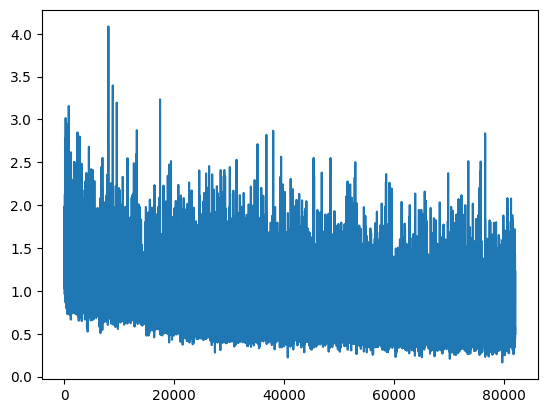

In [23]:
plt.plot(train_losses)

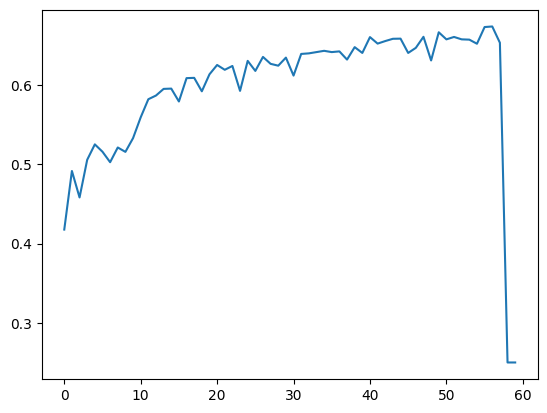

In [24]:
plt.plot(test_accuracy)

In [25]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_esd4/esd4_m13sinc_best_57epoch.pt


RuntimeError: Error(s) in loading state_dict for M13sinc:
	While copying the parameter named "fe_blocks.blocks.1.block.layer.filter_time", whose dimensions in the model are torch.Size([128, 127]) and whose dimensions in the checkpoint are torch.Size([128, 127]), an exception occurred : ('unsupported operation: more than one element of the written-to tensor refers to a single memory location. Please clone() the tensor before performing the operation.',).

In [26]:
!nvidia-smi

Wed Feb 28 10:27:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   29C    P8              22W / 215W |   1164MiB /  8192MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [27]:
checkpoint_path = f'../models_esd4/esd4_m13sinc_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [30]:
from IConNet.visualizer import visualize_model

layer = model.fe_blocks.blocks[0].block.layer

In [31]:
layer

FirConvLayer(
  (conv_layer): ResidualConv1d(
    (pad_layer): PadForConv()
    (stride_layer): DownsampleLayer(
      (pad_right): PadForConv()
    )
    (norm_layer): CustomNormLayer(
      (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
    )
    (act): NLReLU()
  )
)

In [32]:
layer.lowcut_bands

Parameter containing:
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
   

In [33]:
from IConNet.visualizer import display_module

/home/linh/projects/IConNet/IConNet/conv/longconv.py:194: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert filters.shape[1] == self.in_channels
/home/linh/projects/IConNet/IConNet/conv/pad.py:74: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if residual <= 0:
/home/linh/projects/IConNet/IConNet/conv/longconv.py:86: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not ge

aten::mean %x : Float(1, 161, strides=[161, 1], requires_grad=1, device=cuda:0) = aten::mean(%1300, %1149, %1150, %1151) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



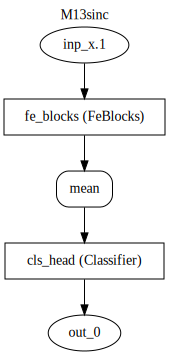

In [34]:
input_shape = (1,1,16000)
model.to(device)
input = torch.rand(input_shape).to(device)
display_module(
    model, input, 
    classes_to_visit={})

/home/linh/projects/IConNet/IConNet/conv/longconv.py:194: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert filters.shape[1] == self.in_channels
/home/linh/projects/IConNet/IConNet/conv/pad.py:74: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if residual <= 0:
/home/linh/projects/IConNet/IConNet/conv/longconv.py:86: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not ge

aten::mean %x : Float(1, 161, strides=[161, 1], requires_grad=1, device=cuda:0) = aten::mean(%1300, %1149, %1150, %1151) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



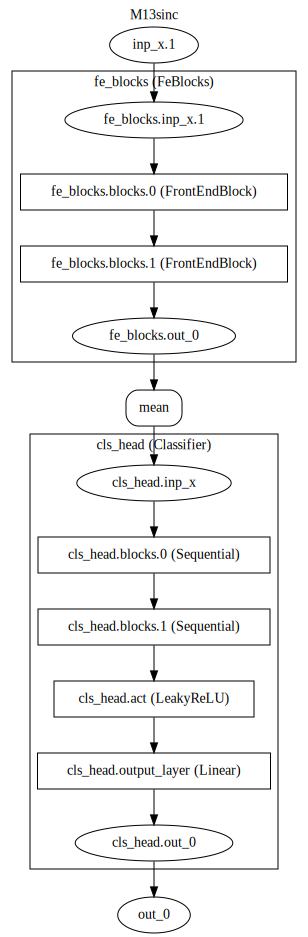

In [35]:
display_module(
    model, input, 
    classes_to_visit={"FeBlocks", "Classifier"})

/home/linh/projects/IConNet/IConNet/conv/longconv.py:194: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert filters.shape[1] == self.in_channels
/home/linh/projects/IConNet/IConNet/conv/pad.py:74: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if residual <= 0:
/home/linh/projects/IConNet/IConNet/conv/longconv.py:86: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not ge

aten::mean %x : Float(1, 161, strides=[161, 1], requires_grad=1, device=cuda:0) = aten::mean(%1300, %1149, %1150, %1151) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



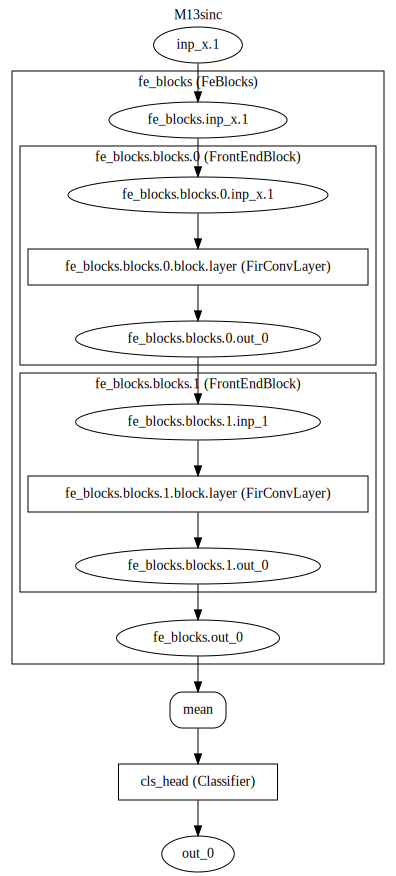

In [36]:
display_module(
    model, input, 
    classes_to_visit={"FeBlocks", "FrontEndBlock"})

/home/linh/projects/IConNet/IConNet/conv/longconv.py:194: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert filters.shape[1] == self.in_channels
/home/linh/projects/IConNet/IConNet/conv/pad.py:74: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if residual <= 0:
/home/linh/projects/IConNet/IConNet/conv/longconv.py:86: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not ge

aten::mean %x : Float(1, 161, strides=[161, 1], requires_grad=1, device=cuda:0) = aten::mean(%1300, %1149, %1150, %1151) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



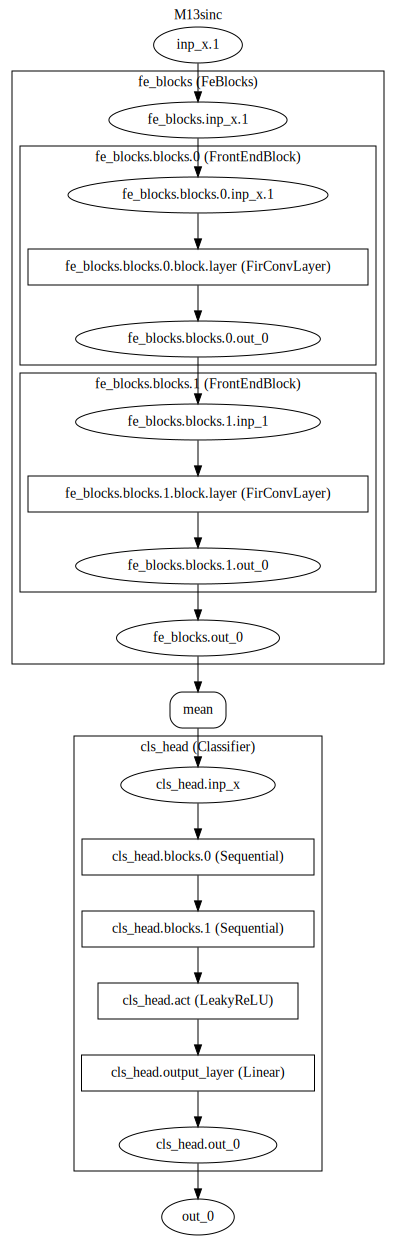

In [37]:
display_module(
    model, input, 
    classes_to_visit={"FeBlocks", "FrontEndBlock", "Classifier"})

In [ ]:
# del model
# del best_model
# gc.collect()